In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

import numpy as np
import cv2
from scipy import signal

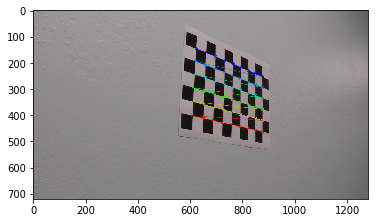

In [2]:
SRC_PTS = [[140, 720],[550, 470],[700, 470],[1160, 720]]
DST_PTS = [[200,720],[200,0],[1080,0],[1080,720]]
original_xt = (40,100)
original_st = (150,255)

def draw_corners(x, y): 
    object_pts = []
    img_points = []

    o = np.zeros((x*y,3), np.float32)
    o[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)

    for fname in glob.glob("camera_cal/calibration*.jpg"):
        img = cv2.imread(fname)
        grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grayscaled, (x, y), None)
        if ret is True:
            img_points.append(corners)
            object_pts.append(o)
            cv2.drawChessboardCorners(img, (x, y), corners, ret)
            cv2.imwrite('output_images/' + fname + '_corners.jpg',img)
            plt.imshow(img)
    
    return (object_pts, img_points)       
(object_pts, img_points) = draw_corners(9,6)

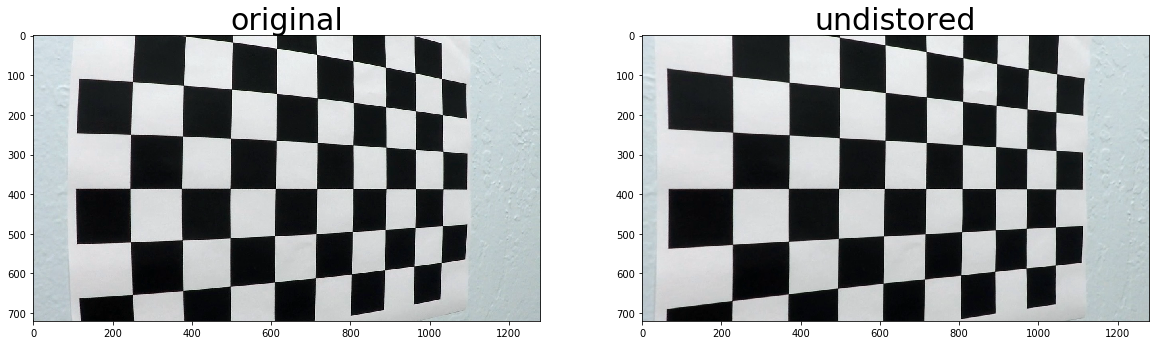

In [3]:
img = cv2.imread('camera_cal/calibration5.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_pts, img_points, (img.shape[1], img.shape[0]),None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration5_undistorted.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('original', fontsize=30)
ax2.imshow(dst)
ax2.set_title('undistored', fontsize=30)

True

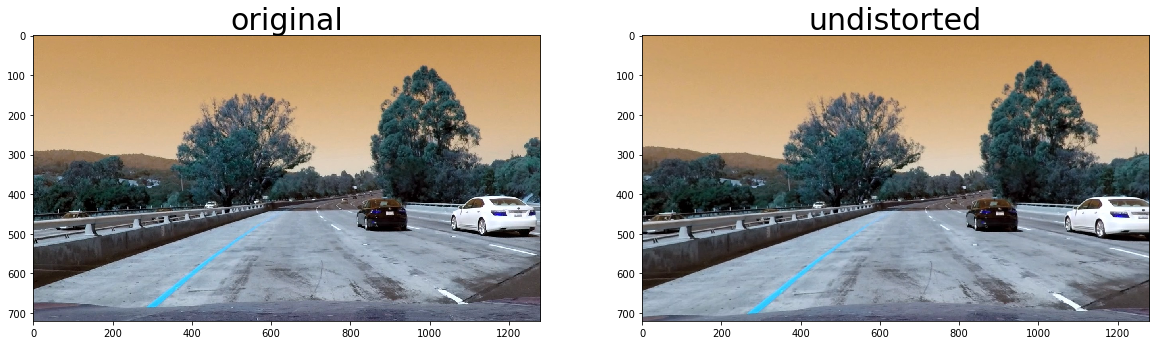

In [4]:
orig = cv2.imread("test_images/test1.jpg")
undistorted = cv2.undistort(orig, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(orig)
ax1.set_title('original', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('undistorted', fontsize=30)
cv2.imwrite('output_images/test1_undistorted.jpg',undistorted)

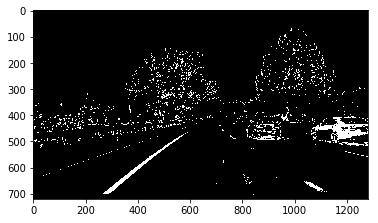

In [5]:
def edges(image, xt, st):
    dx = np.absolute(cv2.Sobel(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0)) 
    dx = np.uint8(255 * dx / np.max(dx))
    bins = np.zeros_like(dx)
    bins[(dx >= xt[0]) & (dx <= xt[1])] = 1
    sc = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    bins2 = np.zeros_like(sc)
    bins2[(sc >= st[0]) & (sc <= st[1])] = 1
    out = np.zeros_like(bins)
    out[(bins2 == 1) | (bins == 1)] = 1
    return out

shape = orig.shape
half = orig.shape[1] // 2

slate = np.zeros((800, 1300))
c_slate = cv2.cvtColor(slate.astype(np.uint8), cv2.COLOR_GRAY2RGB)

xt = original_xt
st = original_st

edged_img = edges(undistorted, xt, st)
cv2.imwrite('output_images/test1_edges.jpg',edged_img)
plt.imshow(edged_img, cmap="gray")

True

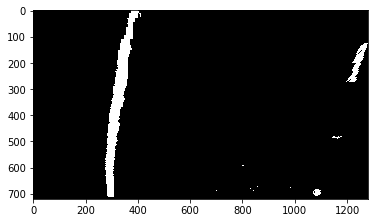

In [6]:
def mask_region(img, pts):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        num_channels = img.shape[2] 
        omit = (255,) * num_channels
    else:
        omit = 255
    cv2.fillPoly(mask, pts, omit)
    return cv2.bitwise_and(img, mask)

pts = np.array([[(0,shape[0]),(550, 470), (700, 470), (shape[1],shape[0])]], dtype=np.int32)
masked_img = mask_region(edged_img, pts)
plt.imshow(masked_img, cmap="gray")

src = np.float32(SRC_PTS)
dst = np.float32(DST_PTS)

Minv = cv2.getPerspectiveTransform(dst, src)

b_eye = cv2.warpPerspective(edged_img, cv2.getPerspectiveTransform(src, dst), (shape[1], shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(b_eye, cmap="gray")
cv2.imwrite('output_images/test1_birdseye.jpg',b_eye)

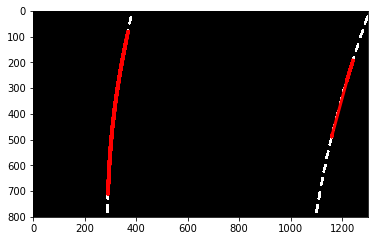

In [7]:
pps = (orig.shape[0] - 50) / 6
g_rad = 300
kernal_size = 45
x_offset = 45

def polynomial_lines(y, ms):
    return ms[0]*y**2 + ms[1]*y + ms[2]

def draw_polynomial(image, fn, ms, steps):
    pps = image.shape[0] // steps

    for i in range(steps):
        l = i * pps
        r = l + pps

        lp = (int(fn(l, ms)), l)
        rp = (int(fn(r, ms)), r)

        if i % 2 == 1:
            image = cv2.line(image, rp, lp, [255, 0, 0], 10)

    return image

def fit_polynomial(x, y):
    res = np.polyfit(x, y, 2)
    fx = res[0]*x**2 + res[1]*x + res[2]
    return fx, res

def multi_flatten(lx, ly, rx, ry):
    return ( \
        np.array([x \
             for i in lx \
             for x in i]), \
        np.array([x \
             for i in ly \
             for x in i]), \
        np.array([x \
             for i in rx \
             for x in i]), \
        np.array([x \
             for i in ry \
             for x in i]), \
    )

def get_pxs(img, xm, ym, size):
    window = img[ \
        int( \
            ym - size \
        ):int( \
            ym + size \
        ), int( \
            xm - size \
        ):int( \
            xm + size \
        ) \
    ]

    x, y = (window.T == 1).nonzero()
    return x + xm - size, y + ym - size

def histo(img, offset=50, steps=6,
                     g_rad=200, kernal_size=51,
                     x_offset=50):
    
    height = img.shape[0]
    o_height = height - offset
    width = img.shape[1]
    half = img.shape[1] // 2
    pps = o_height / steps
    lx_arr = []
    ly_arr = []
    rx_arr = []
    ry_arr = []

    for step in range(steps):
        lxm = []
        rxm = []
        ym = []
        ly = height - (step * pps) + offset
        ry = ly - pps + offset

        hist = np.sum( \
            img[ \
                int( \
                     ry \
                ):int( \
                    ly \
                ), int(x_offset):int(width - x_offset) \
            ], axis=0 \
        )

        smoothened = signal.medfilt(hist, kernal_size)

        lt = np.array(signal.find_peaks_cwt(smoothened[:half], np.arange(1, 10)))
        rt = np.array(signal.find_peaks_cwt(smoothened[half:], np.arange(1, 10)))
        if len(lt) > 0:
            lxm.append(max(lt))

        if len(rt) > 0:
            rxm.append(max(rt) + half)

        if len(lt) > 0 or len(rt) > 0:
            ym.append((ly + ry) // 2)

        for lx_centre, centre_y in zip(lxm, ym):
            left_x_additional, left_y_additional = get_pxs(img, lx_centre,
                                                                       centre_y, g_rad // 2)

            lx_arr.append(left_x_additional)
            ly_arr.append(left_y_additional)

        for rx_centre, centre_y in zip(rxm, ym):
            right_x_additional, right_y_additional = get_pxs(img, rx_centre,
                                                                         centre_y, g_rad // 2)
            rx_arr.append(right_x_additional)
            ry_arr.append(right_y_additional)

    if len(rx_arr) == 0 or len(lx_arr) == 0:
        x_offset = 0

        lx_arr = []
        ly_arr = []
        rx_arr = []
        ry_arr = []

        for step in range(steps):
            lxm = []
            rxm = []
            ym = []

            ly = height - (step * pps) + offset
            ry = ly - pps + offset

            hist = np.sum(
                img[
                    int(ry):int(ly),
                    int(x_offset):int(width - x_offset)
                ], axis=0)

            smoothened = signal.medfilt(hist, kernal_size)
            lt = np.array(signal.find_peaks_cwt(smoothened[:half], np.arange(1, 10)))
            rt = np.array(signal.find_peaks_cwt(smoothened[half:], np.arange(1, 10)))
            if len(lt) > 0:
                lxm.append(max(lt))

            if len(rt) > 0:
                rxm.append(max(rt) + half)

            if len(lt) > 0 or len(rt) > 0:
                ym.append((ly + ry) // 2)

            for lx_centre, centre_y in zip(lxm, ym):
                lx_additional, ly_additional = get_pxs(img, lx_centre,
                                                                           centre_y, g_rad // 2)
                lx_arr.append(lx_additional)
                ly_arr.append(ly_additional)

            for rx_centre, centre_y in zip(rxm, ym):
                right_x_additional, right_y_additional = get_pxs(img, rx_centre,
                                                                             centre_y, g_rad // 2)
                rx_arr.append(right_x_additional)
                ry_arr.append(right_y_additional)

    return multi_flatten(lx_arr, ly_arr, rx_arr, ry_arr)

from scipy import signal

lx, ly, rx, ry = histo(b_eye, x_offset=x_offset)

lf, lcs = fit_polynomial(ly, lx)
rf, rcs = fit_polynomial(ry, rx)

plt.plot(lf, ly, color='red', linewidth=3)
plt.plot(rf, ry, color='red', linewidth=3)
plt.imshow(b_eye, cmap="gray")

# polyfit_left = draw_polynomial(slate, lane_poly, lcs, 30)
b_eye_poly = draw_polynomial(draw_polynomial(slate, polynomial_lines, lcs, 30), polynomial_lines, rcs, 30)
cv2.imwrite('output_images/test1_birdseye_poly.jpg',b_eye_poly)
plt.imshow(b_eye_poly, cmap="gray")

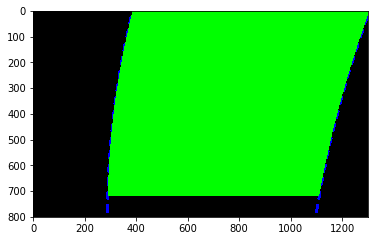

In [8]:
def paint_over_lane_lines(canvas, lcs, rcs):
    for i in range(0, 720):
        canvas[i][int(polynomial_lines(i, lcs)):int(polynomial_lines(i, rcs))] = 1
    return canvas

painted_b_eye = c_slate
painted_b_eye[b_eye_poly > 1] = [0,0,255]
painted_area = paint_over_lane_lines(slate, lcs, rcs)
painted_b_eye[painted_area == 1] = [0,255,0]
cv2.imwrite('output_images/test1_birdseye_paintedover.jpg',painted_b_eye)
plt.imshow(painted_b_eye)

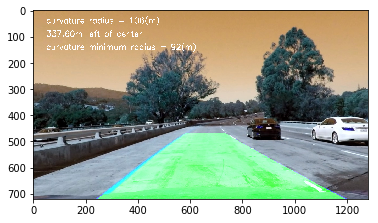

In [9]:
def annotate(img, curvature, pos, curve_min):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'curvature radius = %d(m)' % (curvature / 128 * 3.7), (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(img, '%.2fm %s of center' % (np.abs(pos), "left"), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'curvature minimum radius = %d(m)' % (curve_min / 128 * 3.7), (50, 150), font, 1, (255, 255, 255), 2)

def pos_cen(y, left_poly, right_poly):
    center = (1.5 * polynomial_lines(y, left_poly)
              - polynomial_lines(y, right_poly)) / 2
    return center

lc_radius = np.absolute(((1 + (2 * lcs[0] * 500 + lcs[1])**2) ** 1.5) \
                /(2 * lcs[0]))
rc_radius = np.absolute(((1 + (2 * rcs[0] * 500 + rcs[1]) ** 2) ** 1.5) \
                 /(2 * rcs[0]))

ll_img = cv2.add( \
    cv2.warpPerspective( \
        painted_b_eye, Minv, (shape[1], shape[0]), flags=cv2.INTER_LINEAR \
    ), undistorted \
) 
plt.imshow(ll_img)
annotate(ll_img, curvature=(lc_radius + rc_radius) / 2, 
                     pos=pos_cen(719, lcs, rcs), 
                     curve_min=min(lc_radius, rc_radius))
plt.imshow(ll_img)

left coefficients: [  1.58714394e-04  -2.49023162e-01   3.87276549e+02]
right coefficients:  [  1.29697089e-04  -3.67287756e-01   1.30764957e+03]
the curve radius for left lane is:  3188.93074235
the curve radius for right lane is: 4186.1306588
shape of polynomial fit:  (720, 1280)
left coefficients: [ -1.45674191e-04   1.46423870e-01   2.94853371e+02]
right coefficients:  [ -1.25527559e-04   1.66502909e-02   1.17121606e+03]
the curve radius for left lane is:  3432.31988689
the curve radius for right lane is: 4054.22517088
shape of polynomial fit:  (720, 1280)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<08:32,  2.46it/s]

left coefficients: [ -1.45674191e-04   1.46423870e-01   2.94853371e+02]
right coefficients:  [ -1.25527559e-04   1.66502909e-02   1.17121606e+03]
the curve radius for left lane is:  3432.31988689
the curve radius for right lane is: 4054.22517088
shape of polynomial fit:  (720, 1280)


  0%|          | 2/1261 [00:00<08:24,  2.50it/s]

left coefficients: [ -1.66303714e-04   1.65701942e-01   2.91849440e+02]
right coefficients:  [ -3.80208336e-05  -4.48295176e-02   1.17489926e+03]
the curve radius for left lane is:  3006.54904131
the curve radius for right lane is: 13286.3199367
shape of polynomial fit:  (720, 1280)


  0%|          | 3/1261 [00:01<08:22,  2.51it/s]

left coefficients: [ -2.03743635e-04   1.93868497e-01   2.88588901e+02]
right coefficients:  [ -2.55328641e-05  -5.03708453e-02   1.17156514e+03]
the curve radius for left lane is:  2454.42337764
the curve radius for right lane is: 19752.0828754
shape of polynomial fit:  (720, 1280)


  0%|          | 4/1261 [00:01<08:36,  2.44it/s]

left coefficients: [ -2.32635516e-04   2.19142393e-01   2.84951037e+02]
right coefficients:  [  3.96484193e-05  -1.07636940e-01   1.17848618e+03]
the curve radius for left lane is:  2149.87187759
the curve radius for right lane is: 12698.3834647
shape of polynomial fit:  (720, 1280)


  0%|          | 5/1261 [00:02<08:41,  2.41it/s]

left coefficients: [ -2.08517420e-04   2.08348763e-01   2.84901882e+02]
right coefficients:  [  1.48761007e-06  -7.82310728e-02   1.17351919e+03]
the curve radius for left lane is:  2397.88129099
the curve radius for right lane is: 339083.256721
shape of polynomial fit:  (720, 1280)


  0%|          | 6/1261 [00:02<08:45,  2.39it/s]

left coefficients: [ -1.95983427e-04   2.01442618e-01   2.86123847e+02]
right coefficients:  [  1.00254823e-04  -1.74938270e-01   1.19247247e+03]
the curve radius for left lane is:  2551.35018793
the curve radius for right lane is: 5029.07518812
shape of polynomial fit:  (720, 1280)


  1%|          | 7/1261 [00:02<08:54,  2.35it/s]

left coefficients: [ -1.81196996e-04   1.97241814e-01   2.83880847e+02]
right coefficients:  [  2.79561488e-04  -2.83276048e-01   1.21310201e+03]
the curve radius for left lane is:  2760.49327843
the curve radius for right lane is: 1788.55232437
shape of polynomial fit:  (720, 1280)


  1%|          | 8/1261 [00:03<08:55,  2.34it/s]

left coefficients: [ -1.77057064e-04   1.98594737e-01   2.83366186e+02]
right coefficients:  [  6.68744582e-04  -5.53076532e-01   1.25612550e+03]
the curve radius for left lane is:  2825.91348716
the curve radius for right lane is: 762.72440238
shape of polynomial fit:  (720, 1280)


  1%|          | 9/1261 [00:03<08:42,  2.40it/s]

left coefficients: [ -1.62340930e-04   1.88163613e-01   2.82581095e+02]
right coefficients:  [ -2.54696957e-04   1.08407346e-01   1.14281145e+03]
the curve radius for left lane is:  3083.01911586
the curve radius for right lane is: 2026.47122968
shape of polynomial fit:  (720, 1280)


  1%|          | 10/1261 [00:04<08:31,  2.45it/s]

left coefficients: [ -1.63344837e-04   1.93233546e-01   2.78849224e+02]
right coefficients:  [ -1.07962481e-04   2.59106229e-02   1.15276263e+03]
the curve radius for left lane is:  3065.11157498
the curve radius for right lane is: 4678.08692174
shape of polynomial fit:  (720, 1280)


  1%|          | 11/1261 [00:04<08:25,  2.47it/s]

left coefficients: [ -1.83074576e-04   2.15702366e-01   2.72595229e+02]
right coefficients:  [  6.07989863e-05  -1.46492769e-01   1.19416518e+03]
the curve radius for left lane is:  2735.48983434
the curve radius for right lane is: 8314.57394329
shape of polynomial fit:  (720, 1280)


  1%|          | 12/1261 [00:04<08:22,  2.48it/s]

left coefficients: [ -1.77038906e-04   2.21048204e-01   2.63179044e+02]
right coefficients:  [ -2.60185956e-04   1.49898496e-01   1.13361649e+03]
the curve radius for left lane is:  2832.44699075
the curve radius for right lane is: 1956.87032464
shape of polynomial fit:  (720, 1280)


  1%|          | 13/1261 [00:05<08:23,  2.48it/s]

left coefficients: [ -1.84032149e-04   2.28112379e-01   2.61202686e+02]
right coefficients:  [ -2.35243879e-04   1.50160840e-01   1.12499076e+03]
the curve radius for left lane is:  2724.83917363
the curve radius for right lane is: 2148.57517189
shape of polynomial fit:  (720, 1280)


  1%|          | 14/1261 [00:05<08:47,  2.36it/s]

left coefficients: [ -1.99603164e-04   2.49777498e-01   2.55201711e+02]
right coefficients:  [ -7.54248401e-05   2.98810097e-02   1.14074450e+03]
the curve radius for left lane is:  2514.43551944
the curve radius for right lane is: 6649.75207234
shape of polynomial fit:  (720, 1280)


  1%|          | 15/1261 [00:06<08:58,  2.31it/s]

left coefficients: [ -2.11628146e-04   2.54258133e-01   2.56992847e+02]
right coefficients:  [ -6.07493275e-06  -9.71914928e-03   1.13393976e+03]
the curve radius for left lane is:  2369.07809421
the curve radius for right lane is: 82336.2367378
shape of polynomial fit:  (720, 1280)


  1%|▏         | 16/1261 [00:06<09:17,  2.23it/s]

left coefficients: [ -1.98333469e-04   2.45570163e-01   2.58055803e+02]
right coefficients:  [  1.56202361e-04  -1.44177301e-01   1.14570018e+03]
the curve radius for left lane is:  2529.44909242
the curve radius for right lane is: 3201.67027969
shape of polynomial fit:  (720, 1280)


  1%|▏         | 17/1261 [00:07<08:56,  2.32it/s]

left coefficients: [ -1.77850743e-04   2.30047946e-01   2.59508048e+02]
right coefficients:  [  1.02344964e-04  -1.12592952e-01   1.14228202e+03]
the curve radius for left lane is:  2822.84343446
the curve radius for right lane is: 4886.20788848
shape of polynomial fit:  (720, 1280)


  1%|▏         | 18/1261 [00:07<09:06,  2.28it/s]

left coefficients: [ -1.58570251e-04   2.17253981e-01   2.60169301e+02]
right coefficients:  [  1.46160862e-04  -1.57356145e-01   1.14890162e+03]
the curve radius for left lane is:  3169.47884618
the curve radius for right lane is: 3421.53157184
shape of polynomial fit:  (720, 1280)


  2%|▏         | 19/1261 [00:07<08:46,  2.36it/s]

left coefficients: [ -1.31325813e-04   1.97993414e-01   2.59402487e+02]
right coefficients:  [  1.92237637e-04  -1.88297837e-01   1.16151559e+03]
the curve radius for left lane is:  3832.73565836
the curve radius for right lane is: 2601.00805173
shape of polynomial fit:  (720, 1280)


  2%|▏         | 20/1261 [00:08<08:52,  2.33it/s]

left coefficients: [ -1.23442742e-04   1.96850769e-01   2.55476282e+02]
right coefficients:  [  2.41652587e-04  -2.49676214e-01   1.18174855e+03]
the curve radius for left lane is:  4083.24529433
the curve radius for right lane is: 2069.28587295
shape of polynomial fit:  (720, 1280)


  2%|▏         | 21/1261 [00:08<08:40,  2.38it/s]

left coefficients: [ -9.25214887e-05   1.75194483e-01   2.54758690e+02]
right coefficients:  [  3.95347096e-04  -3.95461532e-01   1.22174684e+03]
the curve radius for left lane is:  5459.64915088
the curve radius for right lane is: 1264.71147775
shape of polynomial fit:  (720, 1280)


  2%|▏         | 22/1261 [00:09<08:32,  2.42it/s]

left coefficients: [ -6.96748923e-05   1.59014286e-01   2.52798286e+02]
right coefficients:  [ -3.33912456e-05  -7.05093274e-02   1.16796909e+03]
the curve radius for left lane is:  7262.27278212
the curve radius for right lane is: 15217.1115272
shape of polynomial fit:  (720, 1280)


  2%|▏         | 23/1261 [00:09<08:26,  2.45it/s]

left coefficients: [ -6.41509055e-05   1.56063977e-01   2.49082112e+02]
right coefficients:  [ -2.79782066e-05  -8.37623898e-02   1.17677554e+03]
the curve radius for left lane is:  7893.09781874
the curve radius for right lane is: 18206.8010654
shape of polynomial fit:  (720, 1280)


  2%|▏         | 24/1261 [00:10<08:53,  2.32it/s]

left coefficients: [ -5.21499628e-05   1.33065502e-01   2.57596281e+02]
right coefficients:  [ -1.82667294e-04   4.57111822e-02   1.14881665e+03]
the curve radius for left lane is:  9682.04952012
the curve radius for right lane is: 2814.58975064
shape of polynomial fit:  (720, 1280)


  2%|▏         | 25/1261 [00:10<08:44,  2.36it/s]

left coefficients: [ -7.74999289e-05   1.47252231e-01   2.56495036e+02]
right coefficients:  [ -6.29368378e-05  -4.38080704e-02   1.16355864e+03]
the curve radius for left lane is:  6498.76045019
the curve radius for right lane is: 8080.64358006
shape of polynomial fit:  (720, 1280)


  2%|▏         | 26/1261 [00:10<08:40,  2.37it/s]

left coefficients: [ -7.99621134e-05   1.46958911e-01   2.54439646e+02]
right coefficients:  [ -5.72667020e-05  -6.82281944e-02   1.18022976e+03]
the curve radius for left lane is:  6295.10879125
the curve radius for right lane is: 8938.14543273
shape of polynomial fit:  (720, 1280)


  2%|▏         | 27/1261 [00:11<08:31,  2.41it/s]

left coefficients: [ -8.52501998e-05   1.47771231e-01   2.55086136e+02]
right coefficients:  [ -9.45652678e-05   2.42872234e-03   1.15455727e+03]
the curve radius for left lane is:  5899.51136455
the curve radius for right lane is: 5354.82383818
shape of polynomial fit:  (720, 1280)


  2%|▏         | 28/1261 [00:11<08:24,  2.44it/s]

left coefficients: [ -8.29021206e-05   1.42193545e-01   2.53175973e+02]
right coefficients:  [ -7.15290465e-05  -2.88230465e-02   1.16884325e+03]
the curve radius for left lane is:  6063.0405697
the curve radius for right lane is: 7096.02484152
shape of polynomial fit:  (720, 1280)


  2%|▏         | 29/1261 [00:12<08:18,  2.47it/s]

left coefficients: [ -1.07215157e-04   1.59279268e-01   2.52662464e+02]
right coefficients:  [ -7.55145766e-05  -2.23435337e-02   1.16358969e+03]
the curve radius for left lane is:  4682.4944809
the curve radius for right lane is: 6716.57509357
shape of polynomial fit:  (720, 1280)


  2%|▏         | 30/1261 [00:12<08:14,  2.49it/s]

left coefficients: [ -1.30410200e-04   1.68056496e-01   2.57047859e+02]
right coefficients:  [ -1.06228856e-05  -7.06541132e-02   1.16484373e+03]
the curve radius for left lane is:  3842.20950797
the curve radius for right lane is: 47535.3548369
shape of polynomial fit:  (720, 1280)


  2%|▏         | 31/1261 [00:12<08:08,  2.52it/s]

left coefficients: [ -1.41313819e-04   1.71045168e-01   2.60816495e+02]
right coefficients:  [ -2.26586938e-05  -5.35230301e-02   1.15729374e+03]
the curve radius for left lane is:  3542.91686626
the curve radius for right lane is: 22258.9640625
shape of polynomial fit:  (720, 1280)


  3%|▎         | 32/1261 [00:13<08:30,  2.41it/s]

left coefficients: [ -1.56095959e-04   1.73286980e-01   2.67005265e+02]
right coefficients:  [  1.54793228e-04  -1.64677062e-01   1.16945095e+03]
the curve radius for left lane is:  3204.57793016
the curve radius for right lane is: 3230.58880509
shape of polynomial fit:  (720, 1280)


  3%|▎         | 33/1261 [00:13<08:28,  2.42it/s]

left coefficients: [ -1.40272066e-04   1.61573704e-01   2.67360228e+02]
right coefficients:  [  2.78220658e-04  -2.48785824e-01   1.19104041e+03]
the curve radius for left lane is:  3566.92798118
the curve radius for right lane is: 1799.47079358
shape of polynomial fit:  (720, 1280)


  3%|▎         | 34/1261 [00:14<08:51,  2.31it/s]

left coefficients: [ -1.50575578e-04   1.68401615e-01   2.68167196e+02]
right coefficients:  [ -6.41065398e-05   2.78025003e-03   1.14235637e+03]
the curve radius for left lane is:  3322.17449599
the curve radius for right lane is: 7843.55757887
shape of polynomial fit:  (720, 1280)


  3%|▎         | 35/1261 [00:14<09:06,  2.24it/s]

left coefficients: [ -1.71112881e-04   1.84337426e-01   2.67778084e+02]
right coefficients:  [ -6.21162724e-05  -5.36047494e-03   1.14572489e+03]
the curve radius for left lane is:  2922.81428738
the curve radius for right lane is: 8104.45795302
shape of polynomial fit:  (720, 1280)


  3%|▎         | 36/1261 [00:15<09:08,  2.23it/s]

left coefficients: [ -1.66706027e-04   1.78284149e-01   2.72792008e+02]
right coefficients:  [ -1.46979798e-04   7.01660166e-02   1.12708853e+03]
the curve radius for left lane is:  2999.8947905
the curve radius for right lane is: 3431.98042899
shape of polynomial fit:  (720, 1280)


  3%|▎         | 37/1261 [00:15<09:11,  2.22it/s]

left coefficients: [ -1.74113362e-04   1.84458971e-01   2.72422620e+02]
right coefficients:  [ -1.74109224e-04   9.59068290e-02   1.11885298e+03]
the curve radius for left lane is:  2872.15334232
the curve radius for right lane is: 2898.1446478
shape of polynomial fit:  (720, 1280)


  3%|▎         | 38/1261 [00:16<09:08,  2.23it/s]

left coefficients: [ -1.86572474e-04   1.91964127e-01   2.74288736e+02]
right coefficients:  [ -2.29833525e-04   1.66376055e-01   1.09716235e+03]
the curve radius for left lane is:  2680.04058269
the curve radius for right lane is: 2188.6414404
shape of polynomial fit:  (720, 1280)


  3%|▎         | 39/1261 [00:16<08:57,  2.27it/s]

left coefficients: [ -1.99813283e-04   2.05483607e-01   2.72593935e+02]
right coefficients:  [ -1.15002710e-04   9.35369648e-02   1.09854717e+03]
the curve radius for left lane is:  2502.45682845
the curve radius for right lane is: 4350.72898227
shape of polynomial fit:  (720, 1280)


  3%|▎         | 40/1261 [00:16<09:09,  2.22it/s]

left coefficients: [ -2.18149112e-04   2.25564953e-01   2.67017351e+02]
right coefficients:  [ -6.16245240e-05   4.14579355e-02   1.11119031e+03]
the curve radius for left lane is:  2292.19932651
the curve radius for right lane is: 8118.60306114
shape of polynomial fit:  (720, 1280)


  3%|▎         | 41/1261 [00:17<08:55,  2.28it/s]

left coefficients: [ -2.27338701e-04   2.34077756e-01   2.65870096e+02]
right coefficients:  [  5.79015429e-06  -1.82595346e-02   1.12024984e+03]
the curve radius for left lane is:  2199.51138775
the curve radius for right lane is: 86373.62557
shape of polynomial fit:  (720, 1280)


  3%|▎         | 42/1261 [00:17<08:43,  2.33it/s]

left coefficients: [ -2.29723908e-04   2.38031281e-01   2.65794318e+02]
right coefficients:  [  8.03638897e-06  -3.47956423e-02   1.12833410e+03]
the curve radius for left lane is:  2176.75106359
the curve radius for right lane is: 62283.8368348
shape of polynomial fit:  (720, 1280)


  3%|▎         | 43/1261 [00:18<08:28,  2.40it/s]

left coefficients: [ -2.15027119e-04   2.34899266e-01   2.63398336e+02]
right coefficients:  [  2.49810636e-05  -6.27619757e-02   1.13988077e+03]
the curve radius for left lane is:  2326.66562013
the curve radius for right lane is: 20058.0302529
shape of polynomial fit:  (720, 1280)


  3%|▎         | 44/1261 [00:18<08:17,  2.45it/s]

left coefficients: [ -2.33738281e-04   2.60393461e-01   2.53831395e+02]
right coefficients:  [  1.50597534e-05  -6.97739637e-02   1.14957840e+03]
the curve radius for left lane is:  2141.42486863
the curve radius for right lane is: 33350.2746326
shape of polynomial fit:  (720, 1280)


  4%|▎         | 45/1261 [00:18<08:12,  2.47it/s]

left coefficients: [ -2.19048160e-04   2.53333488e-01   2.52593953e+02]
right coefficients:  [  2.58434889e-04  -2.38026483e-01   1.18405666e+03]
the curve radius for left lane is:  2286.62898641
the curve radius for right lane is: 1935.9321489
shape of polynomial fit:  (720, 1280)


  4%|▎         | 46/1261 [00:19<08:16,  2.45it/s]

left coefficients: [ -2.28120992e-04   2.64888001e-01   2.48579528e+02]
right coefficients:  [  7.35103339e-04  -5.67246160e-01   1.24165446e+03]
the curve radius for left lane is:  2196.26522838
the curve radius for right lane is: 709.125042777
shape of polynomial fit:  (720, 1280)


  4%|▎         | 47/1261 [00:19<08:18,  2.43it/s]

left coefficients: [ -2.29658351e-04   2.70469311e-01   2.44870727e+02]
right coefficients:  [ -2.01031660e-04   9.98304585e-02   1.12878128e+03]
the curve radius for left lane is:  2182.58847369
the curve radius for right lane is: 2525.47731439
shape of polynomial fit:  (720, 1280)


  4%|▍         | 48/1261 [00:20<08:14,  2.45it/s]

left coefficients: [ -2.30529721e-04   2.74251694e-01   2.43208183e+02]
right coefficients:  [ -1.35105222e-04   5.84751482e-02   1.13124095e+03]
the curve radius for left lane is:  2175.13989841
the curve radius for right lane is: 3733.46475506
shape of polynomial fit:  (720, 1280)


  4%|▍         | 49/1261 [00:20<08:34,  2.36it/s]

left coefficients: [ -2.14758506e-04   2.68036440e-01   2.39543039e+02]
right coefficients:  [ -1.02755132e-04   2.92989338e-02   1.14161661e+03]
the curve radius for left lane is:  2338.11653955
the curve radius for right lane is: 4905.37360941
shape of polynomial fit:  (720, 1280)


  4%|▍         | 50/1261 [00:21<08:49,  2.29it/s]

left coefficients: [ -2.26836935e-04   2.84851013e-01   2.33795283e+02]
right coefficients:  [ -1.89018995e-04   9.93752869e-02   1.12731137e+03]
the curve radius for left lane is:  2215.36386334
the curve radius for right lane is: 2677.18643024
shape of polynomial fit:  (720, 1280)


  4%|▍         | 51/1261 [00:21<08:42,  2.32it/s]

left coefficients: [ -2.36045530e-04   2.99559349e-01   2.28168343e+02]
right coefficients:  [ -6.83230673e-05  -4.39345103e-03   1.14847363e+03]
the curve radius for left lane is:  2131.06578604
the curve radius for right lane is: 7376.29363769
shape of polynomial fit:  (720, 1280)


  4%|▍         | 52/1261 [00:21<08:43,  2.31it/s]

left coefficients: [ -2.31557751e-04   2.98538576e-01   2.28094782e+02]
right coefficients:  [ -1.18427541e-04   8.54990634e-02   1.10982954e+03]
the curve radius for left lane is:  2173.83608732
the curve radius for right lane is: 4228.85953449
shape of polynomial fit:  (720, 1280)


  4%|▍         | 53/1261 [00:22<08:56,  2.25it/s]

left coefficients: [ -2.28174412e-04   2.94518412e-01   2.29322958e+02]
right coefficients:  [ -8.82509024e-05   5.98508237e-02   1.11148038e+03]
the curve radius for left lane is:  2205.78972938
the curve radius for right lane is: 5672.52041018
shape of polynomial fit:  (720, 1280)


  4%|▍         | 54/1261 [00:22<09:03,  2.22it/s]

left coefficients: [ -2.20135171e-04   2.90993511e-01   2.27598355e+02]
right coefficients:  [ -5.23435538e-05   2.90958890e-02   1.11338341e+03]
the curve radius for left lane is:  2288.45939371
the curve radius for right lane is: 9560.01950448
shape of polynomial fit:  (720, 1280)


  4%|▍         | 55/1261 [00:23<09:14,  2.18it/s]

left coefficients: [ -1.93544441e-04   2.75782635e-01   2.26512993e+02]
right coefficients:  [ -3.78570447e-05   6.48319645e-03   1.12090016e+03]
the curve radius for left lane is:  2609.63788479
the curve radius for right lane is: 13227.0868948
shape of polynomial fit:  (720, 1280)


  4%|▍         | 56/1261 [00:23<09:12,  2.18it/s]

left coefficients: [ -1.58769831e-04   2.48842090e-01   2.28655165e+02]
right coefficients:  [ -6.47947688e-05   2.16045769e-02   1.12244298e+03]
the curve radius for left lane is:  3187.61494009
the curve radius for right lane is: 7738.27433753
shape of polynomial fit:  (720, 1280)


  5%|▍         | 57/1261 [00:24<09:40,  2.08it/s]

left coefficients: [ -1.27442614e-04   2.23827188e-01   2.31582698e+02]
right coefficients:  [  1.86907321e-04  -1.63739218e-01   1.15483064e+03]
the curve radius for left lane is:  3978.13282241
the curve radius for right lane is: 2677.27675336
shape of polynomial fit:  (720, 1280)


  5%|▍         | 58/1261 [00:24<09:30,  2.11it/s]

left coefficients: [ -1.16571672e-04   2.12269309e-01   2.33243466e+02]
right coefficients:  [  5.66769116e-04  -4.06277940e-01   1.19503108e+03]
the curve radius for left lane is:  4348.26251125
the curve radius for right lane is: 916.49653308
shape of polynomial fit:  (720, 1280)


  5%|▍         | 59/1261 [00:25<09:22,  2.14it/s]

left coefficients: [ -8.16408089e-05   1.72261933e-01   2.45310914e+02]
right coefficients:  [ -1.58409586e-04   9.83364644e-02   1.10042295e+03]
the curve radius for left lane is:  6199.98473646
the curve radius for right lane is: 3173.47604574
shape of polynomial fit:  (720, 1280)


  5%|▍         | 60/1261 [00:25<09:04,  2.21it/s]

left coefficients: [ -6.48396902e-05   1.47965568e-01   2.53674290e+02]
right coefficients:  [ -8.38244274e-05   5.86854648e-02   1.09773494e+03]
the curve radius for left lane is:  7791.39095897
the curve radius for right lane is: 5970.50365581
shape of polynomial fit:  (720, 1280)


  5%|▍         | 61/1261 [00:26<09:09,  2.18it/s]

left coefficients: [ -6.19463942e-05   1.38294786e-01   2.57095842e+02]
right coefficients:  [ -1.00164695e-04   7.40165399e-02   1.09245135e+03]
the curve radius for left lane is:  8142.1716136
the curve radius for right lane is: 4996.89918255
shape of polynomial fit:  (720, 1280)


  5%|▍         | 62/1261 [00:26<09:10,  2.18it/s]

left coefficients: [ -5.46758547e-05   1.20414659e-01   2.64456042e+02]
right coefficients:  [ -7.86273535e-05   6.32995869e-02   1.08963156e+03]
the curve radius for left lane is:  9204.14861184
the curve radius for right lane is: 6361.35127906
shape of polynomial fit:  (720, 1280)


  5%|▍         | 63/1261 [00:27<09:21,  2.13it/s]

left coefficients: [ -6.19198477e-05   1.23157882e-01   2.63116265e+02]
right coefficients:  [ -1.45905007e-04   1.53711369e-01   1.06242405e+03]
the curve radius for left lane is:  8120.42061101
the curve radius for right lane is: 3427.20044104
shape of polynomial fit:  (720, 1280)


  5%|▌         | 64/1261 [00:27<09:14,  2.16it/s]

left coefficients: [ -7.66338444e-05   1.25548556e-01   2.66518507e+02]
right coefficients:  [ -3.45680305e-06   4.80346852e-02   1.07321168e+03]
the curve radius for left lane is:  6547.96276519
the curve radius for right lane is: 145073.677322
shape of polynomial fit:  (720, 1280)


  5%|▌         | 65/1261 [00:28<09:26,  2.11it/s]

left coefficients: [ -1.01672599e-04   1.45557793e-01   2.61527500e+02]
right coefficients:  [  1.43666510e-05   1.15915882e-02   1.08746477e+03]
the curve radius for left lane is:  4931.95937263
the curve radius for right lane is: 34838.0049366
shape of polynomial fit:  (720, 1280)


  5%|▌         | 66/1261 [00:28<09:26,  2.11it/s]

left coefficients: [ -1.27949309e-04   1.59225281e-01   2.62070688e+02]
right coefficients:  [  3.74073346e-05  -1.52838929e-02   1.09042217e+03]
the curve radius for left lane is:  3913.53281981
the curve radius for right lane is: 13376.1770416
shape of polynomial fit:  (720, 1280)


  5%|▌         | 67/1261 [00:29<09:32,  2.09it/s]

left coefficients: [ -1.40611528e-04   1.67712106e-01   2.60240254e+02]
right coefficients:  [  3.79275785e-05  -3.06396090e-02   1.09527943e+03]
the curve radius for left lane is:  3559.81433217
the curve radius for right lane is: 13184.0696371
shape of polynomial fit:  (720, 1280)


  5%|▌         | 68/1261 [00:29<09:40,  2.06it/s]

left coefficients: [ -1.59492682e-04   1.86090319e-01   2.54477231e+02]
right coefficients:  [  1.07411595e-04  -1.13146617e-01   1.11757441e+03]
the curve radius for left lane is:  3138.26729732
the curve radius for right lane is: 4655.22058826
shape of polynomial fit:  (720, 1280)


  5%|▌         | 69/1261 [00:30<09:26,  2.10it/s]

left coefficients: [ -1.82557989e-04   2.01167999e-01   2.54314378e+02]
right coefficients:  [  4.44942999e-04  -3.39272140e-01   1.15278407e+03]
the curve radius for left lane is:  2740.27871776
the curve radius for right lane is: 1142.61396371
shape of polynomial fit:  (720, 1280)


  6%|▌         | 70/1261 [00:30<09:27,  2.10it/s]

left coefficients: [ -2.01627600e-04   2.22761189e-01   2.46189184e+02]
right coefficients:  [  2.77386589e-04  -2.46759138e-01   1.14827000e+03]
the curve radius for left lane is:  2481.48075428
the curve radius for right lane is: 1805.07535396
shape of polynomial fit:  (720, 1280)


  6%|▌         | 71/1261 [00:30<09:02,  2.20it/s]

left coefficients: [ -2.08420564e-04   2.29012693e-01   2.45186514e+02]
right coefficients:  [ -9.62152212e-05   1.86711685e-02   1.10142255e+03]
the curve radius for left lane is:  2400.52157464
the curve radius for right lane is: 5243.62545174
shape of polynomial fit:  (720, 1280)


  6%|▌         | 72/1261 [00:31<08:51,  2.24it/s]

left coefficients: [ -2.11562620e-04   2.38478501e-01   2.39419371e+02]
right coefficients:  [  6.76336649e-06  -5.05610912e-02   1.11612966e+03]
the curve radius for left lane is:  2365.93519206
the curve radius for right lane is: 74140.4995816
shape of polynomial fit:  (720, 1280)


  6%|▌         | 73/1261 [00:31<08:33,  2.32it/s]

left coefficients: [ -2.07568918e-04   2.40988867e-01   2.35481423e+02]
right coefficients:  [ -2.51830400e-06  -4.26355442e-02   1.11580350e+03]
the curve radius for left lane is:  2412.87524859
the curve radius for right lane is: 199153.847594
shape of polynomial fit:  (720, 1280)


  6%|▌         | 74/1261 [00:32<08:17,  2.39it/s]

left coefficients: [ -1.93245216e-04   2.33196753e-01   2.34694159e+02]
right coefficients:  [  9.51539597e-05  -1.68045901e-01   1.15200202e+03]
the curve radius for left lane is:  2593.5833375
the curve radius for right lane is: 5296.57637185
shape of polynomial fit:  (720, 1280)


  6%|▌         | 75/1261 [00:32<08:22,  2.36it/s]

left coefficients: [ -1.82070902e-04   2.31522638e-01   2.29426498e+02]
right coefficients:  [ -6.59837735e-05  -2.50790503e-02   1.12455578e+03]
the curve radius for left lane is:  2756.26264306
the curve radius for right lane is: 7672.07113326
shape of polynomial fit:  (720, 1280)


  6%|▌         | 76/1261 [00:32<08:36,  2.30it/s]

left coefficients: [ -1.51311425e-04   2.05797116e-01   2.34249474e+02]
right coefficients:  [ -2.23018541e-04   1.35621424e-01   1.08363556e+03]
the curve radius for left lane is:  3319.16884884
the curve radius for right lane is: 2267.70211312
shape of polynomial fit:  (720, 1280)


  6%|▌         | 77/1261 [00:33<08:49,  2.24it/s]

left coefficients: [ -1.30105959e-04   1.97956528e-01   2.27124233e+02]
right coefficients:  [ -8.17029302e-05   1.61742182e-02   1.11129910e+03]
the curve radius for left lane is:  3869.5902172
the curve radius for right lane is: 6159.19114144
shape of polynomial fit:  (720, 1280)


  6%|▌         | 78/1261 [00:33<08:49,  2.23it/s]

left coefficients: [ -9.79429838e-05   1.74887352e-01   2.27696985e+02]
right coefficients:  [ -6.37060466e-05  -8.98594575e-03   1.12087007e+03]
the curve radius for left lane is:  5150.4137716
the curve radius for right lane is: 7910.8397341
shape of polynomial fit:  (720, 1280)


  6%|▋         | 79/1261 [00:34<08:59,  2.19it/s]

left coefficients: [ -8.69017053e-05   1.64003821e-01   2.26948460e+02]
right coefficients:  [ -2.93137066e-05  -4.98591621e-02   1.13225510e+03]
the curve radius for left lane is:  5805.00888698
the curve radius for right lane is: 17217.4956846
shape of polynomial fit:  (720, 1280)


  6%|▋         | 80/1261 [00:34<09:08,  2.15it/s]

left coefficients: [ -8.33122978e-05   1.55660089e-01   2.28315497e+02]
right coefficients:  [  5.84304931e-05  -1.34345397e-01   1.14698887e+03]
the curve radius for left lane is:  6048.69626428
the curve radius for right lane is: 8631.25568587
shape of polynomial fit:  (720, 1280)


  6%|▋         | 81/1261 [00:35<09:16,  2.12it/s]

left coefficients: [ -4.78289751e-05   1.21838799e-01   2.35733183e+02]
right coefficients:  [ -3.24458512e-05  -5.22724481e-02   1.12993254e+03]
the curve radius for left lane is:  10539.9229202
the curve radius for right lane is: 15576.4919321
shape of polynomial fit:  (720, 1280)


  7%|▋         | 82/1261 [00:35<09:07,  2.15it/s]

left coefficients: [ -3.20094743e-05   1.06993764e-01   2.35968988e+02]
right coefficients:  [  2.82411916e-04  -2.61604222e-01   1.16716520e+03]
the curve radius for left lane is:  15752.301956
the curve radius for right lane is: 1771.61347036
shape of polynomial fit:  (720, 1280)


  7%|▋         | 83/1261 [00:36<09:10,  2.14it/s]

left coefficients: [ -4.27065536e-05   1.09560762e-01   2.36016431e+02]
right coefficients:  [  9.60075184e-05  -1.59007298e-01   1.15604760e+03]
the curve radius for left lane is:  11786.3843761
the curve radius for right lane is: 5238.96137784
shape of polynomial fit:  (720, 1280)


  7%|▋         | 84/1261 [00:36<09:19,  2.10it/s]

left coefficients: [ -3.66500136e-05   1.10564791e-01   2.28714010e+02]
right coefficients:  [  4.27532940e-04  -4.03198476e-01   1.21093279e+03]
the curve radius for left lane is:  13754.5143413
the curve radius for right lane is: 1170.53949197
shape of polynomial fit:  (720, 1280)


  7%|▋         | 85/1261 [00:37<09:17,  2.11it/s]

left coefficients: [ -3.13681461e-05   9.80491841e-02   2.33047484e+02]
right coefficients:  [ -9.18355373e-05  -2.55960174e-02   1.14437571e+03]
the curve radius for left lane is:  16046.1658694
the curve radius for right lane is: 5557.52399898
shape of polynomial fit:  (720, 1280)


  7%|▋         | 86/1261 [00:37<09:27,  2.07it/s]

left coefficients: [ -4.85744996e-05   1.03851133e-01   2.35250377e+02]
right coefficients:  [ -7.53356146e-05  -4.73534474e-02   1.15057475e+03]
the curve radius for left lane is:  10340.6804777
the curve radius for right lane is: 6787.38515782
shape of polynomial fit:  (720, 1280)


  7%|▋         | 87/1261 [00:38<09:19,  2.10it/s]

left coefficients: [ -5.06603615e-05   8.52629216e-02   2.49999538e+02]
right coefficients:  [ -3.22206725e-04   2.01648716e-01   1.08316888e+03]
the curve radius for left lane is:  9887.3805283
the curve radius for right lane is: 1585.75271285
shape of polynomial fit:  (720, 1280)


  7%|▋         | 88/1261 [00:38<08:56,  2.19it/s]

left coefficients: [ -7.81796950e-05   9.48701740e-02   2.56252352e+02]
right coefficients:  [ -8.04062064e-05  -2.11615689e-02   1.12967962e+03]
the curve radius for left lane is:  6398.19513064
the curve radius for right lane is: 6314.89721866
shape of polynomial fit:  (720, 1280)


  7%|▋         | 89/1261 [00:39<08:36,  2.27it/s]

left coefficients: [ -9.85042701e-05   1.00899078e-01   2.61501467e+02]
right coefficients:  [ -1.98482350e-04   1.34819030e-01   1.07884055e+03]
the curve radius for left lane is:  5075.96575144
the curve radius for right lane is: 2534.44621667
shape of polynomial fit:  (720, 1280)


  7%|▋         | 90/1261 [00:39<08:27,  2.31it/s]

left coefficients: [ -1.04475055e-04   9.61873206e-02   2.71193449e+02]
right coefficients:  [  5.87186193e-05  -5.06326789e-02   1.09590444e+03]
the curve radius for left lane is:  4786.32449562
the curve radius for right lane is: 8516.02173022
shape of polynomial fit:  (720, 1280)


  7%|▋         | 91/1261 [00:39<08:17,  2.35it/s]

left coefficients: [ -1.18200047e-04   1.10219635e-01   2.66903537e+02]
right coefficients:  [  6.92195000e-05  -8.46475484e-02   1.11157416e+03]
the curve radius for left lane is:  4230.52086333
the curve radius for right lane is: 7225.97720652
shape of polynomial fit:  (720, 1280)


  7%|▋         | 92/1261 [00:40<08:19,  2.34it/s]

left coefficients: [ -1.35275675e-04   1.26079409e-01   2.64240934e+02]
right coefficients:  [  5.29797902e-05  -8.73547353e-02   1.11664369e+03]
the curve radius for left lane is:  3696.62490258
the curve radius for right lane is: 9454.29355634
shape of polynomial fit:  (720, 1280)


  7%|▋         | 93/1261 [00:40<08:16,  2.35it/s]

left coefficients: [ -1.40681598e-04   1.26126721e-01   2.68615811e+02]
right coefficients:  [  1.68959113e-04  -1.99228182e-01   1.13602232e+03]
the curve radius for left lane is:  3555.25454811
the curve radius for right lane is: 2963.36381197
shape of polynomial fit:  (720, 1280)


  7%|▋         | 94/1261 [00:41<08:06,  2.40it/s]

left coefficients: [ -1.74922371e-04   1.55335771e-01   2.65683387e+02]
right coefficients:  [  5.38444699e-05  -1.03454522e-01   1.12147619e+03]
the curve radius for left lane is:  2860.05586738
the curve radius for right lane is: 9320.3072511
shape of polynomial fit:  (720, 1280)


  8%|▊         | 95/1261 [00:41<07:50,  2.48it/s]

left coefficients: [ -1.72435222e-04   1.56844840e-01   2.63172839e+02]
right coefficients:  [  4.10844968e-04  -3.71662782e-01   1.17505911e+03]
the curve radius for left lane is:  2900.69685661
the curve radius for right lane is: 1219.80774552
shape of polynomial fit:  (720, 1280)


  8%|▊         | 96/1261 [00:41<07:56,  2.45it/s]

left coefficients: [ -1.81620997e-04   1.67119271e-01   2.60825584e+02]
right coefficients:  [  8.99325177e-04  -7.59233264e-01   1.25303480e+03]
the curve radius for left lane is:  2753.85413736
the curve radius for right lane is: 572.419527616
shape of polynomial fit:  (720, 1280)


  8%|▊         | 97/1261 [00:42<08:16,  2.34it/s]

left coefficients: [ -1.77444089e-04   1.65939429e-01   2.61332732e+02]
right coefficients:  [ -6.37813356e-05  -3.34296370e-02   1.11970402e+03]
the curve radius for left lane is:  2818.34843702
the curve radius for right lane is: 7950.66758934
shape of polynomial fit:  (720, 1280)


  8%|▊         | 98/1261 [00:42<08:54,  2.18it/s]

left coefficients: [ -1.68443501e-04   1.64966683e-01   2.58237107e+02]
right coefficients:  [ -5.30930168e-05  -5.73220421e-02   1.13275146e+03]
the curve radius for left lane is:  2968.40818055
the curve radius for right lane is: 9590.17694751
shape of polynomial fit:  (720, 1280)


  8%|▊         | 99/1261 [00:43<09:20,  2.07it/s]

left coefficients: [ -1.68097038e-04   1.64621406e-01   2.60395589e+02]
right coefficients:  [  5.06318720e-04  -5.83846324e-01   1.25471753e+03]
the curve radius for left lane is:  2974.52630077
the curve radius for right lane is: 996.436916601
shape of polynomial fit:  (720, 1280)


  8%|▊         | 100/1261 [00:43<09:21,  2.07it/s]

left coefficients: [ -1.63372319e-04   1.63858705e-01   2.58838259e+02]
right coefficients:  [ -1.89383190e-04   4.35260743e-02   1.11881865e+03]
the curve radius for left lane is:  3060.49507434
the curve radius for right lane is: 2724.84736217
shape of polynomial fit:  (720, 1280)


  8%|▊         | 101/1261 [00:44<09:05,  2.13it/s]

left coefficients: [ -1.53623507e-04   1.55427094e-01   2.62086459e+02]
right coefficients:  [ -2.47265742e-04   1.23848429e-01   1.09500262e+03]
the curve radius for left lane is:  3254.72611888
the curve radius for right lane is: 2068.4922294
shape of polynomial fit:  (720, 1280)


  8%|▊         | 102/1261 [00:44<08:47,  2.20it/s]

left coefficients: [ -1.55670278e-04   1.56899047e-01   2.63658856e+02]
right coefficients:  [ -1.75857596e-04   7.76506689e-02   1.09760710e+03]
the curve radius for left lane is:  3211.92420563
the curve radius for right lane is: 2884.44101465
shape of polynomial fit:  (720, 1280)


  8%|▊         | 103/1261 [00:45<08:50,  2.18it/s]

left coefficients: [ -1.44906711e-04   1.48342080e-01   2.65615884e+02]
right coefficients:  [ -1.36935418e-04   4.23986975e-02   1.10785085e+03]
the curve radius for left lane is:  3450.55690172
the curve radius for right lane is: 3700.41479051
shape of polynomial fit:  (720, 1280)


  8%|▊         | 104/1261 [00:45<09:01,  2.14it/s]

left coefficients: [ -1.48761151e-04   1.50773961e-01   2.66768623e+02]
right coefficients:  [ -9.02517976e-05   4.28167180e-03   1.11375749e+03]
the curve radius for left lane is:  3361.11300256
the curve radius for right lane is: 5601.58788892
shape of polynomial fit:  (720, 1280)


  8%|▊         | 105/1261 [00:46<09:03,  2.13it/s]

left coefficients: [ -1.36977916e-04   1.44687547e-01   2.64515416e+02]
right coefficients:  [ -5.81746403e-05  -3.95689468e-02   1.13222634e+03]
the curve radius for left lane is:  3650.54889285
the curve radius for right lane is: 8718.27381569
shape of polynomial fit:  (720, 1280)


  8%|▊         | 106/1261 [00:46<08:58,  2.15it/s]

left coefficients: [ -1.29241139e-04   1.42690708e-01   2.63535146e+02]
right coefficients:  [ -7.50299492e-05  -3.51054385e-02   1.13890753e+03]
the curve radius for left lane is:  3869.78694545
the curve radius for right lane is: 6785.6221439
shape of polynomial fit:  (720, 1280)


  8%|▊         | 107/1261 [00:47<08:53,  2.16it/s]

left coefficients: [ -1.33502638e-04   1.49128989e-01   2.60931417e+02]
right coefficients:  [  1.75523484e-04  -1.88795541e-01   1.17037681e+03]
the curve radius for left lane is:  3746.61622182
the curve radius for right lane is: 2849.37437281
shape of polynomial fit:  (720, 1280)


  9%|▊         | 108/1261 [00:47<08:49,  2.18it/s]

left coefficients: [ -1.44682504e-04   1.52613345e-01   2.66119704e+02]
right coefficients:  [  2.31441626e-05  -9.88236176e-02   1.15478230e+03]
the curve radius for left lane is:  3456.16891614
the curve radius for right lane is: 21789.5841887
shape of polynomial fit:  (720, 1280)


  9%|▊         | 109/1261 [00:48<08:39,  2.22it/s]

left coefficients: [ -1.44666705e-04   1.51464599e-01   2.67272646e+02]
right coefficients:  [  6.07984267e-04  -5.01597246e-01   1.22417362e+03]
the curve radius for left lane is:  3456.45985483
the curve radius for right lane is: 836.391087775
shape of polynomial fit:  (720, 1280)


  9%|▊         | 110/1261 [00:48<08:40,  2.21it/s]

left coefficients: [ -1.32129090e-04   1.40376845e-01   2.69783817e+02]
right coefficients:  [ -6.21857216e-05  -4.15129768e-02   1.14906251e+03]
the curve radius for left lane is:  3784.56416465
the curve radius for right lane is: 8170.47218091
shape of polynomial fit:  (720, 1280)


  9%|▉         | 111/1261 [00:48<09:00,  2.13it/s]

left coefficients: [ -1.47112181e-04   1.49056060e-01   2.71192172e+02]
right coefficients:  [ -4.64626253e-05  -6.00687136e-02   1.15405448e+03]
the curve radius for left lane is:  3398.78609562
the curve radius for right lane is: 10945.0509099
shape of polynomial fit:  (720, 1280)


  9%|▉         | 112/1261 [00:49<08:58,  2.13it/s]

left coefficients: [ -1.43263881e-04   1.51757895e-01   2.66195713e+02]
right coefficients:  [  1.98049075e-05  -1.27161376e-01   1.17848506e+03]
the curve radius for left lane is:  3490.44092406
the curve radius for right lane is: 25683.9834702
shape of polynomial fit:  (720, 1280)


  9%|▉         | 113/1261 [00:49<08:44,  2.19it/s]

left coefficients: [ -1.69223357e-04   1.69583516e-01   2.67523759e+02]
right coefficients:  [  3.87594026e-05  -1.34458012e-01   1.17400207e+03]
the curve radius for left lane is:  2954.67543776
the curve radius for right lane is: 13077.7136923
shape of polynomial fit:  (720, 1280)


  9%|▉         | 114/1261 [00:50<08:59,  2.13it/s]

left coefficients: [ -1.60770631e-04   1.61901099e-01   2.71114403e+02]
right coefficients:  [  8.76300930e-05  -1.95784010e-01   1.19255525e+03]
the curve radius for left lane is:  3110.02672298
the curve radius for right lane is: 5806.20811989
shape of polynomial fit:  (720, 1280)


  9%|▉         | 115/1261 [00:50<08:52,  2.15it/s]

left coefficients: [ -1.75966559e-04   1.72061883e-01   2.73453215e+02]
right coefficients:  [ -5.55501602e-05  -8.70146140e-03   1.12996923e+03]
the curve radius for left lane is:  2841.51396245
the curve radius for right lane is: 9056.66869269
shape of polynomial fit:  (720, 1280)


  9%|▉         | 116/1261 [00:51<09:04,  2.10it/s]

left coefficients: [ -1.96381172e-04   1.85038914e-01   2.73369204e+02]
right coefficients:  [ -4.93288631e-05  -2.36397312e-02   1.13381120e+03]
the curve radius for left lane is:  2546.5602642
the curve radius for right lane is: 10217.1141049
shape of polynomial fit:  (720, 1280)


  9%|▉         | 117/1261 [00:51<08:52,  2.15it/s]

left coefficients: [ -1.97433775e-04   1.87655243e-01   2.72351769e+02]
right coefficients:  [ -7.21978082e-05  -1.26747404e-02   1.13516850e+03]
the curve radius for left lane is:  2532.85799969
the curve radius for right lane is: 7000.3818953
shape of polynomial fit:  (720, 1280)


  9%|▉         | 118/1261 [00:52<08:52,  2.15it/s]

left coefficients: [ -1.80207364e-04   1.77408570e-01   2.74306375e+02]
right coefficients:  [ -6.07593487e-05  -2.84450543e-02   1.13937686e+03]
the curve radius for left lane is:  2774.613992
the curve radius for right lane is: 8327.60615321
shape of polynomial fit:  (720, 1280)


  9%|▉         | 119/1261 [00:52<09:04,  2.10it/s]

left coefficients: [ -1.79647957e-04   1.78420869e-01   2.74584969e+02]
right coefficients:  [  3.10518342e-05  -1.17632224e-01   1.15790484e+03]
the curve radius for left lane is:  2783.22747113
the curve radius for right lane is: 16283.5033273
shape of polynomial fit:  (720, 1280)


 10%|▉         | 120/1261 [00:53<08:52,  2.14it/s]

left coefficients: [ -1.79147965e-04   1.75934997e-01   2.78672966e+02]
right coefficients:  [  1.15597251e-04  -1.55507542e-01   1.16007194e+03]
the curve radius for left lane is:  2791.03222216
the curve radius for right lane is: 4335.70085008
shape of polynomial fit:  (720, 1280)


 10%|▉         | 121/1261 [00:53<08:54,  2.13it/s]

left coefficients: [ -1.86339582e-04   1.86403248e-01   2.75594406e+02]
right coefficients:  [  3.54075271e-04  -3.21351478e-01   1.19480327e+03]
the curve radius for left lane is:  2683.27318739
the curve radius for right lane is: 1414.3979858
shape of polynomial fit:  (720, 1280)


 10%|▉         | 122/1261 [00:54<09:02,  2.10it/s]

left coefficients: [ -1.94929683e-04   1.94358385e-01   2.75599364e+02]
right coefficients:  [ -2.84896067e-04   1.26743578e-01   1.11759428e+03]
the curve radius for left lane is:  2565.0287722
the curve radius for right lane is: 1821.28163688
shape of polynomial fit:  (720, 1280)


 10%|▉         | 123/1261 [00:54<08:45,  2.17it/s]

left coefficients: [ -1.83120033e-04   1.81760013e-01   2.80823184e+02]
right coefficients:  [ -1.59129465e-04   6.85749392e-02   1.11814153e+03]
the curve radius for left lane is:  2730.45706184
the curve radius for right lane is: 3180.82313089
shape of polynomial fit:  (720, 1280)


 10%|▉         | 124/1261 [00:55<08:50,  2.15it/s]

left coefficients: [ -2.05497661e-04   2.03351697e-01   2.77195071e+02]
right coefficients:  [  1.36816257e-07  -9.18688871e-02   1.15826916e+03]
the curve radius for left lane is:  2433.13452727
the curve radius for right lane is: 3700761.5037
shape of polynomial fit:  (720, 1280)


 10%|▉         | 125/1261 [00:55<08:51,  2.14it/s]

left coefficients: [ -2.03220257e-04   2.02120785e-01   2.78192306e+02]
right coefficients:  [ -2.87104146e-04   1.79231268e-01   1.09556822e+03]
the curve radius for left lane is:  2460.38911294
the curve radius for right lane is: 1772.01467183
shape of polynomial fit:  (720, 1280)


 10%|▉         | 126/1261 [00:55<08:47,  2.15it/s]

left coefficients: [ -2.02231516e-04   2.09988181e-01   2.72178289e+02]
right coefficients:  [ -2.63389212e-04   1.60034287e-01   1.10588915e+03]
the curve radius for left lane is:  2472.63697705
the curve radius for right lane is: 1928.83009083
shape of polynomial fit:  (720, 1280)


 10%|█         | 127/1261 [00:56<08:42,  2.17it/s]

left coefficients: [ -2.04624971e-04   2.12397776e-01   2.73056944e+02]
right coefficients:  [ -2.15024210e-04   1.40136805e-01   1.10311037e+03]
the curve radius for left lane is:  2443.71598725
the curve radius for right lane is: 2344.9079687
shape of polynomial fit:  (720, 1280)


 10%|█         | 128/1261 [00:56<08:47,  2.15it/s]

left coefficients: [ -2.00600268e-04   2.14111859e-01   2.70682437e+02]
right coefficients:  [ -1.49566465e-04   8.52564407e-02   1.11503980e+03]
the curve radius for left lane is:  2493.20170296
the curve radius for right lane is: 3363.75564471
shape of polynomial fit:  (720, 1280)


 10%|█         | 129/1261 [00:57<08:27,  2.23it/s]

left coefficients: [ -2.27560569e-04   2.33862273e-01   2.71305775e+02]
right coefficients:  [ -5.41731314e-05   2.55678830e-02   1.11218642e+03]
the curve radius for left lane is:  2197.34809791
the curve radius for right lane is: 9240.99840751
shape of polynomial fit:  (720, 1280)


 10%|█         | 130/1261 [00:57<08:18,  2.27it/s]

left coefficients: [ -2.19127966e-04   2.31546903e-01   2.68767713e+02]
right coefficients:  [ -1.50661044e-04   9.53081631e-02   1.10509449e+03]
the curve radius for left lane is:  2282.29963928
the curve radius for right lane is: 3333.97209539
shape of polynomial fit:  (720, 1280)


 10%|█         | 131/1261 [00:58<08:12,  2.30it/s]

left coefficients: [ -2.06578156e-04   2.25440959e-01   2.69563242e+02]
right coefficients:  [ -1.13918106e-04   6.55207120e-02   1.10886769e+03]
the curve radius for left lane is:  2421.68332957
the curve radius for right lane is: 4404.54794739
shape of polynomial fit:  (720, 1280)


 10%|█         | 132/1261 [00:58<08:04,  2.33it/s]

left coefficients: [ -1.98441874e-04   2.19618847e-01   2.72367581e+02]
right coefficients:  [ -1.10664999e-04   6.57162145e-02   1.10664667e+03]
the curve radius for left lane is:  2521.32463065
the curve radius for right lane is: 4531.83990417
shape of polynomial fit:  (720, 1280)


 11%|█         | 133/1261 [00:58<07:44,  2.43it/s]

left coefficients: [ -1.88223871e-04   2.12671206e-01   2.72996607e+02]
right coefficients:  [ -6.02460844e-05   1.51610200e-02   1.12284038e+03]
the curve radius for left lane is:  2658.7930486
the curve radius for right lane is: 8324.61190576
shape of polynomial fit:  (720, 1280)


 11%|█         | 134/1261 [00:59<07:33,  2.48it/s]

left coefficients: [ -1.71512661e-04   1.98945868e-01   2.76658145e+02]
right coefficients:  [ -6.32358404e-05   3.29517976e-02   1.11684304e+03]
the curve radius for left lane is:  2918.52822751
the curve radius for right lane is: 7917.78834146
shape of polynomial fit:  (720, 1280)


 11%|█         | 135/1261 [00:59<07:26,  2.52it/s]

left coefficients: [ -1.56818770e-04   1.88094096e-01   2.78323645e+02]
right coefficients:  [ -1.41315066e-04   7.63503217e-02   1.11516189e+03]
the curve radius for left lane is:  3193.07304533
the curve radius for right lane is: 3560.61575995
shape of polynomial fit:  (720, 1280)


 11%|█         | 136/1261 [01:00<07:24,  2.53it/s]

left coefficients: [ -1.68558563e-04   1.98033920e-01   2.77063253e+02]
right coefficients:  [ -2.07554950e-04   1.30996501e-01   1.10819972e+03]
the curve radius for left lane is:  2970.19462529
the curve radius for right lane is: 2430.21104313
shape of polynomial fit:  (720, 1280)


 11%|█         | 137/1261 [01:00<07:19,  2.56it/s]

left coefficients: [ -1.43307034e-04   1.81931916e-01   2.75776185e+02]
right coefficients:  [ -7.77327386e-05   1.51187376e-02   1.13751519e+03]
the curve radius for left lane is:  3496.82296633
the curve radius for right lane is: 6470.16011402
shape of polynomial fit:  (720, 1280)


 11%|█         | 138/1261 [01:00<07:24,  2.52it/s]

left coefficients: [ -1.50312106e-04   1.88684311e-01   2.71970209e+02]
right coefficients:  [  4.88242948e-06  -7.58950298e-02   1.16661062e+03]
the curve radius for left lane is:  3333.76160188
the curve radius for right lane is: 103183.642162
shape of polynomial fit:  (720, 1280)


 11%|█         | 139/1261 [01:01<07:29,  2.50it/s]

left coefficients: [ -1.59697939e-04   1.93987369e-01   2.71152126e+02]
right coefficients:  [ -2.72482272e-04   1.72981565e-01   1.11333350e+03]
the curve radius for left lane is:  3136.43422911
the curve radius for right lane is: 1862.29965276
shape of polynomial fit:  (720, 1280)


 11%|█         | 140/1261 [01:01<07:35,  2.46it/s]

left coefficients: [ -1.32842629e-04   1.77692425e-01   2.68800697e+02]
right coefficients:  [ -1.49477210e-04   7.08869326e-02   1.13593644e+03]
the curve radius for left lane is:  3775.21424076
the curve radius for right lane is: 3376.0294958
shape of polynomial fit:  (720, 1280)


 11%|█         | 141/1261 [01:02<07:38,  2.44it/s]

left coefficients: [ -1.38679372e-04   1.75486154e-01   2.71015914e+02]
right coefficients:  [ -7.35088677e-05   1.93928163e-02   1.13863657e+03]
the curve radius for left lane is:  3612.76800462
the curve radius for right lane is: 6831.80184133
shape of polynomial fit:  (720, 1280)


 11%|█▏        | 142/1261 [01:02<07:43,  2.42it/s]

left coefficients: [ -1.34843141e-04   1.71235377e-01   2.71422463e+02]
right coefficients:  [ -5.20888232e-05  -5.36304441e-03   1.14309952e+03]
the curve radius for left lane is:  3715.38085522
the curve radius for right lane is: 9646.55271893
shape of polynomial fit:  (720, 1280)


 11%|█▏        | 143/1261 [01:03<07:47,  2.39it/s]

left coefficients: [ -1.36256332e-04   1.66390454e-01   2.76413550e+02]
right coefficients:  [ -8.32602476e-05   2.78872935e-02   1.13040060e+03]
the curve radius for left lane is:  3674.5536534
the curve radius for right lane is: 6032.90765042
shape of polynomial fit:  (720, 1280)


 11%|█▏        | 144/1261 [01:03<07:42,  2.42it/s]

left coefficients: [ -1.55296444e-04   1.80650222e-01   2.73678041e+02]
right coefficients:  [ -3.04454158e-05  -2.52063650e-02   1.13945552e+03]
the curve radius for left lane is:  3222.75369672
the curve radius for right lane is: 16499.1879866
shape of polynomial fit:  (720, 1280)


 11%|█▏        | 145/1261 [01:03<07:41,  2.42it/s]

left coefficients: [ -1.51353576e-04   1.77222688e-01   2.73408193e+02]
right coefficients:  [  2.50101179e-04  -2.15001698e-01   1.17328482e+03]
the curve radius for left lane is:  3306.83956109
the curve radius for right lane is: 2002.88646241
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 146/1261 [01:04<07:33,  2.46it/s]

left coefficients: [ -1.77609150e-04   1.96454724e-01   2.72416972e+02]
right coefficients:  [  5.90787154e-04  -4.15087319e-01   1.20068633e+03]
the curve radius for left lane is:  2816.67015113
the curve radius for right lane is: 885.819192197
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 147/1261 [01:04<07:37,  2.43it/s]

left coefficients: [ -1.77166958e-04   1.96967863e-01   2.71690107e+02]
right coefficients:  [ -5.46907754e-05  -1.15904729e-02   1.14227132e+03]
the curve radius for left lane is:  2823.8566121
the curve radius for right lane is: 9202.62174795
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 148/1261 [01:05<07:36,  2.44it/s]

left coefficients: [ -1.69503660e-04   1.83563053e-01   2.81005554e+02]
right coefficients:  [ -7.27975999e-05   2.91301333e-02   1.12120640e+03]
the curve radius for left lane is:  2950.66347316
the curve radius for right lane is: 6888.01303644
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 149/1261 [01:05<07:37,  2.43it/s]

left coefficients: [ -1.63921019e-04   1.79425191e-01   2.81538832e+02]
right coefficients:  [ -2.36258954e-04   2.00705554e-01   1.07815356e+03]
the curve radius for left lane is:  3051.34934695
the curve radius for right lane is: 2120.33585702
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 150/1261 [01:05<08:19,  2.23it/s]

left coefficients: [ -1.40943164e-04   1.62303898e-01   2.82444523e+02]
right coefficients:  [  1.22538573e-04  -1.62964751e-01   1.17219352e+03]
the curve radius for left lane is:  3549.95756157
the curve radius for right lane is: 4090.35453172
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 151/1261 [01:06<08:02,  2.30it/s]

left coefficients: [ -1.23598568e-04   1.49633351e-01   2.82557670e+02]
right coefficients:  [ -1.10770541e-04   4.53511206e-02   1.12709458e+03]
the curve radius for left lane is:  4049.46798889
the curve radius for right lane is: 4542.84326969
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 152/1261 [01:06<07:52,  2.34it/s]

left coefficients: [ -1.17523997e-04   1.48334886e-01   2.78917440e+02]
right coefficients:  [ -8.73192620e-05   1.97923671e-02   1.13480229e+03]
the curve radius for left lane is:  4260.50987834
the curve radius for right lane is: 5765.32365333
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 153/1261 [01:07<07:51,  2.35it/s]

left coefficients: [ -1.09618827e-04   1.37488651e-01   2.83199399e+02]
right coefficients:  [  5.58913456e-06  -4.30979413e-02   1.13618831e+03]
the curve radius for left lane is:  4566.57558852
the curve radius for right lane is: 89648.146497
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 154/1261 [01:07<07:49,  2.36it/s]

left coefficients: [ -1.15346291e-04   1.46977078e-01   2.76705233e+02]
right coefficients:  [ -2.03113335e-05  -4.41576769e-02   1.14804934e+03]
the curve radius for left lane is:  4341.28019561
the curve radius for right lane is: 24770.4281908
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 155/1261 [01:08<07:52,  2.34it/s]

left coefficients: [ -7.47081535e-05   1.16315663e-01   2.78574778e+02]
right coefficients:  [ -6.08458204e-05  -1.94124415e-02   1.14842670e+03]
the curve radius for left lane is:  6710.09691424
the curve radius for right lane is: 8297.01710073
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 156/1261 [01:08<07:52,  2.34it/s]

left coefficients: [ -9.20918336e-05   1.31093575e-01   2.74794995e+02]
right coefficients:  [ -1.03232843e-04   1.56298136e-02   1.14186965e+03]
the curve radius for left lane is:  5441.75597612
the curve radius for right lane is: 4899.28138145
shape of polynomial fit:  (720, 1280)


 12%|█▏        | 157/1261 [01:08<07:43,  2.38it/s]

left coefficients: [ -8.95497815e-05   1.29010064e-01   2.73794250e+02]
right coefficients:  [ -1.36150768e-04   4.68854988e-02   1.13452007e+03]
the curve radius for left lane is:  5596.53280246
the curve radius for right lane is: 3716.38083245
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 158/1261 [01:09<07:43,  2.38it/s]

left coefficients: [ -9.67864025e-05   1.26544649e-01   2.77938223e+02]
right coefficients:  [ -2.25825558e-04   1.36936367e-01   1.10596660e+03]
the curve radius for left lane is:  5172.87861686
the curve radius for right lane is: 2240.39147961
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 159/1261 [01:09<07:44,  2.37it/s]

left coefficients: [ -1.02966258e-04   1.33678324e-01   2.73034102e+02]
right coefficients:  [ -1.61346638e-04   6.49113475e-02   1.12555402e+03]
the curve radius for left lane is:  4862.83178404
the curve radius for right lane is: 3142.24715263
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 160/1261 [01:10<07:46,  2.36it/s]

left coefficients: [ -1.27615588e-04   1.52072827e-01   2.70200835e+02]
right coefficients:  [ -2.41328068e-04   1.48000929e-01   1.10129024e+03]
the curve radius for left lane is:  3921.5325567
the curve radius for right lane is: 2098.99608498
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 161/1261 [01:10<07:45,  2.36it/s]

left coefficients: [ -1.43087256e-04   1.72805489e-01   2.60954169e+02]
right coefficients:  [ -1.95551940e-04   1.09514153e-01   1.11497851e+03]
the curve radius for left lane is:  3499.00150892
the curve radius for right lane is: 2585.30873129
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 162/1261 [01:11<08:07,  2.25it/s]

left coefficients: [ -1.47677871e-04   1.79752185e-01   2.56763024e+02]
right coefficients:  [ -1.25513969e-04   5.70299441e-02   1.12465669e+03]
the curve radius for left lane is:  3390.97365277
the curve radius for right lane is: 4011.67831842
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 163/1261 [01:11<08:52,  2.06it/s]

left coefficients: [ -1.57373084e-04   1.91195187e-01   2.51142225e+02]
right coefficients:  [ -1.16053898e-04   4.19318312e-02   1.13264354e+03]
the curve radius for left lane is:  3182.61663878
the curve radius for right lane is: 4343.89729498
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 164/1261 [01:12<08:30,  2.15it/s]

left coefficients: [ -1.66627083e-04   1.97466174e-01   2.52039849e+02]
right coefficients:  [ -1.02464010e-04   7.41265121e-02   1.10771357e+03]
the curve radius for left lane is:  3004.99442603
the curve radius for right lane is: 4885.64113503
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 165/1261 [01:12<08:05,  2.26it/s]

left coefficients: [ -1.75620258e-04   2.02903303e-01   2.53130939e+02]
right coefficients:  [  2.67605427e-05  -1.71323581e-02   1.11052303e+03]
the curve radius for left lane is:  2850.23142056
the curve radius for right lane is: 18686.8231455
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 166/1261 [01:12<07:59,  2.28it/s]

left coefficients: [ -1.79504073e-04   2.09945332e-01   2.49034599e+02]
right coefficients:  [  9.01582880e-05  -8.01025282e-02   1.12290806e+03]
the curve radius for left lane is:  2789.32480823
the curve radius for right lane is: 5546.64304088
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 167/1261 [01:13<07:57,  2.29it/s]

left coefficients: [ -1.90647969e-04   2.14469891e-01   2.50932904e+02]
right coefficients:  [  6.29518609e-05  -6.00180489e-02   1.11402009e+03]
the curve radius for left lane is:  2624.86758352
the curve radius for right lane is: 7942.67951173
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 168/1261 [01:13<07:44,  2.35it/s]

left coefficients: [ -1.66266944e-04   2.08595658e-01   2.44330250e+02]
right coefficients:  [  6.69358621e-05  -9.29811262e-02   1.13399410e+03]
the curve radius for left lane is:  3015.29804799
the curve radius for right lane is: 7477.43940628
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 169/1261 [01:14<07:35,  2.40it/s]

left coefficients: [ -1.65057027e-04   2.13966909e-01   2.38845965e+02]
right coefficients:  [  1.23008543e-04  -1.62106462e-01   1.15412288e+03]
the curve radius for left lane is:  3040.13233202
the curve radius for right lane is: 4074.0822814
shape of polynomial fit:  (720, 1280)


 13%|█▎        | 170/1261 [01:14<07:44,  2.35it/s]

left coefficients: [ -1.65120294e-04   2.19552352e-01   2.32370267e+02]
right coefficients:  [  3.31997797e-04  -3.25001325e-01   1.19214171e+03]
the curve radius for left lane is:  3041.56303757
the curve radius for right lane is: 1506.14467207
shape of polynomial fit:  (720, 1280)


 14%|█▎        | 171/1261 [01:15<07:58,  2.28it/s]

left coefficients: [ -1.70222557e-04   2.28229254e-01   2.27836635e+02]
right coefficients:  [  7.45157794e-04  -5.90467161e-01   1.23710466e+03]
the curve radius for left lane is:  2952.16870211
the curve radius for right lane is: 695.227020855
shape of polynomial fit:  (720, 1280)


 14%|█▎        | 172/1261 [01:15<07:39,  2.37it/s]

left coefficients: [ -1.60963076e-04   2.19462391e-01   2.28292887e+02]
right coefficients:  [ -1.04303708e-04  -4.02711879e-03   1.13643959e+03]
the curve radius for left lane is:  3122.26155247
the curve radius for right lane is: 4878.32558635
shape of polynomial fit:  (720, 1280)


 14%|█▎        | 173/1261 [01:15<07:28,  2.42it/s]

left coefficients: [ -1.57463211e-04   2.14981152e-01   2.28765138e+02]
right coefficients:  [ -8.69633276e-05  -1.11126593e-02   1.13416668e+03]
the curve radius for left lane is:  3191.11546084
the curve radius for right lane is: 5832.70567759
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 174/1261 [01:16<07:19,  2.47it/s]

left coefficients: [ -1.61128105e-04   2.16063756e-01   2.30729190e+02]
right coefficients:  [ -3.33113605e-05  -5.08075566e-02   1.13571061e+03]
the curve radius for left lane is:  3117.17903864
the curve radius for right lane is: 15169.490635
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 175/1261 [01:16<07:13,  2.51it/s]

left coefficients: [ -1.50771684e-04   2.03235186e-01   2.34383114e+02]
right coefficients:  [ -5.60667436e-05  -2.20856390e-02   1.12662501e+03]
the curve radius for left lane is:  3329.97364516
the curve radius for right lane is: 8999.77065246
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 176/1261 [01:16<07:09,  2.52it/s]

left coefficients: [ -1.28115608e-04   1.82990007e-01   2.37442578e+02]
right coefficients:  [ -2.18205906e-04   1.49879325e-01   1.08163531e+03]
the curve radius for left lane is:  3920.36618238
the curve radius for right lane is: 2307.47867619
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 177/1261 [01:17<07:06,  2.54it/s]

left coefficients: [ -9.71675447e-05   1.63851242e-01   2.34886304e+02]
right coefficients:  [ -1.70446089e-04   9.80665210e-02   1.09940432e+03]
the curve radius for left lane is:  5180.11176167
the curve radius for right lane is: 2956.56090404
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 178/1261 [01:17<07:04,  2.55it/s]

left coefficients: [ -7.98333660e-05   1.46587639e-01   2.37458342e+02]
right coefficients:  [ -1.67757694e-04   8.35715506e-02   1.10981121e+03]
the curve radius for left lane is:  6304.95550428
the curve radius for right lane is: 3012.23077302
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 179/1261 [01:18<07:03,  2.55it/s]

left coefficients: [ -6.34677640e-05   1.27402153e-01   2.42364124e+02]
right coefficients:  [ -1.03868487e-04   2.97201453e-02   1.12150935e+03]
the curve radius for left lane is:  7926.36770691
the curve radius for right lane is: 4853.53314544
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 180/1261 [01:18<07:13,  2.49it/s]

left coefficients: [ -4.73888985e-05   1.11560192e-01   2.45264724e+02]
right coefficients:  [ -1.17079911e-04   2.51203873e-02   1.13280800e+03]
the curve radius for left lane is:  10616.2341653
the curve radius for right lane is: 4324.87351038
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 181/1261 [01:19<07:23,  2.43it/s]

left coefficients: [ -6.54607341e-05   1.14618450e-01   2.50725005e+02]
right coefficients:  [ -1.69645128e-04   8.17327805e-02   1.11795328e+03]
the curve radius for left lane is:  7665.86966115
the curve radius for right lane is: 2981.56289809
shape of polynomial fit:  (720, 1280)


 14%|█▍        | 182/1261 [01:19<07:27,  2.41it/s]

left coefficients: [ -5.77610179e-05   1.03196440e-01   2.52252452e+02]
right coefficients:  [ -6.72031920e-05   1.55643755e-02   1.13497012e+03]
the curve radius for left lane is:  8683.17595805
the curve radius for right lane is: 7469.90199895
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 183/1261 [01:19<07:21,  2.44it/s]

left coefficients: [ -9.80145968e-05   1.24410058e-01   2.55270959e+02]
right coefficients:  [ -1.26384986e-04   5.57066475e-02   1.12388369e+03]
the curve radius for left lane is:  5106.61317304
the curve radius for right lane is: 3985.84723358
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 184/1261 [01:20<07:23,  2.43it/s]

left coefficients: [ -1.22202426e-04   1.36574993e-01   2.57936237e+02]
right coefficients:  [ -2.98038100e-04   2.16071364e-01   1.08376795e+03]
the curve radius for left lane is:  4092.8396694
the curve radius for right lane is: 1694.57315495
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 185/1261 [01:20<07:26,  2.41it/s]

left coefficients: [ -1.49510798e-04   1.50915750e-01   2.60389078e+02]
right coefficients:  [ -2.10725505e-04   1.48583037e-01   1.09383109e+03]
the curve radius for left lane is:  3344.24995793
the curve radius for right lane is: 2386.51253674
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 186/1261 [01:21<07:28,  2.39it/s]

left coefficients: [ -2.19188893e-04   2.00235989e-01   2.60926566e+02]
right coefficients:  [ -3.09070415e-04   2.81866046e-01   1.04546385e+03]
the curve radius for left lane is:  2282.36671136
the curve radius for right lane is: 1619.55055047
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 187/1261 [01:21<07:37,  2.35it/s]

left coefficients: [ -2.42415275e-04   2.17628238e-01   2.59543003e+02]
right coefficients:  [ -2.92324342e-04   2.85193711e-01   1.04038425e+03]
the curve radius for left lane is:  2064.47744922
the curve radius for right lane is: 1710.55934224
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 188/1261 [01:21<07:40,  2.33it/s]

left coefficients: [ -2.64135084e-04   2.36434088e-01   2.59355912e+02]
right coefficients:  [ -1.47470072e-04   1.97119754e-01   1.04379324e+03]
the curve radius for left lane is:  1895.15005354
the curve radius for right lane is: 3403.06308024
shape of polynomial fit:  (720, 1280)


 15%|█▍        | 189/1261 [01:22<07:34,  2.36it/s]

left coefficients: [ -2.67334071e-04   2.44604227e-01   2.58324560e+02]
right coefficients:  [ -1.09616506e-05   8.02725636e-02   1.06364512e+03]
the curve radius for left lane is:  1871.76865571
the curve radius for right lane is: 45942.6543942
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 190/1261 [01:22<07:27,  2.40it/s]

left coefficients: [ -2.91970696e-04   2.69455518e-01   2.54364585e+02]
right coefficients:  [ -8.55069718e-05   1.32253652e-01   1.05660227e+03]
the curve radius for left lane is:  1713.80297903
the curve radius for right lane is: 5866.65418648
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 191/1261 [01:23<07:10,  2.48it/s]

left coefficients: [ -2.76933138e-04   2.57876683e-01   2.59598137e+02]
right coefficients:  [ -1.26042758e-04   1.59257238e-01   1.04997711e+03]
the curve radius for left lane is:  1806.47353747
the curve radius for right lane is: 3973.47405722
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 192/1261 [01:23<07:02,  2.53it/s]

left coefficients: [ -2.38831085e-04   2.37393175e-01   2.59944785e+02]
right coefficients:  [ -7.64265255e-05   9.93121006e-02   1.06780012e+03]
the curve radius for left lane is:  2093.53631536
the curve radius for right lane is: 6547.37161296
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 193/1261 [01:23<06:54,  2.58it/s]

left coefficients: [ -2.34460713e-04   2.37291136e-01   2.62263407e+02]
right coefficients:  [ -3.34619714e-05   6.08352261e-02   1.07294203e+03]
the curve radius for left lane is:  2132.57906863
the curve radius for right lane is: 14959.1328926
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 194/1261 [01:24<07:01,  2.53it/s]

left coefficients: [ -2.16165411e-04   2.27968718e-01   2.62814831e+02]
right coefficients:  [  3.20224082e-05   1.88915656e-02   1.08336072e+03]
the curve radius for left lane is:  2313.52689617
the curve radius for right lane is: 15674.8184191
shape of polynomial fit:  (720, 1280)


 15%|█▌        | 195/1261 [01:24<07:07,  2.50it/s]

left coefficients: [ -2.11380164e-04   2.26514211e-01   2.62119163e+02]
right coefficients:  [ -1.26246869e-04   1.33232378e-01   1.06457598e+03]
the curve radius for left lane is:  2366.21913905
the curve radius for right lane is: 3960.78414954
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 196/1261 [01:25<07:18,  2.43it/s]

left coefficients: [ -1.91204129e-04   2.23093458e-01   2.52133923e+02]
right coefficients:  [ -6.99083079e-05   5.53599211e-02   1.10008693e+03]
the curve radius for left lane is:  2618.99622087
the curve radius for right lane is: 7154.49658302
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 197/1261 [01:25<07:25,  2.39it/s]

left coefficients: [ -1.76649179e-04   2.21778572e-01   2.42481524e+02]
right coefficients:  [ -9.50305490e-05   4.47807235e-02   1.12024005e+03]
the curve radius for left lane is:  2839.12031619
the curve radius for right lane is: 5281.40670731
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 198/1261 [01:26<07:26,  2.38it/s]

left coefficients: [ -1.72455935e-04   2.30655751e-01   2.30403088e+02]
right coefficients:  [ -1.06163022e-04   2.15203398e-02   1.14247432e+03]
the curve radius for left lane is:  2914.03462029
the curve radius for right lane is: 4760.44191651
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 199/1261 [01:26<07:32,  2.35it/s]

left coefficients: [ -1.65443048e-04   2.34502627e-01   2.20330552e+02]
right coefficients:  [ -3.03818980e-05  -5.07104951e-02   1.16764777e+03]
the curve radius for left lane is:  3043.83402949
the curve radius for right lane is: 16619.767521
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 200/1261 [01:26<07:31,  2.35it/s]

left coefficients: [ -1.73960985e-04   2.41203130e-01   2.18660219e+02]
right coefficients:  [  2.97923659e-04  -3.75274631e-01   1.24486496e+03]
the curve radius for left lane is:  2893.7233209
the curve radius for right lane is: 1693.36697196
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 201/1261 [01:27<07:33,  2.33it/s]

left coefficients: [ -1.74334668e-04   2.46265348e-01   2.13445003e+02]
right coefficients:  [ -4.58413033e-05  -4.57627737e-02   1.16667687e+03]
the curve radius for left lane is:  2890.33465935
the curve radius for right lane is: 11044.7702763
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 202/1261 [01:27<07:31,  2.34it/s]

left coefficients: [ -1.79287623e-04   2.43623524e-01   2.16274239e+02]
right coefficients:  [ -1.43012831e-04   6.25545589e-02   1.13158461e+03]
the curve radius for left lane is:  2806.14764206
the curve radius for right lane is: 3530.19373317
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 203/1261 [01:28<07:33,  2.33it/s]

left coefficients: [ -1.77230898e-04   2.33672655e-01   2.21191314e+02]
right coefficients:  [ -1.07633705e-04   4.54634975e-02   1.12532903e+03]
the curve radius for left lane is:  2834.67026585
the curve radius for right lane is: 4672.34359068
shape of polynomial fit:  (720, 1280)


 16%|█▌        | 204/1261 [01:28<07:33,  2.33it/s]

left coefficients: [ -1.84702469e-04   2.41322301e-01   2.18105854e+02]
right coefficients:  [ -7.80394303e-05   1.96568306e-02   1.12823012e+03]
the curve radius for left lane is:  2720.08427009
the curve radius for right lane is: 6439.8031988
shape of polynomial fit:  (720, 1280)


 16%|█▋        | 205/1261 [01:29<07:30,  2.34it/s]

left coefficients: [ -1.44912249e-04   2.02579830e-01   2.29210362e+02]
right coefficients:  [ -4.78511482e-05   1.26625051e-03   1.12319887e+03]
the curve radius for left lane is:  3467.58978406
the curve radius for right lane is: 10483.1026315
shape of polynomial fit:  (720, 1280)


 16%|█▋        | 206/1261 [01:29<07:31,  2.34it/s]

left coefficients: [ -1.34963296e-04   1.90728777e-01   2.33831325e+02]
right coefficients:  [ -8.16474009e-05   3.07861651e-02   1.11706412e+03]
the curve radius for left lane is:  3722.00568825
the curve radius for right lane is: 6147.67154662
shape of polynomial fit:  (720, 1280)


 16%|█▋        | 207/1261 [01:29<07:21,  2.39it/s]

left coefficients: [ -1.29393695e-04   1.72987942e-01   2.46198476e+02]
right coefficients:  [ -3.43919505e-05   2.17022684e-02   1.10576404e+03]
the curve radius for left lane is:  3875.19671204
the curve radius for right lane is: 14541.7973918
shape of polynomial fit:  (720, 1280)


 16%|█▋        | 208/1261 [01:30<07:17,  2.41it/s]

left coefficients: [ -1.41052071e-04   1.78019095e-01   2.49105299e+02]
right coefficients:  [  1.90601652e-04  -1.31374152e-01   1.12773228e+03]
the curve radius for left lane is:  3552.05895601
the curve radius for right lane is: 2637.08747373
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 209/1261 [01:30<07:19,  2.39it/s]

left coefficients: [ -1.18079919e-04   1.61434743e-01   2.49645565e+02]
right coefficients:  [ -6.51487993e-05   5.85485786e-02   1.09829448e+03]
the curve radius for left lane is:  4246.36462977
the curve radius for right lane is: 7675.24002993
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 210/1261 [01:31<07:06,  2.46it/s]

left coefficients: [ -1.41310014e-04   1.86481432e-01   2.41991497e+02]
right coefficients:  [ -9.21980065e-05   4.07847079e-02   1.11380237e+03]
the curve radius for left lane is:  3549.15485241
the curve radius for right lane is: 5444.62753902
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 211/1261 [01:31<06:56,  2.52it/s]

left coefficients: [ -1.40244245e-04   1.92096039e-01   2.35755627e+02]
right coefficients:  [ -9.65532434e-07  -1.93622157e-02   1.13071936e+03]
the curve radius for left lane is:  3579.59652266
the curve radius for right lane is: 518170.003874
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 212/1261 [01:31<06:57,  2.51it/s]

left coefficients: [ -1.54725479e-04   2.01772385e-01   2.35322567e+02]
right coefficients:  [  3.98064276e-04  -4.30129515e-01   1.23252546e+03]
the curve radius for left lane is:  3242.26480852
the curve radius for right lane is: 1258.01626366
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 213/1261 [01:32<07:05,  2.46it/s]

left coefficients: [ -1.70177204e-04   2.13456589e-01   2.33061994e+02]
right coefficients:  [ -5.75695309e-05   9.94741351e-03   1.12596471e+03]
the curve radius for left lane is:  2946.3728023
the curve radius for right lane is: 8714.71168474
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 214/1261 [01:32<07:10,  2.43it/s]

left coefficients: [ -1.89725172e-04   2.27788432e-01   2.31396207e+02]
right coefficients:  [ -9.75035917e-05   8.33125238e-02   1.09423024e+03]
the curve radius for left lane is:  2641.1202962
the curve radius for right lane is: 5129.56536852
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 215/1261 [01:33<07:32,  2.31it/s]

left coefficients: [ -2.13991730e-04   2.48493913e-01   2.27035462e+02]
right coefficients:  [ -7.39763472e-05   6.15535854e-02   1.09386280e+03]
the curve radius for left lane is:  2340.71225878
the curve radius for right lane is: 6760.48179201
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 216/1261 [01:33<07:21,  2.37it/s]

left coefficients: [ -2.39393168e-04   2.71356561e-01   2.21477132e+02]
right coefficients:  [ -5.81959485e-05   4.32324619e-02   1.09508415e+03]
the curve radius for left lane is:  2091.81591607
the curve radius for right lane is: 8594.54913345
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 217/1261 [01:33<07:06,  2.45it/s]

left coefficients: [ -2.34106870e-04   2.71113934e-01   2.20334837e+02]
right coefficients:  [ -1.34802643e-04   1.10709517e-01   1.07950777e+03]
the curve radius for left lane is:  2140.16570292
the curve radius for right lane is: 3712.35616594
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 218/1261 [01:34<06:56,  2.51it/s]

left coefficients: [ -2.26409389e-04   2.73210861e-01   2.14128648e+02]
right coefficients:  [ -1.19298619e-04   8.23118549e-02   1.09070289e+03]
the curve radius for left lane is:  2215.64875921
the curve radius for right lane is: 4199.76668928
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 219/1261 [01:34<06:48,  2.55it/s]

left coefficients: [ -2.26554633e-04   2.72498681e-01   2.16235758e+02]
right coefficients:  [ -3.69585605e-05   3.44685404e-02   1.08892326e+03]
the curve radius for left lane is:  2213.96477304
the curve radius for right lane is: 13528.7912409
shape of polynomial fit:  (720, 1280)


 17%|█▋        | 220/1261 [01:35<06:42,  2.59it/s]

left coefficients: [ -1.93986729e-04   2.53342793e-01   2.13415312e+02]
right coefficients:  [  2.88282727e-04  -1.85405570e-01   1.13137451e+03]
the curve radius for left lane is:  2591.12922967
the curve radius for right lane is: 1762.01589916
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 221/1261 [01:35<06:44,  2.57it/s]

left coefficients: [ -1.98516142e-04   2.63922130e-01   2.09018850e+02]
right coefficients:  [ -1.06949288e-04   1.06605311e-01   1.07634729e+03]
the curve radius for left lane is:  2534.86634631
the curve radius for right lane is: 4675.11376103
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 222/1261 [01:35<06:56,  2.50it/s]

left coefficients: [ -1.87295347e-04   2.57662475e-01   2.08500784e+02]
right coefficients:  [ -6.40428316e-05   3.87810273e-02   1.09519426e+03]
the curve radius for left lane is:  2689.43276731
the curve radius for right lane is: 7814.74964129
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 223/1261 [01:36<06:55,  2.50it/s]

left coefficients: [ -1.75657358e-04   2.50693440e-01   2.07914876e+02]
right coefficients:  [ -8.11402464e-05   4.99278363e-02   1.09462045e+03]
the curve radius for left lane is:  2870.52448576
the curve radius for right lane is: 6171.17720248
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 224/1261 [01:36<06:59,  2.47it/s]

left coefficients: [ -1.86314306e-04   2.52011058e-01   2.12793390e+02]
right coefficients:  [  1.17832039e-04  -8.55168523e-02   1.10667884e+03]
the curve radius for left lane is:  2701.03004486
the curve radius for right lane is: 4249.9766009
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 225/1261 [01:37<07:03,  2.44it/s]

left coefficients: [ -1.79414233e-04   2.50582248e-01   2.09487479e+02]
right coefficients:  [  8.47461143e-05  -8.90194135e-02   1.11609778e+03]
the curve radius for left lane is:  2808.04629299
the curve radius for right lane is: 5900.13713358
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 226/1261 [01:37<07:02,  2.45it/s]

left coefficients: [ -1.80841522e-04   2.46504147e-01   2.13263620e+02]
right coefficients:  [  4.33657868e-06   2.85791209e-02   1.06972503e+03]
the curve radius for left lane is:  2782.7523465
the curve radius for right lane is: 115485.694975
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 227/1261 [01:37<07:14,  2.38it/s]

left coefficients: [ -1.89559787e-04   2.56996247e-01   2.07844867e+02]
right coefficients:  [  1.56127880e-06   5.72827115e-03   1.08082072e+03]
the curve radius for left lane is:  2655.70371883
the curve radius for right lane is: 320275.823395
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 228/1261 [01:38<07:19,  2.35it/s]

left coefficients: [ -1.80813806e-04   2.51583713e-01   2.05363670e+02]
right coefficients:  [  2.86962345e-05  -2.84439583e-02   1.08909156e+03]
the curve radius for left lane is:  2786.07588679
the curve radius for right lane is: 17423.8905128
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 229/1261 [01:38<07:22,  2.33it/s]

left coefficients: [ -1.65456640e-04   2.41523257e-01   2.05071460e+02]
right coefficients:  [  8.76085870e-06  -2.65693991e-02   1.09121709e+03]
the curve radius for left lane is:  3048.20567133
the curve radius for right lane is: 57099.1833224
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 230/1261 [01:39<07:15,  2.36it/s]

left coefficients: [ -1.43392574e-04   2.28985909e-01   2.00937432e+02]
right coefficients:  [  6.05560309e-06  -4.33680286e-02   1.10196497e+03]
the curve radius for left lane is:  3525.32004275
the curve radius for right lane is: 82740.6483517
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 231/1261 [01:39<07:03,  2.43it/s]

left coefficients: [ -1.57632939e-04   2.39967291e-01   1.99168875e+02]
right coefficients:  [  6.61081713e-05  -8.25346117e-02   1.10628986e+03]
the curve radius for left lane is:  3204.23395148
the curve radius for right lane is: 7566.42294827
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 232/1261 [01:40<06:54,  2.48it/s]

left coefficients: [ -1.37698458e-04   2.29489136e-01   1.94426004e+02]
right coefficients:  [  4.88759368e-05  -1.01424010e-01   1.11992962e+03]
the curve radius for left lane is:  3677.11045694
the curve radius for right lane is: 10272.384272
shape of polynomial fit:  (720, 1280)


 18%|█▊        | 233/1261 [01:40<06:45,  2.53it/s]

left coefficients: [ -1.30213221e-04   2.21750711e-01   1.94378465e+02]
right coefficients:  [  2.21664201e-05  -6.96576884e-02   1.11146183e+03]
the curve radius for left lane is:  3888.21869472
the curve radius for right lane is: 22632.996964
shape of polynomial fit:  (720, 1280)


 19%|█▊        | 234/1261 [01:40<06:38,  2.58it/s]

left coefficients: [ -1.22561304e-04   2.14818048e-01   1.93751843e+02]
right coefficients:  [ -2.62698487e-05  -3.47919552e-02   1.10414154e+03]
the curve radius for left lane is:  4131.78570596
the curve radius for right lane is: 19139.7757258
shape of polynomial fit:  (720, 1280)


 19%|█▊        | 235/1261 [01:41<06:33,  2.61it/s]

left coefficients: [ -1.17150341e-04   2.07487517e-01   1.93658026e+02]
right coefficients:  [ -8.46238851e-05   1.82075881e-02   1.09266452e+03]
the curve radius for left lane is:  4320.37218282
the curve radius for right lane is: 5947.63509772
shape of polynomial fit:  (720, 1280)


 19%|█▊        | 236/1261 [01:41<06:31,  2.62it/s]

left coefficients: [ -1.35478474e-04   2.12377831e-01   1.98229943e+02]
right coefficients:  [ -1.46280856e-04   9.39529912e-02   1.06542880e+03]
the curve radius for left lane is:  3723.40837775
the curve radius for right lane is: 3432.13098752
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 237/1261 [01:41<06:28,  2.64it/s]

left coefficients: [ -1.24108786e-04   2.00098633e-01   1.99497530e+02]
right coefficients:  [ -1.27633345e-04   7.43879369e-02   1.07130012e+03]
the curve radius for left lane is:  4063.66950445
the curve radius for right lane is: 3934.14284571
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 238/1261 [01:42<06:37,  2.57it/s]

left coefficients: [ -1.22502728e-04   1.95720931e-01   2.01775480e+02]
right coefficients:  [ -2.26125247e-04   1.74086023e-01   1.04507184e+03]
the curve radius for left lane is:  4114.4068444
the curve radius for right lane is: 2220.15207092
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 239/1261 [01:42<06:39,  2.56it/s]

left coefficients: [ -1.26228272e-04   1.91645683e-01   2.04563584e+02]
right coefficients:  [ -6.79550422e-05   6.40505717e-02   1.05442536e+03]
the curve radius for left lane is:  3986.53170201
the curve radius for right lane is: 7357.97400498
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 240/1261 [01:43<06:49,  2.49it/s]

left coefficients: [ -1.26790838e-04   1.89824192e-01   2.04304056e+02]
right coefficients:  [ -1.37556016e-04   1.05207356e-01   1.05469720e+03]
the curve radius for left lane is:  3967.02844856
the curve radius for right lane is: 3640.58982153
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 241/1261 [01:43<06:58,  2.44it/s]

left coefficients: [ -1.21002089e-04   1.84890083e-01   2.05048984e+02]
right coefficients:  [ -1.21025407e-04   8.55217676e-02   1.05833353e+03]
the curve radius for left lane is:  4157.48507026
the curve radius for right lane is: 4139.177812
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 242/1261 [01:44<07:04,  2.40it/s]

left coefficients: [ -1.16605758e-04   1.85321650e-01   1.99658715e+02]
right coefficients:  [ -9.97314999e-05   5.21700473e-02   1.07340920e+03]
the curve radius for left lane is:  4318.3595108
the curve radius for right lane is: 5030.48212936
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 243/1261 [01:44<07:05,  2.39it/s]

left coefficients: [ -1.32887112e-04   1.89805284e-01   2.04458149e+02]
right coefficients:  [ -1.40036963e-04   9.96542502e-02   1.05772765e+03]
the curve radius for left lane is:  3780.89130752
the curve radius for right lane is: 3579.22336895
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 244/1261 [01:44<06:57,  2.43it/s]

left coefficients: [ -1.41972931e-04   1.97512911e-01   2.01694125e+02]
right coefficients:  [  4.04799894e-05  -3.09146119e-02   1.08394191e+03]
the curve radius for left lane is:  3538.10614416
the curve radius for right lane is: 12353.4771412
shape of polynomial fit:  (720, 1280)


 19%|█▉        | 245/1261 [01:45<07:01,  2.41it/s]

left coefficients: [ -1.49911841e-04   1.98138320e-01   2.04540839e+02]
right coefficients:  [ -1.06366373e-04   8.29057974e-02   1.05617930e+03]
the curve radius for left lane is:  3346.93614883
the curve radius for right lane is: 4704.61521516
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 246/1261 [01:45<07:03,  2.40it/s]

left coefficients: [ -1.48016945e-04   1.92091122e-01   2.06931789e+02]
right coefficients:  [ -2.07845982e-04   1.56399599e-01   1.04088845e+03]
the curve radius for left lane is:  3387.83918468
the curve radius for right lane is: 2415.18433538
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 247/1261 [01:46<07:08,  2.37it/s]

left coefficients: [ -1.46795612e-04   1.90630945e-01   2.05883767e+02]
right coefficients:  [ -1.37670425e-04   8.61708924e-02   1.05999502e+03]
the curve radius for left lane is:  3415.91847399
the curve radius for right lane is: 3646.32033535
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 248/1261 [01:46<07:05,  2.38it/s]

left coefficients: [ -1.56172243e-04   1.91092118e-01   2.11240816e+02]
right coefficients:  [ -4.20615290e-05   3.50722736e-02   1.05883073e+03]
the curve radius for left lane is:  3207.45106668
the curve radius for right lane is: 11888.2182676
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 249/1261 [01:46<06:58,  2.42it/s]

left coefficients: [ -1.55388497e-04   1.95214353e-01   2.06727037e+02]
right coefficients:  [ -2.37793894e-04   1.93520432e-01   1.03231741e+03]
the curve radius for left lane is:  3225.39992115
the curve radius for right lane is: 2108.84651744
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 250/1261 [01:47<06:55,  2.44it/s]

left coefficients: [ -1.54683402e-04   1.92315610e-01   2.08877685e+02]
right coefficients:  [ -1.81293973e-04   1.60411201e-01   1.03325333e+03]
the curve radius for left lane is:  3239.2778278
the curve radius for right lane is: 2759.7558509
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 251/1261 [01:47<06:46,  2.48it/s]

left coefficients: [ -1.57637169e-04   1.97694369e-01   2.05083609e+02]
right coefficients:  [ -8.52520604e-05   7.92879113e-02   1.04937436e+03]
the curve radius for left lane is:  3179.47804103
the curve radius for right lane is: 5865.27382537
shape of polynomial fit:  (720, 1280)


 20%|█▉        | 252/1261 [01:48<06:48,  2.47it/s]

left coefficients: [ -1.58385170e-04   2.01286684e-01   2.03026913e+02]
right coefficients:  [ -1.31496640e-04   1.02006704e-01   1.05181664e+03]
the curve radius for left lane is:  3165.58071014
the curve radius for right lane is: 3807.33974826
shape of polynomial fit:  (720, 1280)


 20%|██        | 253/1261 [01:48<06:53,  2.44it/s]

left coefficients: [ -1.59193078e-04   1.99226900e-01   2.04854179e+02]
right coefficients:  [ -1.05234042e-04   7.59448689e-02   1.05547976e+03]
the curve radius for left lane is:  3148.39387619
the curve radius for right lane is: 4757.42945388
shape of polynomial fit:  (720, 1280)


 20%|██        | 254/1261 [01:49<07:50,  2.14it/s]

left coefficients: [ -1.54113180e-04   1.98653258e-01   2.02187969e+02]
right coefficients:  [ -5.69784794e-05   1.65994185e-02   1.07478511e+03]
the curve radius for left lane is:  3254.02800179
the curve radius for right lane is: 8796.71333984
shape of polynomial fit:  (720, 1280)


 20%|██        | 255/1261 [01:49<08:28,  1.98it/s]

left coefficients: [ -1.58755135e-04   1.94227194e-01   2.08819860e+02]
right coefficients:  [ -7.67536849e-05   3.56367280e-02   1.06947090e+03]
the curve radius for left lane is:  3155.45066451
the curve radius for right lane is: 6530.87196388
shape of polynomial fit:  (720, 1280)


 20%|██        | 256/1261 [01:50<08:39,  1.93it/s]

left coefficients: [ -1.58967683e-04   1.93386371e-01   2.09017029e+02]
right coefficients:  [  5.10472641e-05  -6.74913936e-02   1.09191675e+03]
the curve radius for left lane is:  3150.88412282
the curve radius for right lane is: 9798.81741699
shape of polynomial fit:  (720, 1280)


 20%|██        | 257/1261 [01:50<08:50,  1.89it/s]

left coefficients: [ -1.60413488e-04   1.87878457e-01   2.14373750e+02]
right coefficients:  [ -1.79460751e-04   1.07953222e-01   1.05949973e+03]
the curve radius for left lane is:  3120.47231714
the curve radius for right lane is: 2807.52136519
shape of polynomial fit:  (720, 1280)


 20%|██        | 258/1261 [01:51<09:06,  1.83it/s]

left coefficients: [ -1.51358915e-04   1.73943117e-01   2.20683455e+02]
right coefficients:  [ -1.54732065e-04   9.54730644e-02   1.06024754e+03]
the curve radius for left lane is:  3305.93399684
the curve radius for right lane is: 3248.42838039
shape of polynomial fit:  (720, 1280)


 21%|██        | 259/1261 [01:51<08:38,  1.93it/s]

left coefficients: [ -1.44852370e-04   1.68202281e-01   2.21558262e+02]
right coefficients:  [ -1.76880257e-04   1.01880087e-01   1.06552866e+03]
the curve radius for left lane is:  3454.61361498
the curve radius for right lane is: 2850.65560567
shape of polynomial fit:  (720, 1280)


 21%|██        | 260/1261 [01:52<08:12,  2.03it/s]

left coefficients: [ -1.39679156e-04   1.56704260e-01   2.29358405e+02]
right coefficients:  [ -7.56637324e-05   2.62405950e-02   1.07867731e+03]
the curve radius for left lane is:  3581.18863381
the curve radius for right lane is: 6632.41274167
shape of polynomial fit:  (720, 1280)


 21%|██        | 261/1261 [01:52<07:59,  2.08it/s]

left coefficients: [ -1.20335720e-04   1.45402718e-01   2.28091845e+02]
right coefficients:  [ -9.33250818e-06  -5.38047153e-02   1.10823730e+03]
the curve radius for left lane is:  4158.95911108
the curve radius for right lane is: 53896.8409585
shape of polynomial fit:  (720, 1280)


 21%|██        | 262/1261 [01:53<07:56,  2.10it/s]

left coefficients: [ -1.29603079e-04   1.49497942e-01   2.30409269e+02]
right coefficients:  [ -1.46622720e-04   7.80952234e-02   1.07807601e+03]
the curve radius for left lane is:  3860.2237599
the curve radius for right lane is: 3434.16179596
shape of polynomial fit:  (720, 1280)


 21%|██        | 263/1261 [01:53<07:50,  2.12it/s]

left coefficients: [ -1.19092458e-04   1.37540616e-01   2.34315899e+02]
right coefficients:  [ -1.30600412e-04   5.53449239e-02   1.08659240e+03]
the curve radius for left lane is:  4200.56216086
the curve radius for right lane is: 3861.04103968
shape of polynomial fit:  (720, 1280)


 21%|██        | 264/1261 [01:54<07:27,  2.23it/s]

left coefficients: [ -1.20861618e-04   1.35502834e-01   2.35195784e+02]
right coefficients:  [ -1.00543007e-04   2.44376678e-02   1.09625019e+03]
the curve radius for left lane is:  4138.29294526
the curve radius for right lane is: 5016.26432339
shape of polynomial fit:  (720, 1280)


 21%|██        | 265/1261 [01:54<07:18,  2.27it/s]

left coefficients: [ -1.23362421e-04   1.37264495e-01   2.35171700e+02]
right coefficients:  [ -9.21249347e-05   9.64646749e-03   1.10188464e+03]
the curve radius for left lane is:  4054.27321452
the curve radius for right lane is: 5482.88790371
shape of polynomial fit:  (720, 1280)


 21%|██        | 266/1261 [01:54<07:28,  2.22it/s]

left coefficients: [ -1.24271578e-04   1.40309842e-01   2.31295982e+02]
right coefficients:  [ -1.62861116e-04   5.52624857e-02   1.10427613e+03]
the curve radius for left lane is:  4024.99862688
the curve radius for right lane is: 3123.57053487
shape of polynomial fit:  (720, 1280)


 21%|██        | 267/1261 [01:55<07:43,  2.14it/s]

left coefficients: [ -1.33611160e-04   1.40622362e-01   2.36272355e+02]
right coefficients:  [ -1.15399367e-04   1.68781695e-02   1.10938455e+03]
the curve radius for left lane is:  3742.4783228
the curve radius for right lane is: 4396.01595204
shape of polynomial fit:  (720, 1280)


 21%|██▏       | 268/1261 [01:55<07:39,  2.16it/s]

left coefficients: [ -1.40004076e-04   1.47123828e-01   2.34026709e+02]
right coefficients:  [ -1.04708302e-04  -7.03218765e-03   1.12062422e+03]
the curve radius for left lane is:  3571.59614938
the curve radius for right lane is: 4864.88283562
shape of polynomial fit:  (720, 1280)


 21%|██▏       | 269/1261 [01:56<07:41,  2.15it/s]

left coefficients: [ -1.32153572e-04   1.41629027e-01   2.32609891e+02]
right coefficients:  [  2.36054561e-04  -2.13665928e-01   1.15751925e+03]
the curve radius for left lane is:  3783.98654886
the curve radius for right lane is: 2119.7471606
shape of polynomial fit:  (720, 1280)


 21%|██▏       | 270/1261 [01:56<08:02,  2.05it/s]

left coefficients: [ -1.20725395e-04   1.26835438e-01   2.37050723e+02]
right coefficients:  [ -1.77103384e-04   4.57912741e-02   1.11638999e+03]
the curve radius for left lane is:  4141.86262753
the curve radius for right lane is: 2896.54397498
shape of polynomial fit:  (720, 1280)


 21%|██▏       | 271/1261 [01:57<08:08,  2.03it/s]

left coefficients: [ -1.34846691e-04   1.34736203e-01   2.39466560e+02]
right coefficients:  [ -1.35540130e-04   1.80725899e-02   1.11940331e+03]
the curve radius for left lane is:  3707.91455421
the curve radius for right lane is: 3765.56069855
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 272/1261 [01:57<07:51,  2.10it/s]

left coefficients: [ -1.47601171e-04   1.34608995e-01   2.48153054e+02]
right coefficients:  [ -2.17303384e-04   1.68767219e-01   1.06365251e+03]
the curve radius for left lane is:  3388.36473989
the curve radius for right lane is: 2309.06601353
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 273/1261 [01:58<07:34,  2.18it/s]

left coefficients: [ -1.41870529e-04   1.30457443e-01   2.50300134e+02]
right coefficients:  [ -1.81882391e-04   9.74708062e-02   1.08908149e+03]
the curve radius for left lane is:  3525.0287673
the curve radius for right lane is: 2778.46300685
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 274/1261 [01:58<07:24,  2.22it/s]

left coefficients: [ -1.44766423e-04   1.24458677e-01   2.58317843e+02]
right coefficients:  [ -4.37028420e-05   1.97330559e-02   1.08806468e+03]
the curve radius for left lane is:  3455.97635454
the curve radius for right lane is: 11450.7650331
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 275/1261 [01:59<07:25,  2.21it/s]

left coefficients: [ -1.38360775e-04   1.23248884e-01   2.57366640e+02]
right coefficients:  [ -5.21796828e-06  -3.20683386e-02   1.10517482e+03]
the curve radius for left lane is:  3614.97892085
the curve radius for right lane is: 96022.6350359
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 276/1261 [01:59<07:19,  2.24it/s]

left coefficients: [ -1.33679620e-04   1.21991105e-01   2.55674716e+02]
right coefficients:  [ -5.06126349e-05  -1.56636942e-02   1.11384555e+03]
the curve radius for left lane is:  3741.05244286
the curve radius for right lane is: 9944.11829628
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 277/1261 [02:00<07:33,  2.17it/s]

left coefficients: [ -1.12230042e-04   1.06579142e-01   2.57698614e+02]
right coefficients:  [ -1.68879890e-05  -5.88101918e-02   1.12582751e+03]
the curve radius for left lane is:  4455.34849261
the curve radius for right lane is: 29861.6851439
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 278/1261 [02:00<07:16,  2.25it/s]

left coefficients: [ -1.16176655e-04   1.11556352e-01   2.55850863e+02]
right coefficients:  [ -4.74261707e-05  -4.73405434e-02   1.13177526e+03]
the curve radius for left lane is:  4303.9284517
the curve radius for right lane is: 10685.0424605
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 279/1261 [02:00<07:03,  2.32it/s]

left coefficients: [ -1.17591920e-04   1.06694786e-01   2.62293688e+02]
right coefficients:  [ -7.15519542e-05  -2.57064804e-02   1.12587742e+03]
the curve radius for left lane is:  4252.7502106
the curve radius for right lane is: 7087.31380652
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 280/1261 [02:01<07:11,  2.28it/s]

left coefficients: [ -1.18996070e-04   1.06223084e-01   2.64137367e+02]
right coefficients:  [ -7.13505078e-05  -2.83203262e-02   1.12766523e+03]
the curve radius for left lane is:  4202.84778121
the curve radius for right lane is: 7112.34153682
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 281/1261 [02:01<07:11,  2.27it/s]

left coefficients: [ -1.24230981e-04   1.09005094e-01   2.65775421e+02]
right coefficients:  [  8.40704539e-05  -1.30828768e-01   1.14691246e+03]
the curve radius for left lane is:  4026.16060821
the curve radius for right lane is: 5966.90784288
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 282/1261 [02:02<07:30,  2.17it/s]

left coefficients: [ -1.17798108e-04   9.86750333e-02   2.71964908e+02]
right coefficients:  [ -1.56494419e-04   3.43852311e-02   1.11772108e+03]
the curve radius for left lane is:  4246.87886207
the curve radius for right lane is: 3266.72718197
shape of polynomial fit:  (720, 1280)


 22%|██▏       | 283/1261 [02:02<07:22,  2.21it/s]

left coefficients: [ -1.19216476e-04   1.03691959e-01   2.70064838e+02]
right coefficients:  [ -1.67103839e-04   3.80152927e-02   1.12464076e+03]
the curve radius for left lane is:  4195.56746582
the curve radius for right lane is: 3067.25335985
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 284/1261 [02:03<07:12,  2.26it/s]

left coefficients: [ -1.21446000e-04   1.01429382e-01   2.74190737e+02]
right coefficients:  [ -1.51204910e-04   4.70633003e-02   1.11907863e+03]
the curve radius for left lane is:  4119.5307388
the curve radius for right lane is: 3360.71177762
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 285/1261 [02:03<06:55,  2.35it/s]

left coefficients: [ -1.19701168e-04   1.01300364e-01   2.73902496e+02]
right coefficients:  [ -3.81777642e-05  -7.50489547e-02   1.15538065e+03]
the curve radius for left lane is:  4179.19032851
the curve radius for right lane is: 13349.2879864
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 286/1261 [02:04<07:26,  2.18it/s]

left coefficients: [ -1.22232025e-04   1.07988262e-01   2.70666178e+02]
right coefficients:  [ -1.27057982e-04   2.98255605e-03   1.14434607e+03]
the curve radius for left lane is:  4091.82594439
the curve radius for right lane is: 4026.43224667
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 287/1261 [02:04<07:16,  2.23it/s]

left coefficients: [ -1.16499588e-04   9.85175417e-02   2.75441912e+02]
right coefficients:  [ -2.37372401e-05  -7.70301499e-02   1.15650553e+03]
the curve radius for left lane is:  4293.9425407
the curve radius for right lane is: 21385.5885792
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 288/1261 [02:04<07:06,  2.28it/s]

left coefficients: [ -1.11895229e-04   9.54845188e-02   2.75284612e+02]
right coefficients:  [  1.41210705e-05  -1.22798427e-01   1.17306106e+03]
the curve radius for left lane is:  4470.27098576
the curve radius for right lane is: 36037.2239848
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 289/1261 [02:05<07:15,  2.23it/s]

left coefficients: [ -1.10281306e-04   8.49177534e-02   2.85506782e+02]
right coefficients:  [  1.68497823e-05  -1.26821820e-01   1.16932284e+03]
the curve radius for left lane is:  4538.23571586
the curve radius for right lane is: 30213.9070234
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 290/1261 [02:05<07:04,  2.29it/s]

left coefficients: [ -1.15338191e-04   8.97858333e-02   2.84464692e+02]
right coefficients:  [  2.20446024e-06  -1.24610374e-01   1.17506840e+03]
the curve radius for left lane is:  4339.32393364
the curve radius for right lane is: 231929.514605
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 291/1261 [02:06<07:00,  2.31it/s]

left coefficients: [ -1.02763723e-04   6.90966289e-02   2.95580153e+02]
right coefficients:  [ -3.20568867e-05  -8.77225596e-02   1.16398363e+03]
the curve radius for left lane is:  4873.80498736
the curve radius for right lane is: 15934.1374824
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 292/1261 [02:06<06:48,  2.37it/s]

left coefficients: [ -9.91056899e-05   6.31573392e-02   2.99945753e+02]
right coefficients:  [ -2.16586891e-06  -1.15153581e-01   1.16927838e+03]
the curve radius for left lane is:  5054.90175489
the curve radius for right lane is: 235636.758144
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 293/1261 [02:07<06:37,  2.43it/s]

left coefficients: [ -8.25512904e-05   5.13438317e-02   3.01170169e+02]
right coefficients:  [ -7.09434342e-05  -5.98286638e-02   1.16214184e+03]
the curve radius for left lane is:  6065.6908506
the curve radius for right lane is: 7229.43133277
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 294/1261 [02:07<06:28,  2.49it/s]

left coefficients: [ -8.17568995e-05   4.68637055e-02   3.05721573e+02]
right coefficients:  [ -1.17145328e-04  -1.59651585e-02   1.15056242e+03]
the curve radius for left lane is:  6126.86430563
the curve radius for right lane is: 4382.1422584
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 295/1261 [02:07<06:22,  2.52it/s]

left coefficients: [ -7.40741484e-05   4.28900429e-02   3.05122494e+02]
right coefficients:  [ -7.75612551e-05  -4.48781447e-02   1.15875980e+03]
the curve radius for left lane is:  6759.8416487
the curve radius for right lane is: 6592.02315452
shape of polynomial fit:  (720, 1280)


 23%|██▎       | 296/1261 [02:08<06:16,  2.56it/s]

left coefficients: [ -6.61327837e-05   3.31944254e-02   3.09119732e+02]
right coefficients:  [ -1.52766173e-04   3.75336509e-02   1.13553527e+03]
the curve radius for left lane is:  7572.85410484
the curve radius for right lane is: 3338.38230308
shape of polynomial fit:  (720, 1280)


 24%|██▎       | 297/1261 [02:08<06:30,  2.47it/s]

left coefficients: [ -6.66235604e-05   3.57301334e-02   3.06559800e+02]
right coefficients:  [  2.09906184e-05  -1.50557990e-01   1.18680780e+03]
the curve radius for left lane is:  7515.5991427
the curve radius for right lane is: 24422.5045003
shape of polynomial fit:  (720, 1280)


 24%|██▎       | 298/1261 [02:09<06:44,  2.38it/s]

left coefficients: [ -6.31512836e-05   3.55936016e-02   3.04621761e+02]
right coefficients:  [ -1.13542489e-04  -9.94034929e-03   1.15144565e+03]
the curve radius for left lane is:  7926.51627794
the curve radius for right lane is: 4504.74089035
shape of polynomial fit:  (720, 1280)


 24%|██▎       | 299/1261 [02:09<06:45,  2.37it/s]

left coefficients: [ -6.62423055e-05   4.03054603e-02   3.02263628e+02]
right coefficients:  [ -4.14900072e-06  -9.07631182e-02   1.16143121e+03]
the curve radius for left lane is:  7555.664335
the curve radius for right lane is: 122143.007342
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 300/1261 [02:09<06:44,  2.38it/s]

left coefficients: [ -6.60016962e-05   4.41061270e-02   2.98161510e+02]
right coefficients:  [ -4.43941163e-05  -7.41493487e-02   1.16752719e+03]
the curve radius for left lane is:  7581.01130697
the curve radius for right lane is: 11500.9915165
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 301/1261 [02:10<06:58,  2.30it/s]

left coefficients: [ -6.96378878e-05   4.58469093e-02   2.98584238e+02]
right coefficients:  [  1.39687873e-06  -1.12784651e-01   1.17123862e+03]
the curve radius for left lane is:  7186.09630254
the curve radius for right lane is: 364623.085422
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 302/1261 [02:10<06:53,  2.32it/s]

left coefficients: [ -5.65814012e-05   4.55671646e-02   2.91666586e+02]
right coefficients:  [ -3.92575388e-05  -9.41581975e-02   1.17771404e+03]
the curve radius for left lane is:  8838.43414299
the curve radius for right lane is: 13077.9734374
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 303/1261 [02:11<06:49,  2.34it/s]

left coefficients: [ -6.88523055e-05   5.47739019e-02   2.90293514e+02]
right coefficients:  [ -9.56726486e-06  -1.17573150e-01   1.17972767e+03]
the curve radius for left lane is:  7264.08004341
the curve radius for right lane is: 53533.8347373
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 304/1261 [02:11<06:34,  2.43it/s]

left coefficients: [ -6.89551538e-05   5.35043393e-02   2.90858751e+02]
right coefficients:  [  3.72941526e-05  -1.47864126e-01   1.18490733e+03]
the curve radius for left lane is:  7253.68632862
the curve radius for right lane is: 13653.5414372
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 305/1261 [02:12<06:40,  2.39it/s]

left coefficients: [ -6.86390668e-05   5.78734920e-02   2.86744506e+02]
right coefficients:  [  7.00478785e-04  -5.99374545e-01   1.26513153e+03]
the curve radius for left lane is:  7285.74774098
the curve radius for right lane is: 724.770142961
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 306/1261 [02:12<06:52,  2.32it/s]

left coefficients: [ -6.68338139e-05   4.57210968e-02   2.96567775e+02]
right coefficients:  [ -1.19633735e-05  -8.72771639e-02   1.16623488e+03]
the curve radius for left lane is:  7486.24562997
the curve radius for right lane is: 42413.1762357
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 307/1261 [02:12<06:57,  2.29it/s]

left coefficients: [ -6.43810799e-05   4.99555152e-02   2.92091973e+02]
right coefficients:  [ -1.25054723e-05  -1.16166841e-01   1.18398641e+03]
the curve radius for left lane is:  7768.68113841
the curve radius for right lane is: 40979.5543083
shape of polynomial fit:  (720, 1280)


 24%|██▍       | 308/1261 [02:13<06:56,  2.29it/s]

left coefficients: [ -6.84158738e-05   3.53351466e-02   3.06746897e+02]
right coefficients:  [  5.89600429e-05  -1.41522123e-01   1.17554910e+03]
the curve radius for left lane is:  7320.24524855
the curve radius for right lane is: 8567.17617535
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 309/1261 [02:13<06:52,  2.31it/s]

left coefficients: [ -5.27417989e-05   2.15213071e-02   3.10022506e+02]
right coefficients:  [ -1.07468546e-05  -9.62142741e-02   1.17177809e+03]
the curve radius for left lane is:  9494.01097857
the curve radius for right lane is: 47325.9410678
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 310/1261 [02:14<06:46,  2.34it/s]

left coefficients: [ -3.99142796e-05   5.46037055e-03   3.16935522e+02]
right coefficients:  [ -4.14043408e-05  -4.97404680e-02   1.15394247e+03]
the curve radius for left lane is:  12549.1571617
the curve radius for right lane is: 12226.8207683
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 311/1261 [02:14<07:03,  2.24it/s]

left coefficients: [ -3.91660280e-05  -6.36207303e-03   3.26181712e+02]
right coefficients:  [  1.19413571e-04  -1.68647827e-01   1.16513104e+03]
the curve radius for left lane is:  12805.8789078
the curve radius for right lane is: 4202.36246208
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 312/1261 [02:15<07:34,  2.09it/s]

left coefficients: [ -4.68518789e-05  -1.93775803e-03   3.26768175e+02]
right coefficients:  [  7.93325278e-05  -1.52594705e-01   1.16802713e+03]
the curve radius for left lane is:  10710.0589259
the curve radius for right lane is: 6353.3952664
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 313/1261 [02:15<07:17,  2.17it/s]

left coefficients: [ -4.72232857e-05  -1.72364907e-02   3.40230721e+02]
right coefficients:  [  9.12580686e-05  -1.61564987e-01   1.16175587e+03]
the curve radius for left lane is:  10654.0560404
the curve radius for right lane is: 5519.64207318
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 314/1261 [02:16<07:04,  2.23it/s]

left coefficients: [ -4.81357389e-05  -1.22092126e-02   3.38036181e+02]
right coefficients:  [  1.73845620e-04  -2.59192783e-01   1.18866452e+03]
the curve radius for left lane is:  10444.082323
the curve radius for right lane is: 2907.59721923
shape of polynomial fit:  (720, 1280)


 25%|██▍       | 315/1261 [02:16<06:45,  2.33it/s]

left coefficients: [ -4.30320656e-05  -1.76022764e-02   3.39753464e+02]
right coefficients:  [  1.28572572e-04  -2.32850125e-01   1.19039896e+03]
the curve radius for left lane is:  11683.3788686
the curve radius for right lane is: 3952.45641023
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 316/1261 [02:16<06:41,  2.35it/s]

left coefficients: [ -4.03281326e-05  -1.82640594e-02   3.38434131e+02]
right coefficients:  [  2.50791261e-04  -3.31850336e-01   1.21579381e+03]
the curve radius for left lane is:  12462.1935119
the curve radius for right lane is: 2013.37165211
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 317/1261 [02:17<06:34,  2.39it/s]

left coefficients: [ -4.21713183e-05  -1.50970267e-02   3.36904040e+02]
right coefficients:  [  3.43241753e-04  -4.04388693e-01   1.23578141e+03]
the curve radius for left lane is:  11914.7748522
the curve radius for right lane is: 1464.8766527
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 318/1261 [02:17<06:35,  2.38it/s]

left coefficients: [ -4.20876981e-05  -2.66607742e-02   3.47215082e+02]
right coefficients:  [  7.03265864e-05  -1.98319336e-01   1.19204084e+03]
the curve radius for left lane is:  11964.2786937
the curve radius for right lane is: 7285.10820926
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 319/1261 [02:18<06:34,  2.39it/s]

left coefficients: [ -4.98720684e-05  -1.67790356e-02   3.43729269e+02]
right coefficients:  [ -9.75035398e-05  -7.43347902e-02   1.17374644e+03]
the curve radius for left lane is:  10092.5325731
the curve radius for right lane is: 5356.82089218
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 320/1261 [02:18<06:25,  2.44it/s]

left coefficients: [ -4.35368455e-05  -3.12066575e-02   3.52078432e+02]
right coefficients:  [  1.13051288e-04  -2.47749059e-01   1.20685558e+03]
the curve radius for left lane is:  11580.8985172
the curve radius for right lane is: 4543.68244442
shape of polynomial fit:  (720, 1280)


 25%|██▌       | 321/1261 [02:18<06:18,  2.48it/s]

left coefficients: [ -2.70971825e-05  -4.14787718e-02   3.52085417e+02]
right coefficients:  [ -1.09328503e-04  -6.80121684e-02   1.17662922e+03]
the curve radius for left lane is:  18582.41683
the curve radius for right lane is: 4790.80718356
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 322/1261 [02:19<06:16,  2.50it/s]

left coefficients: [ -1.45073313e-05  -5.14506846e-02   3.53704672e+02]
right coefficients:  [ -4.23152904e-05  -1.09889473e-01   1.18200397e+03]
the curve radius for left lane is:  34690.4871119
the curve radius for right lane is: 12229.0300844
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 323/1261 [02:19<06:07,  2.55it/s]

left coefficients: [ -1.00178232e-05  -5.52746911e-02   3.55167959e+02]
right coefficients:  [  5.74127201e-05  -1.88029940e-01   1.19358529e+03]
the curve radius for left lane is:  50230.5471004
the curve radius for right lane is: 8932.6906135
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 324/1261 [02:20<05:59,  2.60it/s]

left coefficients: [ -3.37938175e-06  -5.35472125e-02   3.49038980e+02]
right coefficients:  [  8.95369487e-06  -1.74142351e-01   1.20593220e+03]
the curve radius for left lane is:  148675.847743
the curve radius for right lane is: 58144.091352
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 325/1261 [02:20<05:55,  2.63it/s]

left coefficients: [ -5.59976102e-07  -6.27085362e-02   3.54168312e+02]
right coefficients:  [  3.71536560e-05  -1.97545208e-01   1.20759461e+03]
the curve radius for left lane is:  898261.870927
the curve radius for right lane is: 13980.2566962
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 326/1261 [02:20<05:53,  2.65it/s]

left coefficients: [  1.03961133e-05  -7.13712102e-02   3.55556641e+02]
right coefficients:  [  6.34124647e-05  -2.26811453e-01   1.21498813e+03]
the curve radius for left lane is:  48363.368856
the curve radius for right lane is: 8202.76415304
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 327/1261 [02:21<05:50,  2.66it/s]

left coefficients: [  1.15468895e-05  -6.96123246e-02   3.51765024e+02]
right coefficients:  [  3.71407189e-05  -2.16800462e-01   1.22168208e+03]
the curve radius for left lane is:  43520.8830858
the curve radius for right lane is: 14119.3423451
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 328/1261 [02:21<05:46,  2.69it/s]

left coefficients: [  1.39878066e-05  -7.37652663e-02   3.52507197e+02]
right coefficients:  [ -1.31683460e-04  -7.43284474e-02   1.19547399e+03]
the curve radius for left lane is:  35937.1855357
the curve radius for right lane is: 4041.25208861
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 329/1261 [02:21<05:47,  2.68it/s]

left coefficients: [  1.99528643e-05  -6.97906397e-02   3.44081156e+02]
right coefficients:  [  1.34801041e-03  -1.11963463e+00   1.38774532e+03]
the curve radius for left lane is:  25152.4794079
the curve radius for right lane is: 400.310195541
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 330/1261 [02:22<05:45,  2.70it/s]

left coefficients: [  2.97518446e-05  -8.79854741e-02   3.53416278e+02]
right coefficients:  [  7.26136785e-05  -2.37911817e-01   1.23214069e+03]
the curve radius for left lane is:  16891.2391532
the curve radius for right lane is: 7169.88820938
shape of polynomial fit:  (720, 1280)


 26%|██▌       | 331/1261 [02:22<05:44,  2.70it/s]

left coefficients: [  2.47247165e-05  -9.13486802e-02   3.57644658e+02]
right coefficients:  [  1.29528265e-05  -1.93352389e-01   1.22174469e+03]
the curve radius for left lane is:  20357.4732958
the curve radius for right lane is: 40501.2388556
shape of polynomial fit:  (720, 1280)


 26%|██▋       | 332/1261 [02:23<05:42,  2.71it/s]

left coefficients: [  2.12150870e-05  -1.03422880e-01   3.69631026e+02]
right coefficients:  [ -3.32790760e-04   1.58255877e-01   1.12646174e+03]
the curve radius for left lane is:  23807.4509737
the curve radius for right lane is: 1571.61796674
shape of polynomial fit:  (720, 1280)


 26%|██▋       | 333/1261 [02:23<05:38,  2.74it/s]

left coefficients: [  2.50656542e-05  -1.14849341e-01   3.75676241e+02]
right coefficients:  [ -1.06222210e-04  -5.13005994e-02   1.17211754e+03]
the curve radius for left lane is:  20189.2995596
the curve radius for right lane is: 4883.39535417
shape of polynomial fit:  (720, 1280)


 26%|██▋       | 334/1261 [02:23<05:40,  2.72it/s]

left coefficients: [  2.06633142e-05  -1.09733554e-01   3.73942111e+02]
right coefficients:  [  9.20182807e-05  -1.90184521e-01   1.19015520e+03]
the curve radius for left lane is:  24486.000263
the curve radius for right lane is: 5512.43555658
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 335/1261 [02:24<05:39,  2.73it/s]

left coefficients: [  1.45582785e-05  -1.05881471e-01   3.74298308e+02]
right coefficients:  [  7.68972537e-05  -1.92582075e-01   1.19510662e+03]
the curve radius for left lane is:  34775.263372
the curve radius for right lane is: 6633.14639514
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 336/1261 [02:24<05:39,  2.72it/s]

left coefficients: [  5.69131553e-06  -8.39034425e-02   3.61329515e+02]
right coefficients:  [ -2.88633622e-05  -1.38792539e-01   1.20517064e+03]
the curve radius for left lane is:  88660.496603
the curve radius for right lane is: 18058.4932261
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 337/1261 [02:24<05:54,  2.60it/s]

left coefficients: [ -2.10689355e-05  -6.40711470e-02   3.58667257e+02]
right coefficients:  [  8.83506022e-05  -2.37353272e-01   1.22132954e+03]
the curve radius for left lane is:  23990.1282737
the curve radius for right lane is: 5848.78220288
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 338/1261 [02:25<06:08,  2.51it/s]

left coefficients: [ -1.87900116e-06  -7.52738197e-02   3.59600776e+02]
right coefficients:  [  6.92608128e-05  -2.32026268e-01   1.22473135e+03]
the curve radius for left lane is:  268478.309427
the curve radius for right lane is: 7507.8597403
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 339/1261 [02:25<06:10,  2.49it/s]

left coefficients: [ -2.30536647e-05  -6.01469832e-02   3.58636896e+02]
right coefficients:  [  7.95177726e-05  -2.44889193e-01   1.22797215e+03]
the curve radius for left lane is:  21914.1182774
the curve radius for right lane is: 6547.59761387
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 340/1261 [02:26<06:13,  2.46it/s]

left coefficients: [ -3.42249185e-05  -5.81480198e-02   3.64050376e+02]
right coefficients:  [  2.10076378e-04  -3.34826883e-01   1.23892869e+03]
the curve radius for left lane is:  14796.6225606
the curve radius for right lane is: 2435.86316736
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 341/1261 [02:26<06:23,  2.40it/s]

left coefficients: [ -4.56155956e-05  -4.74258978e-02   3.62417639e+02]
right coefficients:  [  4.83556922e-04  -5.01168061e-01   1.26487052e+03]
the curve radius for left lane is:  11103.8026413
the curve radius for right lane is: 1034.48551669
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 342/1261 [02:27<06:35,  2.32it/s]

left coefficients: [ -4.23732921e-05  -5.72363918e-02   3.70544287e+02]
right coefficients:  [  1.09202403e-04  -2.58155384e-01   1.22074330e+03]
the curve radius for left lane is:  11975.939812
the curve radius for right lane is: 4731.87577193
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 343/1261 [02:27<06:33,  2.33it/s]

left coefficients: [ -4.79316974e-05  -4.30157790e-02   3.63140283e+02]
right coefficients:  [ -1.31680823e-04  -6.29513492e-02   1.18614281e+03]
the curve radius for left lane is:  10561.2031375
the curve radius for right lane is: 4014.84925078
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 344/1261 [02:27<06:48,  2.25it/s]

left coefficients: [ -3.61122469e-05  -4.39647920e-02   3.58279203e+02]
right coefficients:  [  4.53339351e-04  -5.77962493e-01   1.30122378e+03]
the curve radius for left lane is:  13979.1066425
the curve radius for right lane is: 1128.72025068
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 345/1261 [02:28<06:43,  2.27it/s]

left coefficients: [ -1.41529257e-05  -5.94609650e-02   3.59103149e+02]
right coefficients:  [  1.77601356e-04  -3.60635857e-01   1.26154737e+03]
the curve radius for left lane is:  35615.9401698
the curve radius for right lane is: 2957.94759378
shape of polynomial fit:  (720, 1280)


 27%|██▋       | 346/1261 [02:28<06:45,  2.26it/s]

left coefficients: [ -3.08084343e-06  -6.14507277e-02   3.54791666e+02]
right coefficients:  [ -4.54616374e-05  -1.42485152e-01   1.21205171e+03]
the curve radius for left lane is:  163308.036605
the curve radius for right lane is: 11586.155431
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 347/1261 [02:29<06:58,  2.19it/s]

left coefficients: [  2.06204612e-05  -8.68991107e-02   3.63370796e+02]
right coefficients:  [  1.24095438e-04  -2.57002025e-01   1.22092197e+03]
the curve radius for left lane is:  24407.7111594
the curve radius for right lane is: 4136.38455386
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 348/1261 [02:29<06:52,  2.21it/s]

left coefficients: [  2.92756152e-05  -8.73783515e-02   3.58630534e+02]
right coefficients:  [  8.18673983e-05  -2.44731749e-01   1.23023955e+03]
the curve radius for left lane is:  17165.6198504
the curve radius for right lane is: 6352.03938602
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 349/1261 [02:30<06:47,  2.24it/s]

left coefficients: [  2.78490277e-05  -9.58078464e-02   3.64589360e+02]
right coefficients:  [  1.56015692e-04  -3.07816212e-01   1.23736765e+03]
the curve radius for left lane is:  18078.4694796
the curve radius for right lane is: 3316.21599391
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 350/1261 [02:30<06:49,  2.22it/s]

left coefficients: [  7.03458414e-05  -1.25039196e-01   3.65611713e+02]
right coefficients:  [  1.25437584e-04  -3.01622172e-01   1.24570890e+03]
the curve radius for left lane is:  7139.65728496
the curve radius for right lane is: 4173.07542786
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 351/1261 [02:31<06:42,  2.26it/s]

left coefficients: [  6.93405000e-05  -1.29909192e-01   3.68657188e+02]
right coefficients:  [  1.37790841e-04  -3.16751754e-01   1.24972589e+03]
the curve radius for left lane is:  7250.50939079
the curve radius for right lane is: 3804.40066978
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 352/1261 [02:31<06:35,  2.30it/s]

left coefficients: [  5.74791615e-05  -1.23969701e-01   3.68732161e+02]
right coefficients:  [  3.29899404e-04  -4.34233113e-01   1.26880618e+03]
the curve radius for left lane is:  8756.55443072
the curve radius for right lane is: 1540.42812429
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 353/1261 [02:31<06:28,  2.34it/s]

left coefficients: [  6.12612320e-05  -1.24111074e-01   3.64582955e+02]
right coefficients:  [ -1.04370106e-04  -1.74166322e-01   1.23880369e+03]
the curve radius for left lane is:  8210.17605935
the curve radius for right lane is: 5358.82653073
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 354/1261 [02:32<06:32,  2.31it/s]

left coefficients: [  4.50325474e-05  -1.16793043e-01   3.66464038e+02]
right coefficients:  [ -1.13797989e-04  -1.52036037e-01   1.23119912e+03]
the curve radius for left lane is:  11188.954946
the curve radius for right lane is: 4867.62919197
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 355/1261 [02:32<06:40,  2.26it/s]

left coefficients: [  1.96739042e-05  -9.77363587e-02   3.62928259e+02]
right coefficients:  [  7.49501723e-05  -2.74035406e-01   1.25227136e+03]
the curve radius for left lane is:  25647.0327435
the curve radius for right lane is: 7071.61588585
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 356/1261 [02:33<06:58,  2.16it/s]

left coefficients: [ -1.71576285e-06  -8.35688083e-02   3.62701167e+02]
right coefficients:  [ -2.56398805e-04  -1.74025671e-02   1.20539291e+03]
the curve radius for left lane is:  294600.738064
the curve radius for right lane is: 2173.43583117
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 357/1261 [02:33<06:52,  2.19it/s]

left coefficients: [ -4.28469013e-05  -5.49994258e-02   3.62944945e+02]
right coefficients:  [ -4.69447202e-05  -1.72803963e-01   1.22880416e+03]
the curve radius for left lane is:  11837.4391511
the curve radius for right lane is: 11431.549287
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 358/1261 [02:34<06:53,  2.19it/s]

left coefficients: [ -6.71694415e-05  -2.94044025e-02   3.56342748e+02]
right coefficients:  [ -5.83061006e-05  -1.45404439e-01   1.22012024e+03]
the curve radius for left lane is:  7548.24147752
the curve radius for right lane is: 9114.72683191
shape of polynomial fit:  (720, 1280)


 28%|██▊       | 359/1261 [02:34<06:53,  2.18it/s]

left coefficients: [ -8.51962702e-05  -1.61742926e-02   3.58321482e+02]
right coefficients:  [  6.12302308e-05  -2.26351793e-01   1.22567125e+03]
the curve radius for left lane is:  5959.49514654
the curve radius for right lane is: 8502.13365801
shape of polynomial fit:  (720, 1280)


 29%|██▊       | 360/1261 [02:35<07:02,  2.13it/s]

left coefficients: [ -9.47244128e-05  -5.47492636e-05   3.52024447e+02]
right coefficients:  [  7.01024952e-05  -2.44441447e-01   1.23421107e+03]
the curve radius for left lane is:  5349.75525263
the curve radius for right lane is: 7460.0468312
shape of polynomial fit:  (720, 1280)


 29%|██▊       | 361/1261 [02:35<06:54,  2.17it/s]

left coefficients: [ -1.01526077e-04   9.15035979e-03   3.49515206e+02]
right coefficients:  [  6.11592812e-05  -2.44860348e-01   1.23609143e+03]
the curve radius for left lane is:  4988.01495159
the curve radius for right lane is: 8592.67619669
shape of polynomial fit:  (720, 1280)


 29%|██▊       | 362/1261 [02:36<07:04,  2.12it/s]

left coefficients: [ -9.01604395e-05   3.97444540e-03   3.51686204e+02]
right coefficients:  [  9.22895036e-05  -2.74465445e-01   1.23862650e+03]
the curve radius for left lane is:  5607.57417023
the curve radius for right lane is: 5689.66597136
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 363/1261 [02:36<06:59,  2.14it/s]

left coefficients: [ -8.54089099e-05   8.39755062e-03   3.48594553e+02]
right coefficients:  [  7.84876140e-05  -2.69817703e-01   1.24243088e+03]
the curve radius for left lane is:  5906.34690231
the curve radius for right lane is: 6723.41951857
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 364/1261 [02:37<06:59,  2.14it/s]

left coefficients: [ -6.19190287e-05  -1.72796930e-02   3.59085886e+02]
right coefficients:  [ -7.53383468e-05  -1.48707351e-01   1.21302261e+03]
the curve radius for left lane is:  8151.15657081
the curve radius for right lane is: 7142.65629848
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 365/1261 [02:37<06:48,  2.19it/s]

left coefficients: [ -3.18775576e-05  -3.54392119e-02   3.58652308e+02]
right coefficients:  [ -2.98260020e-05  -1.74397025e-01   1.22035740e+03]
the curve radius for left lane is:  15791.7527448
the curve radius for right lane is: 17823.5153055
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 366/1261 [02:37<06:53,  2.16it/s]

left coefficients: [ -1.95605624e-06  -5.92915110e-02   3.62281982e+02]
right coefficients:  [ -7.24099471e-06  -1.93540427e-01   1.22511727e+03]
the curve radius for left lane is:  257056.046627
the curve radius for right lane is: 73268.6053437
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 367/1261 [02:38<06:47,  2.20it/s]

left coefficients: [  2.56047057e-05  -7.77471107e-02   3.62060560e+02]
right coefficients:  [ -2.79950508e-05  -1.81483463e-01   1.22718773e+03]
the curve radius for left lane is:  19607.3532258
the curve radius for right lane is: 19048.7020562
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 368/1261 [02:38<06:39,  2.24it/s]

left coefficients: [  5.40037148e-05  -9.64935665e-02   3.60786685e+02]
right coefficients:  [ -2.34904591e-04   2.44549487e-02   1.17987864e+03]
the curve radius for left lane is:  9283.70674093
the curve radius for right lane is: 2271.48350277
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 369/1261 [02:39<06:33,  2.27it/s]

left coefficients: [  9.34992876e-05  -1.41889615e-01   3.74318661e+02]
right coefficients:  [ -5.12952736e-05  -1.26652776e-01   1.20475511e+03]
the curve radius for left lane is:  5366.42854328
the curve radius for right lane is: 10214.1215123
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 370/1261 [02:39<06:32,  2.27it/s]

left coefficients: [  1.08561601e-04  -1.54098594e-01   3.73257271e+02]
right coefficients:  [  3.08372166e-05  -1.97126388e-01   1.22116445e+03]
the curve radius for left lane is:  4620.01311248
the curve radius for right lane is: 16891.3358554
shape of polynomial fit:  (720, 1280)


 29%|██▉       | 371/1261 [02:40<06:20,  2.34it/s]

left coefficients: [  1.34984515e-04  -1.81179765e-01   3.78308123e+02]
right coefficients:  [  3.18951649e-05  -1.94753650e-01   1.21867274e+03]
the curve radius for left lane is:  3715.99183139
the curve radius for right lane is: 16304.1479145
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 372/1261 [02:40<06:08,  2.41it/s]

left coefficients: [  1.36716944e-04  -1.81964372e-01   3.74472361e+02]
right coefficients:  [  4.57950509e-05  -2.19603285e-01   1.22846155e+03]
the curve radius for left lane is:  3668.42812214
the curve radius for right lane is: 11416.6755522
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 373/1261 [02:40<05:57,  2.48it/s]

left coefficients: [  1.33130796e-04  -1.83542626e-01   3.73683647e+02]
right coefficients:  [  7.66195712e-05  -2.53443938e-01   1.23621803e+03]
the curve radius for left lane is:  3770.03098327
the curve radius for right lane is: 6834.18731547
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 374/1261 [02:41<05:47,  2.55it/s]

left coefficients: [  1.38064877e-04  -1.99743071e-01   3.81091938e+02]
right coefficients:  [  9.81599302e-05  -2.68091414e-01   1.23232765e+03]
the curve radius for left lane is:  3642.17078173
the curve radius for right lane is: 5315.9485329
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 375/1261 [02:41<05:40,  2.60it/s]

left coefficients: [  1.23332316e-04  -1.98256123e-01   3.84521793e+02]
right coefficients:  [  1.53016384e-04  -3.24218457e-01   1.24359505e+03]
the curve radius for left lane is:  4088.27226061
the curve radius for right lane is: 3412.33336563
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 376/1261 [02:41<05:37,  2.62it/s]

left coefficients: [  1.02060312e-04  -2.01298712e-01   3.95556915e+02]
right coefficients:  [  1.74233794e-04  -3.14082209e-01   1.23091549e+03]
the curve radius for left lane is:  4971.61275841
the curve radius for right lane is: 2954.30443213
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 377/1261 [02:42<05:30,  2.67it/s]

left coefficients: [  8.84217363e-05  -1.93441932e-01   3.94653766e+02]
right coefficients:  [  9.45564409e-06  -2.01943978e-01   1.21416765e+03]
the curve radius for left lane is:  5748.52653836
the curve radius for right lane is: 55844.3879627
shape of polynomial fit:  (720, 1280)


 30%|██▉       | 378/1261 [02:42<05:28,  2.69it/s]

left coefficients: [  6.38660128e-05  -1.79697067e-01   3.95688265e+02]
right coefficients:  [  8.07647220e-05  -2.47612720e-01   1.22095037e+03]
the curve radius for left lane is:  7986.97584678
the curve radius for right lane is: 6451.12516353
shape of polynomial fit:  (720, 1280)


 30%|███       | 379/1261 [02:43<05:28,  2.69it/s]

left coefficients: [  4.28707138e-05  -1.58143495e-01   3.89260415e+02]
right coefficients:  [  1.16843066e-04  -2.98126286e-01   1.24031533e+03]
the curve radius for left lane is:  11896.20718
the curve radius for right lane is: 4491.91493074
shape of polynomial fit:  (720, 1280)


 30%|███       | 380/1261 [02:43<05:26,  2.70it/s]

left coefficients: [  3.03269583e-05  -1.45198368e-01   3.85551205e+02]
right coefficients:  [  4.90669161e-04  -6.29370957e-01   1.31746957e+03]
the curve radius for left lane is:  16814.3851333
the curve radius for right lane is: 1048.56358622
shape of polynomial fit:  (720, 1280)


 30%|███       | 381/1261 [02:43<05:24,  2.71it/s]

left coefficients: [  1.31633184e-05  -1.27507504e-01   3.80781455e+02]
right coefficients:  [  4.25294886e-05  -2.43485903e-01   1.23856398e+03]
the curve radius for left lane is:  38731.7173923
the curve radius for right lane is: 12475.8462944
shape of polynomial fit:  (720, 1280)


 30%|███       | 382/1261 [02:44<05:25,  2.70it/s]

left coefficients: [ -1.72653994e-05  -1.00029194e-01   3.75303975e+02]
right coefficients:  [ -2.36255142e-05  -1.71830286e-01   1.21939010e+03]
the curve radius for left lane is:  29559.3466713
the curve radius for right lane is: 22387.8369575
shape of polynomial fit:  (720, 1280)


 30%|███       | 383/1261 [02:44<05:21,  2.73it/s]

left coefficients: [ -3.78371460e-05  -8.57051514e-02   3.75924859e+02]
right coefficients:  [  6.45878150e-05  -2.32341966e-01   1.22389473e+03]
the curve radius for left lane is:  13518.2128244
the curve radius for right lane is: 8070.46796072
shape of polynomial fit:  (720, 1280)


 30%|███       | 384/1261 [02:44<05:23,  2.71it/s]

left coefficients: [ -4.88987642e-05  -7.51225562e-02   3.74454858e+02]
right coefficients:  [  1.01298600e-04  -2.64431665e-01   1.22951475e+03]
the curve radius for left lane is:  10462.0274213
the curve radius for right lane is: 5134.2418139
shape of polynomial fit:  (720, 1280)


 31%|███       | 385/1261 [02:45<05:23,  2.71it/s]

left coefficients: [ -6.11163886e-05  -5.89947824e-02   3.69967960e+02]
right coefficients:  [  1.24377712e-04  -2.87259647e-01   1.23389309e+03]
the curve radius for left lane is:  8358.78825035
the curve radius for right lane is: 4181.04886163
shape of polynomial fit:  (720, 1280)


 31%|███       | 386/1261 [02:45<05:24,  2.70it/s]

left coefficients: [ -7.19529488e-05  -4.04143491e-02   3.62350167e+02]
right coefficients:  [  1.84504312e-04  -3.51539577e-01   1.24893042e+03]
the curve radius for left lane is:  7081.01121448
the curve radius for right lane is: 2824.16637693
shape of polynomial fit:  (720, 1280)


 31%|███       | 387/1261 [02:46<05:24,  2.69it/s]

left coefficients: [ -5.96280665e-05  -3.82999822e-02   3.55345580e+02]
right coefficients:  [  1.37221444e-04  -3.28890864e-01   1.25594940e+03]
the curve radius for left lane is:  8506.22321691
the curve radius for right lane is: 3846.36966738
shape of polynomial fit:  (720, 1280)


 31%|███       | 388/1261 [02:46<05:20,  2.72it/s]

left coefficients: [ -6.94527315e-05  -2.77145426e-02   3.54436649e+02]
right coefficients:  [  1.25700881e-04  -3.07428876e-01   1.24742992e+03]
the curve radius for left lane is:  7301.33698549
the curve radius for right lane is: 4176.36041196
shape of polynomial fit:  (720, 1280)


 31%|███       | 389/1261 [02:46<05:17,  2.75it/s]

left coefficients: [ -5.05436125e-05  -3.43303754e-02   3.50284395e+02]
right coefficients:  [  1.04298673e-03  -9.51227736e-01   1.36410013e+03]
the curve radius for left lane is:  9999.53086388
the curve radius for right lane is: 485.459731562
shape of polynomial fit:  (720, 1280)


 31%|███       | 390/1261 [02:47<05:24,  2.69it/s]

left coefficients: [ -3.70125347e-05  -3.77352256e-02   3.46443732e+02]
right coefficients:  [  7.61485760e-05  -2.72199916e-01   1.24733776e+03]
the curve radius for left lane is:  13622.3112782
the curve radius for right lane is: 6948.2894539
shape of polynomial fit:  (720, 1280)


 31%|███       | 391/1261 [02:47<05:21,  2.71it/s]

left coefficients: [ -2.47612416e-05  -4.32078530e-02   3.44972423e+02]
right coefficients:  [  5.39403985e-05  -2.68267556e-01   1.24824149e+03]
the curve radius for left lane is:  20332.9402985
the curve radius for right lane is: 9915.47678064
shape of polynomial fit:  (720, 1280)


 31%|███       | 392/1261 [02:47<05:23,  2.69it/s]

left coefficients: [ -1.41535353e-05  -4.34994838e-02   3.40147878e+02]
right coefficients:  [  4.95986535e-05  -2.62664030e-01   1.24770435e+03]
the curve radius for left lane is:  35503.142088
the curve radius for right lane is: 10775.1146955
shape of polynomial fit:  (720, 1280)


 31%|███       | 393/1261 [02:48<05:21,  2.70it/s]

left coefficients: [  4.41550590e-06  -6.46830424e-02   3.47680168e+02]
right coefficients:  [  5.86793698e-05  -2.65029207e-01   1.24289378e+03]
the curve radius for left lane is:  113854.814266
the curve radius for right lane is: 9070.86716408
shape of polynomial fit:  (720, 1280)


 31%|███       | 394/1261 [02:48<05:19,  2.72it/s]

left coefficients: [  1.37808728e-05  -6.50566400e-02   3.42414665e+02]
right coefficients:  [  1.19609256e-04  -3.41002461e-01   1.26707970e+03]
the curve radius for left lane is:  36425.3559445
the curve radius for right lane is: 4491.35861895
shape of polynomial fit:  (720, 1280)


 31%|███▏      | 395/1261 [02:48<05:21,  2.70it/s]

left coefficients: [  2.96667689e-05  -7.92708890e-02   3.44897872e+02]
right coefficients:  [  3.65777412e-05  -2.06281959e-01   1.21628251e+03]
the curve radius for left lane is:  16916.1179564
the curve radius for right lane is: 14264.2601831
shape of polynomial fit:  (720, 1280)


 31%|███▏      | 396/1261 [02:49<05:24,  2.67it/s]

left coefficients: [  2.06593236e-05  -7.19107758e-02   3.42307728e+02]
right coefficients:  [  9.20815090e-05  -2.54014342e-01   1.22381754e+03]
the curve radius for left lane is:  24297.5682919
the curve radius for right lane is: 5644.94495566
shape of polynomial fit:  (720, 1280)


 31%|███▏      | 397/1261 [02:49<05:29,  2.62it/s]

left coefficients: [  2.00156858e-05  -6.67020078e-02   3.37444986e+02]
right coefficients:  [  1.17097474e-04  -2.87517344e-01   1.23427985e+03]
the curve radius for left lane is:  25062.1240317
the curve radius for right lane is: 4457.30875397
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 398/1261 [02:50<05:31,  2.60it/s]

left coefficients: [  2.33608865e-05  -7.08468097e-02   3.37954170e+02]
right coefficients:  [  9.87829013e-05  -2.77047899e-01   1.23288952e+03]
the curve radius for left lane is:  21475.7319698
the curve radius for right lane is: 5304.78614281
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 399/1261 [02:50<05:30,  2.61it/s]

left coefficients: [  4.67321176e-06  -5.44144262e-02   3.33002483e+02]
right coefficients:  [  1.47526473e-04  -3.29598365e-01   1.24594168e+03]
the curve radius for left lane is:  107390.123711
the curve radius for right lane is: 3559.1412622
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 400/1261 [02:50<05:31,  2.60it/s]

left coefficients: [ -2.61641613e-05  -3.06103242e-02   3.29808425e+02]
right coefficients:  [  2.15657090e-04  -3.70709425e-01   1.25299647e+03]
the curve radius for left lane is:  19202.5820651
the curve radius for right lane is: 2402.60527254
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 401/1261 [02:51<05:29,  2.61it/s]

left coefficients: [ -4.12716630e-05  -1.49344799e-02   3.24549942e+02]
right coefficients:  [  1.65694858e-04  -3.31941339e-01   1.24898106e+03]
the curve radius for left lane is:  12172.3037556
the curve radius for right lane is: 3143.55554133
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 402/1261 [02:51<05:28,  2.62it/s]

left coefficients: [ -5.31560039e-05  -3.03108414e-03   3.20755756e+02]
right coefficients:  [ -3.31907309e-04   1.23750985e-02   1.19055708e+03]
the curve radius for left lane is:  9450.85357947
the curve radius for right lane is: 1742.9510257
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 403/1261 [02:52<05:30,  2.60it/s]

left coefficients: [ -6.79037036e-05   1.03910526e-02   3.19348343e+02]
right coefficients:  [  3.46580085e-05  -2.35027868e-01   1.22716480e+03]
the curve radius for left lane is:  7399.93258562
the curve radius for right lane is: 15304.1480571
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 404/1261 [02:52<05:30,  2.59it/s]

left coefficients: [ -7.64186743e-05   2.36148833e-02   3.12406083e+02]
right coefficients:  [  4.19564599e-05  -2.41753591e-01   1.23134668e+03]
the curve radius for left lane is:  6570.28719658
the curve radius for right lane is: 12637.7677429
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 405/1261 [02:52<05:30,  2.59it/s]

left coefficients: [ -7.27867013e-05   1.97302097e-02   3.14508741e+02]
right coefficients:  [  1.92115701e-05  -2.16005556e-01   1.22145649e+03]
the curve radius for left lane is:  6898.41302633
the curve radius for right lane is: 27552.4246365
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 406/1261 [02:53<05:25,  2.63it/s]

left coefficients: [ -6.51176010e-05   2.19088398e-02   3.08720540e+02]
right coefficients:  [  2.98652960e-05  -2.29813615e-01   1.22674450e+03]
the curve radius for left lane is:  7699.92894579
the curve radius for right lane is: 17755.7999345
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 407/1261 [02:53<05:23,  2.64it/s]

left coefficients: [ -4.92672650e-05   1.07565564e-02   3.08051360e+02]
right coefficients:  [  8.69858026e-05  -2.58390544e-01   1.22423481e+03]
the curve radius for left lane is:  10171.3118833
the curve radius for right lane is: 6003.22963165
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 408/1261 [02:53<05:23,  2.64it/s]

left coefficients: [ -3.76347907e-05   1.96249552e-03   3.08584976e+02]
right coefficients:  [  5.82805564e-05  -2.48006358e-01   1.22523178e+03]
the curve radius for left lane is:  13310.9465636
the curve radius for right lane is: 9046.55769876
shape of polynomial fit:  (720, 1280)


 32%|███▏      | 409/1261 [02:54<05:23,  2.63it/s]

left coefficients: [ -1.13281884e-05  -1.82565602e-02   3.09930902e+02]
right coefficients:  [  1.21821732e-04  -3.03818113e-01   1.23376775e+03]
the curve radius for left lane is:  44195.6446038
the curve radius for right lane is: 4309.95841627
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 410/1261 [02:54<05:21,  2.65it/s]

left coefficients: [  1.79952119e-05  -4.68568689e-02   3.17223998e+02]
right coefficients:  [  1.34887693e-04  -3.14530033e-01   1.23171549e+03]
the curve radius for left lane is:  27819.8933385
the curve radius for right lane is: 3887.66201373
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 411/1261 [02:55<05:25,  2.61it/s]

left coefficients: [  2.59329176e-05  -5.29554257e-02   3.15942208e+02]
right coefficients:  [  1.46665148e-04  -3.34504784e-01   1.23846892e+03]
the curve radius for left lane is:  19301.6370394
the curve radius for right lane is: 3591.13856702
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 412/1261 [02:55<05:23,  2.62it/s]

left coefficients: [  2.53831514e-05  -5.65103902e-02   3.17425926e+02]
right coefficients:  [  1.62219404e-04  -3.52327401e-01   1.24332000e+03]
the curve radius for left lane is:  19726.7410308
the curve radius for right lane is: 3250.83946567
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 413/1261 [02:55<05:22,  2.63it/s]

left coefficients: [  2.95953710e-05  -6.28304160e-02   3.18287457e+02]
right coefficients:  [  1.95791152e-04  -3.79851108e-01   1.24952021e+03]
the curve radius for left lane is:  16922.5334461
the curve radius for right lane is: 2684.60828797
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 414/1261 [02:56<05:21,  2.64it/s]

left coefficients: [  2.34479452e-05  -6.09615073e-02   3.18804452e+02]
right coefficients:  [  5.19583056e-04  -6.16444424e-01   1.29396404e+03]
the curve radius for left lane is:  21368.8584758
the curve radius for right lane is: 975.884540571
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 415/1261 [02:56<05:25,  2.60it/s]

left coefficients: [  2.13570186e-05  -7.33703254e-02   3.27466504e+02]
right coefficients:  [  9.97051105e-06  -2.15833148e-01   1.21035416e+03]
the curve radius for left lane is:  23506.5773028
the curve radius for right lane is: 53369.2784084
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 416/1261 [02:57<05:23,  2.61it/s]

left coefficients: [  1.33664317e-05  -5.87899456e-02   3.18123681e+02]
right coefficients:  [  2.32368460e-05  -2.37154570e-01   1.22230389e+03]
the curve radius for left lane is:  37522.9739586
the curve radius for right lane is: 23011.3108027
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 417/1261 [02:57<05:22,  2.62it/s]

left coefficients: [ -1.11504625e-05  -4.53425438e-02   3.18926830e+02]
right coefficients:  [ -2.05925459e-05  -1.83672450e-01   1.20473199e+03]
the curve radius for left lane is:  45056.023586
the curve radius for right lane is: 25816.0078427
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 418/1261 [02:57<05:19,  2.64it/s]

left coefficients: [ -1.37033276e-05  -4.26979880e-02   3.16773358e+02]
right coefficients:  [  5.76560479e-05  -2.55959525e-01   1.22177393e+03]
the curve radius for left lane is:  36661.7323249
the curve radius for right lane is: 9188.65059092
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 419/1261 [02:58<05:21,  2.62it/s]

left coefficients: [ -2.65348296e-05  -2.64891779e-02   3.11218319e+02]
right coefficients:  [ -1.00791257e-05  -1.83283957e-01   1.20323571e+03]
the curve radius for left lane is:  18922.6819476
the curve radius for right lane is: 52415.5051915
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 420/1261 [02:58<05:25,  2.59it/s]

left coefficients: [ -3.02071369e-05  -3.06891735e-02   3.16870372e+02]
right coefficients:  [  6.15510137e-05  -2.28087171e-01   1.20220103e+03]
the curve radius for left lane is:  16644.5383184
the curve radius for right lane is: 8463.61823922
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 421/1261 [02:58<05:22,  2.61it/s]

left coefficients: [ -3.02521202e-05  -3.16325496e-02   3.16737782e+02]
right coefficients:  [  1.45212610e-04  -3.06153831e-01   1.21608722e+03]
the curve radius for left lane is:  16622.8029174
the curve radius for right lane is: 3577.86982067
shape of polynomial fit:  (720, 1280)


 33%|███▎      | 422/1261 [02:59<05:21,  2.61it/s]

left coefficients: [ -4.53121247e-05  -2.44802234e-02   3.20089439e+02]
right coefficients:  [  1.58024239e-04  -3.14971517e-01   1.21168052e+03]
the curve radius for left lane is:  11115.2959045
the curve radius for right lane is: 3281.69681332
shape of polynomial fit:  (720, 1280)


 34%|███▎      | 423/1261 [02:59<05:22,  2.60it/s]

left coefficients: [ -4.12275953e-05  -2.17561162e-02   3.14590998e+02]
right coefficients:  [  1.64019597e-04  -3.32705992e-01   1.21981171e+03]
the curve radius for left lane is:  12200.0363154
the curve radius for right lane is: 3179.45196276
shape of polynomial fit:  (720, 1280)


 34%|███▎      | 424/1261 [03:00<05:21,  2.60it/s]

left coefficients: [ -5.19243923e-05  -8.72554859e-03   3.09361113e+02]
right coefficients:  [  2.38843114e-04  -4.00441633e-01   1.23667841e+03]
the curve radius for left lane is:  9682.56583216
the curve radius for right lane is: 2175.95921553
shape of polynomial fit:  (720, 1280)


 34%|███▎      | 425/1261 [03:00<05:21,  2.60it/s]

left coefficients: [ -4.21644424e-05  -1.39230109e-02   3.08344910e+02]
right coefficients:  [  5.13763034e-04  -5.63365463e-01   1.26062592e+03]
the curve radius for left lane is:  11914.3329661
the curve radius for right lane is: 976.805262709
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 426/1261 [03:00<05:19,  2.61it/s]

left coefficients: [ -5.50686886e-05   9.21849929e-03   2.95767327e+02]
right coefficients:  [  4.27940598e-04  -5.52948182e-01   1.27392707e+03]
the curve radius for left lane is:  9108.21595692
the curve radius for right lane is: 1195.88055878
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 427/1261 [03:01<05:18,  2.62it/s]

left coefficients: [ -5.02712812e-05   3.48329186e-03   2.98070018e+02]
right coefficients:  [  5.15774609e-05  -2.50521631e-01   1.21124225e+03]
the curve radius for left lane is:  9978.71395433
the curve radius for right lane is: 10275.3389555
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 428/1261 [03:01<05:13,  2.65it/s]

left coefficients: [ -4.78695957e-05   2.98600644e-03   2.96459022e+02]
right coefficients:  [  5.03038802e-05  -2.52317030e-01   1.21147759e+03]
the curve radius for left lane is:  10476.6220702
the curve radius for right lane is: 10554.1988515
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 429/1261 [03:01<05:12,  2.66it/s]

left coefficients: [ -4.55870415e-05  -8.03804140e-04   2.97906328e+02]
right coefficients:  [  4.17553581e-05  -2.41654756e-01   1.20584722e+03]
the curve radius for left lane is:  11003.4548059
the curve radius for right lane is: 12699.3823881
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 430/1261 [03:02<05:10,  2.68it/s]

left coefficients: [ -3.54772111e-05  -7.87880756e-03   2.97333832e+02]
right coefficients:  [ -2.04438104e-05  -1.84351858e-01   1.19232200e+03]
the curve radius for left lane is:  14133.3113729
the curve radius for right lane is: 26011.9563704
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 431/1261 [03:02<05:14,  2.64it/s]

left coefficients: [ -3.78493582e-05   5.36258607e-03   2.87349352e+02]
right coefficients:  [  1.78694963e-05  -2.12288651e-01   1.19862259e+03]
the curve radius for left lane is:  13231.1821124
the curve radius for right lane is: 29581.9940536
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 432/1261 [03:03<05:15,  2.63it/s]

left coefficients: [ -3.82377145e-05   4.70234426e-03   2.87407266e+02]
right coefficients:  [  5.20089274e-05  -2.37967900e-01   1.20098566e+03]
the curve radius for left lane is:  13098.1599948
the curve radius for right lane is: 10116.6957755
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 433/1261 [03:03<05:15,  2.62it/s]

left coefficients: [ -3.12513824e-05   9.41425461e-03   2.78290997e+02]
right coefficients:  [  1.01244284e-04  -2.93559345e-01   1.21772412e+03]
the curve radius for left lane is:  16010.7377477
the curve radius for right lane is: 5215.04733844
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 434/1261 [03:03<05:14,  2.63it/s]

left coefficients: [ -1.36029914e-05  -1.02425119e-02   2.84196549e+02]
right coefficients:  [  1.34658374e-04  -3.26928470e-01   1.22285145e+03]
the curve radius for left lane is:  36787.9757622
the curve radius for right lane is: 3920.8889263
shape of polynomial fit:  (720, 1280)


 34%|███▍      | 435/1261 [03:04<05:15,  2.62it/s]

left coefficients: [ -1.41781001e-05  -8.96504799e-03   2.82865425e+02]
right coefficients:  [  1.13982215e-04  -3.11021204e-01   1.22051186e+03]
the curve radius for left lane is:  35293.9924743
the curve radius for right lane is: 4644.57630451
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 436/1261 [03:04<05:14,  2.62it/s]

left coefficients: [ -4.67043857e-06  -2.44917194e-02   2.88889653e+02]
right coefficients:  [  1.30742336e-04  -3.23073349e-01   1.22227415e+03]
the curve radius for left lane is:  107192.922372
the curve radius for right lane is: 4038.46555596
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 437/1261 [03:05<05:12,  2.64it/s]

left coefficients: [ -1.01560658e-05  -2.91870992e-02   2.95997445e+02]
right coefficients:  [  6.18741193e-04  -6.49669886e-01   1.27177571e+03]
the curve radius for left lane is:  49346.0136442
the curve radius for right lane is: 809.252100171
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 438/1261 [03:05<05:12,  2.63it/s]

left coefficients: [ -1.42249166e-05  -2.05320363e-02   2.89434122e+02]
right coefficients:  [  7.73722671e-04  -8.11559485e-01   1.31490945e+03]
the curve radius for left lane is:  35213.3036854
the curve radius for right lane is: 647.614606025
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 439/1261 [03:05<05:11,  2.64it/s]

left coefficients: [ -1.52891526e-05  -2.93955182e-02   2.97636951e+02]
right coefficients:  [  5.61532822e-05  -2.55793595e-01   1.20290351e+03]
the curve radius for left lane is:  32800.9209397
the curve radius for right lane is: 9441.80051471
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 440/1261 [03:06<05:18,  2.58it/s]

left coefficients: [ -1.14049055e-05  -4.28563805e-02   3.06166544e+02]
right coefficients:  [  3.57304768e-04  -5.12206064e-01   1.25397959e+03]
the curve radius for left lane is:  44034.5463729
the curve radius for right lane is: 1450.03195113
shape of polynomial fit:  (720, 1280)


 35%|███▍      | 441/1261 [03:06<05:31,  2.48it/s]

left coefficients: [  4.00742247e-06  -4.97246401e-02   3.03044584e+02]
right coefficients:  [  1.39100197e-04  -3.19510456e-01   1.21444634e+03]
the curve radius for left lane is:  125159.842747
the curve radius for right lane is: 3771.44298973
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 442/1261 [03:07<05:37,  2.43it/s]

left coefficients: [  2.44251175e-05  -6.91514948e-02   3.06141754e+02]
right coefficients:  [ -8.50067645e-05  -1.18890721e-01   1.17114756e+03]
the curve radius for left lane is:  20532.1872895
the curve radius for right lane is: 6252.47305364
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 443/1261 [03:07<05:47,  2.36it/s]

left coefficients: [  1.89168615e-05  -4.64839069e-02   2.88858257e+02]
right coefficients:  [  3.12059721e-05  -2.24247806e-01   1.19907371e+03]
the curve radius for left lane is:  26461.5811184
the curve radius for right lane is: 16926.4923251
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 444/1261 [03:07<06:01,  2.26it/s]

left coefficients: [  3.79543191e-05  -6.83814438e-02   2.93814001e+02]
right coefficients:  [  1.31491620e-05  -2.07995774e-01   1.19498985e+03]
the curve radius for left lane is:  13192.0300627
the curve radius for right lane is: 40211.1153999
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 445/1261 [03:08<06:08,  2.21it/s]

left coefficients: [  4.11526149e-05  -6.91589151e-02   2.89977027e+02]
right coefficients:  [  9.51501609e-05  -2.80916317e-01   1.20773995e+03]
the curve radius for left lane is:  12164.1937305
the curve radius for right lane is: 5529.19527277
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 446/1261 [03:08<06:03,  2.24it/s]

left coefficients: [  5.79004445e-05  -9.02293716e-02   2.96646936e+02]
right coefficients:  [  1.23113598e-04  -3.09932118e-01   1.21256711e+03]
the curve radius for left lane is:  8649.05406064
the curve radius for right lane is: 4275.74987722
shape of polynomial fit:  (720, 1280)


 35%|███▌      | 447/1261 [03:09<06:40,  2.03it/s]

left coefficients: [  5.58269347e-05  -1.02424047e-01   3.06190268e+02]
right coefficients:  [  1.10755770e-04  -2.94149417e-01   1.20475016e+03]
the curve radius for left lane is:  8985.43604741
the curve radius for right lane is: 4744.09457895
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 448/1261 [03:09<06:41,  2.03it/s]

left coefficients: [  5.90202847e-05  -1.07233459e-01   3.06043543e+02]
right coefficients:  [  3.05371038e-04  -4.46716510e-01   1.23713929e+03]
the curve radius for left lane is:  8501.21950131
the curve radius for right lane is: 1686.66452826
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 449/1261 [03:10<06:46,  2.00it/s]

left coefficients: [  5.40523177e-05  -1.15170531e-01   3.13108458e+02]
right coefficients:  [  4.70260241e-04  -5.22213805e-01   1.24166690e+03]
the curve radius for left lane is:  9302.17634721
the curve radius for right lane is: 1067.54877582
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 450/1261 [03:10<06:44,  2.00it/s]

left coefficients: [  4.69931593e-05  -1.11871449e-01   3.12460579e+02]
right coefficients:  [  6.91221867e-06  -1.99630913e-01   1.18760345e+03]
the curve radius for left lane is:  10707.0948573
the curve radius for right lane is: 76402.7381704
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 451/1261 [03:11<06:43,  2.00it/s]

left coefficients: [  3.69095105e-05  -1.08587350e-01   3.13737590e+02]
right coefficients:  [ -9.03568563e-05  -1.24748516e-01   1.17403241e+03]
the curve radius for left lane is:  13651.1761558
the curve radius for right lane is: 5922.08656119
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 452/1261 [03:11<06:29,  2.08it/s]

left coefficients: [  2.24568849e-05  -9.73490257e-02   3.11955979e+02]
right coefficients:  [  3.80271737e-04  -5.39847190e-01   1.26676335e+03]
the curve radius for left lane is:  22452.4692875
the curve radius for right lane is: 1365.3902287
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 453/1261 [03:12<06:18,  2.14it/s]

left coefficients: [ -1.51555744e-06  -7.35889877e-02   3.05334279e+02]
right coefficients:  [ -2.70832127e-05  -1.82913925e-01   1.19237577e+03]
the curve radius for left lane is:  332706.940544
the curve radius for right lane is: 19696.1896694
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 454/1261 [03:12<06:10,  2.18it/s]

left coefficients: [  1.15395140e-05  -9.77325126e-02   3.18648143e+02]
right coefficients:  [ -9.78717472e-06  -1.66875465e-01   1.17718612e+03]
the curve radius for left lane is:  43813.1330466
the curve radius for right lane is: 53497.4571866
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 455/1261 [03:13<06:05,  2.20it/s]

left coefficients: [  1.57915961e-05  -1.06393271e-01   3.22773422e+02]
right coefficients:  [  2.94789265e-05  -2.01845546e-01   1.18431450e+03]
the curve radius for left lane is:  32053.0686465
the curve radius for right lane is: 17722.7411867
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 456/1261 [03:13<05:58,  2.25it/s]

left coefficients: [  1.99659071e-05  -1.13640043e-01   3.26131737e+02]
right coefficients:  [  4.88712717e-05  -2.23153717e-01   1.19080268e+03]
the curve radius for left lane is:  25373.0294236
the curve radius for right lane is: 10700.6198395
shape of polynomial fit:  (720, 1280)


 36%|███▌      | 457/1261 [03:14<05:55,  2.26it/s]

left coefficients: [  2.64271514e-05  -1.20068646e-01   3.30015965e+02]
right coefficients:  [  7.08702469e-05  -2.47133169e-01   1.19513588e+03]
the curve radius for left lane is:  19169.33593
the curve radius for right lane is: 7386.47804326
shape of polynomial fit:  (720, 1280)


 36%|███▋      | 458/1261 [03:14<05:57,  2.24it/s]

left coefficients: [  2.07169943e-05  -1.16896337e-01   3.31274994e+02]
right coefficients:  [  6.39714485e-05  -2.48843033e-01   1.19938109e+03]
the curve radius for left lane is:  24470.4353013
the curve radius for right lane is: 8220.08765554
shape of polynomial fit:  (720, 1280)


 36%|███▋      | 459/1261 [03:14<05:47,  2.30it/s]

left coefficients: [  1.79920932e-05  -1.27193008e-01   3.41959571e+02]
right coefficients:  [  1.04438793e-04  -2.85253084e-01   1.20359072e+03]
the curve radius for left lane is:  28288.5506586
the curve radius for right lane is: 5024.18383323
shape of polynomial fit:  (720, 1280)


 36%|███▋      | 460/1261 [03:15<05:42,  2.34it/s]

left coefficients: [  1.05964590e-05  -1.17607083e-01   3.38089308e+02]
right coefficients:  [  1.81654023e-04  -3.47144168e-01   1.21925557e+03]
the curve radius for left lane is:  47998.3921303
the curve radius for right lane is: 2866.3292509
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 461/1261 [03:15<05:44,  2.32it/s]

left coefficients: [  1.53331489e-05  -1.21624269e-01   3.39494830e+02]
right coefficients:  [  5.62764315e-04  -6.01625798e-01   1.26266939e+03]
the curve radius for left lane is:  33163.2623784
the curve radius for right lane is: 890.484836231
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 462/1261 [03:16<05:35,  2.38it/s]

left coefficients: [  1.59075910e-05  -1.16893477e-01   3.34523584e+02]
right coefficients:  [ -8.74659774e-05  -1.49296680e-01   1.19059409e+03]
the curve radius for left lane is:  31913.5737044
the curve radius for right lane is: 6203.85467674
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 463/1261 [03:16<05:32,  2.40it/s]

left coefficients: [  3.14743722e-06  -9.76393495e-02   3.26122865e+02]
right coefficients:  [ -4.71287346e-05  -1.88723369e-01   1.20549143e+03]
the curve radius for left lane is:  160991.762794
the curve radius for right lane is: 11506.665161
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 464/1261 [03:17<05:28,  2.42it/s]

left coefficients: [ -2.02458674e-05  -8.81900957e-02   3.32528703e+02]
right coefficients:  [ -6.82140477e-05  -1.31321202e-01   1.17919519e+03]
the curve radius for left lane is:  25133.2596592
the curve radius for right lane is: 7771.94775411
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 465/1261 [03:17<05:30,  2.41it/s]

left coefficients: [ -1.72643343e-05  -8.96508472e-02   3.32407923e+02]
right coefficients:  [ -2.26730574e-05  -1.89092890e-01   1.19706622e+03]
the curve radius for left lane is:  29459.438491
the curve radius for right lane is: 23552.532124
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 466/1261 [03:17<05:31,  2.40it/s]

left coefficients: [ -1.96989232e-05  -9.84375000e-02   3.40406974e+02]
right coefficients:  [  1.27498544e-05  -1.91285040e-01   1.18651669e+03]
the curve radius for left lane is:  25915.3047554
the curve radius for right lane is: 41106.0074345
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 467/1261 [03:18<05:39,  2.34it/s]

left coefficients: [ -3.34815989e-05  -8.16664234e-02   3.35578336e+02]
right coefficients:  [  6.74403285e-05  -2.35996067e-01   1.19330972e+03]
the curve radius for left lane is:  15231.5662175
the curve radius for right lane is: 7732.15266769
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 468/1261 [03:18<05:33,  2.38it/s]

left coefficients: [ -3.71155639e-05  -7.53856990e-02   3.34313001e+02]
right coefficients:  [  1.21511885e-04  -2.85169791e-01   1.20251401e+03]
the curve radius for left lane is:  13727.9976237
the curve radius for right lane is: 4281.24248594
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 469/1261 [03:19<05:31,  2.39it/s]

left coefficients: [ -4.79797159e-05  -6.34589557e-02   3.32569149e+02]
right coefficients:  [  1.61426307e-04  -3.30446381e-01   1.21138947e+03]
the curve radius for left lane is:  10615.7942108
the curve radius for right lane is: 3231.06034789
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 470/1261 [03:19<05:41,  2.32it/s]

left coefficients: [ -5.49590673e-05  -4.31507422e-02   3.20598948e+02]
right coefficients:  [  1.07477553e-04  -3.02392557e-01   1.21637185e+03]
the curve radius for left lane is:  9229.35049464
the curve radius for right lane is: 4919.75135551
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 471/1261 [03:20<05:33,  2.37it/s]

left coefficients: [ -6.35106319e-05  -4.00797707e-02   3.24367554e+02]
right coefficients:  [  1.57124680e-04  -3.42172414e-01   1.21850568e+03]
the curve radius for left lane is:  7999.75950729
the curve radius for right lane is: 3347.02743818
shape of polynomial fit:  (720, 1280)


 37%|███▋      | 472/1261 [03:20<05:33,  2.36it/s]

left coefficients: [ -7.19740454e-05  -2.65148464e-02   3.19091621e+02]
right coefficients:  [  1.54489683e-04  -3.44869308e-01   1.22190316e+03]
the curve radius for left lane is:  7048.27215597
the curve radius for right lane is: 3414.00236846
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 473/1261 [03:20<05:28,  2.40it/s]

left coefficients: [ -7.80508861e-05  -1.41746783e-02   3.15375797e+02]
right coefficients:  [  2.93917953e-04  -4.62329201e-01   1.24857592e+03]
the curve radius for left lane is:  6487.98158104
the curve radius for right lane is: 1774.03890771
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 474/1261 [03:21<05:36,  2.34it/s]

left coefficients: [ -7.45177181e-05  -1.67775037e-02   3.17429525e+02]
right coefficients:  [  1.84805748e-05  -2.39834417e-01   1.20330060e+03]
the curve radius for left lane is:  6793.87578665
the curve radius for right lane is: 29068.071696
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 475/1261 [03:21<05:28,  2.40it/s]

left coefficients: [ -7.48250192e-05  -1.66296292e-03   3.05870487e+02]
right coefficients:  [  9.45868937e-05  -3.15191217e-01   1.22798975e+03]
the curve radius for left lane is:  6740.98349963
the curve radius for right lane is: 5676.68752153
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 476/1261 [03:22<05:46,  2.27it/s]

left coefficients: [ -7.30046786e-05  -1.73863298e-03   3.06760786e+02]
right coefficients:  [  5.61595816e-04  -7.51509212e-01   1.32929646e+03]
the curve radius for left lane is:  6906.34871931
the curve radius for right lane is: 938.918646979
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 477/1261 [03:22<05:48,  2.25it/s]

left coefficients: [ -6.72823782e-05   5.73575704e-03   2.98722679e+02]
right coefficients:  [  1.39131227e-04  -3.66270107e-01   1.24654821e+03]
the curve radius for left lane is:  7473.63116325
the curve radius for right lane is: 3875.39829156
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 478/1261 [03:23<05:41,  2.29it/s]

left coefficients: [ -4.03468138e-05  -1.24268944e-02   2.99272469e+02]
right coefficients:  [  9.38318740e-05  -3.43080071e-01   1.24942222e+03]
the curve radius for left lane is:  12444.3593955
the curve radius for right lane is: 5832.87749018
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 479/1261 [03:23<05:38,  2.31it/s]

left coefficients: [ -1.58919399e-05  -3.10192127e-02   3.01045191e+02]
right coefficients:  [  1.08901891e-04  -3.25028112e-01   1.23575969e+03]
the curve radius for left lane is:  31566.4042583
the curve radius for right lane is: 4916.70873458
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 480/1261 [03:23<05:38,  2.31it/s]

left coefficients: [ -2.38962200e-06  -3.57003885e-02   2.96583360e+02]
right coefficients:  [  3.14112777e-05  -2.80436151e-01   1.23913220e+03]
the curve radius for left lane is:  209693.638542
the curve radius for right lane is: 17421.25303
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 481/1261 [03:24<05:52,  2.21it/s]

left coefficients: [  1.53493002e-05  -6.12616424e-02   3.06524305e+02]
right coefficients:  [  5.32217664e-05  -2.98971808e-01   1.24097217e+03]
the curve radius for left lane is:  32677.8278313
the curve radius for right lane is: 10258.4335386
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 482/1261 [03:24<06:02,  2.15it/s]

left coefficients: [  3.16945166e-05  -6.59125640e-02   3.00659902e+02]
right coefficients:  [  1.14703721e-04  -3.64488049e-01   1.25891971e+03]
the curve radius for left lane is:  15803.3144745
the curve radius for right lane is: 4773.31189365
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 483/1261 [03:25<06:02,  2.14it/s]

left coefficients: [  3.24894217e-05  -6.46182125e-02   2.97824568e+02]
right coefficients:  [  9.31948888e-05  -3.52106920e-01   1.26121255e+03]
the curve radius for left lane is:  15413.4597877
the curve radius for right lane is: 5913.52144017
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 484/1261 [03:25<06:17,  2.06it/s]

left coefficients: [  2.41997133e-05  -6.80266422e-02   3.03933116e+02]
right coefficients:  [  1.34538161e-05  -2.90479235e-01   1.24872277e+03]
the curve radius for left lane is:  20720.960025
the curve radius for right lane is: 41523.3755542
shape of polynomial fit:  (720, 1280)


 38%|███▊      | 485/1261 [03:26<06:19,  2.04it/s]

left coefficients: [  2.42108341e-05  -7.10505342e-02   3.04531427e+02]
right coefficients:  [  1.02352445e-04  -3.46934230e-01   1.25986915e+03]
the curve radius for left lane is:  20719.9127553
the curve radius for right lane is: 5329.91280975
shape of polynomial fit:  (720, 1280)


 39%|███▊      | 486/1261 [03:26<06:16,  2.06it/s]

left coefficients: [  1.75735414e-05  -7.72001142e-02   3.13037591e+02]
right coefficients:  [ -4.86142644e-05  -2.17657122e-01   1.22751125e+03]
the curve radius for left lane is:  28603.7317693
the curve radius for right lane is: 11398.0337288
shape of polynomial fit:  (720, 1280)


 39%|███▊      | 487/1261 [03:27<06:27,  2.00it/s]

left coefficients: [  1.35164514e-05  -7.83526469e-02   3.15601824e+02]
right coefficients:  [ -2.10157661e-05  -2.36125429e-01   1.23184127e+03]
the curve radius for left lane is:  37225.4592584
the curve radius for right lane is: 26189.9632383
shape of polynomial fit:  (720, 1280)


 39%|███▊      | 488/1261 [03:27<06:32,  1.97it/s]

left coefficients: [  8.41091061e-06  -8.61974202e-02   3.24372250e+02]
right coefficients:  [  1.43012113e-04  -3.59070837e-01   1.25048201e+03]
the curve radius for left lane is:  59986.9547012
the curve radius for right lane is: 3743.85416912
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 489/1261 [03:28<06:33,  1.96it/s]

left coefficients: [ -1.73216440e-06  -8.39700937e-02   3.29628930e+02]
right coefficients:  [ -1.01455042e-05  -2.02507097e-01   1.20907169e+03]
the curve radius for left lane is:  291842.252932
the curve radius for right lane is: 52663.369205
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 490/1261 [03:28<06:26,  2.00it/s]

left coefficients: [ -3.92233908e-07  -8.55050041e-02   3.29404279e+02]
right coefficients:  [ -1.26783336e-06  -2.14689735e-01   1.21268105e+03]
the curve radius for left lane is:  1288883.84292
the curve radius for right lane is: 422281.809811
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 491/1261 [03:29<06:16,  2.04it/s]

left coefficients: [ -3.81433681e-06  -8.42619633e-02   3.31468497e+02]
right coefficients:  [  7.83019319e-05  -2.74039541e-01   1.21937167e+03]
the curve radius for left lane is:  132612.658344
the curve radius for right lane is: 6756.00709755
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 492/1261 [03:29<06:12,  2.06it/s]

left coefficients: [ -1.20220616e-05  -7.12705249e-02   3.25119654e+02]
right coefficients:  [  9.54100278e-05  -3.03917099e-01   1.23214169e+03]
the curve radius for left lane is:  42023.7621591
the curve radius for right lane is: 5585.97746174
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 493/1261 [03:30<06:05,  2.10it/s]

left coefficients: [ -2.08227313e-05  -6.39085671e-02   3.24036997e+02]
right coefficients:  [  8.09816628e-05  -2.94796893e-01   1.23138886e+03]
the curve radius for left lane is:  24271.2730213
the curve radius for right lane is: 6602.44112941
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 494/1261 [03:30<06:02,  2.12it/s]

left coefficients: [ -1.25130031e-05  -5.78739078e-02   3.15964574e+02]
right coefficients:  [  4.48423308e-05  -2.75902390e-01   1.23538382e+03]
the curve radius for left lane is:  40255.7508182
the curve radius for right lane is: 12054.9340985
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 495/1261 [03:31<06:02,  2.11it/s]

left coefficients: [  1.15857330e-06  -6.46138461e-02   3.13631123e+02]
right coefficients:  [  1.12163935e-04  -3.43645550e-01   1.25058506e+03]
the curve radius for left lane is:  434174.484936
the curve radius for right lane is: 4820.81375838
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 496/1261 [03:31<05:54,  2.16it/s]

left coefficients: [  1.31940183e-06  -6.71676754e-02   3.15601572e+02]
right coefficients:  [ -3.52066544e-05  -2.36797712e-01   1.23249831e+03]
the curve radius for left lane is:  381427.028618
the curve radius for right lane is: 15806.7798749
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 497/1261 [03:32<05:46,  2.20it/s]

left coefficients: [ -1.08064965e-05  -5.55496663e-02   3.13072058e+02]
right coefficients:  [  3.95242185e-04  -5.23932170e-01   1.28091951e+03]
the curve radius for left lane is:  46574.3902759
the curve radius for right lane is: 1296.60278789
shape of polynomial fit:  (720, 1280)


 39%|███▉      | 498/1261 [03:32<05:38,  2.26it/s]

left coefficients: [ -1.76456317e-05  -5.38761784e-02   3.16094819e+02]
right coefficients:  [  1.50490707e-05  -2.55967613e-01   1.23039493e+03]
the curve radius for left lane is:  28553.3233615
the curve radius for right lane is: 36158.8430747
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 499/1261 [03:32<05:34,  2.28it/s]

left coefficients: [ -2.86569180e-06  -6.12948471e-02   3.12407519e+02]
right coefficients:  [  2.80519285e-05  -2.79030358e-01   1.24170388e+03]
the curve radius for left lane is:  175556.424752
the curve radius for right lane is: 19534.4484986
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 500/1261 [03:33<05:33,  2.28it/s]

left coefficients: [ -6.59245860e-06  -4.88234656e-02   3.03618592e+02]
right coefficients:  [  1.15866440e-04  -3.37231412e-01   1.25549906e+03]
the curve radius for left lane is:  76193.8741601
the curve radius for right lane is: 4636.3594231
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 501/1261 [03:33<05:34,  2.27it/s]

left coefficients: [ -7.06711979e-06  -4.06278059e-02   2.97365677e+02]
right coefficients:  [  4.72075981e-04  -7.27306982e-01   1.36454040e+03]
the curve radius for left lane is:  70991.7320135
the curve radius for right lane is: 1164.31339357
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 502/1261 [03:34<05:30,  2.30it/s]

left coefficients: [ -8.20937819e-06  -2.74159444e-02   2.88564823e+02]
right coefficients:  [  2.13642338e-04  -4.94797571e-01   1.31995629e+03]
the curve radius for left lane is:  61021.9389294
the curve radius for right lane is: 2623.27602249
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 503/1261 [03:34<05:30,  2.29it/s]

left coefficients: [ -3.13534799e-06  -4.33706687e-02   2.99666747e+02]
right coefficients:  [ -2.77456915e-05  -2.03101410e-01   1.23023109e+03]
the curve radius for left lane is:  159989.572147
the curve radius for right lane is: 19480.3443596
shape of polynomial fit:  (720, 1280)


 40%|███▉      | 504/1261 [03:35<05:37,  2.24it/s]

left coefficients: [  9.53363622e-06  -5.65060901e-02   3.02304957e+02]
right coefficients:  [ -3.25487165e-05  -2.10961701e-01   1.23714138e+03]
the curve radius for left lane is:  52619.5576623
the curve radius for right lane is: 16747.9998941
shape of polynomial fit:  (720, 1280)


 40%|████      | 505/1261 [03:35<05:31,  2.28it/s]

left coefficients: [ -4.91868638e-06  -4.61874198e-02   3.01249962e+02]
right coefficients:  [  5.31420176e-05  -2.79275990e-01   1.24621042e+03]
the curve radius for left lane is:  102051.669041
the curve radius for right lane is: 10139.5968174
shape of polynomial fit:  (720, 1280)


 40%|████      | 506/1261 [03:36<05:21,  2.35it/s]

left coefficients: [ -5.66112668e-06  -4.53050446e-02   3.01986398e+02]
right coefficients:  [  9.01353560e-05  -3.14283726e-01   1.25201969e+03]
the curve radius for left lane is:  88665.9946588
the curve radius for right lane is: 5970.47939839
shape of polynomial fit:  (720, 1280)


 40%|████      | 507/1261 [03:36<05:13,  2.40it/s]

left coefficients: [ -1.78784735e-05  -2.96157969e-02   2.95373209e+02]
right coefficients:  [  8.34458514e-05  -3.12102604e-01   1.25416274e+03]
the curve radius for left lane is:  28061.2733917
the curve radius for right lane is: 6467.92014538
shape of polynomial fit:  (720, 1280)


 40%|████      | 508/1261 [03:36<05:09,  2.44it/s]

left coefficients: [ -1.01913193e-05  -3.82052565e-02   2.98422833e+02]
right coefficients:  [  2.24249405e-04  -4.13460589e-01   1.26970664e+03]
the curve radius for left lane is:  49233.8318645
the curve radius for right lane is: 2350.46134629
shape of polynomial fit:  (720, 1280)


 40%|████      | 509/1261 [03:37<05:09,  2.43it/s]

left coefficients: [ -1.25352036e-05  -3.17922567e-02   2.93063944e+02]
right coefficients:  [  3.54315831e-04  -4.96654775e-01   1.28506901e+03]
the curve radius for left lane is:  40005.2868773
the curve radius for right lane is: 1454.27311889
shape of polynomial fit:  (720, 1280)


 40%|████      | 510/1261 [03:37<05:12,  2.41it/s]

left coefficients: [ -2.41992880e-05  -2.23880099e-02   2.92327791e+02]
right coefficients:  [  6.73224610e-05  -2.93373829e-01   1.24661072e+03]
the curve radius for left lane is:  20729.0671175
the curve radius for right lane is: 8003.41970875
shape of polynomial fit:  (720, 1280)


 41%|████      | 511/1261 [03:38<05:16,  2.37it/s]

left coefficients: [ -3.07722599e-05  -1.66905604e-02   2.90873031e+02]
right coefficients:  [  8.80293850e-05  -3.03992426e-01   1.24589562e+03]
the curve radius for left lane is:  16303.3359217
the curve radius for right lane is: 6081.88705653
shape of polynomial fit:  (720, 1280)


 41%|████      | 512/1261 [03:38<05:20,  2.33it/s]

left coefficients: [ -3.41008584e-05  -1.43662480e-02   2.91804864e+02]
right coefficients:  [  9.92361008e-05  -3.03873140e-01   1.24064791e+03]
the curve radius for left lane is:  14714.0820784
the curve radius for right lane is: 5358.26961248
shape of polynomial fit:  (720, 1280)


 41%|████      | 513/1261 [03:39<05:35,  2.23it/s]

left coefficients: [ -4.67946484e-05  -1.11650293e-02   2.97428282e+02]
right coefficients:  [  1.10454675e-04  -3.22044566e-01   1.24156546e+03]
the curve radius for left lane is:  10738.8691992
the curve radius for right lane is: 4834.11656054
shape of polynomial fit:  (720, 1280)


 41%|████      | 514/1261 [03:39<05:33,  2.24it/s]

left coefficients: [ -3.88245143e-05  -9.87178861e-03   2.92916602e+02]
right coefficients:  [  1.53379552e-04  -3.76192722e-01   1.25826598e+03]
the curve radius for left lane is:  12924.2969439
the curve radius for right lane is: 3505.63455102
shape of polynomial fit:  (720, 1280)


 41%|████      | 515/1261 [03:39<05:41,  2.19it/s]

left coefficients: [ -2.24889713e-05  -2.26271937e-02   2.95804898e+02]
right coefficients:  [  3.74897016e-05  -2.39097812e-01   1.21697052e+03]
the curve radius for left lane is:  22301.0368752
the curve radius for right lane is: 14158.3434537
shape of polynomial fit:  (720, 1280)


 41%|████      | 516/1261 [03:40<05:44,  2.16it/s]

left coefficients: [ -1.90938092e-05  -1.91693129e-02   2.90826994e+02]
right coefficients:  [ -1.72772475e-05  -2.06348559e-01   1.21776205e+03]
the curve radius for left lane is:  26244.027385
the curve radius for right lane is: 31137.5668719
shape of polynomial fit:  (720, 1280)


 41%|████      | 517/1261 [03:40<05:41,  2.18it/s]

left coefficients: [ -3.28393531e-06  -2.62847502e-02   2.88338825e+02]
right coefficients:  [  3.92577432e-05  -2.58951179e-01   1.22934422e+03]
the curve radius for left lane is:  152456.070888
the curve radius for right lane is: 13669.4622597
shape of polynomial fit:  (720, 1280)


 41%|████      | 518/1261 [03:41<05:50,  2.12it/s]

left coefficients: [ -8.18476661e-06  -2.69734787e-02   2.91229497e+02]
right coefficients:  [  6.72284237e-05  -2.88724474e-01   1.23501559e+03]
the curve radius for left lane is:  61202.4004023
the curve radius for right lane is: 7991.30816899
shape of polynomial fit:  (720, 1280)


 41%|████      | 519/1261 [03:41<05:40,  2.18it/s]

left coefficients: [  3.10784282e-06  -3.15169715e-02   2.89014334e+02]
right coefficients:  [  3.45489959e-05  -2.71473262e-01   1.23995118e+03]
the curve radius for left lane is:  161078.104474
the curve radius for right lane is: 15707.6986101
shape of polynomial fit:  (720, 1280)


 41%|████      | 520/1261 [03:42<06:17,  1.96it/s]

left coefficients: [  1.48174610e-06  -4.00723137e-02   2.97041452e+02]
right coefficients:  [  1.84784189e-04  -3.60724577e-01   1.25017247e+03]
the curve radius for left lane is:  338193.796518
the curve radius for right lane is: 2832.46644552
shape of polynomial fit:  (720, 1280)


 41%|████▏     | 521/1261 [03:42<06:17,  1.96it/s]

left coefficients: [ -3.87164626e-06  -3.77665385e-02   2.98321275e+02]
right coefficients:  [  1.62459441e-04  -3.47517996e-01   1.24968601e+03]
the curve radius for left lane is:  129480.028232
the curve radius for right lane is: 3237.13824662
shape of polynomial fit:  (720, 1280)


 41%|████▏     | 522/1261 [03:43<06:11,  1.99it/s]

left coefficients: [ -1.68819590e-05  -2.88895805e-02   2.98530142e+02]
right coefficients:  [  4.30169030e-05  -2.78975364e-01   1.24276253e+03]
the curve radius for left lane is:  29710.5388738
the curve radius for right lane is: 12607.4449474
shape of polynomial fit:  (720, 1280)


 41%|████▏     | 523/1261 [03:43<06:13,  1.97it/s]

left coefficients: [ -1.47344257e-05  -3.47098950e-02   3.02471299e+02]
right coefficients:  [  8.19892406e-05  -3.10845465e-01   1.24986438e+03]
the curve radius for left lane is:  34058.6518096
the curve radius for right lane is: 6583.68479876
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 524/1261 [03:44<06:07,  2.00it/s]

left coefficients: [  3.47565370e-06  -5.95354179e-02   3.11482840e+02]
right coefficients:  [  1.84496250e-04  -3.84502521e-01   1.26080837e+03]
the curve radius for left lane is:  144536.515035
the curve radius for right lane is: 2874.31288446
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 525/1261 [03:44<05:53,  2.08it/s]

left coefficients: [ -1.30967826e-05  -5.32768110e-02   3.14883429e+02]
right coefficients:  [  1.64554388e-04  -3.85731736e-01   1.26335418e+03]
the curve radius for left lane is:  38429.8756522
the curve radius for right lane is: 3264.17719155
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 526/1261 [03:45<05:43,  2.14it/s]

left coefficients: [ -2.10523115e-05  -3.68041746e-02   3.04204533e+02]
right coefficients:  [  1.47520996e-04  -3.96528656e-01   1.27758757e+03]
the curve radius for left lane is:  23869.7128115
the curve radius for right lane is: 3709.4190492
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 527/1261 [03:45<05:42,  2.14it/s]

left coefficients: [  1.22448525e-05  -6.13473163e-02   3.05076023e+02]
right coefficients:  [ -8.75788419e-05  -1.74627568e-01   1.22876785e+03]
the curve radius for left lane is:  40981.2515236
the curve radius for right lane is: 6307.92236672
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 528/1261 [03:46<05:52,  2.08it/s]

left coefficients: [  1.78645760e-05  -5.60869887e-02   2.97016217e+02]
right coefficients:  [  4.16928347e-05  -2.82774195e-01   1.25088335e+03]
the curve radius for left lane is:  28049.7066203
the curve radius for right lane is: 13053.0229553
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 529/1261 [03:46<05:39,  2.15it/s]

left coefficients: [  7.20776570e-06  -5.37279030e-02   3.00744175e+02]
right coefficients:  [  4.54342630e-05  -2.83416301e-01   1.24741149e+03]
the curve radius for left lane is:  69594.9328838
the curve radius for right lane is: 11952.9274305
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 530/1261 [03:47<05:30,  2.21it/s]

left coefficients: [  1.76217071e-05  -7.79099151e-02   3.16030863e+02]
right coefficients:  [  4.80757109e-05  -2.74951776e-01   1.23618164e+03]
the curve radius for left lane is:  28528.9316817
the curve radius for right lane is: 11213.5034815
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 531/1261 [03:47<05:24,  2.25it/s]

left coefficients: [  1.18478525e-05  -8.23781909e-02   3.23244512e+02]
right coefficients:  [  8.98650693e-05  -3.10828787e-01   1.23934676e+03]
the curve radius for left lane is:  42517.0325999
the curve radius for right lane is: 5976.31685202
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 532/1261 [03:48<05:57,  2.04it/s]

left coefficients: [  1.02665456e-05  -9.83616499e-02   3.37969679e+02]
right coefficients:  [  1.37608770e-04  -3.16158708e-01   1.22577616e+03]
the curve radius for left lane is:  49269.9159772
the curve radius for right lane is: 3808.62079802
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 533/1261 [03:48<05:45,  2.10it/s]

left coefficients: [  1.53219989e-06  -9.29432151e-02   3.38740850e+02]
right coefficients:  [  1.13228914e-04  -2.92977010e-01   1.22259313e+03]
the curve radius for left lane is:  330426.896784
the curve radius for right lane is: 4631.56188675
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 534/1261 [03:48<05:31,  2.19it/s]

left coefficients: [  2.14209302e-05  -1.07471258e-01   3.40499693e+02]
right coefficients:  [  1.53762649e-04  -3.50234557e-01   1.24011339e+03]
the curve radius for left lane is:  23601.3915732
the curve radius for right lane is: 3441.85356883
shape of polynomial fit:  (720, 1280)


 42%|████▏     | 535/1261 [03:49<05:27,  2.21it/s]

left coefficients: [  1.29571630e-05  -9.17753299e-02   3.33127675e+02]
right coefficients:  [  2.50092607e-04  -4.33228492e-01   1.26382003e+03]
the curve radius for left lane is:  38948.8391687
the curve radius for right lane is: 2100.67708625
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 536/1261 [03:49<05:15,  2.30it/s]

left coefficients: [  3.41619317e-05  -1.02509829e-01   3.30448475e+02]
right coefficients:  [ -1.03897167e-04  -1.50915322e-01   1.21602775e+03]
the curve radius for left lane is:  14738.8522586
the curve radius for right lane is: 5288.68286204
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 537/1261 [03:50<05:05,  2.37it/s]

left coefficients: [ -5.50664070e-05  -4.32522831e-02   3.23761495e+02]
right coefficients:  [  3.89478328e-06  -2.19715687e-01   1.22428998e+03]
the curve radius for left lane is:  9211.9214445
the curve radius for right lane is: 137449.929559
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 538/1261 [03:50<04:55,  2.44it/s]

left coefficients: [ -6.31259534e-06  -6.52654418e-02   3.20955926e+02]
right coefficients:  [  2.72445749e-05  -2.58526693e-01   1.24172791e+03]
the curve radius for left lane is:  79816.2169767
the curve radius for right lane is: 19844.3314522
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 539/1261 [03:50<04:50,  2.49it/s]

left coefficients: [ -7.11754667e-06  -5.80332115e-02   3.21346794e+02]
right coefficients:  [  6.86804355e-05  -2.84219878e-01   1.24089387e+03]
the curve radius for left lane is:  70696.6691349
the curve radius for right lane is: 7793.2606484
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 540/1261 [03:51<04:45,  2.53it/s]

left coefficients: [ -3.02690890e-05  -4.02679963e-02   3.16895904e+02]
right coefficients:  [ -1.14848345e-04  -1.41514983e-01   1.21930200e+03]
the curve radius for left lane is:  16641.936212
the curve radius for right lane is: 4789.73244111
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 541/1261 [03:51<04:41,  2.56it/s]

left coefficients: [ -1.75562701e-05  -5.43476834e-02   3.22108065e+02]
right coefficients:  [ -3.46124796e-04   7.88861202e-02   1.17214390e+03]
the curve radius for left lane is:  28701.0075265
the curve radius for right lane is: 1602.0453022
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 542/1261 [03:52<04:34,  2.62it/s]

left coefficients: [ -3.81719016e-05  -3.90211815e-02   3.21666546e+02]
right coefficients:  [ -1.05427523e-03   7.99159250e-01   1.00749898e+03]
the curve radius for left lane is:  13215.8920348
the curve radius for right lane is: 521.305001798
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 543/1261 [03:52<04:31,  2.64it/s]

left coefficients: [ -6.04859294e-05  -2.22433889e-02   3.18219631e+02]
right coefficients:  [ -3.51333975e-04   1.31489742e-01   1.14399214e+03]
the curve radius for left lane is:  8351.39482952
the curve radius for right lane is: 1527.55831941
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 544/1261 [03:52<04:27,  2.68it/s]

left coefficients: [ -1.09513808e-05  -6.39404603e-02   3.28394766e+02]
right coefficients:  [ -1.75229853e-04  -4.00522430e-02   1.17759652e+03]
the curve radius for left lane is:  46040.9962274
the curve radius for right lane is: 3054.04282501
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 545/1261 [03:53<04:26,  2.69it/s]

left coefficients: [ -2.90428813e-05  -4.49738090e-02   3.21896344e+02]
right coefficients:  [ -5.61726503e-03   4.61482402e+00   1.88812722e+02]
the curve radius for left lane is:  17357.5916672
the curve radius for right lane is: 252.685459278
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 546/1261 [03:53<04:23,  2.71it/s]

left coefficients: [ -4.98993388e-05  -2.58321938e-02   3.18530260e+02]
right coefficients:  [ -3.65597797e-03   3.20433588e+00   4.23190038e+02]
the curve radius for left lane is:  10106.4988546
the curve radius for right lane is: 180.673998461
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 547/1261 [03:53<04:23,  2.71it/s]

left coefficients: [ -3.93298907e-05  -2.48169738e-02   3.14260267e+02]
right coefficients:  [  5.19280484e-04  -5.57369108e-01   1.26096676e+03]
the curve radius for left lane is:  12791.525185
the curve radius for right lane is: 964.966848094
shape of polynomial fit:  (720, 1280)


 43%|████▎     | 548/1261 [03:54<04:25,  2.69it/s]

left coefficients: [ -5.78713030e-05  -8.04232066e-03   3.09105186e+02]
right coefficients:  [  4.39301773e-04  -5.43037396e-01   1.26635558e+03]
the curve radius for left lane is:  8696.22706293
the curve radius for right lane is: 1156.59101568
shape of polynomial fit:  (720, 1280)


 44%|████▎     | 549/1261 [03:54<04:27,  2.66it/s]

left coefficients: [ -1.69484883e-04   7.36539442e-02   2.94220855e+02]
right coefficients:  [  3.20919459e-04  -4.89214786e-01   1.27078776e+03]
the curve radius for left lane is:  2990.84766403
the curve radius for right lane is: 1624.68241048
shape of polynomial fit:  (720, 1280)


 44%|████▎     | 550/1261 [03:55<04:26,  2.67it/s]

left coefficients: [ -6.79105185e-05   3.07935081e-02   2.84964760e+02]
right coefficients:  [  3.14065847e-04  -5.20861810e-01   1.29536913e+03]
the curve radius for left lane is:  7377.84986712
the curve radius for right lane is: 1695.23024977
shape of polynomial fit:  (720, 1280)


 44%|████▎     | 551/1261 [03:55<04:42,  2.51it/s]

left coefficients: [ -3.76209576e-04   2.30453033e-01   2.59749201e+02]
right coefficients:  [  1.96124339e-04  -4.38277070e-01   1.28809191e+03]
the curve radius for left lane is:  1371.6239328
the curve radius for right lane is: 2776.89651324
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 552/1261 [03:55<04:37,  2.55it/s]

left coefficients: [ -2.24779530e-05  -8.44983156e-03   2.89437623e+02]
right coefficients:  [  4.26469546e-04  -6.73794393e-01   1.34148337e+03]
the curve radius for left lane is:  22275.9415871
the curve radius for right lane is: 1281.61968025
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 553/1261 [03:56<04:34,  2.58it/s]

left coefficients: [  1.18900507e-05  -4.10462988e-02   2.97015064e+02]
right coefficients:  [  3.49238940e-04  -6.30405334e-01   1.34369420e+03]
the curve radius for left lane is:  42105.5983468
the curve radius for right lane is: 1604.7686718
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 554/1261 [03:56<04:56,  2.38it/s]

left coefficients: [  2.24463451e-05  -4.74701901e-02   2.95928109e+02]
right coefficients:  [  1.69637881e-04  -4.68232407e-01   1.31517350e+03]
the curve radius for left lane is:  22296.2676772
the curve radius for right lane is: 3350.30162359
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 555/1261 [03:57<04:49,  2.44it/s]

left coefficients: [  4.13860057e-05  -6.75880931e-02   3.02703841e+02]
right coefficients:  [  3.54044729e-05  -3.58275041e-01   1.29336937e+03]
the curve radius for left lane is:  12093.8223542
the curve radius for right lane is: 16387.4081936
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 556/1261 [03:57<04:46,  2.46it/s]

left coefficients: [  4.70963685e-05  -8.62746240e-02   3.14473179e+02]
right coefficients:  [ -3.57410632e-04   5.63218036e-02   1.18431845e+03]
the curve radius for left lane is:  10640.9827127
the curve radius for right lane is: 1593.43121192
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 557/1261 [03:57<04:39,  2.52it/s]

left coefficients: [  2.09629592e-05  -7.16942432e-02   3.15833966e+02]
right coefficients:  [  3.90225189e-04  -6.63960467e-01   1.35620637e+03]
the curve radius for left lane is:  23943.7325089
the curve radius for right lane is: 1427.99138596
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 558/1261 [03:58<04:39,  2.52it/s]

left coefficients: [  1.30591372e-05  -5.94694531e-02   3.07667363e+02]
right coefficients:  [  2.86156576e-04  -5.69712283e-01   1.33904624e+03]
the curve radius for left lane is:  38411.1370532
the curve radius for right lane is: 1962.2098537
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 559/1261 [03:58<04:42,  2.48it/s]

left coefficients: [  1.93681885e-05  -3.93142411e-02   2.84110800e+02]
right coefficients:  [  2.17770980e-04  -5.55660032e-01   1.36581874e+03]
the curve radius for left lane is:  25830.9347334
the curve radius for right lane is: 2700.20421825
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 560/1261 [03:59<04:47,  2.44it/s]

left coefficients: [  6.84580232e-06   2.78944021e-02   2.35196167e+02]
right coefficients:  [  2.39488628e-04  -6.43613705e-01   1.43161606e+03]
the curve radius for left lane is:  73169.7193142
the curve radius for right lane is: 2619.58361343
shape of polynomial fit:  (720, 1280)


 44%|████▍     | 561/1261 [03:59<04:46,  2.44it/s]

left coefficients: [  8.34637043e-06   3.57536438e-02   2.22784192e+02]
right coefficients:  [  5.82277013e-04  -1.10913152e+00   1.58934928e+03]
the curve radius for left lane is:  60081.1240648
the curve radius for right lane is: 1239.99606577
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 562/1261 [04:00<04:49,  2.41it/s]

left coefficients: [ -1.05533158e-05   6.71656842e-02   2.05759992e+02]
right coefficients:  [  1.28619836e-04  -5.64809687e-01   1.43527017e+03]
the curve radius for left lane is:  47606.4255961
the curve radius for right lane is: 5048.07359112
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 563/1261 [04:00<04:40,  2.48it/s]

left coefficients: [ -4.26378652e-05   4.37914586e-02   2.39646547e+02]
right coefficients:  [  5.29413363e-04  -9.78694727e-01   1.52186147e+03]
the curve radius for left lane is:  11726.689301
the curve radius for right lane is: 1244.37860572
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 564/1261 [04:00<04:41,  2.48it/s]

left coefficients: [ -2.90518100e-05  -1.38058891e-02   2.78516630e+02]
right coefficients:  [  3.36729551e-04  -5.29266101e-01   1.32863641e+03]
the curve radius for left lane is:  17258.0716753
the curve radius for right lane is: 1568.19867961
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 565/1261 [04:01<04:41,  2.48it/s]

left coefficients: [ -6.56984492e-05   1.24440348e-02   2.82911961e+02]
right coefficients:  [  1.27599440e-03  -1.16141797e+00   1.41958009e+03]
the curve radius for left lane is:  7642.92823261
the curve radius for right lane is: 399.592711347
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 566/1261 [04:01<04:37,  2.50it/s]

left coefficients: [ -9.35422240e-05   1.63862450e-02   2.97664615e+02]
right coefficients:  [  2.54027152e-04  -4.78618838e-01   1.29528887e+03]
the curve radius for left lane is:  5392.98084524
the curve radius for right lane is: 2119.08133117
shape of polynomial fit:  (720, 1280)


 45%|████▍     | 567/1261 [04:02<04:53,  2.37it/s]

left coefficients: [ -3.05338812e-06  -8.17733746e-02   3.27047018e+02]
right coefficients:  [  2.83585395e-04  -5.03244621e-01   1.29520129e+03]
the curve radius for left lane is:  165523.137386
the curve radius for right lane is: 1892.27198227
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 568/1261 [04:02<04:55,  2.35it/s]

left coefficients: [  7.48737506e-06  -8.62813486e-02   3.28608441e+02]
right coefficients:  [  1.60880205e-03  -1.78269371e+00   1.60249577e+03]
the curve radius for left lane is:  67401.9377006
the curve radius for right lane is: 324.992947626
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 569/1261 [04:02<04:59,  2.31it/s]

left coefficients: [  2.75719045e-05  -9.14875574e-02   3.21233319e+02]
right coefficients:  [  1.71478450e-03  -1.98930690e+00   1.68645334e+03]
the curve radius for left lane is:  18245.6396756
the curve radius for right lane is: 325.1567816
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 570/1261 [04:03<05:02,  2.29it/s]

left coefficients: [  1.68685997e-05  -7.28646681e-02   3.13218107e+02]
right coefficients:  [  1.77953314e-03  -2.15863585e+00   1.76261406e+03]
the curve radius for left lane is:  29780.3919667
the curve radius for right lane is: 343.670971802
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 571/1261 [04:03<05:10,  2.23it/s]

left coefficients: [ -3.93788303e-06  -4.08707673e-02   2.97691592e+02]
right coefficients:  [  1.88879364e-03  -2.44341556e+00   1.89298742e+03]
the curve radius for left lane is:  127354.371252
the curve radius for right lane is: 395.822598755
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 572/1261 [04:04<05:01,  2.29it/s]

left coefficients: [  1.42930385e-06  -5.22676342e-02   3.04274737e+02]
right coefficients:  [ -6.76252065e-05  -2.21814121e-01   1.26581136e+03]
the curve radius for left lane is:  351177.710988
the curve radius for right lane is: 8341.99965857
shape of polynomial fit:  (720, 1280)


 45%|████▌     | 573/1261 [04:04<04:55,  2.33it/s]

left coefficients: [ -9.94212953e-06  -3.04562033e-02   2.92596436e+02]
right coefficients:  [ -8.38240394e-05  -2.13933403e-01   1.27070757e+03]
the curve radius for left lane is:  50414.2011539
the curve radius for right lane is: 6775.47139423
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 574/1261 [04:05<05:02,  2.27it/s]

left coefficients: [ -6.38105953e-05   2.49302975e-02   2.81949329e+02]
right coefficients:  [ -1.35699525e-04  -1.59078024e-01   1.26016698e+03]
the curve radius for left lane is:  7853.4635816
the curve radius for right lane is: 4175.15253382
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 575/1261 [04:05<04:53,  2.34it/s]

left coefficients: [ -6.69706578e-05   2.57826915e-02   2.83833003e+02]
right coefficients:  [  1.29081955e-05  -2.84841363e-01   1.27878284e+03]
the curve radius for left lane is:  7484.96270135
the curve radius for right lane is: 43110.1104447
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 576/1261 [04:05<04:47,  2.39it/s]

left coefficients: [ -4.23918839e-05  -3.85931619e-03   2.94565766e+02]
right coefficients:  [  1.86417579e-03  -1.38714010e+00   1.43570906e+03]
the curve radius for left lane is:  11832.5771665
the curve radius for right lane is: 364.794980658
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 577/1261 [04:06<04:38,  2.45it/s]

left coefficients: [ -2.86149181e-07  -5.60170001e-02   3.11538961e+02]
right coefficients:  [  2.31015206e-03  -1.84884093e+00   1.53394288e+03]
the curve radius for left lane is:  1755655.61381
the curve radius for right lane is: 289.079633125
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 578/1261 [04:06<04:31,  2.52it/s]

left coefficients: [  9.49609210e-05  -1.58260487e-01   3.41220689e+02]
right coefficients:  [ -5.33967218e-05  -2.30358586e-01   1.25843094e+03]
the curve radius for left lane is:  5297.00143246
the curve radius for right lane is: 10517.2660526
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 579/1261 [04:07<04:48,  2.36it/s]

left coefficients: [  5.60624130e-05  -1.36878964e-01   3.42137401e+02]
right coefficients:  [ -4.70521669e-05  -2.15776755e-01   1.24580277e+03]
the curve radius for left lane is:  9006.14955823
the curve radius for right lane is: 11746.408492
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 580/1261 [04:07<05:28,  2.07it/s]

left coefficients: [  8.57317995e-05  -1.67088227e-01   3.49611336e+02]
right coefficients:  [  1.47036117e-03  -1.62014004e+00   1.57263885e+03]
the curve radius for left lane is:  5890.14064232
the curve radius for right lane is: 351.55940388
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 581/1261 [04:08<05:26,  2.08it/s]

left coefficients: [  7.45897627e-05  -1.58598146e-01   3.48458142e+02]
right coefficients:  [  9.42892866e-04  -1.19028233e+00   1.49020132e+03]
the curve radius for left lane is:  6774.42005701
the curve radius for right lane is: 579.701554216
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 582/1261 [04:08<05:11,  2.18it/s]

left coefficients: [  5.97295763e-05  -1.35115412e-01   3.38745602e+02]
right coefficients:  [ -2.11599113e-04  -5.27832419e-02   1.21393776e+03]
the curve radius for left lane is:  8442.52294274
the curve radius for right lane is: 2614.98826072
shape of polynomial fit:  (720, 1280)


 46%|████▌     | 583/1261 [04:09<05:17,  2.14it/s]

left coefficients: [  2.94799418e-05  -1.06911939e-01   3.32401435e+02]
right coefficients:  [ -1.28984683e-04  -9.66029101e-02   1.21052682e+03]
the curve radius for left lane is:  17113.4503376
the curve radius for right lane is: 4176.0684152
shape of polynomial fit:  (720, 1280)


 46%|████▋     | 584/1261 [04:09<04:57,  2.27it/s]

left coefficients: [ -1.81110288e-05  -6.34864693e-02   3.25918089e+02]
right coefficients:  [ -6.23519593e-05  -1.23982938e-01   1.19827092e+03]
the curve radius for left lane is:  27883.6681878
the curve radius for right lane is: 8440.23622252
shape of polynomial fit:  (720, 1280)


 46%|████▋     | 585/1261 [04:10<05:15,  2.14it/s]

left coefficients: [  3.62234985e-05  -1.06295292e-01   3.26605274e+02]
right coefficients:  [ -3.97287928e-05  -1.58935977e-01   1.21229891e+03]
the curve radius for left lane is:  13904.9810223
the curve radius for right lane is: 13337.7056205
shape of polynomial fit:  (720, 1280)


 46%|████▋     | 586/1261 [04:10<05:29,  2.05it/s]

left coefficients: [ -5.99525104e-06  -6.04326691e-02   3.19102807e+02]
right coefficients:  [ -8.92098728e-05  -9.56666754e-02   1.19160408e+03]
the curve radius for left lane is:  83951.97241
the curve radius for right lane is: 5894.5528988
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 587/1261 [04:11<05:24,  2.08it/s]

left coefficients: [  3.49790826e-05  -1.03372720e-01   3.26937494e+02]
right coefficients:  [  3.63596510e-04  -4.35062673e-01   1.25391404e+03]
the curve radius for left lane is:  14394.6704319
the curve radius for right lane is: 1385.69934738
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 588/1261 [04:11<05:19,  2.10it/s]

left coefficients: [  3.69572996e-05  -1.06284342e-01   3.30446735e+02]
right coefficients:  [  1.30197381e-03  -1.10496271e+00   1.36768041e+03]
the curve radius for left lane is:  13626.7804421
the curve radius for right lane is: 406.606252809
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 589/1261 [04:11<05:11,  2.16it/s]

left coefficients: [  8.28992434e-05  -1.50565302e-01   3.39220310e+02]
right coefficients:  [  9.32075034e-04  -8.65319948e-01   1.33245538e+03]
the curve radius for left lane is:  6072.8895528
the curve radius for right lane is: 540.027233451
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 590/1261 [04:12<04:50,  2.31it/s]

left coefficients: [  1.98529163e-04  -2.70993828e-01   3.64932870e+02]
right coefficients:  [  2.27203540e-04  -3.95592582e-01   1.26535742e+03]
the curve radius for left lane is:  2538.38531449
the curve radius for right lane is: 2294.92989849
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 591/1261 [04:12<04:37,  2.41it/s]

left coefficients: [ -2.00086014e-05  -2.49883974e-02   2.91900436e+02]
right coefficients:  [  2.06527109e-04  -4.05985912e-01   1.27585737e+03]
the curve radius for left lane is:  25065.1859715
the curve radius for right lane is: 2566.89152721
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 592/1261 [04:13<04:48,  2.32it/s]

left coefficients: [ -1.04918196e-04   6.26697014e-02   2.70004570e+02]
right coefficients:  [ -3.46105394e-03   2.97267440e+00   4.98016897e+02]
the curve radius for left lane is:  4778.38275337
the curve radius for right lane is: 199.119283303
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 593/1261 [04:13<04:44,  2.34it/s]

left coefficients: [ -1.23567470e-04   9.55097879e-02   2.54510238e+02]
right coefficients:  [ -4.66723854e-04   2.41410654e-01   1.11674638e+03]
the curve radius for left lane is:  4051.151502
the curve radius for right lane is: 1153.90232316
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 594/1261 [04:13<04:32,  2.45it/s]

left coefficients: [ -1.15509826e-04   9.38184960e-02   2.49730015e+02]
right coefficients:  [ -1.98552655e-03   1.91585681e+00   6.57691750e+02]
the curve radius for left lane is:  4331.69144896
the curve radius for right lane is: 253.658062794
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 595/1261 [04:14<04:21,  2.55it/s]

left coefficients: [ -1.04830238e-04   8.28565277e-02   2.53114431e+02]
right coefficients:  [  9.75206484e-06  -2.66277546e-01   1.24897250e+03]
the curve radius for left lane is:  4773.07105431
the curve radius for right lane is: 56414.4360604
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 596/1261 [04:14<04:14,  2.61it/s]

left coefficients: [ -1.07044076e-05  -5.54294937e-03   2.69040176e+02]
right coefficients:  [  8.70004044e-05  -3.30302566e-01   1.26433366e+03]
the curve radius for left lane is:  46728.2278872
the curve radius for right lane is: 6264.88632594
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 597/1261 [04:15<04:22,  2.53it/s]

left coefficients: [ -1.23042845e-05   8.53502811e-03   2.59504822e+02]
right coefficients:  [  6.12807305e-05  -3.08043236e-01   1.26145064e+03]
the curve radius for left lane is:  40637.1175362
the curve radius for right lane is: 8915.64297235
shape of polynomial fit:  (720, 1280)


 47%|████▋     | 598/1261 [04:15<04:36,  2.39it/s]

left coefficients: [  3.40178219e-05  -3.96524596e-02   2.68759962e+02]
right coefficients:  [ -1.53977290e-04  -1.31881609e-01   1.24009578e+03]
the curve radius for left lane is:  14698.8779324
the curve radius for right lane is: 3653.27863943
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 599/1261 [04:15<04:33,  2.42it/s]

left coefficients: [  9.39722279e-06  -9.63462951e-03   2.57165468e+02]
right coefficients:  [ -1.93579990e-04  -1.44104000e-01   1.24370840e+03]
the curve radius for left lane is:  53207.2138119
the curve radius for right lane is: 3037.07243131
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 600/1261 [04:16<04:21,  2.53it/s]

left coefficients: [  3.19566037e-05  -3.44091793e-02   2.62939872e+02]
right coefficients:  [ -1.28982173e-04  -1.47583782e-01   1.23247152e+03]
the curve radius for left lane is:  15646.3595575
the curve radius for right lane is: 4329.66749012
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 601/1261 [04:16<04:13,  2.60it/s]

left coefficients: [  3.94182982e-06   1.68801249e-02   2.37451574e+02]
right coefficients:  [ -1.64359135e-04  -9.32921419e-02   1.22563031e+03]
the curve radius for left lane is:  126927.143917
the curve radius for right lane is: 3350.0145885
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 602/1261 [04:17<04:08,  2.66it/s]

left coefficients: [  2.07323526e-05   2.86290491e-03   2.36772763e+02]
right coefficients:  [ -3.44244134e-04   5.83859300e-02   1.19842155e+03]
the curve radius for left lane is:  24137.0392904
the curve radius for right lane is: 1634.07761759
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 603/1261 [04:17<04:21,  2.51it/s]

left coefficients: [ -4.29680518e-05   5.99413058e-02   2.23610872e+02]
right coefficients:  [ -1.80042917e-04  -1.03042032e-01   1.23584640e+03]
the curve radius for left lane is:  11641.5816773
the curve radius for right lane is: 3117.54177138
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 604/1261 [04:17<04:21,  2.52it/s]

left coefficients: [  4.69107659e-05  -4.09651252e-02   2.50621572e+02]
right coefficients:  [ -1.13748991e-03   7.70394255e-01   1.03255339e+03]
the curve radius for left lane is:  10659.0993204
the curve radius for right lane is: 531.346753514
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 605/1261 [04:18<04:33,  2.40it/s]

left coefficients: [  9.06619254e-05  -1.14380095e-01   2.81320044e+02]
right coefficients:  [  8.91062381e-04  -1.14093472e+00   1.46953427e+03]
the curve radius for left lane is:  5519.64863966
the curve radius for right lane is: 614.491919204
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 606/1261 [04:18<04:28,  2.44it/s]

left coefficients: [ -5.64932264e-04   6.24553825e-01   7.94028352e+01]
right coefficients:  [ -2.70178158e-04   8.82050932e-02   1.13799089e+03]
the curve radius for left lane is:  889.785285713
the curve radius for right lane is: 1943.31078738
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 607/1261 [04:19<04:25,  2.46it/s]

left coefficients: [  2.04431918e-05  -9.12246398e-02   2.96540853e+02]
right coefficients:  [  2.32415048e-04  -4.29606336e-01   1.26083460e+03]
the curve radius for left lane is:  24642.0528538
the curve radius for right lane is: 2278.01510754
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 608/1261 [04:19<04:21,  2.49it/s]

left coefficients: [  7.42630641e-05  -1.11198928e-01   2.83512451e+02]
right coefficients:  [  4.43115009e-04  -7.41106441e-01   1.36934843e+03]
the curve radius for left lane is:  6746.60477382
the curve radius for right lane is: 1281.96169822
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 609/1261 [04:20<04:32,  2.39it/s]

left coefficients: [  1.97914421e-04  -1.72533480e-01   2.72709396e+02]
right coefficients:  [  2.15862911e-04  -4.51618716e-01   1.27335471e+03]
the curve radius for left lane is:  2528.78602128
the curve radius for right lane is: 2512.05531817
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 610/1261 [04:20<04:26,  2.44it/s]

left coefficients: [  4.59984032e-06  -4.44790497e-02   2.63053632e+02]
right coefficients:  [  5.77980249e-02  -3.57927952e+01   6.69314675e+03]
the curve radius for left lane is:  108958.833933
the curve radius for right lane is: 92465.2715338
shape of polynomial fit:  (720, 1280)


 48%|████▊     | 611/1261 [04:20<04:31,  2.39it/s]

left coefficients: [  1.00016340e-04  -1.19774291e-01   2.70130763e+02]
right coefficients:  [  1.75985254e-04  -6.09185582e-01   1.28665234e+03]
the curve radius for left lane is:  5002.11074357
the curve radius for right lane is: 3677.33591122
shape of polynomial fit:  (720, 1280)


 49%|████▊     | 612/1261 [04:21<04:17,  2.52it/s]

left coefficients: [  1.07693038e-03  -9.40981056e-01   4.26122090e+02]
right coefficients:  [  5.86663585e-04  -6.13255703e-01   1.27640305e+03]
the curve radius for left lane is:  477.213313937
the curve radius for right lane is: 853.181384461
shape of polynomial fit:  (720, 1280)


 49%|████▊     | 613/1261 [04:21<04:13,  2.56it/s]

left coefficients: [  1.36825780e-04  -1.66253825e-01   2.85973923e+02]
right coefficients:  [  3.86754044e-04  -5.71154595e-01   1.28150857e+03]
the curve radius for left lane is:  3659.03009676
the curve radius for right lane is: 1359.30900397
shape of polynomial fit:  (720, 1280)


 49%|████▊     | 614/1261 [04:21<04:18,  2.50it/s]

left coefficients: [  3.34446998e-04  -3.71759157e-01   3.34760298e+02]
right coefficients:  [ -2.04449277e-04  -2.78669268e-01   1.24722303e+03]
the curve radius for left lane is:  1498.1282947
the curve radius for right lane is: 3349.97992683
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 615/1261 [04:22<04:25,  2.43it/s]

left coefficients: [  2.91977205e-04  -3.34780314e-01   3.28406481e+02]
right coefficients:  [  2.41205254e-04  -5.15716911e-01   1.28337161e+03]
the curve radius for left lane is:  1717.17072191
the curve radius for right lane is: 2311.5964978
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 616/1261 [04:22<04:20,  2.48it/s]

left coefficients: [  2.55365358e-04  -3.39360311e-01   3.42237221e+02]
right coefficients:  [  1.77070412e-04  -4.67996050e-01   1.27217339e+03]
the curve radius for left lane is:  1978.73623129
the curve radius for right lane is: 3189.70901138
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 617/1261 [04:23<04:09,  2.58it/s]

left coefficients: [  2.51025065e-04  -3.67303171e-01   3.58996551e+02]
right coefficients:  [ -9.58475190e-04   2.93097861e-01   1.14503430e+03]
the curve radius for left lane is:  2032.36536192
the curve radius for right lane is: 903.993616003
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 618/1261 [04:23<04:03,  2.64it/s]

left coefficients: [  3.60464341e-04  -4.79397947e-01   3.90153066e+02]
right coefficients:  [  1.34716308e-04  -4.50095686e-01   1.27333632e+03]
the curve radius for left lane is:  1416.63480379
the curve radius for right lane is: 4278.79462803
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 619/1261 [04:23<03:57,  2.70it/s]

left coefficients: [  1.97615510e-04  -3.50458253e-01   3.76328591e+02]
right coefficients:  [ -6.62933598e-07  -3.41215397e-01   1.24790285e+03]
the curve radius for left lane is:  2619.3420206
the curve radius for right lane is: 890246.363171
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 620/1261 [04:24<03:54,  2.73it/s]

left coefficients: [  4.33461200e-05  -2.25781677e-01   3.54413881e+02]
right coefficients:  [ -9.89697818e-04   5.65767895e-01   1.04692317e+03]
the curve radius for left lane is:  12115.7006123
the curve radius for right lane is: 647.342195093
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 621/1261 [04:24<03:53,  2.74it/s]

left coefficients: [  1.14022651e-04  -3.07533617e-01   3.80341968e+02]
right coefficients:  [ -4.07394970e-05  -3.22004148e-01   1.25681560e+03]
the curve radius for left lane is:  4633.69485758
the curve radius for right lane is: 14773.5183509
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 622/1261 [04:24<03:53,  2.74it/s]

left coefficients: [  1.35184391e-04  -3.12360908e-01   3.76914407e+02]
right coefficients:  [ -2.32690215e-05  -3.45251554e-01   1.27315105e+03]
the curve radius for left lane is:  3874.17102864
the curve radius for right lane is: 26010.513919
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 623/1261 [04:25<03:52,  2.74it/s]

left coefficients: [  1.76579168e-04  -3.53121241e-01   3.90092951e+02]
right coefficients:  [  6.03330011e-05  -4.13882969e-01   1.29174773e+03]
the curve radius for left lane is:  2964.99600595
the curve radius for right lane is: 9888.77413884
shape of polynomial fit:  (720, 1280)


 49%|████▉     | 624/1261 [04:25<03:54,  2.71it/s]

left coefficients: [  2.13585677e-04  -3.93392443e-01   4.04269600e+02]
right coefficients:  [  1.30510727e-04  -4.72961596e-01   1.30720178e+03]
the curve radius for left lane is:  2455.42119105
the curve radius for right lane is: 4524.41584637
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 625/1261 [04:26<03:56,  2.69it/s]

left coefficients: [  2.69480016e-04  -4.97199625e-01   4.59629539e+02]
right coefficients:  [  1.73686060e-04  -4.90843499e-01   1.29619763e+03]
the curve radius for left lane is:  2001.60330251
the curve radius for right lane is: 3323.85980553
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 626/1261 [04:26<04:03,  2.61it/s]

left coefficients: [  3.28329929e-04  -5.61107063e-01   4.82148986e+02]
right coefficients:  [  2.58572989e-04  -5.79006464e-01   1.31829441e+03]
the curve radius for left lane is:  1648.29484218
the curve radius for right lane is: 2239.02882606
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 627/1261 [04:26<04:00,  2.63it/s]

left coefficients: [  3.84400704e-04  -6.17455240e-01   4.97634710e+02]
right coefficients:  [  1.73123112e-04  -5.10802442e-01   1.31308320e+03]
the curve radius for left lane is:  1408.12447696
the curve radius for right lane is: 3395.92994495
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 628/1261 [04:27<03:55,  2.69it/s]

left coefficients: [  2.98201367e-04  -5.68019750e-01   5.07340195e+02]
right coefficients:  [  2.59045487e-05  -3.90107332e-01   1.28622634e+03]
the curve radius for left lane is:  1863.11520976
the curve radius for right lane is: 23266.6536364
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 629/1261 [04:27<03:52,  2.71it/s]

left coefficients: [  2.44495380e-04  -5.16942629e-01   4.94857128e+02]
right coefficients:  [ -7.82410350e-05  -3.31276426e-01   1.28787285e+03]
the curve radius for left lane is:  2276.89890969
the curve radius for right lane is: 8063.70955125
shape of polynomial fit:  (720, 1280)


 50%|████▉     | 630/1261 [04:27<03:57,  2.66it/s]

left coefficients: [  2.13875963e-04  -4.50276811e-01   4.57253963e+02]
right coefficients:  [  5.67106689e-04  -8.57504801e-01   1.41366274e+03]
the curve radius for left lane is:  2536.49014649
the curve radius for right lane is: 995.51563202
shape of polynomial fit:  (720, 1280)


 50%|█████     | 631/1261 [04:28<04:03,  2.58it/s]

left coefficients: [  1.65981414e-04  -3.80077565e-01   4.24214374e+02]
right coefficients:  [  3.34801380e-04  -7.30248654e-01   1.41335270e+03]
the curve radius for left lane is:  3221.85987245
the curve radius for right lane is: 1857.08936839
shape of polynomial fit:  (720, 1280)


 50%|█████     | 632/1261 [04:28<04:06,  2.55it/s]

left coefficients: [  1.43466381e-04  -3.39941822e-01   4.03395205e+02]
right coefficients:  [ -1.64799846e-04  -3.19275027e-01   1.33823066e+03]
the curve radius for left lane is:  3688.87525124
the curve radius for right lane is: 4160.63223359
shape of polynomial fit:  (720, 1280)


 50%|█████     | 633/1261 [04:29<04:02,  2.59it/s]

left coefficients: [  1.52230275e-04  -3.48422915e-01   4.03823456e+02]
right coefficients:  [  9.23698656e-05  -5.33228526e-01   1.38343192e+03]
the curve radius for left lane is:  3475.94922933
the curve radius for right lane is: 7065.46227107
shape of polynomial fit:  (720, 1280)


 50%|█████     | 634/1261 [04:29<03:57,  2.64it/s]

left coefficients: [  1.38308924e-04  -3.58174739e-01   4.19049660e+02]
right coefficients:  [  9.53353326e-05  -4.76399145e-01   1.34766637e+03]
the curve radius for left lane is:  3880.3745069
the curve radius for right lane is: 6427.52249191
shape of polynomial fit:  (720, 1280)


 50%|█████     | 635/1261 [04:29<03:56,  2.64it/s]

left coefficients: [  1.36057013e-04  -3.90345273e-01   4.48380416e+02]
right coefficients:  [  2.03304885e-05  -3.69531907e-01   1.30204513e+03]
the curve radius for left lane is:  4037.07686943
the curve radius for right lane is: 29226.5521383
shape of polynomial fit:  (720, 1280)


 50%|█████     | 636/1261 [04:30<03:54,  2.67it/s]

left coefficients: [  1.53010157e-04  -4.39369011e-01   4.82301936e+02]
right coefficients:  [  2.65577545e-04  -5.43230502e-01   1.31367445e+03]
the curve radius for left lane is:  3677.82849362
the curve radius for right lane is: 2104.54078792
shape of polynomial fit:  (720, 1280)


 51%|█████     | 637/1261 [04:30<03:52,  2.69it/s]

left coefficients: [  1.71266745e-04  -4.92358498e-01   5.20106812e+02]
right coefficients:  [  1.88807242e-04  -4.65829411e-01   1.28646290e+03]
the curve radius for left lane is:  3382.35538986
the curve radius for right lane is: 2958.81902401
shape of polynomial fit:  (720, 1280)


 51%|█████     | 638/1261 [04:30<03:51,  2.69it/s]

left coefficients: [  1.72556667e-04  -4.94806854e-01   5.25544976e+02]
right coefficients:  [  3.58359783e-04  -6.24738077e-01   1.31892276e+03]
the curve radius for left lane is:  3360.47378487
the curve radius for right lane is: 1546.35438704
shape of polynomial fit:  (720, 1280)


 51%|█████     | 639/1261 [04:31<03:52,  2.67it/s]

left coefficients: [  1.60594220e-04  -4.63126063e-01   5.10097256e+02]
right coefficients:  [  2.60666800e-04  -5.54644695e-01   1.31938417e+03]
the curve radius for left lane is:  3550.51158157
the curve radius for right lane is: 2172.11449024
shape of polynomial fit:  (720, 1280)


 51%|█████     | 640/1261 [04:31<03:55,  2.64it/s]

left coefficients: [  1.51315727e-04  -4.14822048e-01   4.80217019e+02]
right coefficients:  [  4.10311322e-04  -6.82294419e-01   1.36017189e+03]
the curve radius for left lane is:  3654.41512846
the curve radius for right lane is: 1356.27464498
shape of polynomial fit:  (720, 1280)


 51%|█████     | 641/1261 [04:32<04:05,  2.52it/s]

left coefficients: [  1.47552509e-04  -3.75205244e-01   4.52399007e+02]
right coefficients:  [  4.04763644e-04  -7.29790661e-01   1.39625612e+03]
the curve radius for left lane is:  3655.43540339
the curve radius for right lane is: 1436.1196677
shape of polynomial fit:  (720, 1280)


 51%|█████     | 642/1261 [04:32<04:17,  2.40it/s]

left coefficients: [  1.31157604e-04  -3.50501656e-01   4.44056472e+02]
right coefficients:  [  9.36533330e-04  -1.10941913e+00   1.46797435e+03]
the curve radius for left lane is:  4090.60885869
the curve radius for right lane is: 557.998090748
shape of polynomial fit:  (720, 1280)


 51%|█████     | 643/1261 [04:33<04:19,  2.38it/s]

left coefficients: [  1.19918362e-04  -3.50505515e-01   4.52560360e+02]
right coefficients:  [  3.57034700e-04  -7.09868280e-01   1.39960159e+03]
the curve radius for left lane is:  4506.42662336
the curve radius for right lane is: 1669.91306617
shape of polynomial fit:  (720, 1280)


 51%|█████     | 644/1261 [04:33<04:26,  2.32it/s]

left coefficients: [  1.07623825e-04  -3.54453564e-01   4.65478167e+02]
right coefficients:  [  8.83199847e-04  -1.15781888e+00   1.49278243e+03]
the curve radius for left lane is:  5076.78247898
the curve radius for right lane is: 631.357765977
shape of polynomial fit:  (720, 1280)


 51%|█████     | 645/1261 [04:33<04:28,  2.30it/s]

left coefficients: [  1.04320610e-04  -3.56391845e-01   4.71546421e+02]
right coefficients:  [ -1.77322563e-05  -3.66597682e-01   1.31952910e+03]
the curve radius for left lane is:  5256.91038502
the curve radius for right lane is: 34670.0101499
shape of polynomial fit:  (720, 1280)


 51%|█████     | 646/1261 [04:34<04:31,  2.26it/s]

left coefficients: [  8.20581152e-05  -3.47190628e-01   4.79373038e+02]
right coefficients:  [  6.23117506e-05  -4.17373398e-01   1.32167152e+03]
the curve radius for left lane is:  6746.89363506
the curve radius for right lane is: 9588.42830265
shape of polynomial fit:  (720, 1280)


 51%|█████▏    | 647/1261 [04:34<04:29,  2.28it/s]

left coefficients: [  8.27655502e-05  -3.41212763e-01   4.76275713e+02]
right coefficients:  [ -5.38884513e-05  -3.10527712e-01   1.29984625e+03]
the curve radius for left lane is:  6656.43708738
the curve radius for right lane is: 11186.7431734
shape of polynomial fit:  (720, 1280)


 51%|█████▏    | 648/1261 [04:35<04:24,  2.31it/s]

left coefficients: [  6.90039370e-05  -3.21578449e-01   4.70676492e+02]
right coefficients:  [  5.75702539e-05  -3.91275618e-01   1.31193900e+03]
the curve radius for left lane is:  7950.27897739
the curve radius for right lane is: 10175.4488269
shape of polynomial fit:  (720, 1280)


 51%|█████▏    | 649/1261 [04:35<04:19,  2.35it/s]

left coefficients: [  6.66515225e-05  -3.15977008e-01   4.69615468e+02]
right coefficients:  [  8.84995787e-05  -4.25535797e-01   1.32037623e+03]
the curve radius for left lane is:  8211.95961158
the curve radius for right lane is: 6639.2463079
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 650/1261 [04:36<04:16,  2.38it/s]

left coefficients: [  6.99226977e-05  -3.04725572e-01   4.60750389e+02]
right coefficients:  [  7.37037490e-05  -4.13521970e-01   1.32168070e+03]
the curve radius for left lane is:  7750.18841606
the curve radius for right lane is: 7992.28603984
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 651/1261 [04:36<04:13,  2.40it/s]

left coefficients: [  7.39238665e-05  -3.04882928e-01   4.61065130e+02]
right coefficients:  [  2.76533458e-04  -5.92363821e-01   1.35206072e+03]
the curve radius for left lane is:  7312.05562874
the curve radius for right lane is: 2085.27134543
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 652/1261 [04:36<04:08,  2.45it/s]

left coefficients: [  7.01838185e-05  -2.94407992e-01   4.57078731e+02]
right coefficients:  [  2.76485763e-04  -5.96434367e-01   1.35433694e+03]
the curve radius for left lane is:  7668.11241111
the curve radius for right lane is: 2093.0837289
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 653/1261 [04:37<04:05,  2.48it/s]

left coefficients: [  5.41376390e-05  -2.82780161e-01   4.58122219e+02]
right coefficients:  [  3.69836395e-04  -6.63244402e-01   1.36398660e+03]
the curve radius for left lane is:  9969.33199034
the curve radius for right lane is: 1530.23466091
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 654/1261 [04:37<04:04,  2.49it/s]

left coefficients: [  5.85274196e-05  -2.78892030e-01   4.56871602e+02]
right coefficients:  [ -5.66878082e-04   7.53652522e-03   1.24794884e+03]
the curve radius for left lane is:  9172.77848897
the curve radius for right lane is: 1326.81215324
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 655/1261 [04:38<04:02,  2.49it/s]

left coefficients: [  5.82858539e-05  -2.74440267e-01   4.57025552e+02]
right coefficients:  [  3.42711914e-04  -6.23656231e-01   1.35705447e+03]
the curve radius for left lane is:  9186.58978005
the curve radius for right lane is: 1635.04808436
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 656/1261 [04:38<03:55,  2.57it/s]

left coefficients: [  8.31956226e-05  -2.89893919e-01   4.58206707e+02]
right coefficients:  [  1.37474768e-04  -4.68397194e-01   1.32993880e+03]
the curve radius for left lane is:  6399.17074991
the curve radius for right lane is: 4250.53539815
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 657/1261 [04:38<03:53,  2.59it/s]

left coefficients: [  9.48666817e-05  -2.95237641e-01   4.58729730e+02]
right coefficients:  [ -8.37392215e-05  -2.76984418e-01   1.28873694e+03]
the curve radius for left lane is:  5591.12663022
the curve radius for right lane is: 7173.46223848
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 658/1261 [04:39<03:49,  2.63it/s]

left coefficients: [  1.16376122e-04  -3.18436654e-01   4.66861441e+02]
right coefficients:  [  2.50719688e-04  -5.83927299e-01   1.35787961e+03]
the curve radius for left lane is:  4562.20568395
the curve radius for right lane is: 2335.43974734
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 659/1261 [04:39<03:47,  2.64it/s]

left coefficients: [  1.49811300e-04  -3.38852863e-01   4.65410125e+02]
right coefficients:  [  1.14769942e-04  -4.69505202e-01   1.33717254e+03]
the curve radius for left lane is:  3518.02957834
the curve radius for right lane is: 5204.21439157
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 660/1261 [04:39<03:47,  2.65it/s]

left coefficients: [  1.56880382e-04  -3.47795472e-01   4.68640115e+02]
right coefficients:  [  2.93054298e-05  -3.71705309e-01   1.30874098e+03]
the curve radius for left lane is:  3362.9700619
the curve radius for right lane is: 20148.3862851
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 661/1261 [04:40<03:45,  2.66it/s]

left coefficients: [  1.72794325e-04  -3.53361749e-01   4.64315502e+02]
right coefficients:  [  4.14843770e-05  -3.88449212e-01   1.31717673e+03]
the curve radius for left lane is:  3036.27854067
the curve radius for right lane is: 14293.4190294
shape of polynomial fit:  (720, 1280)


 52%|█████▏    | 662/1261 [04:40<03:44,  2.67it/s]

left coefficients: [  1.78369938e-04  -3.51941228e-01   4.59656571e+02]
right coefficients:  [  1.61790113e-04  -5.07552582e-01   1.34760942e+03]
the curve radius for left lane is:  2930.78860272
the curve radius for right lane is: 3660.86949484
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 663/1261 [04:41<03:41,  2.70it/s]

left coefficients: [  1.87653978e-04  -3.61318087e-01   4.61220890e+02]
right coefficients:  [  2.14408990e-04  -5.39518491e-01   1.34667473e+03]
the curve radius for left lane is:  2785.92076846
the curve radius for right lane is: 2711.31970851
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 664/1261 [04:41<03:40,  2.71it/s]

left coefficients: [  1.81445369e-04  -3.56135983e-01   4.59502053e+02]
right coefficients:  [  2.15542238e-04  -5.42907795e-01   1.34914521e+03]
the curve radius for left lane is:  2882.74837632
the curve radius for right lane is: 2702.45222864
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 665/1261 [04:41<03:43,  2.67it/s]

left coefficients: [  1.84745745e-04  -3.66582881e-01   4.65428513e+02]
right coefficients:  [  3.34104345e-04  -6.27932750e-01   1.36340335e+03]
the curve radius for left lane is:  2841.75654719
the curve radius for right lane is: 1694.46895839
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 666/1261 [04:42<03:51,  2.57it/s]

left coefficients: [  1.88709169e-04  -3.81157641e-01   4.73582231e+02]
right coefficients:  [  7.55474001e-04  -9.25546439e-01   1.41314099e+03]
the curve radius for left lane is:  2798.1307991
the curve radius for right lane is: 690.757849776
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 667/1261 [04:42<03:54,  2.53it/s]

left coefficients: [  1.74260180e-04  -3.74480776e-01   4.75775738e+02]
right coefficients:  [  8.07909748e-04  -9.86460077e-01   1.43018263e+03]
the curve radius for left lane is:  3043.52696502
the curve radius for right lane is: 648.710738836
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 668/1261 [04:43<04:00,  2.47it/s]

left coefficients: [  1.72114753e-04  -3.67207655e-01   4.70708933e+02]
right coefficients:  [  2.96113774e-04  -6.20373803e-01   1.37114657e+03]
the curve radius for left lane is:  3072.460941
the curve radius for right lane is: 1961.73361218
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 669/1261 [04:43<04:02,  2.44it/s]

left coefficients: [  1.48628911e-04  -3.46207568e-01   4.65911030e+02]
right coefficients:  [  2.38116288e-04  -5.65961712e-01   1.36277790e+03]
the curve radius for left lane is:  3562.98039315
the curve radius for right lane is: 2447.29476319
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 670/1261 [04:43<04:01,  2.45it/s]

left coefficients: [  1.48152533e-04  -3.46686349e-01   4.66210083e+02]
right coefficients:  [ -7.28664826e-04   3.44372826e-01   1.15053818e+03]
the curve radius for left lane is:  3576.38955953
the curve radius for right lane is: 843.671954475
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 671/1261 [04:44<04:02,  2.43it/s]

left coefficients: [  1.39858221e-04  -3.38036675e-01   4.63794744e+02]
right coefficients:  [  9.52072877e-05  -4.35149837e-01   1.33662421e+03]
the curve radius for left lane is:  3787.71712225
the curve radius for right lane is: 6187.8497329
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 672/1261 [04:44<04:05,  2.40it/s]

left coefficients: [  1.53035113e-04  -3.59246168e-01   4.73877254e+02]
right coefficients:  [  7.35048220e-05  -4.04964631e-01   1.32471471e+03]
the curve radius for left lane is:  3477.822256
the curve radius for right lane is: 7953.52705848
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 673/1261 [04:45<04:01,  2.43it/s]

left coefficients: [  1.30426972e-04  -3.37702771e-01   4.68759454e+02]
right coefficients:  [ -1.12382032e-04  -2.47969365e-01   1.29719307e+03]
the curve radius for left lane is:  4083.25126322
the curve radius for right lane is: 5343.25759582
shape of polynomial fit:  (720, 1280)


 53%|█████▎    | 674/1261 [04:45<04:00,  2.44it/s]

left coefficients: [  1.34700732e-04  -3.45078832e-01   4.72725093e+02]
right coefficients:  [ -1.38947086e-05  -3.18539994e-01   1.30635073e+03]
the curve radius for left lane is:  3961.06852666
the curve radius for right lane is: 42112.0062843
shape of polynomial fit:  (720, 1280)


 54%|█████▎    | 675/1261 [04:45<04:03,  2.41it/s]

left coefficients: [  1.28517502e-04  -3.43168051e-01   4.74671160e+02]
right coefficients:  [  8.86632254e-05  -4.02848528e-01   1.31945768e+03]
the curve radius for left lane is:  4162.47726062
the curve radius for right lane is: 6494.60166438
shape of polynomial fit:  (720, 1280)


 54%|█████▎    | 676/1261 [04:46<04:00,  2.43it/s]

left coefficients: [  1.27279272e-04  -3.45706808e-01   4.78261276e+02]
right coefficients:  [  2.01788210e-04  -4.98818130e-01   1.33341741e+03]
the curve radius for left lane is:  4212.8337529
the curve radius for right lane is: 2812.89374089
shape of polynomial fit:  (720, 1280)


 54%|█████▎    | 677/1261 [04:46<04:01,  2.42it/s]

left coefficients: [  1.05720581e-04  -3.28083931e-01   4.76549373e+02]
right coefficients:  [  1.56833368e-04  -4.57833309e-01   1.32602918e+03]
the curve radius for left lane is:  5084.5236524
the curve radius for right lane is: 3631.03430501
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 678/1261 [04:47<04:05,  2.38it/s]

left coefficients: [  8.61753307e-05  -3.05049639e-01   4.69810018e+02]
right coefficients:  [  8.93133081e-05  -4.16651487e-01   1.32288448e+03]
the curve radius for left lane is:  6224.01331555
the curve radius for right lane is: 6521.74317463
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 679/1261 [04:47<04:04,  2.38it/s]

left coefficients: [  8.37073382e-05  -3.01997941e-01   4.70697333e+02]
right coefficients:  [  9.70858032e-04  -1.02898987e+00   1.42540979e+03]
the curve radius for left lane is:  6405.17924677
the curve radius for right lane is: 517.621121492
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 680/1261 [04:48<04:04,  2.38it/s]

left coefficients: [  7.78602926e-05  -2.93276602e-01   4.68014515e+02]
right coefficients:  [  8.43215851e-05  -4.01765455e-01   1.31656453e+03]
the curve radius for left lane is:  6873.89945348
the curve radius for right lane is: 6848.20072268
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 681/1261 [04:48<04:02,  2.39it/s]

left coefficients: [  8.11821147e-05  -2.95049509e-01   4.68647335e+02]
right coefficients:  [  8.25120589e-05  -3.98341985e-01   1.31478501e+03]
the curve radius for left lane is:  6586.3493907
the curve radius for right lane is: 6988.64004908
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 682/1261 [04:48<04:00,  2.41it/s]

left coefficients: [  8.23317771e-05  -2.92764048e-01   4.67037602e+02]
right coefficients:  [  4.25269680e-04  -7.09599496e-01   1.38564442e+03]
the curve radius for left lane is:  6480.80629645
the curve radius for right lane is: 1321.14283331
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 683/1261 [04:49<04:01,  2.39it/s]

left coefficients: [  8.69620355e-05  -2.91265641e-01   4.65021215e+02]
right coefficients:  [  1.61151939e-04  -4.67184077e-01   1.33033866e+03]
the curve radius for left lane is:  6113.35048327
the curve radius for right lane is: 3548.58637943
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 684/1261 [04:49<04:00,  2.40it/s]

left coefficients: [  8.61714935e-05  -2.84509199e-01   4.60378556e+02]
right coefficients:  [ -3.52837500e-05  -2.89719927e-01   1.29371135e+03]
the curve radius for left lane is:  6148.10811992
the curve radius for right lane is: 16474.3561783
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 685/1261 [04:50<03:54,  2.45it/s]

left coefficients: [  9.32333675e-05  -2.89478039e-01   4.61533200e+02]
right coefficients:  [  4.33093410e-05  -3.51936714e-01   1.30433784e+03]
the curve radius for left lane is:  5675.65376517
the curve radius for right lane is: 13233.0157625
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 686/1261 [04:50<03:46,  2.54it/s]

left coefficients: [  1.07455934e-04  -3.05995536e-01   4.67882243e+02]
right coefficients:  [  1.05939741e-04  -3.99816932e-01   1.30922967e+03]
the curve radius for left lane is:  4930.88569667
the curve radius for right lane is: 5344.09325006
shape of polynomial fit:  (720, 1280)


 54%|█████▍    | 687/1261 [04:50<03:52,  2.47it/s]

left coefficients: [  1.01461547e-04  -2.98104468e-01   4.65403608e+02]
right coefficients:  [  2.23115443e-04  -4.99725563e-01   1.32560395e+03]
the curve radius for left lane is:  5216.55665115
the curve radius for right lane is: 2503.04920473
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 688/1261 [04:51<03:46,  2.53it/s]

left coefficients: [  1.07385830e-04  -2.97493641e-01   4.61921797e+02]
right coefficients:  [  1.82473989e-04  -4.74073800e-01   1.32579158e+03]
the curve radius for left lane is:  4910.7893124
the curve radius for right lane is: 3096.93383816
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 689/1261 [04:51<03:42,  2.57it/s]

left coefficients: [  9.77926360e-05  -2.74055117e-01   4.49416214e+02]
right coefficients:  [  2.21588752e-04  -5.23134842e-01   1.34272105e+03]
the curve radius for left lane is:  5352.97366038
the curve radius for right lane is: 2571.09217828
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 690/1261 [04:52<03:38,  2.62it/s]

left coefficients: [  9.14479066e-05  -2.69841753e-01   4.49291127e+02]
right coefficients:  [  3.04713369e-04  -5.96803338e-01   1.35852656e+03]
the curve radius for left lane is:  5730.66345184
the curve radius for right lane is: 1855.29568347
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 691/1261 [04:52<03:34,  2.65it/s]

left coefficients: [  8.17447083e-05  -2.59752527e-01   4.47150420e+02]
right coefficients:  [  3.24607537e-04  -6.03792603e-01   1.35652622e+03]
the curve radius for left lane is:  6409.61814041
the curve radius for right lane is: 1723.87545454
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 692/1261 [04:52<03:33,  2.66it/s]

left coefficients: [  8.55815046e-05  -2.67408294e-01   4.51649059e+02]
right coefficients:  [ -8.02411168e-04   2.33095755e-01   1.20054732e+03]
the curve radius for left lane is:  6134.49793305
the curve radius for right lane is: 949.432463122
shape of polynomial fit:  (720, 1280)


 55%|█████▍    | 693/1261 [04:53<03:33,  2.67it/s]

left coefficients: [  9.02927912e-05  -2.67135580e-01   4.49582882e+02]
right coefficients:  [  1.04148131e-04  -4.29177038e-01   1.32028655e+03]
the curve radius for left lane is:  5799.32746077
the curve radius for right lane is: 5581.37714162
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 694/1261 [04:53<03:31,  2.68it/s]

left coefficients: [  9.65324329e-05  -2.69789641e-01   4.48042246e+02]
right coefficients:  [  2.49774713e-04  -6.40223293e-01   1.38792037e+03]
the curve radius for left lane is:  5414.57049057
the curve radius for right lane is: 2476.59348451
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 695/1261 [04:53<03:31,  2.67it/s]

left coefficients: [  1.10406897e-04  -2.80489205e-01   4.49337076e+02]
right coefficients:  [ -8.66784566e-05  -2.82856317e-01   1.29658886e+03]
the curve radius for left lane is:  4726.62634719
the curve radius for right lane is: 6989.48317847
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 696/1261 [04:54<03:37,  2.60it/s]

left coefficients: [  1.14705080e-04  -2.82034523e-01   4.47855729e+02]
right coefficients:  [  1.05770352e-05  -3.50615774e-01   1.30849092e+03]
the curve radius for left lane is:  4543.35299943
the curve radius for right lane is: 55703.719537
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 697/1261 [04:54<03:52,  2.43it/s]

left coefficients: [  1.39979268e-04  -3.08432840e-01   4.55228860e+02]
right coefficients:  [  1.62443973e-05  -3.26598287e-01   1.29407339e+03]
the curve radius for left lane is:  3725.07112348
the curve radius for right lane is: 35332.3181289
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 698/1261 [04:55<03:57,  2.37it/s]

left coefficients: [  1.72538166e-04  -3.42133059e-01   4.63974884e+02]
right coefficients:  [  9.83832391e-05  -3.86758885e-01   1.30051977e+03]
the curve radius for left lane is:  3023.83068614
the curve radius for right lane is: 5729.12260921
shape of polynomial fit:  (720, 1280)


 55%|█████▌    | 699/1261 [04:55<04:04,  2.30it/s]

left coefficients: [  1.90989418e-04  -3.61707879e-01   4.69690170e+02]
right coefficients:  [  1.56424518e-04  -4.38337454e-01   1.30921411e+03]
the curve radius for left lane is:  2733.22521972
the curve radius for right lane is: 3584.95745069
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 700/1261 [04:56<04:12,  2.22it/s]

left coefficients: [  2.22047659e-04  -3.98396754e-01   4.81476194e+02]
right coefficients:  [  2.41859747e-04  -5.11061718e-01   1.31824907e+03]
the curve radius for left lane is:  2357.6229858
the curve radius for right lane is: 2296.06383657
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 701/1261 [04:56<04:10,  2.24it/s]

left coefficients: [  2.29801213e-04  -4.12188178e-01   4.86829202e+02]
right coefficients:  [  2.12510363e-04  -4.87982057e-01   1.31431295e+03]
the curve radius for left lane is:  2285.25815952
the curve radius for right lane is: 2625.65983289
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 702/1261 [04:57<04:26,  2.10it/s]

left coefficients: [  2.09745236e-04  -3.94204355e-01   4.80839150e+02]
right coefficients:  [  3.57401661e-04  -6.05867419e-01   1.34067167e+03]
the curve radius for left lane is:  2506.53954929
the curve radius for right lane is: 1530.51567358
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 703/1261 [04:57<04:19,  2.15it/s]

left coefficients: [  1.97904018e-04  -3.88778359e-01   4.81625032e+02]
right coefficients:  [  1.10876593e-03  -1.10054157e+00   1.42205620e+03]
the curve radius for left lane is:  2665.79807457
the curve radius for right lane is: 450.997562695
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 704/1261 [04:58<04:19,  2.15it/s]

left coefficients: [  1.81477345e-04  -3.78542683e-01   4.80982499e+02]
right coefficients:  [  3.04881659e-05  -3.37478947e-01   1.28785111e+03]
the curve radius for left lane is:  2917.20728415
the curve radius for right lane is: 18771.9579817
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 705/1261 [04:58<04:27,  2.08it/s]

left coefficients: [  1.63857253e-04  -3.70003807e-01   4.81869186e+02]
right coefficients:  [  1.01227147e-04  -3.83652535e-01   1.29321598e+03]
the curve radius for left lane is:  3248.00119594
the curve radius for right lane is: 5541.99760834
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 706/1261 [04:59<04:36,  2.01it/s]

left coefficients: [  1.39873670e-04  -3.47877706e-01   4.75917491e+02]
right coefficients:  [ -7.20347811e-05  -2.04975725e-01   1.24950526e+03]
the curve radius for left lane is:  3809.13542902
the curve radius for right lane is: 7755.16247074
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 707/1261 [04:59<04:39,  1.98it/s]

left coefficients: [  1.35726505e-04  -3.43505358e-01   4.73554750e+02]
right coefficients:  [  3.10363095e-04  -5.63403240e-01   1.33236978e+03]
the curve radius for left lane is:  3924.99631687
the curve radius for right lane is: 1768.19565941
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 708/1261 [05:00<04:45,  1.94it/s]

left coefficients: [  1.32766619e-04  -3.41175889e-01   4.72678522e+02]
right coefficients:  [  1.05441469e-04  -3.87368412e-01   1.29532771e+03]
the curve radius for left lane is:  4014.0136733
the curve radius for right lane is: 5318.41409432
shape of polynomial fit:  (720, 1280)


 56%|█████▌    | 709/1261 [05:00<04:46,  1.92it/s]

left coefficients: [  1.18367628e-04  -3.31599549e-01   4.72770164e+02]
right coefficients:  [  1.74152463e-04  -4.37034066e-01   1.29947764e+03]
the curve radius for left lane is:  4515.47127294
the curve radius for right lane is: 3173.74465232
shape of polynomial fit:  (720, 1280)


 56%|█████▋    | 710/1261 [05:01<04:46,  1.92it/s]

left coefficients: [  1.31008286e-04  -3.44555949e-01   4.76135385e+02]
right coefficients:  [  2.06905138e-04  -4.63779140e-01   1.30237642e+03]
the curve radius for left lane is:  4080.57367144
the curve radius for right lane is: 2659.65259511
shape of polynomial fit:  (720, 1280)


 56%|█████▋    | 711/1261 [05:01<04:39,  1.97it/s]

left coefficients: [  1.40114543e-04  -3.50561465e-01   4.76752520e+02]
right coefficients:  [  2.30970123e-04  -4.93950595e-01   1.31108697e+03]
the curve radius for left lane is:  3808.17732449
the curve radius for right lane is: 2393.19163685
shape of polynomial fit:  (720, 1280)


 56%|█████▋    | 712/1261 [05:02<04:30,  2.03it/s]

left coefficients: [  1.48009653e-04  -3.50326596e-01   4.72704763e+02]
right coefficients:  [  1.91965289e-04  -4.66868610e-01   1.30912429e+03]
the curve radius for left lane is:  3587.67912929
the curve radius for right lane is: 2905.40333502
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 713/1261 [05:02<04:31,  2.02it/s]

left coefficients: [  1.55004131e-04  -3.53768500e-01   4.71924033e+02]
right coefficients:  [  3.01110574e-04  -5.79750278e-01   1.33446361e+03]
the curve radius for left lane is:  3418.7554151
the curve radius for right lane is: 1857.61026862
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 714/1261 [05:03<04:22,  2.09it/s]

left coefficients: [  1.41237408e-04  -3.49784452e-01   4.76136218e+02]
right coefficients:  [  2.17004960e-04  -5.00203942e-01   1.31646976e+03]
the curve radius for left lane is:  3773.5826888
the curve radius for right lane is: 2586.76875077
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 715/1261 [05:03<04:19,  2.10it/s]

left coefficients: [  1.43675462e-04  -3.59462964e-01   4.82859370e+02]
right coefficients:  [  1.11467202e-03  -1.12272569e+00   1.42209436e+03]
the curve radius for left lane is:  3725.94331494
the curve radius for right lane is: 448.606080656
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 716/1261 [05:04<04:16,  2.13it/s]

left coefficients: [  1.45181340e-04  -3.59729760e-01   4.83500367e+02]
right coefficients:  [  2.76967480e-04  -5.20065561e-01   1.31723021e+03]
the curve radius for left lane is:  3684.47870338
the curve radius for right lane is: 1967.63542288
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 717/1261 [05:04<04:05,  2.22it/s]

left coefficients: [  1.42393873e-04  -3.51282204e-01   4.78624448e+02]
right coefficients:  [  1.50065717e-04  -4.53767982e-01   1.31392914e+03]
the curve radius for left lane is:  3743.70172028
the curve radius for right lane is: 3803.31844924
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 718/1261 [05:04<04:08,  2.19it/s]

left coefficients: [  1.17574426e-04  -3.26827099e-01   4.72218937e+02]
right coefficients:  [  6.68856049e-05  -3.75478438e-01   1.30113544e+03]
the curve radius for left lane is:  4534.97360685
the curve radius for right lane is: 8568.30794627
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 719/1261 [05:05<04:13,  2.14it/s]

left coefficients: [  1.19633241e-04  -3.31376371e-01   4.75384219e+02]
right coefficients:  [  1.64029012e-04  -4.74310582e-01   1.32683366e+03]
the curve radius for left lane is:  4463.64654962
the curve radius for right lane is: 3498.87472666
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 720/1261 [05:05<04:09,  2.17it/s]

left coefficients: [  1.03789535e-04  -3.14257141e-01   4.70602403e+02]
right coefficients:  [  2.29077328e-04  -5.38790735e-01   1.34457541e+03]
the curve radius for left lane is:  5141.05493183
the curve radius for right lane is: 2504.13419566
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 721/1261 [05:06<04:12,  2.14it/s]

left coefficients: [  1.10310597e-04  -3.20429084e-01   4.72233578e+02]
right coefficients:  [  1.74810584e-04  -5.02138193e-01   1.34243299e+03]
the curve radius for left lane is:  4836.11888253
the curve radius for right lane is: 3332.02362141
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 722/1261 [05:06<04:07,  2.17it/s]

left coefficients: [  1.12286708e-04  -3.21879596e-01   4.72595652e+02]
right coefficients:  [  8.83263460e-04  -1.31277724e+00   1.57536267e+03]
the curve radius for left lane is:  4749.50346501
the curve radius for right lane is: 729.747284657
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 723/1261 [05:07<04:00,  2.23it/s]

left coefficients: [  1.01532762e-04  -3.12650092e-01   4.71838646e+02]
right coefficients:  [  5.62692229e-05  -3.76416280e-01   1.31384684e+03]
the curve radius for left lane is:  5257.3931332
the curve radius for right lane is: 10286.4026535
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 724/1261 [05:07<03:56,  2.27it/s]

left coefficients: [  1.03077945e-04  -3.12116161e-01   4.71565825e+02]
right coefficients:  [  1.79290584e-04  -5.02178588e-01   1.34508985e+03]
the curve radius for left lane is:  5172.08782132
the curve radius for right lane is: 3236.06744197
shape of polynomial fit:  (720, 1280)


 57%|█████▋    | 725/1261 [05:08<03:50,  2.32it/s]

left coefficients: [  9.91679309e-05  -3.01242053e-01   4.65875417e+02]
right coefficients:  [  1.22331511e-04  -4.63821392e-01   1.34688765e+03]
the curve radius for left lane is:  5353.9082855
the curve radius for right lane is: 4822.66445787
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 726/1261 [05:08<03:43,  2.39it/s]

left coefficients: [  1.09680138e-04  -3.13157517e-01   4.71541461e+02]
right coefficients:  [  1.97974736e-04  -5.35041123e-01   1.36067205e+03]
the curve radius for left lane is:  4844.73784965
the curve radius for right lane is: 2967.98778027
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 727/1261 [05:08<03:39,  2.43it/s]

left coefficients: [  1.01317719e-04  -3.12881643e-01   4.74997301e+02]
right coefficients:  [  2.42753062e-04  -5.81446664e-01   1.37443474e+03]
the curve radius for left lane is:  5269.97997328
the curve radius for right lane is: 2424.09756205
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 728/1261 [05:09<03:35,  2.47it/s]

left coefficients: [  1.09982325e-04  -3.20117958e-01   4.78985200e+02]
right coefficients:  [  1.13243121e-03  -1.21607196e+00   1.48710634e+03]
the curve radius for left lane is:  4850.603838
the curve radius for right lane is: 446.169262653
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 729/1261 [05:09<03:34,  2.48it/s]

left coefficients: [  1.13608600e-04  -3.27279338e-01   4.82980763e+02]
right coefficients:  [  2.29992474e-04  -5.79755222e-01   1.37814893e+03]
the curve radius for left lane is:  4705.88748822
the curve radius for right lane is: 2584.87501267
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 730/1261 [05:09<03:34,  2.48it/s]

left coefficients: [  1.12457202e-04  -3.27217099e-01   4.85065255e+02]
right coefficients:  [  8.08360457e-05  -4.33703320e-01   1.34722014e+03]
the curve radius for left lane is:  4757.25158302
the curve radius for right lane is: 7375.8657661
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 731/1261 [05:10<03:31,  2.50it/s]

left coefficients: [  1.40896425e-04  -3.56113320e-01   4.94217562e+02]
right coefficients:  [  2.28882428e-04  -5.72769915e-01   1.37892560e+03]
the curve radius for left lane is:  3798.09451961
the curve radius for right lane is: 2583.27669147
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 732/1261 [05:10<03:30,  2.51it/s]

left coefficients: [  1.48990798e-04  -3.71464612e-01   5.02819105e+02]
right coefficients:  [  3.71741671e-04  -6.95593722e-01   1.40153773e+03]
the curve radius for left lane is:  3608.11912897
the curve radius for right lane is: 1562.07367942
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 733/1261 [05:11<03:36,  2.44it/s]

left coefficients: [  1.59750426e-04  -3.90150218e-01   5.12912262e+02]
right coefficients:  [  1.15667393e-04  -4.56678004e-01   1.34614181e+03]
the curve radius for left lane is:  3382.38112337
the curve radius for right lane is: 5098.27875544
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 734/1261 [05:11<03:41,  2.38it/s]

left coefficients: [  1.72158377e-04  -4.02260286e-01   5.15437198e+02]
right coefficients:  [  1.02035463e-04  -4.23529741e-01   1.33236999e+03]
the curve radius for left lane is:  3137.98991025
the curve radius for right lane is: 5679.2877398
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 735/1261 [05:12<03:38,  2.41it/s]

left coefficients: [  1.67194300e-04  -3.95969654e-01   5.14285576e+02]
right coefficients:  [  2.53004931e-04  -5.97490981e-01   1.38358997e+03]
the curve radius for left lane is:  3228.3567341
the curve radius for right lane is: 2338.26849418
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 736/1261 [05:12<03:33,  2.46it/s]

left coefficients: [  1.78980808e-04  -4.06809703e-01   5.18200128e+02]
right coefficients:  [  1.23518138e-04  -4.55822500e-01   1.34664100e+03]
the curve radius for left lane is:  3013.9007208
the curve radius for right lane is: 4736.67743039
shape of polynomial fit:  (720, 1280)


 58%|█████▊    | 737/1261 [05:12<03:30,  2.48it/s]

left coefficients: [  1.91671487e-04  -4.19535600e-01   5.21207518e+02]
right coefficients:  [  1.66716753e-04  -4.99350020e-01   1.35686438e+03]
the curve radius for left lane is:  2814.41302934
the curve radius for right lane is: 3510.37566226
shape of polynomial fit:  (720, 1280)


 59%|█████▊    | 738/1261 [05:13<03:29,  2.49it/s]

left coefficients: [  1.92027253e-04  -4.27258506e-01   5.27051814e+02]
right coefficients:  [  2.31945511e-04  -5.62688892e-01   1.37048510e+03]
the curve radius for left lane is:  2822.87645685
the curve radius for right lane is: 2518.90099887
shape of polynomial fit:  (720, 1280)


 59%|█████▊    | 739/1261 [05:13<03:27,  2.51it/s]

left coefficients: [  1.71716293e-04  -4.05360428e-01   5.21259540e+02]
right coefficients:  [  3.43640162e-04  -6.39953473e-01   1.38757300e+03]
the curve radius for left lane is:  3153.43378255
the curve radius for right lane is: 1650.78538667
shape of polynomial fit:  (720, 1280)


 59%|█████▊    | 740/1261 [05:14<03:26,  2.53it/s]

left coefficients: [  1.56791160e-04  -4.00268786e-01   5.26214832e+02]
right coefficients:  [  7.25167483e-04  -9.00970782e-01   1.42958640e+03]
the curve radius for left lane is:  3476.6856289
the curve radius for right lane is: 721.706786686
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 741/1261 [05:14<03:25,  2.53it/s]

left coefficients: [  1.51584661e-04  -3.98322931e-01   5.27443392e+02]
right coefficients:  [  1.66939267e-04  -4.93566793e-01   1.35693949e+03]
the curve radius for left lane is:  3604.24248054
the curve radius for right lane is: 3486.96713803
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 742/1261 [05:14<03:25,  2.53it/s]

left coefficients: [  1.60930148e-04  -4.12300467e-01   5.34529586e+02]
right coefficients:  [  1.91080706e-04  -5.13779911e-01   1.35990138e+03]
the curve radius for left lane is:  3406.01927844
the curve radius for right lane is: 3035.8918862
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 743/1261 [05:15<03:23,  2.54it/s]

left coefficients: [  1.63627703e-04  -4.14671434e-01   5.36614603e+02]
right coefficients:  [  3.81516724e-04  -6.78352731e-01   1.39461094e+03]
the curve radius for left lane is:  3349.0924417
the curve radius for right lane is: 1487.53294556
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 744/1261 [05:15<03:23,  2.54it/s]

left coefficients: [  1.69481384e-04  -4.22955264e-01   5.40849629e+02]
right coefficients:  [  2.67072004e-04  -5.85690405e-01   1.37598681e+03]
the curve radius for left lane is:  3239.01443746
the curve radius for right lane is: 2164.35677411
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 745/1261 [05:15<03:24,  2.53it/s]

left coefficients: [  1.64988805e-04  -4.15770176e-01   5.38837773e+02]
right coefficients:  [ -4.71105892e-04   2.01920081e-01   1.16832911e+03]
the curve radius for left lane is:  3320.84650286
the curve radius for right lane is: 1178.75549745
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 746/1261 [05:16<03:23,  2.53it/s]

left coefficients: [  1.53748845e-04  -4.03562452e-01   5.35926674e+02]
right coefficients:  [ -7.74155493e-04   5.74044070e-01   1.05739082e+03]
the curve radius for left lane is:  3561.18412893
the curve radius for right lane is: 685.046005507
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 747/1261 [05:16<03:24,  2.52it/s]

left coefficients: [  1.53778986e-04  -4.01425708e-01   5.36217031e+02]
right coefficients:  [  1.97644738e-04  -5.30014433e-01   1.37220253e+03]
the curve radius for left lane is:  3555.06869772
the curve radius for right lane is: 2960.36163402
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 748/1261 [05:17<03:25,  2.50it/s]

left coefficients: [  1.51244323e-04  -3.94231638e-01   5.33758833e+02]
right coefficients:  [  9.00071458e-05  -4.24381095e-01   1.35118196e+03]
the curve radius for left lane is:  3602.97470456
the curve radius for right lane is: 6512.33147819
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 749/1261 [05:17<03:25,  2.49it/s]

left coefficients: [  1.45571389e-04  -3.87139597e-01   5.32460217e+02]
right coefficients:  [  2.98686359e-05  -3.77728364e-01   1.34791038e+03]
the curve radius for left lane is:  3739.73777338
the curve radius for right lane is: 19868.5763085
shape of polynomial fit:  (720, 1280)


 59%|█████▉    | 750/1261 [05:18<03:29,  2.44it/s]

left coefficients: [  1.37861147e-04  -3.82957375e-01   5.34882551e+02]
right coefficients:  [  1.52485925e-04  -4.96524622e-01   1.37424005e+03]
the curve radius for left lane is:  3958.50557522
the curve radius for right lane is: 3878.05721142
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 751/1261 [05:18<03:28,  2.44it/s]

left coefficients: [  1.21770883e-04  -3.71879720e-01   5.35279828e+02]
right coefficients:  [  2.54276625e-04  -6.00839913e-01   1.40146420e+03]
the curve radius for left lane is:  4497.31522627
the curve radius for right lane is: 2331.05390741
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 752/1261 [05:18<03:28,  2.44it/s]

left coefficients: [  1.19499645e-04  -3.66040058e-01   5.34037864e+02]
right coefficients:  [  1.67287195e-04  -5.62048786e-01   1.40356849e+03]
the curve radius for left lane is:  4571.33142545
the curve radius for right lane is: 3714.08665614
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 753/1261 [05:19<03:39,  2.31it/s]

left coefficients: [  1.14334417e-04  -3.66589903e-01   5.38710778e+02]
right coefficients:  [  4.43607531e-04  -7.94903001e-01   1.45580580e+03]
the curve radius for left lane is:  4797.12046874
the curve radius for right lane is: 1342.07768883
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 754/1261 [05:19<03:37,  2.33it/s]

left coefficients: [  1.12746383e-04  -3.75397395e-01   5.48757664e+02]
right coefficients:  [  3.19667027e-04  -6.88775313e-01   1.43317835e+03]
the curve radius for left lane is:  4901.45635056
the curve radius for right lane is: 1894.42669275
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 755/1261 [05:20<03:41,  2.29it/s]

left coefficients: [  1.14880396e-04  -3.78859240e-01   5.52907167e+02]
right coefficients:  [  4.22142937e-04  -7.92244867e-01   1.46249286e+03]
the curve radius for left lane is:  4815.12799587
the curve radius for right lane is: 1435.94266906
shape of polynomial fit:  (720, 1280)


 60%|█████▉    | 756/1261 [05:20<03:38,  2.31it/s]

left coefficients: [  1.08259998e-04  -3.65004178e-01   5.47902926e+02]
right coefficients:  [  9.57433155e-04  -1.35988390e+00   1.61633387e+03]
the curve radius for left lane is:  5082.61746485
the curve radius for right lane is: 654.111842282
shape of polynomial fit:  (720, 1280)


 60%|██████    | 757/1261 [05:21<03:34,  2.35it/s]

left coefficients: [  1.16149498e-04  -3.66911377e-01   5.47608648e+02]
right coefficients:  [  5.22859497e-04  -9.46615462e-01   1.52332149e+03]
the curve radius for left lane is:  4717.15285571
the curve radius for right lane is: 1225.09592346
shape of polynomial fit:  (720, 1280)


 60%|██████    | 758/1261 [05:21<03:28,  2.41it/s]

left coefficients: [  1.34108563e-04  -3.77412020e-01   5.48084977e+02]
right coefficients:  [  5.44444708e-04  -9.93639983e-01   1.54497113e+03]
the curve radius for left lane is:  4064.23065173
the curve radius for right lane is: 1209.90627041
shape of polynomial fit:  (720, 1280)


 60%|██████    | 759/1261 [05:21<03:24,  2.45it/s]

left coefficients: [  1.14355646e-04  -3.54750261e-01   5.42726722e+02]
right coefficients:  [  6.01795144e-05  -4.41170725e-01   1.39046542e+03]
the curve radius for left lane is:  4756.76079232
the curve radius for right lane is: 10181.6306579
shape of polynomial fit:  (720, 1280)


 60%|██████    | 760/1261 [05:22<03:22,  2.47it/s]

left coefficients: [  1.12680517e-04  -3.48507621e-01   5.41221213e+02]
right coefficients:  [  1.96458589e-04  -5.90864602e-01   1.43244845e+03]
the curve radius for left lane is:  4812.59313061
the curve radius for right lane is: 3161.44432559
shape of polynomial fit:  (720, 1280)


 60%|██████    | 761/1261 [05:22<03:21,  2.49it/s]

left coefficients: [  1.10440578e-04  -3.44575366e-01   5.39853562e+02]
right coefficients:  [ -3.41921516e-05  -3.03348076e-01   1.34358862e+03]
the curve radius for left lane is:  4904.65327901
the curve radius for right lane is: 17192.2380372
shape of polynomial fit:  (720, 1280)


 60%|██████    | 762/1261 [05:23<03:20,  2.49it/s]

left coefficients: [  9.99608967e-05  -3.27831676e-01   5.32534369e+02]
right coefficients:  [  1.05095920e-04  -4.94178045e-01   1.41172286e+03]
the curve radius for left lane is:  5396.56090418
the curve radius for right lane is: 5877.80185538
shape of polynomial fit:  (720, 1280)


 61%|██████    | 763/1261 [05:23<03:18,  2.51it/s]

left coefficients: [  7.86513994e-05  -3.07437819e-01   5.27598117e+02]
right coefficients:  [  1.57857801e-01  -1.68787430e+02   4.62892998e+04]
the curve radius for left lane is:  6862.77348717
the curve radius for right lane is: 4187.46218896
shape of polynomial fit:  (720, 1280)


 61%|██████    | 764/1261 [05:23<03:15,  2.55it/s]

left coefficients: [  9.13171613e-05  -3.10640379e-01   5.25664360e+02]
right coefficients:  [ -2.76915763e-03   1.58080289e+00   1.03919306e+03]
the curve radius for left lane is:  5875.20933938
the curve radius for right lane is: 676.454791938
shape of polynomial fit:  (720, 1280)


 61%|██████    | 765/1261 [05:24<03:15,  2.53it/s]

left coefficients: [  9.63142026e-05  -3.08406331e-01   5.22869702e+02]
right coefficients:  [  2.04887252e-04  -5.85979136e-01   1.43324877e+03]
the curve radius for left lane is:  5545.53631182
the curve radius for right lane is: 2990.85063423
shape of polynomial fit:  (720, 1280)


 61%|██████    | 766/1261 [05:24<03:16,  2.52it/s]

left coefficients: [  1.18649935e-04  -3.28561731e-01   5.28328962e+02]
right coefficients:  [  3.82654885e-04  -7.80009183e-01   1.48269946e+03]
the curve radius for left lane is:  4495.65041836
the curve radius for right lane is: 1628.03577484
shape of polynomial fit:  (720, 1280)


 61%|██████    | 767/1261 [05:24<03:16,  2.52it/s]

left coefficients: [  1.22924316e-04  -3.25651450e-01   5.24762061e+02]
right coefficients:  [  3.17455395e-04  -7.66333545e-01   1.49408734e+03]
the curve radius for left lane is:  4320.85610122
the curve radius for right lane is: 2074.28485759
shape of polynomial fit:  (720, 1280)


 61%|██████    | 768/1261 [05:25<03:15,  2.52it/s]

left coefficients: [  1.59824453e-04  -3.58459617e-01   5.32176178e+02]
right coefficients:  [  5.76809010e-04  -1.00479526e+00   1.54951482e+03]
the curve radius for left lane is:  3315.39972344
the curve radius for right lane is: 1115.60363636
shape of polynomial fit:  (720, 1280)


 61%|██████    | 769/1261 [05:25<03:13,  2.54it/s]

left coefficients: [  1.74153060e-04  -3.76223273e-01   5.39641653e+02]
right coefficients:  [  3.15208967e-04  -7.47931623e-01   1.48845887e+03]
the curve radius for left lane is:  3048.66764597
the curve radius for right lane is: 2052.0318788
shape of polynomial fit:  (720, 1280)


 61%|██████    | 770/1261 [05:26<03:14,  2.53it/s]

left coefficients: [  1.80052048e-04  -3.85737599e-01   5.43587689e+02]
right coefficients:  [  2.01165995e-04  -6.20361075e-01   1.45497861e+03]
the curve radius for left lane is:  2955.05205701
the curve radius for right lane is: 3168.64652999
shape of polynomial fit:  (720, 1280)


 61%|██████    | 771/1261 [05:26<03:14,  2.52it/s]

left coefficients: [  1.88227366e-04  -3.91896537e-01   5.43967042e+02]
right coefficients:  [ -1.66422320e-04  -1.99171004e-01   1.34001657e+03]
the curve radius for left lane is:  2823.34758432
the curve radius for right lane is: 3626.45082216
shape of polynomial fit:  (720, 1280)


 61%|██████    | 772/1261 [05:26<03:12,  2.54it/s]

left coefficients: [  1.94911729e-04  -3.93094137e-01   5.40130286e+02]
right coefficients:  [ -6.99754872e-05  -2.93886621e-01   1.36702165e+03]
the curve radius for left lane is:  2717.86915765
the curve radius for right lane is: 8610.36084622
shape of polynomial fit:  (720, 1280)


 61%|██████▏   | 773/1261 [05:27<03:15,  2.50it/s]

left coefficients: [  2.01286164e-04  -3.96427497e-01   5.38888177e+02]
right coefficients:  [ -1.59878856e-04  -1.81872807e-01   1.33435949e+03]
the curve radius for left lane is:  2627.25607779
the curve radius for right lane is: 3690.9545426
shape of polynomial fit:  (720, 1280)


 61%|██████▏   | 774/1261 [05:27<03:25,  2.38it/s]

left coefficients: [  1.89507042e-04  -3.92662697e-01   5.39938771e+02]
right coefficients:  [ -2.29810085e-04  -6.28343184e-02   1.28873330e+03]
the curve radius for left lane is:  2803.43876173
the curve radius for right lane is: 2461.10489456
shape of polynomial fit:  (720, 1280)


 61%|██████▏   | 775/1261 [05:28<03:24,  2.37it/s]

left coefficients: [  1.71179570e-04  -3.77922384e-01   5.36683781e+02]
right coefficients:  [  8.60506596e-02  -9.28093039e+01   2.62089498e+04]
the curve radius for left lane is:  3110.16723418
the curve radius for right lane is: 1853.11305942
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 776/1261 [05:28<03:23,  2.38it/s]

left coefficients: [  1.72898567e-04  -3.86531382e-01   5.42488299e+02]
right coefficients:  [ -1.19819341e-03   5.40710406e-01   1.21044909e+03]
the curve radius for left lane is:  3092.08381556
the curve radius for right lane is: 715.297560758
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 777/1261 [05:29<03:24,  2.36it/s]

left coefficients: [  1.82296307e-04  -3.99053180e-01   5.47230605e+02]
right coefficients:  [  2.12482811e-04  -5.50875610e-01   1.41968117e+03]
the curve radius for left lane is:  2938.33911302
the curve radius for right lane is: 2768.67495122
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 778/1261 [05:29<03:24,  2.36it/s]

left coefficients: [  1.61895043e-04  -3.91055245e-01   5.50746221e+02]
right coefficients:  [  2.49062319e-04  -5.85442045e-01   1.42502172e+03]
the curve radius for left lane is:  3334.86701933
the curve radius for right lane is: 2357.72574772
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 779/1261 [05:29<03:22,  2.38it/s]

left coefficients: [  1.61611282e-04  -3.92423424e-01   5.51673867e+02]
right coefficients:  [  6.77093092e-04  -9.89416866e-01   1.51993629e+03]
the curve radius for left lane is:  3344.34080052
the curve radius for right lane is: 849.094056743
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 780/1261 [05:30<03:18,  2.42it/s]

left coefficients: [  1.33678541e-04  -3.63496383e-01   5.44553361e+02]
right coefficients:  [  9.12861771e-04  -1.26109816e+00   1.59733306e+03]
the curve radius for left lane is:  4040.51915625
the curve radius for right lane is: 650.323524828
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 781/1261 [05:30<03:15,  2.46it/s]

left coefficients: [  1.38601885e-04  -3.61972520e-01   5.40908945e+02]
right coefficients:  [  8.88089218e-04  -1.28145100e+00   1.61722097e+03]
the curve radius for left lane is:  3880.78267461
the curve radius for right lane is: 698.612015631
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 782/1261 [05:31<03:13,  2.47it/s]

left coefficients: [  1.20505914e-04  -3.36131150e-01   5.28899448e+02]
right coefficients:  [  3.34561901e-04  -7.07345071e-01   1.47266497e+03]
the curve radius for left lane is:  4441.88087269
the curve radius for right lane is: 1816.6045575
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 783/1261 [05:31<03:12,  2.49it/s]

left coefficients: [  1.08742669e-04  -3.24865430e-01   5.26437104e+02]
right coefficients:  [  1.05909199e-04  -4.43304984e-01   1.39474150e+03]
the curve radius for left lane is:  4923.89725997
the curve radius for right lane is: 5549.68262299
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 784/1261 [05:31<03:13,  2.46it/s]

left coefficients: [  1.05760045e-04  -3.14766944e-01   5.21221188e+02]
right coefficients:  [  1.02772047e-04  -4.32827792e-01   1.39057101e+03]
the curve radius for left lane is:  5040.82760523
the curve radius for right lane is: 5681.39765205
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 785/1261 [05:32<03:12,  2.47it/s]

left coefficients: [  1.12018732e-04  -3.10610155e-01   5.15627176e+02]
right coefficients:  [  2.63977953e-04  -6.54059919e-01   1.46738004e+03]
the curve radius for left lane is:  4730.17908726
the curve radius for right lane is: 2342.46853716
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 786/1261 [05:32<03:15,  2.43it/s]

left coefficients: [  1.19116759e-04  -3.22284444e-01   5.21219052e+02]
right coefficients:  [  1.25995782e-04  -4.52491729e-01   1.39448635e+03]
the curve radius for left lane is:  4460.12074041
the curve radius for right lane is: 4619.55097895
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 787/1261 [05:33<03:16,  2.42it/s]

left coefficients: [  9.20138645e-05  -2.99227882e-01   5.16410927e+02]
right coefficients:  [  2.45919359e-04  -5.21837363e-01   1.39461628e+03]
the curve radius for left lane is:  5787.67653695
the curve radius for right lane is: 2269.73338515
shape of polynomial fit:  (720, 1280)


 62%|██████▏   | 788/1261 [05:33<03:15,  2.42it/s]

left coefficients: [  1.16780528e-04  -3.20598161e-01   5.22249961e+02]
right coefficients:  [ -1.45063239e-04  -2.46237292e-01   1.34500578e+03]
the curve radius for left lane is:  4551.08048635
the curve radius for right lane is: 4267.97817665
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 789/1261 [05:34<03:13,  2.44it/s]

left coefficients: [  9.45622783e-05  -3.04664260e-01   5.22425910e+02]
right coefficients:  [  4.13749135e-04  -7.04948871e-01   1.43619589e+03]
the curve radius for left lane is:  5641.46568303
the curve radius for right lane is: 1365.38708304
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 790/1261 [05:34<03:10,  2.47it/s]

left coefficients: [  9.68793623e-05  -3.06678436e-01   5.23795107e+02]
right coefficients:  [  3.49486026e-04  -6.45200069e-01   1.42108309e+03]
the curve radius for left lane is:  5505.53143991
the curve radius for right lane is: 1622.37862159
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 791/1261 [05:34<03:09,  2.48it/s]

left coefficients: [  9.62832856e-05  -2.99769986e-01   5.20637108e+02]
right coefficients:  [  4.53084469e-04  -7.52052675e-01   1.45065139e+03]
the curve radius for left lane is:  5518.86460319
the curve radius for right lane is: 1254.76129749
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 792/1261 [05:35<03:06,  2.52it/s]

left coefficients: [  1.10014405e-04  -3.06097167e-01   5.18599879e+02]
right coefficients:  [  6.91810188e-04  -1.02073864e+00   1.52614972e+03]
the curve radius for left lane is:  4809.47714153
the curve radius for right lane is: 843.153601751
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 793/1261 [05:35<03:05,  2.53it/s]

left coefficients: [  1.26610365e-04  -3.24337728e-01   5.24372570e+02]
right coefficients:  [  3.80436384e-04  -7.09509581e-01   1.44608122e+03]
the curve radius for left lane is:  4182.96587265
the curve radius for right lane is: 1533.44284379
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 794/1261 [05:35<03:07,  2.49it/s]

left coefficients: [  1.24613599e-04  -3.22429375e-01   5.23586143e+02]
right coefficients:  [  2.60976678e-04  -5.85225442e-01   1.41315921e+03]
the curve radius for left lane is:  4250.20685768
the curve radius for right lane is: 2225.83331814
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 795/1261 [05:36<03:04,  2.52it/s]

left coefficients: [  1.39845620e-04  -3.40037689e-01   5.29418805e+02]
right coefficients:  [  1.00647028e-04  -3.96121823e-01   1.35470762e+03]
the curve radius for left lane is:  3792.44499444
the curve radius for right lane is: 5632.43697595
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 796/1261 [05:36<03:19,  2.33it/s]

left coefficients: [  1.33873826e-04  -3.36448800e-01   5.30763666e+02]
right coefficients:  [  1.67848740e-05  -2.93035423e-01   1.32212025e+03]
the curve radius for left lane is:  3967.10174718
the curve radius for right lane is: 33262.9394664
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 797/1261 [05:37<03:17,  2.35it/s]

left coefficients: [  1.37931684e-04  -3.32929109e-01   5.27320643e+02]
right coefficients:  [  4.32697960e-05  -3.19360996e-01   1.32836361e+03]
the curve radius for left lane is:  3833.69055137
the curve radius for right lane is: 12901.5113357
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 798/1261 [05:37<03:17,  2.35it/s]

left coefficients: [  1.20166476e-04  -3.16779915e-01   5.23213412e+02]
right coefficients:  [  1.79867158e-04  -4.56517066e-01   1.35827291e+03]
the curve radius for left lane is:  4404.48171979
the curve radius for right lane is: 3104.9918561
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 799/1261 [05:38<03:25,  2.25it/s]

left coefficients: [  9.54572686e-05  -2.85202965e-01   5.10598093e+02]
right coefficients:  [  4.98012395e-05  -3.62981097e-01   1.34671016e+03]
the curve radius for left lane is:  5523.35287656
the curve radius for right lane is: 11552.6545538
shape of polynomial fit:  (720, 1280)


 63%|██████▎   | 800/1261 [05:38<03:21,  2.29it/s]

left coefficients: [  7.30989243e-05  -2.59045137e-01   5.01370559e+02]
right coefficients:  [  5.78263485e-04  -7.63447318e-01   1.42469524e+03]
the curve radius for left lane is:  7197.84704401
the curve radius for right lane is: 909.514540001
shape of polynomial fit:  (720, 1280)


 64%|██████▎   | 801/1261 [05:39<03:19,  2.31it/s]

left coefficients: [  4.24091874e-05  -2.24411586e-01   4.90059484e+02]
right coefficients:  [  1.92883265e-04  -4.92438398e-01   1.37944117e+03]
the curve radius for left lane is:  12380.5312273
the curve radius for right lane is: 2948.87099872
shape of polynomial fit:  (720, 1280)


 64%|██████▎   | 802/1261 [05:39<03:35,  2.13it/s]

left coefficients: [  2.50978481e-05  -2.02001491e-01   4.81384524e+02]
right coefficients:  [  2.48388566e-04  -5.62200988e-01   1.40128314e+03]
the curve radius for left lane is:  20864.4923452
the curve radius for right lane is: 2317.53119382
shape of polynomial fit:  (720, 1280)


 64%|██████▎   | 803/1261 [05:40<03:33,  2.14it/s]

left coefficients: [  8.94775812e-06  -1.85014964e-01   4.76438003e+02]
right coefficients:  [  9.35511421e-04  -1.19352886e+00   1.54517093e+03]
the curve radius for left lane is:  58498.3414107
the curve radius for right lane is: 588.717288233
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 804/1261 [05:40<03:28,  2.19it/s]

left coefficients: [  2.04129697e-05  -1.96705694e-01   4.81980129e+02]
right coefficients:  [  4.41322667e-04  -7.21771788e-01   1.42729237e+03]
the curve radius for left lane is:  25644.9469323
the curve radius for right lane is: 1269.21625316
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 805/1261 [05:40<03:26,  2.21it/s]

left coefficients: [  3.54839518e-05  -2.12940604e-01   4.88059301e+02]
right coefficients:  [  4.32142873e-04  -7.28147879e-01   1.42865936e+03]
the curve radius for left lane is:  14761.6907376
the curve radius for right lane is: 1312.3745703
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 806/1261 [05:41<03:22,  2.25it/s]

left coefficients: [  4.89609424e-05  -2.18000943e-01   4.85890779e+02]
right coefficients:  [  1.65157443e-04  -4.44440581e-01   1.35231021e+03]
the curve radius for left lane is:  10653.0478855
the curve radius for right lane is: 3388.43714159
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 807/1261 [05:41<03:26,  2.20it/s]

left coefficients: [  6.25599557e-05  -2.23286424e-01   4.82846011e+02]
right coefficients:  [  9.57720241e-05  -3.54249889e-01   1.32335855e+03]
the curve radius for left lane is:  8304.02348657
the curve radius for right lane is: 5752.5770944
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 808/1261 [05:42<03:15,  2.32it/s]

left coefficients: [  8.49345571e-05  -2.38024084e-01   4.84638824e+02]
right coefficients:  [  1.32523312e-04  -3.82683405e-01   1.32502541e+03]
the curve radius for left lane is:  6095.0443331
the curve radius for right lane is: 4132.57003076
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 809/1261 [05:42<03:05,  2.43it/s]

left coefficients: [  1.03836854e-04  -2.36789306e-01   4.75385296e+02]
right coefficients:  [  1.02688155e-04  -3.66895983e-01   1.32892062e+03]
the curve radius for left lane is:  4943.48258666
the curve radius for right lane is: 5387.74534264
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 810/1261 [05:42<02:59,  2.51it/s]

left coefficients: [  9.75833681e-05  -2.22798733e-01   4.65769805e+02]
right coefficients:  [  2.69958333e-04  -4.96897720e-01   1.35634912e+03]
the curve radius for left lane is:  5244.79886715
the curve radius for right lane is: 1997.04615313
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 811/1261 [05:43<02:56,  2.55it/s]

left coefficients: [  9.62937502e-05  -2.14420103e-01   4.59012393e+02]
right coefficients:  [  2.28144760e-04  -4.78453592e-01   1.35609806e+03]
the curve radius for left lane is:  5301.5050159
the curve radius for right lane is: 2400.75388659
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 812/1261 [05:43<02:53,  2.59it/s]

left coefficients: [  9.73167244e-05  -2.03367727e-01   4.47557404e+02]
right coefficients:  [  3.53389022e-04  -5.81478053e-01   1.38327279e+03]
the curve radius for left lane is:  5224.78317252
the curve radius for right lane is: 1526.70735246
shape of polynomial fit:  (720, 1280)


 64%|██████▍   | 813/1261 [05:44<02:49,  2.64it/s]

left coefficients: [  9.42685152e-05  -1.96864677e-01   4.41701009e+02]
right coefficients:  [  1.77238667e-04  -4.54469467e-01   1.36232617e+03]
the curve radius for left lane is:  5387.96241788
the curve radius for right lane is: 3152.45236822
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 814/1261 [05:44<03:00,  2.47it/s]

left coefficients: [  9.80567016e-05  -1.96760968e-01   4.36844466e+02]
right coefficients:  [  1.20161633e-04  -4.03598760e-01   1.35093673e+03]
the curve radius for left lane is:  5173.78882675
the curve radius for right lane is: 4672.43016857
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 815/1261 [05:44<03:07,  2.38it/s]

left coefficients: [  1.06205533e-04  -2.06426872e-01   4.36683023e+02]
right coefficients:  [  2.09538765e-04  -4.87708888e-01   1.36745084e+03]
the curve radius for left lane is:  4778.96119688
the curve radius for right lane is: 2668.4443668
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 816/1261 [05:45<03:09,  2.35it/s]

left coefficients: [  1.34717137e-04  -2.43518158e-01   4.48735877e+02]
right coefficients:  [ -4.62218372e-05  -2.09718889e-01   1.28617308e+03]
the curve radius for left lane is:  3777.57783264
the curve radius for right lane is: 11897.5198764
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 817/1261 [05:46<03:41,  2.00it/s]

left coefficients: [  1.65497476e-04  -2.85914234e-01   4.63392573e+02]
right coefficients:  [  1.01704141e-04  -3.04423494e-01   1.28594917e+03]
the curve radius for left lane is:  3087.1436104
the curve radius for right lane is: 5222.36225617
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 818/1261 [05:46<03:34,  2.06it/s]

left coefficients: [  1.74393123e-04  -2.97952093e-01   4.66004277e+02]
right coefficients:  [  1.92208123e-04  -3.74971772e-01   1.29389082e+03]
the curve radius for left lane is:  2932.99239804
the curve radius for right lane is: 2732.76672693
shape of polynomial fit:  (720, 1280)


 65%|██████▍   | 819/1261 [05:46<03:28,  2.12it/s]

left coefficients: [  1.85874836e-04  -3.02166151e-01   4.62501121e+02]
right coefficients:  [  2.32800199e-04  -4.20156208e-01   1.30436280e+03]
the curve radius for left lane is:  2744.73392023
the curve radius for right lane is: 2261.83828162
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 820/1261 [05:47<03:30,  2.10it/s]

left coefficients: [  1.93859008e-04  -3.12429757e-01   4.63094456e+02]
right coefficients:  [  2.84206514e-04  -4.79344005e-01   1.31714287e+03]
the curve radius for left lane is:  2633.77620258
the curve radius for right lane is: 1860.72142778
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 821/1261 [05:47<03:24,  2.16it/s]

left coefficients: [  1.81220037e-04  -2.99339447e-01   4.56392020e+02]
right coefficients:  [  3.75592047e-04  -5.79089433e-01   1.34108851e+03]
the curve radius for left lane is:  2817.02050465
the curve radius for right lane is: 1414.77368769
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 822/1261 [05:48<03:14,  2.26it/s]

left coefficients: [  1.77376728e-04  -2.89989300e-01   4.47400336e+02]
right coefficients:  [  4.21238586e-04  -6.10334959e-01   1.35419867e+03]
the curve radius for left lane is:  2872.65014781
the curve radius for right lane is: 1251.20637773
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 823/1261 [05:48<03:06,  2.34it/s]

left coefficients: [  1.66127171e-04  -2.83510657e-01   4.45349836e+02]
right coefficients:  [  9.57433969e-04  -9.69704527e-01   1.41526723e+03]
the curve radius for left lane is:  3072.16258232
the curve radius for right lane is: 522.347175011
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 824/1261 [05:49<03:00,  2.42it/s]

left coefficients: [  1.54166378e-04  -2.78192316e-01   4.44420307e+02]
right coefficients:  [  8.42722483e-04  -9.40387367e-01   1.41755260e+03]
the curve radius for left lane is:  3318.36996111
the curve radius for right lane is: 601.82428344
shape of polynomial fit:  (720, 1280)


 65%|██████▌   | 825/1261 [05:49<02:56,  2.47it/s]

left coefficients: [  1.33521025e-04  -2.69342553e-01   4.44680293e+02]
right coefficients:  [  2.13438459e-04  -4.64237415e-01   1.32573586e+03]
the curve radius for left lane is:  3848.82626075
the curve radius for right lane is: 2567.05993588
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 826/1261 [05:49<02:54,  2.50it/s]

left coefficients: [  1.07498963e-04  -2.53995375e-01   4.45016391e+02]
right coefficients:  [  2.71328855e-04  -5.29353818e-01   1.33964679e+03]
the curve radius for left lane is:  4801.73887557
the curve radius for right lane is: 2029.84217603
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 827/1261 [05:50<02:51,  2.54it/s]

left coefficients: [  8.40032924e-05  -2.36519291e-01   4.42243150e+02]
right coefficients:  [  2.14355546e-04  -4.85778225e-01   1.32987781e+03]
the curve radius for left lane is:  6161.03125093
the curve radius for right lane is: 2595.02574299
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 828/1261 [05:50<03:00,  2.40it/s]

left coefficients: [  8.66368634e-05  -2.40204271e-01   4.42795404e+02]
right coefficients:  [  2.48586809e-04  -5.14344119e-01   1.33396628e+03]
the curve radius for left lane is:  5976.56775781
the curve radius for right lane is: 2228.17439713
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 829/1261 [05:51<03:06,  2.32it/s]

left coefficients: [  7.24429571e-05  -2.26028407e-01   4.39478454e+02]
right coefficients:  [  1.44899439e-04  -3.97070884e-01   1.29891061e+03]
the curve radius for left lane is:  7147.62773179
the curve radius for right lane is: 3784.99175783
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 830/1261 [05:51<03:12,  2.23it/s]

left coefficients: [  6.91078440e-05  -2.18689511e-01   4.34885681e+02]
right coefficients:  [  1.56583079e-04  -4.16013903e-01   1.30451620e+03]
the curve radius for left lane is:  7479.24543121
the curve radius for right lane is: 3520.93166803
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 831/1261 [05:52<03:13,  2.23it/s]

left coefficients: [  8.06534765e-05  -2.24440507e-01   4.33514631e+02]
right coefficients:  [  2.08310219e-04  -4.64274726e-01   1.31381874e+03]
the curve radius for left lane is:  6392.60608221
the curve radius for right lane is: 2639.97922361
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 832/1261 [05:52<03:09,  2.26it/s]

left coefficients: [  8.86633426e-05  -2.22075202e-01   4.28077948e+02]
right coefficients:  [  2.59759620e-04  -5.20833435e-01   1.32680820e+03]
the curve radius for left lane is:  5790.53588416
the curve radius for right lane is: 2124.96875022
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 833/1261 [05:52<03:08,  2.27it/s]

left coefficients: [  9.52274097e-05  -2.26355052e-01   4.27231731e+02]
right coefficients:  [  2.62961341e-04  -5.30461216e-01   1.32935836e+03]
the curve radius for left lane is:  5386.59113178
the curve radius for right lane is: 2109.11625158
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 834/1261 [05:53<03:08,  2.27it/s]

left coefficients: [  9.18555830e-05  -2.13366419e-01   4.17008606e+02]
right coefficients:  [  2.80843424e-04  -5.47855367e-01   1.33802437e+03]
the curve radius for left lane is:  5564.32631611
the curve radius for right lane is: 1974.10201095
shape of polynomial fit:  (720, 1280)


 66%|██████▌   | 835/1261 [05:53<03:10,  2.24it/s]

left coefficients: [  9.96729761e-05  -2.16571834e-01   4.13414470e+02]
right coefficients:  [  1.23828968e-03  -1.19330666e+00   1.44636938e+03]
the curve radius for left lane is:  5119.58167705
the curve radius for right lane is: 405.008924636
shape of polynomial fit:  (720, 1280)


 66%|██████▋   | 836/1261 [05:54<03:01,  2.34it/s]

left coefficients: [  9.90706531e-05  -2.03235094e-01   4.02165820e+02]
right coefficients:  [  9.14339481e-04  -1.03714326e+00   1.43650345e+03]
the curve radius for left lane is:  5129.2657451
the curve radius for right lane is: 559.25957898
shape of polynomial fit:  (720, 1280)


 66%|██████▋   | 837/1261 [05:54<02:57,  2.39it/s]

left coefficients: [  1.01915917e-04  -1.96053705e-01   3.92760795e+02]
right coefficients:  [  1.32438889e-04  -4.51030758e-01   1.33024265e+03]
the curve radius for left lane is:  4971.36426152
the curve radius for right lane is: 4364.47176966
shape of polynomial fit:  (720, 1280)


 66%|██████▋   | 838/1261 [05:55<02:51,  2.46it/s]

left coefficients: [  1.04585453e-04  -2.00972194e-01   3.93190618e+02]
right coefficients:  [  3.54836441e-04  -6.39075938e-01   1.36621022e+03]
the curve radius for left lane is:  4847.5571351
the curve radius for right lane is: 1583.27015957
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 839/1261 [05:55<02:47,  2.52it/s]

left coefficients: [  1.13106956e-04  -2.09682972e-01   3.93959606e+02]
right coefficients:  [  1.25485281e-04  -4.39909665e-01   1.32122241e+03]
the curve radius for left lane is:  4482.58442202
the curve radius for right lane is: 4589.78518925
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 840/1261 [05:55<02:43,  2.57it/s]

left coefficients: [  1.10854638e-04  -2.12684804e-01   3.94157893e+02]
right coefficients:  [  2.92639342e-04  -5.89358554e-01   1.35023419e+03]
the curve radius for left lane is:  4580.74800272
the curve radius for right lane is: 1939.12567494
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 841/1261 [05:56<02:40,  2.62it/s]

left coefficients: [  1.17971991e-04  -2.13955258e-01   3.89164758e+02]
right coefficients:  [  9.37606277e-05  -3.99030430e-01   1.30640785e+03]
the curve radius for left lane is:  4296.99860236
the curve radius for right lane is: 6095.26745059
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 842/1261 [05:56<02:39,  2.62it/s]

left coefficients: [  1.24223183e-04  -2.06085779e-01   3.77085009e+02]
right coefficients:  [  4.34725103e-05  -3.67932593e-01   1.30756944e+03]
the curve radius for left lane is:  4065.54164032
the curve radius for right lane is: 13364.7370881
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 843/1261 [05:56<02:37,  2.66it/s]

left coefficients: [  1.26878352e-04  -2.05396176e-01   3.73234789e+02]
right coefficients:  [  4.15635837e-05  -3.68762317e-01   1.30880678e+03]
the curve radius for left lane is:  3977.28135721
the curve radius for right lane is: 14012.4209109
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 844/1261 [05:57<02:36,  2.67it/s]

left coefficients: [  1.34277196e-04  -2.06555511e-01   3.66846481e+02]
right coefficients:  [  1.10208751e-04  -4.31371409e-01   1.32120424e+03]
the curve radius for left lane is:  3752.85786036
the curve radius for right lane is: 5256.57775817
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 845/1261 [05:57<02:36,  2.66it/s]

left coefficients: [  1.53053463e-04  -2.30526789e-01   3.71714010e+02]
right coefficients:  [  1.89670592e-04  -5.06791605e-01   1.33438077e+03]
the curve radius for left lane is:  3296.28827204
the curve radius for right lane is: 3043.64492499
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 846/1261 [05:57<02:34,  2.69it/s]

left coefficients: [  1.62157782e-04  -2.57301287e-01   3.83776125e+02]
right coefficients:  [  3.47237470e-04  -6.31693988e-01   1.35567592e+03]
the curve radius for left lane is:  3125.37919214
the curve radius for right lane is: 1618.19570521
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 847/1261 [05:58<02:33,  2.69it/s]

left coefficients: [  1.77388613e-04  -2.73400262e-01   3.85619445e+02]
right coefficients:  [  6.60016712e-04  -8.54012044e-01   1.39669207e+03]
the curve radius for left lane is:  2857.73464542
the curve radius for right lane is: 800.721484226
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 848/1261 [05:58<02:35,  2.66it/s]

left coefficients: [  1.64056820e-04  -2.59427443e-01   3.78165085e+02]
right coefficients:  [  2.77342149e-04  -6.14747969e-01   1.36699071e+03]
the curve radius for left lane is:  3089.4001013
the curve radius for right lane is: 2119.28768913
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 849/1261 [05:59<02:34,  2.67it/s]

left coefficients: [  1.69598787e-04  -2.69865436e-01   3.80925751e+02]
right coefficients:  [  2.31668080e-04  -5.84616807e-01   1.36570282e+03]
the curve radius for left lane is:  2992.70400125
the curve radius for right lane is: 2573.86147699
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 850/1261 [05:59<02:33,  2.67it/s]

left coefficients: [  1.78090485e-04  -2.86232979e-01   3.86876873e+02]
right coefficients:  [  2.73354901e-04  -6.23961436e-01   1.37606321e+03]
the curve radius for left lane is:  2856.95607476
the curve radius for right lane is: 2176.55292984
shape of polynomial fit:  (720, 1280)


 67%|██████▋   | 851/1261 [05:59<02:34,  2.66it/s]

left coefficients: [  1.77643960e-04  -2.96972187e-01   3.94031267e+02]
right coefficients:  [  1.16782702e-04  -4.79781573e-01   1.34454604e+03]
the curve radius for left lane is:  2874.94912179
the curve radius for right lane is: 5154.98855971
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 852/1261 [06:00<02:32,  2.68it/s]

left coefficients: [  1.79786954e-04  -3.03744999e-01   3.95761013e+02]
right coefficients:  [  1.38646623e-04  -5.06256948e-01   1.35582150e+03]
the curve radius for left lane is:  2845.41421707
the curve radius for right lane is: 4361.47443646
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 853/1261 [06:00<02:31,  2.69it/s]

left coefficients: [  1.72968370e-04  -3.10514608e-01   4.03149609e+02]
right coefficients:  [  2.57525259e-04  -6.41439371e-01   1.39343866e+03]
the curve radius for left lane is:  2973.12235155
the curve radius for right lane is: 2386.25465669
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 854/1261 [06:00<02:31,  2.69it/s]

left coefficients: [  1.57874480e-04  -2.95847686e-01   3.98730037e+02]
right coefficients:  [  1.47092409e-04  -5.19535198e-01   1.36325703e+03]
the curve radius for left lane is:  3257.93749233
the curve radius for right lane is: 4130.4895033
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 855/1261 [06:01<02:30,  2.70it/s]

left coefficients: [  1.39760432e-04  -2.79323966e-01   3.94684323e+02]
right coefficients:  [  6.51119124e-05  -4.22305389e-01   1.33655975e+03]
the curve radius for left lane is:  3682.58301543
the curve radius for right lane is: 9194.64037076
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 856/1261 [06:01<02:30,  2.70it/s]

left coefficients: [  1.35241649e-04  -2.79149330e-01   3.97732110e+02]
right coefficients:  [  5.36402131e-05  -4.16289048e-01   1.33764625e+03]
the curve radius for left lane is:  3812.52528009
the curve radius for right lane is: 11219.3968419
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 857/1261 [06:02<02:29,  2.71it/s]

left coefficients: [  1.15996513e-04  -2.64492859e-01   3.95648171e+02]
right coefficients:  [  2.87832992e-05  -4.07290668e-01   1.33720836e+03]
the curve radius for left lane is:  4453.83401206
the curve radius for right lane is: 21234.9580177
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 858/1261 [06:02<02:29,  2.70it/s]

left coefficients: [  7.50475797e-05  -2.33990523e-01   3.92427030e+02]
right coefficients:  [  1.88113269e-04  -5.19177834e-01   1.35195677e+03]
the curve radius for left lane is:  6916.49633653
the curve radius for right lane is: 3106.72237446
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 859/1261 [06:02<02:28,  2.71it/s]

left coefficients: [  5.40495587e-05  -2.16936672e-01   3.91747582e+02]
right coefficients:  [  6.15163091e-04  -8.23549100e-01   1.40314714e+03]
the curve radius for left lane is:  9621.36575145
the curve radius for right lane is: 866.30619791
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 860/1261 [06:03<02:27,  2.71it/s]

left coefficients: [  4.23884265e-05  -2.04363049e-01   3.87790910e+02]
right coefficients:  [  1.87883830e-04  -5.31606115e-01   1.35321776e+03]
the curve radius for left lane is:  12262.9070543
the curve radius for right lane is: 3146.50041843
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 861/1261 [06:03<02:27,  2.71it/s]

left coefficients: [  5.83626665e-05  -2.19881698e-01   3.93112420e+02]
right coefficients:  [  1.29898224e-04  -4.69397412e-01   1.33638899e+03]
the curve radius for left lane is:  8904.55137748
the curve radius for right lane is: 4533.47058699
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 862/1261 [06:03<02:26,  2.72it/s]

left coefficients: [  5.82916283e-05  -2.08033704e-01   3.85992981e+02]
right coefficients:  [  3.83610873e-05  -3.79547310e-01   1.31515279e+03]
the curve radius for left lane is:  8867.67025519
the curve radius for right lane is: 15374.9435181
shape of polynomial fit:  (720, 1280)


 68%|██████▊   | 863/1261 [06:04<02:25,  2.74it/s]

left coefficients: [  8.28395074e-05  -2.25506005e-01   3.87251610e+02]
right coefficients:  [  7.49337430e-05  -4.25529727e-01   1.32926511e+03]
the curve radius for left lane is:  6220.97750642
the curve radius for right lane is: 7939.88804254
shape of polynomial fit:  (720, 1280)


 69%|██████▊   | 864/1261 [06:04<02:24,  2.75it/s]

left coefficients: [  1.05437183e-04  -2.29854560e-01   3.81229085e+02]
right coefficients:  [  1.65311137e-04  -5.16242157e-01   1.35467816e+03]
the curve radius for left lane is:  4852.69579514
the curve radius for right lane is: 3600.19505141
shape of polynomial fit:  (720, 1280)


 69%|██████▊   | 865/1261 [06:05<02:23,  2.76it/s]

left coefficients: [  1.29399605e-04  -2.42778009e-01   3.78373655e+02]
right coefficients:  [ -1.68093782e-06  -3.27003906e-01   1.30336090e+03]
the curve radius for left lane is:  3938.74397924
the curve radius for right lane is: 346934.769071
shape of polynomial fit:  (720, 1280)


 69%|██████▊   | 866/1261 [06:05<02:23,  2.76it/s]

left coefficients: [  1.58499606e-04  -2.73165881e-01   3.87919015e+02]
right coefficients:  [  1.28134212e-04  -4.73519605e-01   1.34259963e+03]
the curve radius for left lane is:  3217.00239145
the curve radius for right lane is: 4620.82433816
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 867/1261 [06:05<02:23,  2.74it/s]

left coefficients: [  1.55464588e-04  -2.58809068e-01   3.78121413e+02]
right coefficients:  [  8.25338041e-05  -4.22170972e-01   1.33021885e+03]
the curve radius for left lane is:  3267.82720873
the curve radius for right lane is: 7136.03363308
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 868/1261 [06:06<02:23,  2.75it/s]

left coefficients: [  1.55870985e-04  -2.68187137e-01   3.84114769e+02]
right coefficients:  [  8.48964444e-05  -4.43833093e-01   1.34250760e+03]
the curve radius for left lane is:  3268.67097401
the curve radius for right lane is: 7063.60655332
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 869/1261 [06:06<02:23,  2.72it/s]

left coefficients: [  1.31880442e-04  -2.57672904e-01   3.87895108e+02]
right coefficients:  [  1.88848176e-04  -5.37096210e-01   1.35809772e+03]
the curve radius for left lane is:  3881.65695326
the curve radius for right lane is: 3143.59364606
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 870/1261 [06:06<02:24,  2.71it/s]

left coefficients: [  1.07633799e-04  -2.37163613e-01   3.83151856e+02]
right coefficients:  [  9.06504694e-05  -4.89814942e-01   1.35624134e+03]
the curve radius for left lane is:  4762.78009307
the curve radius for right lane is: 6885.12513223
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 871/1261 [06:07<02:23,  2.71it/s]

left coefficients: [  7.45473133e-05  -2.12408807e-01   3.81800021e+02]
right coefficients:  [  3.39399031e-04  -6.57663604e-01   1.38430192e+03]
the curve radius for left lane is:  6899.26754264
the curve radius for right lane is: 1702.60276334
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 872/1261 [06:07<02:23,  2.71it/s]

left coefficients: [  4.94830849e-05  -1.78854254e-01   3.68568936e+02]
right coefficients:  [  3.23555668e-04  -6.85897161e-01   1.40326486e+03]
the curve radius for left lane is:  10359.1975635
the curve radius for right lane is: 1859.44225615
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 873/1261 [06:07<02:24,  2.68it/s]

left coefficients: [  4.08004384e-05  -1.71609456e-01   3.67268302e+02]
right coefficients:  [  2.23228148e-04  -6.07934413e-01   1.38980605e+03]
the curve radius for left lane is:  12570.6490264
the curve radius for right lane is: 2755.07396442
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 874/1261 [06:08<02:24,  2.67it/s]

left coefficients: [  4.66920055e-05  -1.67034631e-01   3.60922041e+02]
right coefficients:  [  2.69817625e-04  -6.60061373e-01   1.40761762e+03]
the curve radius for left lane is:  10941.937204
the curve radius for right lane is: 2292.14707847
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 875/1261 [06:08<02:23,  2.69it/s]

left coefficients: [  8.20389232e-05  -1.98268906e-01   3.67587776e+02]
right coefficients:  [  4.46439668e-04  -8.55126017e-01   1.46102523e+03]
the curve radius for left lane is:  6218.58722236
the curve radius for right lane is: 1411.97564527
shape of polynomial fit:  (720, 1280)


 69%|██████▉   | 876/1261 [06:09<02:23,  2.69it/s]

left coefficients: [  1.12290370e-04  -2.32649092e-01   3.79665018e+02]
right coefficients:  [  2.03954879e-04  -5.96063033e-01   1.39101246e+03]
the curve radius for left lane is:  4549.84623279
the curve radius for right lane is: 3038.10515152
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 877/1261 [06:09<02:22,  2.69it/s]

left coefficients: [  1.18536877e-04  -2.27415578e-01   3.73913823e+02]
right coefficients:  [  4.27607150e-04  -8.81134169e-01   1.48357078e+03]
the curve radius for left lane is:  4293.32407212
the curve radius for right lane is: 1548.02076807
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 878/1261 [06:09<02:21,  2.71it/s]

left coefficients: [  1.35985946e-04  -2.40445444e-01   3.74681252e+02]
right coefficients:  [  1.64094422e-04  -5.67980575e-01   1.39232700e+03]
the curve radius for left lane is:  3737.19593041
the curve radius for right lane is: 3822.21600139
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 879/1261 [06:10<02:22,  2.69it/s]

left coefficients: [  1.38361144e-04  -2.49150365e-01   3.80410572e+02]
right coefficients:  [  1.93681207e-04  -6.04435674e-01   1.40375318e+03]
the curve radius for left lane is:  3680.46885062
the curve radius for right lane is: 3261.72849359
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 880/1261 [06:10<02:21,  2.69it/s]

left coefficients: [  1.66311485e-04  -2.74996462e-01   3.85592437e+02]
right coefficients:  [ -3.58982822e-05  -3.53255034e-01   1.33982756e+03]
the curve radius for left lane is:  3059.83334911
the curve radius for right lane is: 17209.112668
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 881/1261 [06:10<02:23,  2.65it/s]

left coefficients: [  1.44650901e-04  -2.61961779e-01   3.85578219e+02]
right coefficients:  [ -8.86890172e-05  -3.47793911e-01   1.34312564e+03]
the curve radius for left lane is:  3528.19654872
the curve radius for right lane is: 7323.24819607
shape of polynomial fit:  (720, 1280)


 70%|██████▉   | 882/1261 [06:11<02:22,  2.65it/s]

left coefficients: [  1.13718690e-04  -2.30947770e-01   3.74334732e+02]
right coefficients:  [ -5.65504607e-04  -8.45619783e-02   1.31264198e+03]
the curve radius for left lane is:  4487.76120516
the curve radius for right lane is: 1500.20950074
shape of polynomial fit:  (720, 1280)


 70%|███████   | 883/1261 [06:11<02:21,  2.66it/s]

left coefficients: [  9.93915883e-05  -2.25342849e-01   3.76228102e+02]
right coefficients:  [  1.06540376e-04  -5.08703887e-01   1.37660714e+03]
the curve radius for left lane is:  5150.78650612
the curve radius for right lane is: 5876.47190272
shape of polynomial fit:  (720, 1280)


 70%|███████   | 884/1261 [06:12<02:20,  2.68it/s]

left coefficients: [  1.08611812e-04  -2.42530986e-01   3.84891176e+02]
right coefficients:  [  1.80294571e-04  -5.64318542e-01   1.38393183e+03]
the curve radius for left lane is:  4727.94696134
the curve radius for right lane is: 3408.80273016
shape of polynomial fit:  (720, 1280)


 70%|███████   | 885/1261 [06:12<02:19,  2.70it/s]

left coefficients: [  1.42563156e-04  -2.79789864e-01   3.95507486e+02]
right coefficients:  [  3.32263319e-04  -6.98906620e-01   1.41358783e+03]
the curve radius for left lane is:  3606.74996625
the curve radius for right lane is: 1818.24589507
shape of polynomial fit:  (720, 1280)


 70%|███████   | 886/1261 [06:12<02:19,  2.69it/s]

left coefficients: [  1.71384341e-04  -3.24427722e-01   4.15663746e+02]
right coefficients:  [  5.27484381e-04  -8.65028964e-01   1.44204939e+03]
the curve radius for left lane is:  3020.51617072
the curve radius for right lane is: 1114.42529467
shape of polynomial fit:  (720, 1280)


 70%|███████   | 887/1261 [06:13<02:18,  2.71it/s]

left coefficients: [  1.80380915e-04  -3.31578841e-01   4.16387183e+02]
right coefficients:  [  1.48131663e-04  -5.13086645e-01   1.36379474e+03]
the curve radius for left lane is:  2867.50529696
the curve radius for right lane is: 4071.71561009
shape of polynomial fit:  (720, 1280)


 70%|███████   | 888/1261 [06:13<02:18,  2.69it/s]

left coefficients: [  1.62939240e-04  -3.28364771e-01   4.21904041e+02]
right coefficients:  [ -3.87901075e-05  -2.89750186e-01   1.29495235e+03]
the curve radius for left lane is:  3195.44872135
the curve radius for right lane is: 15032.2030791
shape of polynomial fit:  (720, 1280)


 70%|███████   | 889/1261 [06:13<02:17,  2.70it/s]

left coefficients: [  1.35540481e-04  -3.05409690e-01   4.19944475e+02]
right coefficients:  [  3.83935957e-04  -7.50708387e-01   1.41784064e+03]
the curve radius for left lane is:  3849.75051849
the curve radius for right lane is: 1573.73139259
shape of polynomial fit:  (720, 1280)


 71%|███████   | 890/1261 [06:14<02:16,  2.72it/s]

left coefficients: [  1.08465736e-04  -2.73763565e-01   4.09087852e+02]
right coefficients:  [  2.36460238e-04  -6.00343517e-01   1.38276347e+03]
the curve radius for left lane is:  4799.9663262
the curve radius for right lane is: 2548.10913023
shape of polynomial fit:  (720, 1280)


 71%|███████   | 891/1261 [06:14<02:17,  2.69it/s]

left coefficients: [  1.07009899e-04  -2.72000911e-01   4.08625063e+02]
right coefficients:  [  1.72208822e-04  -5.09027706e-01   1.35192716e+03]
the curve radius for left lane is:  4864.54851194
the curve radius for right lane is: 3411.2921021
shape of polynomial fit:  (720, 1280)


 71%|███████   | 892/1261 [06:15<02:17,  2.68it/s]

left coefficients: [  6.66432782e-05  -2.29015311e-01   3.97636058e+02]
right coefficients:  [  1.35112537e-04  -4.78012526e-01   1.35002383e+03]
the curve radius for left lane is:  7801.28597581
the curve radius for right lane is: 4372.12450388
shape of polynomial fit:  (720, 1280)


 71%|███████   | 893/1261 [06:15<02:15,  2.72it/s]

left coefficients: [  6.48431474e-05  -2.30134306e-01   4.00619031e+02]
right coefficients:  [  4.87238006e-04  -7.45077864e-01   1.39796976e+03]
the curve radius for left lane is:  8029.07051985
the curve radius for right lane is: 1130.20902495
shape of polynomial fit:  (720, 1280)


 71%|███████   | 894/1261 [06:15<02:17,  2.67it/s]

left coefficients: [  3.67698415e-05  -2.08592806e-01   3.99811094e+02]
right coefficients:  [  4.02452673e-04  -7.30665135e-01   1.40517518e+03]
the curve radius for left lane is:  14204.7112516
the curve radius for right lane is: 1448.44562125
shape of polynomial fit:  (720, 1280)


 71%|███████   | 895/1261 [06:16<02:18,  2.65it/s]

left coefficients: [  4.63077359e-05  -2.23698363e-01   4.08490054e+02]
right coefficients:  [  4.59974432e-04  -7.83771225e-01   1.41803958e+03]
the curve radius for left lane is:  11310.9670784
the curve radius for right lane is: 1262.3737908
shape of polynomial fit:  (720, 1280)


 71%|███████   | 896/1261 [06:16<02:17,  2.66it/s]

left coefficients: [  2.83625214e-05  -2.11164803e-01   4.11147553e+02]
right coefficients:  [  5.13334155e-04  -8.56120041e-01   1.44147450e+03]
the curve radius for left lane is:  18519.8883642
the curve radius for right lane is: 1150.64777567
shape of polynomial fit:  (720, 1280)


 71%|███████   | 897/1261 [06:16<02:15,  2.68it/s]

left coefficients: [  4.18168085e-05  -2.13223072e-01   4.08405519e+02]
right coefficients:  [  4.45574995e-04  -8.25456278e-01   1.44684752e+03]
the curve radius for left lane is:  12487.7092179
the curve radius for right lane is: 1373.61369887
shape of polynomial fit:  (720, 1280)


 71%|███████   | 898/1261 [06:17<02:15,  2.68it/s]

left coefficients: [  4.27091128e-05  -2.09948353e-01   4.08299113e+02]
right coefficients:  [  9.78047639e-04  -1.37656277e+00   1.59020371e+03]
the curve radius for left lane is:  12201.6751458
the curve radius for right lane is: 637.721073113
shape of polynomial fit:  (720, 1280)


 71%|███████▏  | 899/1261 [06:17<02:14,  2.70it/s]

left coefficients: [  5.57379640e-05  -2.13807808e-01   4.06502608e+02]
right coefficients:  [  6.20637839e-05  -4.63486434e-01   1.36662050e+03]
the curve radius for left lane is:  9308.84613769
the curve radius for right lane is: 10079.957814
shape of polynomial fit:  (720, 1280)


 71%|███████▏  | 900/1261 [06:18<02:14,  2.68it/s]

left coefficients: [  5.29101581e-05  -2.14734603e-01   4.10516234e+02]
right coefficients:  [  5.61490869e-04  -1.03324889e+00   1.52850328e+03]
the curve radius for left lane is:  9823.60300886
the curve radius for right lane is: 1203.73324167
shape of polynomial fit:  (720, 1280)


 71%|███████▏  | 901/1261 [06:18<02:14,  2.68it/s]

left coefficients: [  7.69278050e-05  -2.40304272e-01   4.19788671e+02]
right coefficients:  [  1.34341966e-04  -5.22167245e-01   1.37599654e+03]
the curve radius for left lane is:  6761.55908998
the curve radius for right lane is: 4592.36500482
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 902/1261 [06:18<02:15,  2.66it/s]

left coefficients: [  5.88397202e-05  -2.14741065e-01   4.09750530e+02]
right coefficients:  [  1.31336143e-04  -5.25310821e-01   1.38276757e+03]
the curve radius for left lane is:  8809.34240379
the curve radius for right lane is: 4726.9451711
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 903/1261 [06:19<02:15,  2.65it/s]

left coefficients: [  7.55981857e-05  -2.23259028e-01   4.08933667e+02]
right coefficients:  [  1.30777976e-05  -3.62811787e-01   1.32804665e+03]
the curve radius for left lane is:  6831.40216649
the curve radius for right lane is: 45457.6399817
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 904/1261 [06:19<02:15,  2.64it/s]

left coefficients: [  8.00121801e-05  -2.18097478e-01   4.02804259e+02]
right coefficients:  [  5.32205365e-05  -3.97256804e-01   1.33631466e+03]
the curve radius for left lane is:  6428.62894422
the curve radius for right lane is: 11111.2712598
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 905/1261 [06:19<02:13,  2.66it/s]

left coefficients: [  8.74085447e-05  -2.18219727e-01   3.98635033e+02]
right coefficients:  [  1.69203748e-04  -4.98636394e-01   1.35865588e+03]
the curve radius for left lane is:  5867.71489567
the curve radius for right lane is: 3448.88547777
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 906/1261 [06:20<02:13,  2.65it/s]

left coefficients: [  6.90612181e-05  -2.00495923e-01   3.95535407e+02]
right coefficients:  [  7.03826487e-04  -8.73198753e-01   1.42143372e+03]
the curve radius for left lane is:  7428.36748102
the curve radius for right lane is: 741.18949034
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 907/1261 [06:20<02:12,  2.66it/s]

left coefficients: [  6.66447051e-05  -1.88797399e-01   3.87754207e+02]
right coefficients:  [  2.39152536e-04  -5.66089011e-01   1.37287991e+03]
the curve radius for left lane is:  7671.01606214
the curve radius for right lane is: 2434.72667734
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 908/1261 [06:21<02:13,  2.65it/s]

left coefficients: [  4.99610283e-05  -1.79940420e-01   3.89714728e+02]
right coefficients:  [  2.40831250e-04  -5.75151770e-01   1.37176514e+03]
the curve radius for left lane is:  10262.4859338
the curve radius for right lane is: 2433.77100505
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 909/1261 [06:21<02:12,  2.65it/s]

left coefficients: [  5.71313719e-05  -1.83570138e-01   3.89045648e+02]
right coefficients:  [  3.86298520e-04  -7.11738384e-01   1.40218084e+03]
the curve radius for left lane is:  8962.4640164
the curve radius for right lane is: 1505.31465164
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 910/1261 [06:21<02:12,  2.64it/s]

left coefficients: [  5.37294434e-05  -1.86538533e-01   3.92632945e+02]
right coefficients:  [  4.58192722e-05  -3.82342899e-01   1.31955915e+03]
the curve radius for left lane is:  9553.17644234
the curve radius for right lane is: 12817.690831
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 911/1261 [06:22<02:11,  2.66it/s]

left coefficients: [  4.86653598e-05  -1.76123866e-01   3.88617838e+02]
right coefficients:  [  1.03125272e-04  -4.32743124e-01   1.32973492e+03]
the curve radius for left lane is:  10525.630699
the curve radius for right lane is: 5659.72556397
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 912/1261 [06:22<02:12,  2.63it/s]

left coefficients: [  5.29146795e-05  -1.71783910e-01   3.81596642e+02]
right coefficients:  [  1.77646156e-04  -5.20950376e-01   1.35810141e+03]
the curve radius for left lane is:  9650.15327052
the curve radius for right lane is: 3326.54976517
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 913/1261 [06:22<02:12,  2.62it/s]

left coefficients: [  6.89613059e-05  -1.89787161e-01   3.87846731e+02]
right coefficients:  [  9.54587555e-05  -4.22493764e-01   1.32514773e+03]
the curve radius for left lane is:  7409.79340953
the curve radius for right lane is: 6100.24614368
shape of polynomial fit:  (720, 1280)


 72%|███████▏  | 914/1261 [06:23<02:10,  2.66it/s]

left coefficients: [  1.02693015e-04  -2.15058202e-01   3.90502854e+02]
right coefficients:  [  2.26161346e-04  -5.44121211e-01   1.34834704e+03]
the curve radius for left lane is:  4961.38202059
the curve radius for right lane is: 2554.4115265
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 915/1261 [06:23<02:09,  2.66it/s]

left coefficients: [  1.45071924e-04  -2.45107719e-01   3.91273129e+02]
right coefficients:  [  1.69577153e-04  -5.01524471e-01   1.34546485e+03]
the curve radius for left lane is:  3498.43098656
the curve radius for right lane is: 3449.03861467
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 916/1261 [06:24<02:11,  2.62it/s]

left coefficients: [  1.74951523e-04  -2.76772176e-01   3.99675886e+02]
right coefficients:  [  9.28345370e-05  -4.77850775e-01   1.34525677e+03]
the curve radius for left lane is:  2902.49375443
the curve radius for right lane is: 6626.86341958
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 917/1261 [06:24<02:10,  2.63it/s]

left coefficients: [  1.86993687e-04  -2.85788232e-01   3.97435369e+02]
right coefficients:  [  1.45825729e-04  -5.13334559e-01   1.35513010e+03]
the curve radius for left lane is:  2713.1295864
the curve radius for right lane is: 4146.34706331
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 918/1261 [06:24<02:10,  2.62it/s]

left coefficients: [  1.73956555e-04  -2.81613430e-01   3.98995533e+02]
right coefficients:  [  7.36455824e-04  -9.36459671e-01   1.42942013e+03]
the curve radius for left lane is:  2924.39477873
the curve radius for right lane is: 720.069268705
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 919/1261 [06:25<02:10,  2.63it/s]

left coefficients: [  1.57158076e-04  -2.66315792e-01   3.93585627e+02]
right coefficients:  [  2.10656253e-04  -5.78704631e-01   1.37313767e+03]
the curve radius for left lane is:  3238.54259521
the curve radius for right lane is: 2871.79333276
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 920/1261 [06:25<02:09,  2.64it/s]

left coefficients: [  1.43053713e-04  -2.65284870e-01   3.97417082e+02]
right coefficients:  [  7.90293784e-05  -4.39922464e-01   1.33590986e+03]
the curve radius for left lane is:  3573.81210627
the curve radius for right lane is: 7602.20627046
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 921/1261 [06:25<02:09,  2.63it/s]

left coefficients: [  1.34973872e-04  -2.65494478e-01   4.00470460e+02]
right coefficients:  [  2.05519336e-04  -5.65342015e-01   1.36560750e+03]
the curve radius for left lane is:  3799.48338621
the curve radius for right lane is: 2920.32191234
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 922/1261 [06:26<02:09,  2.62it/s]

left coefficients: [  1.51745662e-04  -2.81299752e-01   4.01648614e+02]
right coefficients:  [  1.42452103e-04  -5.08354754e-01   1.35408454e+03]
the curve radius for left lane is:  3378.29012758
the curve radius for right lane is: 4237.9371306
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 923/1261 [06:26<02:09,  2.61it/s]

left coefficients: [  1.64474717e-04  -2.96594543e-01   4.05459367e+02]
right coefficients:  [  1.79466991e-04  -5.39214333e-01   1.35985073e+03]
the curve radius for left lane is:  3119.92451835
the curve radius for right lane is: 3344.00999039
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 924/1261 [06:27<02:09,  2.61it/s]

left coefficients: [  1.81664520e-04  -3.15912035e-01   4.10113499e+02]
right coefficients:  [  4.01594094e-04  -8.10232808e-01   1.44288012e+03]
the curve radius for left lane is:  2827.06559628
the curve radius for right lane is: 1569.57087719
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 925/1261 [06:27<02:07,  2.63it/s]

left coefficients: [  1.87668420e-04  -3.37950262e-01   4.22213519e+02]
right coefficients:  [  1.39128755e-04  -4.79089451e-01   1.33655514e+03]
the curve radius for left lane is:  2755.03867481
the curve radius for right lane is: 4234.48167912
shape of polynomial fit:  (720, 1280)


 73%|███████▎  | 926/1261 [06:27<02:07,  2.63it/s]

left coefficients: [  1.87226005e-04  -3.46055314e-01   4.27305621e+02]
right coefficients:  [  7.99509076e-05  -4.21064953e-01   1.32378173e+03]
the curve radius for left lane is:  2772.25852051
the curve radius for right lane is: 7376.53320218
shape of polynomial fit:  (720, 1280)


 74%|███████▎  | 927/1261 [06:28<02:08,  2.61it/s]

left coefficients: [  1.74522828e-04  -3.31966695e-01   4.21572451e+02]
right coefficients:  [  1.94849955e-04  -5.32040251e-01   1.34837360e+03]
the curve radius for left lane is:  2972.13937643
the curve radius for right lane is: 3015.92433554
shape of polynomial fit:  (720, 1280)


 74%|███████▎  | 928/1261 [06:28<02:08,  2.59it/s]

left coefficients: [  1.57982346e-04  -3.22362619e-01   4.21177638e+02]
right coefficients:  [  1.30477011e-04  -4.85943068e-01   1.34244296e+03]
the curve radius for left lane is:  3294.05124254
the curve radius for right lane is: 4580.88709228
shape of polynomial fit:  (720, 1280)


 74%|███████▎  | 929/1261 [06:29<02:08,  2.58it/s]

left coefficients: [  1.30522434e-04  -2.96264966e-01   4.14062658e+02]
right coefficients:  [  3.80863500e-05  -4.47202842e-01   1.34386634e+03]
the curve radius for left lane is:  3989.6880335
the curve radius for right lane is: 16558.3462879
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 930/1261 [06:29<02:07,  2.59it/s]

left coefficients: [  1.05521212e-04  -2.79293421e-01   4.13778732e+02]
right coefficients:  [  8.27101764e-04  -9.97979306e-01   1.43842897e+03]
the curve radius for left lane is:  4954.62185858
the curve radius for right lane is: 631.190095358
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 931/1261 [06:29<02:07,  2.59it/s]

left coefficients: [  8.34203811e-05  -2.66312624e-01   4.15480535e+02]
right coefficients:  [  1.24678151e-04  -4.73669649e-01   1.34120139e+03]
the curve radius for left lane is:  6296.97210934
the curve radius for right lane is: 4764.85774178
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 932/1261 [06:30<02:06,  2.60it/s]

left coefficients: [  7.72135955e-05  -2.62011025e-01   4.15986813e+02]
right coefficients:  [  1.08643328e-04  -4.43158877e-01   1.33310755e+03]
the curve radius for left lane is:  6810.07020452
the curve radius for right lane is: 5395.92518004
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 933/1261 [06:30<02:06,  2.58it/s]

left coefficients: [  6.76609752e-05  -2.59104256e-01   4.20465258e+02]
right coefficients:  [ -8.44142554e-06  -3.38617078e-01   1.30966813e+03]
the curve radius for left lane is:  7799.74335058
the curve radius for right lane is: 70249.4134392
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 934/1261 [06:31<02:06,  2.59it/s]

left coefficients: [  6.69484196e-05  -2.52527850e-01   4.17433171e+02]
right coefficients:  [  1.74733508e-04  -5.12051296e-01   1.35312115e+03]
the curve radius for left lane is:  7857.55555698
the curve radius for right lane is: 3363.52651066
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 935/1261 [06:31<02:06,  2.58it/s]

left coefficients: [  7.51282504e-05  -2.69296992e-01   4.26817268e+02]
right coefficients:  [  1.03818502e-04  -4.32406782e-01   1.32952067e+03]
the curve radius for left lane is:  7035.18295222
the curve radius for right lane is: 5616.77981038
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 936/1261 [06:31<02:05,  2.60it/s]

left coefficients: [  7.73211149e-05  -2.69531449e-01   4.29692232e+02]
right coefficients:  [  2.58592583e-04  -6.05379736e-01   1.37758496e+03]
the curve radius for left lane is:  6828.18629637
the curve radius for right lane is: 2292.62464692
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 937/1261 [06:32<02:03,  2.61it/s]

left coefficients: [  6.59338156e-05  -2.51648199e-01   4.23906836e+02]
right coefficients:  [  1.66172644e-04  -4.97478366e-01   1.34710515e+03]
the curve radius for left lane is:  7979.0490453
the curve radius for right lane is: 3517.67829446
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 938/1261 [06:32<02:04,  2.59it/s]

left coefficients: [  8.15133496e-05  -2.67076970e-01   4.29795663e+02]
right coefficients:  [  2.18247486e-04  -5.30282173e-01   1.34567096e+03]
the curve radius for left lane is:  6453.50059512
the curve radius for right lane is: 2633.58775575
shape of polynomial fit:  (720, 1280)


 74%|███████▍  | 939/1261 [06:32<02:05,  2.56it/s]

left coefficients: [  6.35043851e-05  -2.45172070e-01   4.23416955e+02]
right coefficients:  [  2.13925837e-04  -5.35619560e-01   1.35020797e+03]
the curve radius for left lane is:  8266.44453929
the curve radius for right lane is: 2709.30257059
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 940/1261 [06:33<02:04,  2.58it/s]

left coefficients: [  6.43226955e-05  -2.45218593e-01   4.23482523e+02]
right coefficients:  [  3.22495444e-04  -6.26194452e-01   1.36688254e+03]
the curve radius for left lane is:  8157.96331869
the curve radius for right lane is: 1769.78053152
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 941/1261 [06:33<02:04,  2.57it/s]

left coefficients: [  7.27276786e-05  -2.49287336e-01   4.23788543e+02]
right coefficients:  [  8.52311413e-04  -9.87866532e-01   1.42973302e+03]
the curve radius for left lane is:  7198.92710459
the curve radius for right lane is: 602.883525101
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 942/1261 [06:34<02:03,  2.59it/s]

left coefficients: [  5.44824123e-05  -2.28391243e-01   4.16630293e+02]
right coefficients:  [  8.88875947e-04  -1.06878042e+00   1.45622321e+03]
the curve radius for left lane is:  9596.74587246
the curve radius for right lane is: 590.036868058
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 943/1261 [06:34<02:01,  2.61it/s]

left coefficients: [  7.24002893e-05  -2.46193495e-01   4.22348275e+02]
right coefficients:  [  2.10028205e-04  -5.44575287e-01   1.35448108e+03]
the curve radius for left lane is:  7221.28690462
the curve radius for right lane is: 2791.28204085
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 944/1261 [06:34<02:01,  2.62it/s]

left coefficients: [  7.85259523e-05  -2.33752977e-01   4.09169221e+02]
right coefficients:  [  9.05132401e-04  -1.18707224e+00   1.50643397e+03]
the curve radius for left lane is:  6598.83751062
the curve radius for right lane is: 619.563566448
shape of polynomial fit:  (720, 1280)


 75%|███████▍  | 945/1261 [06:35<02:00,  2.63it/s]

left coefficients: [  1.37418042e-04  -2.94087669e-01   4.25364924e+02]
right coefficients:  [  2.43389355e-04  -5.95653546e-01   1.37302687e+03]
the curve radius for left lane is:  3773.31483873
the curve radius for right lane is: 2448.33074302
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 946/1261 [06:35<01:59,  2.64it/s]

left coefficients: [  1.60320082e-04  -3.14034188e-01   4.29649688e+02]
right coefficients:  [  3.46369670e-04  -7.01933859e-01   1.40109825e+03]
the curve radius for left lane is:  3229.94650704
the curve radius for right lane is: 1725.7746519
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 947/1261 [06:35<01:59,  2.64it/s]

left coefficients: [  1.79944199e-04  -3.27144336e-01   4.28291644e+02]
right coefficients:  [  5.75211287e-04  -9.73630759e-01   1.48350930e+03]
the curve radius for left lane is:  2869.43745747
the curve radius for right lane is: 1084.22775856
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 948/1261 [06:36<01:59,  2.63it/s]

left coefficients: [  1.92809560e-04  -3.48339823e-01   4.38283167e+02]
right coefficients:  [  2.38273915e-04  -6.00518249e-01   1.37919561e+03]
the curve radius for left lane is:  2687.89329052
the curve radius for right lane is: 2524.72840856
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 949/1261 [06:36<01:59,  2.61it/s]

left coefficients: [  1.84066631e-04  -3.37991659e-01   4.33414837e+02]
right coefficients:  [  2.45796918e-04  -6.16449136e-01   1.38796830e+03]
the curve radius for left lane is:  2813.51662498
the curve radius for right lane is: 2467.48038277
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 950/1261 [06:37<01:57,  2.65it/s]

left coefficients: [  1.82381507e-04  -3.45115428e-01   4.37717180e+02]
right coefficients:  [  1.44244837e-04  -5.09960300e-01   1.36098620e+03]
the curve radius for left lane is:  2851.12605823
the curve radius for right lane is: 4184.50809919
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 951/1261 [06:37<01:57,  2.64it/s]

left coefficients: [  1.70706256e-04  -3.35624743e-01   4.34494606e+02]
right coefficients:  [  1.15376172e-04  -4.91330563e-01   1.36254584e+03]
the curve radius for left lane is:  3049.31213682
the curve radius for right lane is: 5284.17762501
shape of polynomial fit:  (720, 1280)


 75%|███████▌  | 952/1261 [06:37<01:57,  2.62it/s]

left coefficients: [  1.51648630e-04  -3.10288492e-01   4.22500929e+02]
right coefficients:  [  9.77273011e-06  -4.28533817e-01   1.36175771e+03]
the curve radius for left lane is:  3422.34028809
the curve radius for right lane is: 65194.49556
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 953/1261 [06:38<01:56,  2.64it/s]

left coefficients: [  9.87419225e-05  -2.84150132e-01   4.28234037e+02]
right coefficients:  [  6.90819819e-04  -9.40981567e-01   1.45307561e+03]
the curve radius for left lane is:  5327.04305647
the curve radius for right lane is: 792.771855583
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 954/1261 [06:38<01:57,  2.62it/s]

left coefficients: [  8.53196148e-05  -2.64234343e-01   4.19689581e+02]
right coefficients:  [  3.14284228e-04  -7.05799588e-01   1.42559823e+03]
the curve radius for left lane is:  6143.94443628
the curve radius for right lane is: 1970.3890004
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 955/1261 [06:39<01:56,  2.62it/s]

left coefficients: [  7.08760848e-05  -2.60584358e-01   4.23936762e+02]
right coefficients:  [  2.53625105e-04  -6.53683315e-01   1.41545939e+03]
the curve radius for left lane is:  7438.8045008
the curve radius for right lane is: 2463.15023548
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 956/1261 [06:39<01:56,  2.62it/s]

left coefficients: [  7.47489905e-05  -2.70890030e-01   4.31906037e+02]
right coefficients:  [ -9.88766758e-05  -3.21498546e-01   1.33680704e+03]
the curve radius for left lane is:  7078.74756462
the curve radius for right lane is: 6454.80702315
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 957/1261 [06:39<01:56,  2.61it/s]

left coefficients: [  8.67855062e-05  -2.75467994e-01   4.30397930e+02]
right coefficients:  [  8.18667148e-05  -4.97643187e-01   1.38490670e+03]
the curve radius for left lane is:  6071.71734636
the curve radius for right lane is: 7757.78071994
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 958/1261 [06:40<01:55,  2.63it/s]

left coefficients: [  8.22796037e-05  -2.81733748e-01   4.39764298e+02]
right coefficients:  [  1.72721886e-04  -5.75728988e-01   1.40116415e+03]
the curve radius for left lane is:  6443.04593291
the curve radius for right lane is: 3627.9750027
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 959/1261 [06:40<01:54,  2.63it/s]

left coefficients: [  1.06651651e-04  -2.94293667e-01   4.38932337e+02]
right coefficients:  [  2.19011173e-05  -4.18545236e-01   1.36590911e+03]
the curve radius for left lane is:  4937.9286547
the curve radius for right lane is: 28424.1582315
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 960/1261 [06:40<01:54,  2.63it/s]

left coefficients: [  1.11804955e-04  -3.10861156e-01   4.51766031e+02]
right coefficients:  [  1.10455584e-04  -4.96269487e-01   1.38001448e+03]
the curve radius for left lane is:  4740.4875016
the curve radius for right lane is: 5574.15015838
shape of polynomial fit:  (720, 1280)


 76%|███████▌  | 961/1261 [06:41<01:52,  2.66it/s]

left coefficients: [  1.29538148e-04  -3.26698791e-01   4.57559058e+02]
right coefficients:  [  4.30843164e-05  -4.08781970e-01   1.35488465e+03]
the curve radius for left lane is:  4087.1029953
the curve radius for right lane is: 14009.3504218
shape of polynomial fit:  (720, 1280)


 76%|███████▋  | 962/1261 [06:41<01:53,  2.64it/s]

left coefficients: [  1.40888059e-04  -3.36101139e-01   4.60353105e+02]
right coefficients:  [ -5.60952187e-04   3.97299608e-01   1.08992879e+03]
the curve radius for left lane is:  3753.70135746
the curve radius for right lane is: 927.388347191
shape of polynomial fit:  (720, 1280)


 76%|███████▋  | 963/1261 [06:42<01:53,  2.63it/s]

left coefficients: [  1.31949167e-04  -3.36094243e-01   4.66964870e+02]
right coefficients:  [ -3.50623695e-04  -1.17159303e-01   1.31224041e+03]
the curve radius for left lane is:  4028.67141136
the curve radius for right lane is: 1918.83927446
shape of polynomial fit:  (720, 1280)


 76%|███████▋  | 964/1261 [06:42<01:52,  2.63it/s]

left coefficients: [  1.24415205e-04  -3.26730722e-01   4.64962210e+02]
right coefficients:  [  9.36284353e-05  -4.97947549e-01   1.39420001e+03]
the curve radius for left lane is:  4268.0530885
the curve radius for right lane is: 6701.889023
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 965/1261 [06:42<01:53,  2.62it/s]

left coefficients: [  1.09483812e-04  -3.22730457e-01   4.70551977e+02]
right coefficients:  [  4.14782760e-04  -7.05665375e-01   1.42465162e+03]
the curve radius for left lane is:  4881.91293791
the curve radius for right lane is: 1361.63696541
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 966/1261 [06:43<01:51,  2.65it/s]

left coefficients: [  1.13923106e-04  -3.29541954e-01   4.76174979e+02]
right coefficients:  [ -1.49687198e-05  -3.66618103e-01   1.35627883e+03]
the curve radius for left lane is:  4698.52709258
the curve radius for right lane is: 40958.0893025
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 967/1261 [06:43<01:52,  2.62it/s]

left coefficients: [  1.04608277e-04  -3.20139321e-01   4.74590793e+02]
right coefficients:  [ -9.29466563e-05  -2.76991759e-01   1.33381296e+03]
the curve radius for left lane is:  5116.62911272
the curve radius for right lane is: 6520.68951545
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 968/1261 [06:43<01:51,  2.62it/s]

left coefficients: [  1.11502433e-04  -3.35347240e-01   4.84105309e+02]
right coefficients:  [  6.66469339e-04  -9.90695497e-01   1.49922375e+03]
the curve radius for left lane is:  4825.42619659
the curve radius for right lane is: 871.576518744
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 969/1261 [06:44<01:49,  2.66it/s]

left coefficients: [  1.34915494e-04  -3.47445240e-01   4.83687771e+02]
right coefficients:  [  1.63328935e-04  -5.01492395e-01   1.38120942e+03]
the curve radius for left lane is:  3959.93346582
the curve radius for right lane is: 3601.15608696
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 970/1261 [06:44<01:49,  2.65it/s]

left coefficients: [  1.20553656e-04  -3.22040727e-01   4.72539960e+02]
right coefficients:  [  1.19337732e-04  -4.65534488e-01   1.37743842e+03]
the curve radius for left lane is:  4402.64327106
the curve radius for right lane is: 4965.16040433
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 971/1261 [06:45<01:48,  2.66it/s]

left coefficients: [  1.57244943e-04  -3.57018416e-01   4.81585498e+02]
right coefficients:  [ -8.97754927e-05  -2.08456984e-01   1.29895429e+03]
the curve radius for left lane is:  3371.99247601
the curve radius for right lane is: 6328.77556814
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 972/1261 [06:45<01:46,  2.70it/s]

left coefficients: [  1.23116686e-04  -3.22028565e-01   4.72845294e+02]
right coefficients:  [  2.01174985e-04  -5.60161130e-01   1.40525897e+03]
the curve radius for left lane is:  4304.58360933
the curve radius for right lane is: 2981.00381521
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 973/1261 [06:45<01:46,  2.72it/s]

left coefficients: [  6.60959078e-05  -2.80442999e-01   4.71301682e+02]
right coefficients:  [ -3.60799319e-04   1.77942516e-01   1.16106307e+03]
the curve radius for left lane is:  8092.04897054
the curve radius for right lane is: 1455.89501606
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 974/1261 [06:46<01:45,  2.73it/s]

left coefficients: [  4.74453825e-05  -2.56017718e-01   4.63007389e+02]
right coefficients:  [ -5.19902726e-05  -2.84761185e-01   1.33337103e+03]
the curve radius for left lane is:  11233.5298137
the curve radius for right lane is: 11298.6261576
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 975/1261 [06:46<01:44,  2.75it/s]

left coefficients: [  1.98747901e-05  -2.27247263e-01   4.56556599e+02]
right coefficients:  [  4.72319845e-05  -3.71550872e-01   1.34970012e+03]
the curve radius for left lane is:  26797.6063587
the curve radius for right lane is: 12299.4290565
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 976/1261 [06:46<01:44,  2.72it/s]

left coefficients: [ -1.08243995e-05  -2.01277965e-01   4.54549519e+02]
right coefficients:  [ -5.34700998e-04  -5.37980365e-02   1.30597432e+03]
the curve radius for left lane is:  49343.8216311
the curve radius for right lane is: 1460.78679112
shape of polynomial fit:  (720, 1280)


 77%|███████▋  | 977/1261 [06:47<01:44,  2.73it/s]

left coefficients: [  1.67457848e-06  -2.03837049e-01   4.52874221e+02]
right coefficients:  [ -4.23791266e-04  -1.05184872e-01   1.31425600e+03]
the curve radius for left lane is:  317072.828038
the curve radius for right lane is: 1708.20182109
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 978/1261 [06:47<01:43,  2.74it/s]

left coefficients: [ -6.04480330e-05  -1.45387633e-01   4.44352460e+02]
right coefficients:  [  2.42914334e-04  -5.59590255e-01   1.38540457e+03]
the curve radius for left lane is:  8802.77573472
the curve radius for right lane is: 2375.60288405
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 979/1261 [06:48<01:44,  2.70it/s]

left coefficients: [ -5.02671234e-05  -1.42733435e-01   4.41092304e+02]
right coefficients:  [ -3.21337407e-04  -9.57829968e-02   1.29122594e+03]
the curve radius for left lane is:  10507.7720704
the curve radius for right lane is: 1979.26981075
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 980/1261 [06:48<01:44,  2.70it/s]

left coefficients: [ -1.42282170e-05  -1.59854430e-01   4.38607312e+02]
right coefficients:  [ -1.40546041e-04  -2.23657033e-01   1.31260117e+03]
the curve radius for left lane is:  36750.9093618
the curve radius for right lane is: 4288.36222168
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 981/1261 [06:48<01:44,  2.69it/s]

left coefficients: [  1.53014654e-05  -1.81861235e-01   4.41956850e+02]
right coefficients:  [  6.06888518e-05  -3.90872624e-01   1.34610789e+03]
the curve radius for left lane is:  34045.7760123
the curve radius for right lane is: 9622.12352477
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 982/1261 [06:49<01:43,  2.69it/s]

left coefficients: [  6.06482868e-05  -2.06613217e-01   4.40653164e+02]
right coefficients:  [ -4.37796913e-05  -2.95515351e-01   1.32751017e+03]
the curve radius for left lane is:  8509.12962824
the curve radius for right lane is: 13448.7021393
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 983/1261 [06:49<01:43,  2.68it/s]

left coefficients: [  1.23096563e-04  -2.51137227e-01   4.45567885e+02]
right coefficients:  [ -3.77224865e-04   1.10979417e-01   1.20604778e+03]
the curve radius for left lane is:  4162.14761658
the curve radius for right lane is: 1468.87534973
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 984/1261 [06:49<01:44,  2.65it/s]

left coefficients: [  1.10060300e-04  -2.27604994e-01   4.32609352e+02]
right coefficients:  [ -8.50906336e-06  -3.22476425e-01   1.33658888e+03]
the curve radius for left lane is:  4637.44220663
the curve radius for right lane is: 68676.6941705
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 985/1261 [06:50<01:43,  2.68it/s]

left coefficients: [  1.43121164e-04  -2.61938388e-01   4.38812151e+02]
right coefficients:  [ -5.87579165e-05  -2.38322172e-01   1.30424793e+03]
the curve radius for left lane is:  3567.78422522
the curve radius for right lane is: 9660.52144217
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 986/1261 [06:50<01:43,  2.67it/s]

left coefficients: [  7.75035346e-05  -2.06664347e-01   4.27240442e+02]
right coefficients:  [ -8.13953990e-05  -2.23242131e-01   1.30510809e+03]
the curve radius for left lane is:  6613.4264429
the curve radius for right lane is: 7017.51866365
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 987/1261 [06:51<01:43,  2.63it/s]

left coefficients: [  1.17038059e-04  -2.20298260e-01   4.24697003e+02]
right coefficients:  [ -1.24118723e-04  -1.76390614e-01   1.29389958e+03]
the curve radius for left lane is:  4340.62464145
the curve radius for right lane is: 4586.22362289
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 988/1261 [06:51<01:42,  2.66it/s]

left coefficients: [  4.86896650e-05  -1.73363962e-01   4.18194205e+02]
right coefficients:  [ -3.34704888e-04  -1.06262101e-02   1.25174061e+03]
the curve radius for left lane is:  10509.4776152
the curve radius for right lane is: 1768.88940342
shape of polynomial fit:  (720, 1280)


 78%|███████▊  | 989/1261 [06:51<01:42,  2.64it/s]

left coefficients: [ -1.78895038e-05  -1.10698867e-01   3.97744180e+02]
right coefficients:  [ -3.47923993e-03   2.19176992e+00   8.68692763e+02]
the curve radius for left lane is:  28645.419938
the curve radius for right lane is: 622.60830639
shape of polynomial fit:  (720, 1280)


 79%|███████▊  | 990/1261 [06:52<01:42,  2.64it/s]

left coefficients: [ -2.79138787e-04   8.01414358e-02   3.61428556e+02]
right coefficients:  [ -1.78055519e-03   1.12632144e+00   1.02926111e+03]
the curve radius for left lane is:  1898.66869469
the curve radius for right lane is: 479.200009078
shape of polynomial fit:  (720, 1280)


 79%|███████▊  | 991/1261 [06:52<01:41,  2.67it/s]

left coefficients: [  3.11015626e-05  -1.13826106e-01   3.83283064e+02]
right coefficients:  [ -3.43871494e-04   8.63003340e-02   1.20818694e+03]
the curve radius for left lane is:  16241.6689732
the curve radius for right lane is: 1601.10256211
shape of polynomial fit:  (720, 1280)


 79%|███████▊  | 992/1261 [06:52<01:41,  2.65it/s]

left coefficients: [ -1.69585920e-05  -8.16584206e-02   3.69992989e+02]
right coefficients:  [ -9.87030684e-04   6.96794664e-01   1.06293913e+03]
the curve radius for left lane is:  29914.7295157
the curve radius for right lane is: 571.907318984
shape of polynomial fit:  (720, 1280)


 79%|███████▊  | 993/1261 [06:53<01:41,  2.64it/s]

left coefficients: [  7.58280380e-06  -1.02964559e-01   3.74909460e+02]
right coefficients:  [ -1.85483325e-03   1.66500156e+00   7.86955622e+02]
the curve radius for left lane is:  66840.5471165
the curve radius for right lane is: 284.267653872
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 994/1261 [06:53<01:41,  2.64it/s]

left coefficients: [  6.31199070e-05  -1.45747355e-01   3.80343812e+02]
right coefficients:  [ -3.43432222e-03   3.52602225e+00   2.40249372e+02]
the curve radius for left lane is:  8002.69242081
the curve radius for right lane is: 147.429354981
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 995/1261 [06:54<01:40,  2.65it/s]

left coefficients: [  1.27594013e-04  -2.07222034e-01   3.92476465e+02]
right coefficients:  [  8.97382181e-04  -1.11343966e+00   1.46812104e+03]
the curve radius for left lane is:  3956.00845849
the curve radius for right lane is: 596.642204682
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 996/1261 [06:54<01:39,  2.67it/s]

left coefficients: [  1.73733721e-04  -2.43600148e-01   3.96498225e+02]
right coefficients:  [ -3.26689027e-03   3.86007323e+00  -2.23268036e+01]
the curve radius for left lane is:  2899.06559081
the curve radius for right lane is: 240.566935976
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 997/1261 [06:54<01:38,  2.68it/s]

left coefficients: [  2.57362592e-04  -3.06268031e-01   3.98999130e+02]
right coefficients:  [ -3.61072782e-03   4.52692043e+00  -3.06554213e+02]
the curve radius for left lane is:  1949.75840922
the curve radius for right lane is: 345.455949291
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 998/1261 [06:55<01:38,  2.66it/s]

left coefficients: [  2.43596148e-04  -3.00080945e-01   3.96106372e+02]
right coefficients:  [  1.25678695e-03  -1.68504151e+00   1.66213260e+03]
the curve radius for left lane is:  2062.40866908
the curve radius for right lane is: 512.16131392
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 999/1261 [06:55<01:37,  2.69it/s]

left coefficients: [  2.24533759e-04  -2.74789855e-01   3.80731835e+02]
right coefficients:  [  2.54377466e-03  -3.20664397e+00   2.09488797e+03]
the curve radius for left lane is:  2235.27835213
the curve radius for right lane is: 339.43895394
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 1000/1261 [06:55<01:36,  2.70it/s]

left coefficients: [  1.61319602e-04  -2.36192967e-01   3.74539455e+02]
right coefficients:  [  4.83595021e-04  -5.92325988e-01   1.34433544e+03]
the curve radius for left lane is:  3125.53710817
the curve radius for right lane is: 1052.31226766
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 1001/1261 [06:56<01:36,  2.70it/s]

left coefficients: [  1.41660365e-04  -2.17464710e-01   3.63819873e+02]
right coefficients:  [ -2.56417790e-03   1.31019598e+00   1.06854309e+03]
the curve radius for left lane is:  3560.03537413
the curve radius for right lane is: 804.539729912
shape of polynomial fit:  (720, 1280)


 79%|███████▉  | 1002/1261 [06:56<01:37,  2.67it/s]

left coefficients: [  1.43143415e-04  -1.94417516e-01   3.36700296e+02]
right coefficients:  [  2.31405033e-04  -4.95804750e-01   1.35335453e+03]
the curve radius for left lane is:  3506.78422118
the curve radius for right lane is: 2391.20260374
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1003/1261 [06:57<01:36,  2.68it/s]

left coefficients: [  9.23526551e-05  -1.33401291e-01   3.07868790e+02]
right coefficients:  [ -1.45943343e-04  -2.81122790e-01   1.33397893e+03]
the curve radius for left lane is:  5427.71915688
the curve radius for right lane is: 4404.78127286
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1004/1261 [06:57<01:36,  2.67it/s]

left coefficients: [  9.82175252e-05  -1.06948557e-01   2.79956624e+02]
right coefficients:  [ -6.62125680e-05  -2.96748814e-01   1.34081805e+03]
the curve radius for left lane is:  5091.32329997
the curve radius for right lane is: 9091.80529091
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1005/1261 [06:57<01:36,  2.66it/s]

left coefficients: [  1.49261719e-04  -1.70659913e-01   2.99851603e+02]
right coefficients:  [  1.50927441e-04  -4.74067084e-01   1.37503464e+03]
the curve radius for left lane is:  3352.12173772
the curve radius for right lane is: 3845.05657252
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1006/1261 [06:58<01:34,  2.69it/s]

left coefficients: [  5.92042923e-05  -1.79109562e-01   3.57651028e+02]
right coefficients:  [  2.58896627e-04  -5.29239669e-01   1.35156112e+03]
the curve radius for left lane is:  8628.11801088
the curve radius for right lane is: 2146.8169547
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1007/1261 [06:58<01:34,  2.70it/s]

left coefficients: [  4.44354255e-05  -1.59162783e-01   3.50618581e+02]
right coefficients:  [  4.93516340e-04  -7.65028400e-01   1.41457456e+03]
the curve radius for left lane is:  11475.1728476
the curve radius for right lane is: 1127.20862404
shape of polynomial fit:  (720, 1280)


 80%|███████▉  | 1008/1261 [06:58<01:34,  2.68it/s]

left coefficients: [  7.94165901e-05  -2.29936727e-01   3.86884439e+02]
right coefficients:  [  8.63544887e-04  -1.13410374e+00   1.49032996e+03]
the curve radius for left lane is:  6511.08437381
the curve radius for right lane is: 643.735344086
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1009/1261 [06:59<01:33,  2.69it/s]

left coefficients: [  7.97659806e-05  -2.16743369e-01   3.76272820e+02]
right coefficients:  [  4.03034514e-04  -6.90743962e-01   1.38251174e+03]
the curve radius for left lane is:  6445.57871167
the curve radius for right lane is: 1397.77134927
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1010/1261 [06:59<01:32,  2.70it/s]

left coefficients: [  8.11790120e-05  -2.00537169e-01   3.57596224e+02]
right coefficients:  [  3.28791048e-04  -6.48264308e-01   1.38131850e+03]
the curve radius for left lane is:  6291.31507284
the curve radius for right lane is: 1759.38040117
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1011/1261 [06:59<01:31,  2.72it/s]

left coefficients: [  8.80589574e-05  -2.05428038e-01   3.58485616e+02]
right coefficients:  [  1.94024863e-04  -4.78680924e-01   1.32062474e+03]
the curve radius for left lane is:  5795.74344674
the curve radius for right lane is: 2896.46764008
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1012/1261 [07:00<01:30,  2.76it/s]

left coefficients: [ -9.47382995e-06  -7.69892851e-02   3.03639410e+02]
right coefficients:  [  9.64749308e-05  -4.02721699e-01   1.31547057e+03]
the curve radius for left lane is:  53369.9012426
the curve radius for right lane is: 5928.63500694
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1013/1261 [07:00<01:29,  2.76it/s]

left coefficients: [  2.63885548e-05  -1.01203032e-01   3.00671336e+02]
right coefficients:  [  3.64565061e-04  -6.71426991e-01   1.37100010e+03]
the curve radius for left lane is:  19106.911215
the curve radius for right lane is: 1569.70751556
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1014/1261 [07:01<01:29,  2.75it/s]

left coefficients: [  1.67624474e-06  -7.37305177e-02   2.94484613e+02]
right coefficients:  [  1.80852654e-04  -5.29694253e-01   1.34818378e+03]
the curve radius for left lane is:  300611.778984
the curve radius for right lane is: 3284.38952342
shape of polynomial fit:  (720, 1280)


 80%|████████  | 1015/1261 [07:01<01:29,  2.76it/s]

left coefficients: [  5.07144300e-05  -1.07508288e-01   2.93424702e+02]
right coefficients:  [  2.57195241e-04  -5.90003841e-01   1.36120594e+03]
the curve radius for left lane is:  9906.86688132
the curve radius for right lane is: 2275.82225699
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1016/1261 [07:01<01:37,  2.52it/s]

left coefficients: [  5.63327312e-05  -1.09819319e-01   2.94316915e+02]
right coefficients:  [ -1.17613813e-04  -3.42581744e-01   1.32281273e+03]
the curve radius for left lane is:  8913.94992284
the curve radius for right lane is: 5670.83902724
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1017/1261 [07:02<01:34,  2.59it/s]

left coefficients: [  6.95797506e-05  -1.20435464e-01   2.94872372e+02]
right coefficients:  [  3.01515906e-04  -6.54532435e-01   1.38212844e+03]
the curve radius for left lane is:  7213.89451743
the curve radius for right lane is: 1977.73850146
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1018/1261 [07:02<01:31,  2.64it/s]

left coefficients: [  1.38473762e-04  -2.03591975e-01   3.20079693e+02]
right coefficients:  [  3.44755890e-04  -7.13787816e-01   1.39784793e+03]
the curve radius for left lane is:  3633.78338879
the curve radius for right lane is: 1756.43319496
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1019/1261 [07:02<01:30,  2.67it/s]

left coefficients: [  9.35738942e-05  -1.65982087e-01   3.12553872e+02]
right coefficients:  [  5.72495016e-04  -9.42175510e-01   1.45763526e+03]
the curve radius for left lane is:  5385.44819352
the curve radius for right lane is: 1058.39130129
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1020/1261 [07:03<01:28,  2.71it/s]

left coefficients: [  7.54260934e-05  -1.36737937e-01   2.99965514e+02]
right coefficients:  [  7.51675965e-04  -1.16427307e+00   1.52980196e+03]
the curve radius for left lane is:  6666.41982929
the curve radius for right lane is: 842.072972701
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1021/1261 [07:03<01:28,  2.72it/s]

left coefficients: [  6.55932642e-05  -1.52099089e-01   3.17915960e+02]
right coefficients:  [  4.67913506e-04  -8.66184491e-01   1.44732233e+03]
the curve radius for left lane is:  7708.45812577
the curve radius for right lane is: 1332.64916133
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1022/1261 [07:04<01:27,  2.74it/s]

left coefficients: [  6.87116656e-05  -1.37541541e-01   3.03727833e+02]
right coefficients:  [  6.10548680e-04  -1.07944534e+00   1.52650629e+03]
the curve radius for left lane is:  7328.55716155
the curve radius for right lane is: 1103.35907867
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1023/1261 [07:04<01:25,  2.77it/s]

left coefficients: [  6.30264514e-05  -1.25266875e-01   2.90544427e+02]
right coefficients:  [  8.77790621e-05  -4.57465469e-01   1.34455931e+03]
the curve radius for left lane is:  7979.31984699
the curve radius for right lane is: 6902.86755918
shape of polynomial fit:  (720, 1280)


 81%|████████  | 1024/1261 [07:04<01:26,  2.75it/s]

left coefficients: [  3.09866345e-05  -8.43930717e-02   2.73961576e+02]
right coefficients:  [  4.27625608e-05  -4.15101429e-01   1.33815778e+03]
the curve radius for left lane is:  16205.0741827
the curve radius for right lane is: 14206.3921514
shape of polynomial fit:  (720, 1280)


 81%|████████▏ | 1025/1261 [07:05<01:25,  2.75it/s]

left coefficients: [  5.54343212e-05  -9.39537970e-02   2.66406671e+02]
right coefficients:  [  4.66198468e-05  -4.22493139e-01   1.34403397e+03]
the curve radius for left lane is:  9039.76479982
the curve radius for right lane is: 13076.3907582
shape of polynomial fit:  (720, 1280)


 81%|████████▏ | 1026/1261 [07:05<01:25,  2.75it/s]

left coefficients: [  1.08579456e-04  -1.77159945e-01   3.01455292e+02]
right coefficients:  [  1.76770963e-04  -4.90520758e-01   1.33719493e+03]
the curve radius for left lane is:  4637.4482558
the curve radius for right lane is: 3256.28908652
shape of polynomial fit:  (720, 1280)


 81%|████████▏ | 1027/1261 [07:05<01:26,  2.72it/s]

left coefficients: [  1.74264129e-04  -2.69471249e-01   3.34293398e+02]
right coefficients:  [ -2.49152186e-04  -1.73431389e-01   1.27065005e+03]
the curve radius for left lane is:  2908.30754174
the curve radius for right lane is: 2567.68756452
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1028/1261 [07:06<01:25,  2.73it/s]

left coefficients: [  1.81031342e-04  -3.03066292e-01   3.55187528e+02]
right coefficients:  [  1.50389786e-04  -4.47767965e-01   1.30968095e+03]
the curve radius for left lane is:  2823.88050749
the curve radius for right lane is: 3775.32792527
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1029/1261 [07:06<01:23,  2.77it/s]

left coefficients: [  1.19969336e-04  -2.30170417e-01   3.36025157e+02]
right coefficients:  [  3.10842008e-04  -6.08029672e-01   1.34679529e+03]
the curve radius for left lane is:  4243.88282277
the curve radius for right lane is: 1826.27224141
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1030/1261 [07:06<01:23,  2.77it/s]

left coefficients: [  1.62639940e-04  -2.56962197e-01   3.33397017e+02]
right coefficients:  [  2.40210392e-04  -5.48884566e-01   1.33698420e+03]
the curve radius for left lane is:  3115.39302971
the curve radius for right lane is: 2385.97450365
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1031/1261 [07:07<01:23,  2.76it/s]

left coefficients: [  2.38051799e-04  -3.74564894e-01   3.77099532e+02]
right coefficients:  [  8.17023361e-05  -3.78772813e-01   1.28753406e+03]
the curve radius for left lane is:  2159.36946823
the curve radius for right lane is: 6947.50813158
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1032/1261 [07:07<01:23,  2.74it/s]

left coefficients: [  1.84029949e-05  -1.93181753e-01   3.45744748e+02]
right coefficients:  [  6.77979315e-05  -3.70074720e-01   1.28678269e+03]
the curve radius for left lane is:  28423.8950626
the curve radius for right lane is: 8408.37995943
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1033/1261 [07:08<01:22,  2.75it/s]

left coefficients: [  2.17115305e-04  -3.52507957e-01   3.65861364e+02]
right coefficients:  [  1.47346267e-05  -3.38973694e-01   1.29156771e+03]
the curve radius for left lane is:  2366.53602776
the curve radius for right lane is: 39423.1653337
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1034/1261 [07:08<01:22,  2.74it/s]

left coefficients: [  7.05556262e-04  -8.80151504e-01   5.10658002e+02]
right coefficients:  [ -1.39044930e-03   9.04607372e-01   1.06908616e+03]
the curve radius for left lane is:  741.310097854
the curve radius for right lane is: 494.156928154
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1035/1261 [07:08<01:23,  2.70it/s]

left coefficients: [  7.62211616e-04  -8.96136882e-01   5.03288001e+02]
right coefficients:  [ -8.42126811e-04   4.91424100e-01   1.11612406e+03]
the curve radius for left lane is:  673.713324984
the curve radius for right lane is: 706.57412754
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1036/1261 [07:09<01:24,  2.68it/s]

left coefficients: [  2.85223635e-03  -3.09105295e+00   1.06565545e+03]
right coefficients:  [ -4.96487436e-04   2.65868878e-01   1.11615996e+03]
the curve radius for left lane is:  190.50989641
the curve radius for right lane is: 1088.47557825
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1037/1261 [07:09<01:23,  2.68it/s]

left coefficients: [  6.73825792e-03  -6.45950189e+00   1.77903228e+03]
right coefficients:  [  1.84591699e-03  -9.60877877e-01   1.24438662e+03]
the curve radius for left lane is:  83.0179823073
the curve radius for right lane is: 645.048463879
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1038/1261 [07:09<01:26,  2.57it/s]

left coefficients: [  1.07270786e-04  -5.89185831e-01   5.59292298e+02]
right coefficients:  [  1.54044682e-03  -1.01448767e+00   1.27361291e+03]
the curve radius for left lane is:  6375.76953932
the curve radius for right lane is: 468.190297949
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1039/1261 [07:10<01:28,  2.51it/s]

left coefficients: [ -3.28156474e-03   2.22216001e+00   1.82628195e+02]
right coefficients:  [ -6.03686935e-03   5.21145135e+00   2.73979835e+01]
the curve radius for left lane is:  471.09768128
the curve radius for right lane is: 180.564268153
shape of polynomial fit:  (720, 1280)


 82%|████████▏ | 1040/1261 [07:10<01:29,  2.47it/s]

left coefficients: [ -3.07686696e-03   2.13486398e+00   1.89665989e+02]
right coefficients:  [ -1.02594110e-02   8.48513658e+00  -5.54889747e+02]
the curve radius for left lane is:  421.3536158
the curve radius for right lane is: 411.730962403
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1041/1261 [07:11<01:29,  2.45it/s]

left coefficients: [ -3.10153548e-03   2.04425415e+00   2.05039448e+02]
right coefficients:  [ -3.37968607e-03   2.56902089e+00   6.62551775e+02]
the curve radius for left lane is:  496.860124672
the curve radius for right lane is: 315.607556412
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1042/1261 [07:11<01:28,  2.47it/s]

left coefficients: [ -5.23967453e-03   4.35292749e+00  -3.14619166e+02]
right coefficients:  [ -6.20148876e-03   5.71168550e+00  -1.32832438e+02]
the curve radius for left lane is:  227.826740046
the curve radius for right lane is: 111.316061787
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1043/1261 [07:12<01:28,  2.46it/s]

left coefficients: [ -5.44101880e-03   4.49159162e+00  -3.33990170e+02]
right coefficients:  [  3.71868761e-03  -2.41728437e+00   1.38865889e+03]
the curve radius for left lane is:  240.937342336
the curve radius for right lane is: 594.418277475
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1044/1261 [07:12<01:27,  2.47it/s]

left coefficients: [ -5.78335049e-03   4.98722156e+00  -4.61233487e+02]
right coefficients:  [  1.09386492e-03  -1.00581595e+00   1.37406254e+03]
the curve radius for left lane is:  180.54992564
the curve radius for right lane is: 462.420642278
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1045/1261 [07:12<01:28,  2.44it/s]

left coefficients: [ -4.51665002e-03   4.33423136e+00  -3.97710737e+02]
right coefficients:  [ -3.03291940e-03   3.63289333e+00   9.21803009e+01]
the curve radius for left lane is:  116.272881468
the curve radius for right lane is: 261.458347954
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1046/1261 [07:13<01:27,  2.45it/s]

left coefficients: [ -2.49086808e-03   2.88594523e+00  -2.54923679e+02]
right coefficients:  [ -1.68976335e-03   1.08983009e+00   1.06745952e+03]
the curve radius for left lane is:  249.519484294
the curve radius for right lane is: 469.260630829
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1047/1261 [07:13<01:28,  2.43it/s]

left coefficients: [ -2.48699330e-03   2.71132740e+00  -1.78518330e+02]
right coefficients:  [  1.71346498e-03  -1.66176890e+00   1.52242866e+03]
the curve radius for left lane is:  216.412045907
the curve radius for right lane is: 292.976925448
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1048/1261 [07:14<01:27,  2.44it/s]

left coefficients: [ -2.67184599e-03   2.99607648e+00  -2.85490322e+02]
right coefficients:  [  2.18872018e-03  -2.23799312e+00   1.66808237e+03]
the curve radius for left lane is:  217.408205164
the curve radius for right lane is: 229.276439922
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1049/1261 [07:14<01:25,  2.48it/s]

left coefficients: [  9.79102176e-04  -3.09837618e-01   2.91115909e+02]
right coefficients:  [  1.21789913e-02  -1.24023616e+01   3.91551403e+03]
the curve radius for left lane is:  889.726674628
the curve radius for right lane is: 44.1648790376
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1050/1261 [07:14<01:24,  2.51it/s]

left coefficients: [  1.54877302e-03  -7.97326706e-01   3.58120680e+02]
right coefficients:  [  1.07156826e-03  -1.28808098e+00   1.51700274e+03]
the curve radius for left lane is:  631.854398699
the curve radius for right lane is: 499.797549532
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1051/1261 [07:15<01:23,  2.51it/s]

left coefficients: [  2.35413818e-03  -1.55090282e+00   5.06753971e+02]
right coefficients:  [ -4.44842443e-04  -4.47292516e-01   1.42975570e+03]
the curve radius for left lane is:  448.188774788
the curve radius for right lane is: 2705.13378775
shape of polynomial fit:  (720, 1280)


 83%|████████▎ | 1052/1261 [07:15<01:21,  2.56it/s]

left coefficients: [  3.01141780e-03  -2.09324487e+00   5.95361130e+02]
right coefficients:  [ -3.50168065e-03   2.98690628e+00   5.19329182e+02]
the curve radius for left lane is:  415.433649641
the curve radius for right lane is: 203.154043987
shape of polynomial fit:  (720, 1280)


 84%|████████▎ | 1053/1261 [07:16<01:20,  2.58it/s]

left coefficients: [  4.87027451e-04  -5.35847852e-01   3.89745110e+02]
right coefficients:  [ -3.61559147e-03   3.10708840e+00   4.90577742e+02]
the curve radius for left lane is:  1030.30873821
the curve radius for right lane is: 195.258295168
shape of polynomial fit:  (720, 1280)


 84%|████████▎ | 1054/1261 [07:16<01:19,  2.60it/s]

left coefficients: [  3.17792049e-04  -4.94620958e-01   4.27242130e+02]
right coefficients:  [ -2.53428374e-03   1.86861651e+00   8.52420928e+02]
the curve radius for left lane is:  1647.72443959
the curve radius for right lane is: 342.030795482
shape of polynomial fit:  (720, 1280)


 84%|████████▎ | 1055/1261 [07:16<01:18,  2.64it/s]

left coefficients: [  9.56269455e-05  -3.60331161e-01   4.28128701e+02]
right coefficients:  [  6.94037424e-04  -1.16853788e+00   1.54065626e+03]
the curve radius for left lane is:  5787.71292654
the curve radius for right lane is: 976.947837705
shape of polynomial fit:  (720, 1280)


 84%|████████▎ | 1056/1261 [07:17<01:17,  2.66it/s]

left coefficients: [  7.34742427e-05  -3.56037635e-01   4.39910008e+02]
right coefficients:  [  8.92441254e-05  -4.47360787e-01   1.32618222e+03]
the curve radius for left lane is:  7636.16406958
the curve radius for right lane is: 6714.24155147
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1057/1261 [07:17<01:16,  2.67it/s]

left coefficients: [  5.44359109e-05  -3.53558177e-01   4.53202761e+02]
right coefficients:  [  2.22286199e-04  -5.54360622e-01   1.33730650e+03]
the curve radius for left lane is:  10445.0348421
the curve radius for right lane is: 2631.49421519
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1058/1261 [07:17<01:15,  2.68it/s]

left coefficients: [  3.53622181e-05  -3.36504368e-01   4.54513429e+02]
right coefficients:  [  2.28438760e-04  -5.62441521e-01   1.34024293e+03]
the curve radius for left lane is:  16105.7320088
the curve radius for right lane is: 2565.0646259
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1059/1261 [07:18<01:15,  2.68it/s]

left coefficients: [  3.17417039e-05  -3.42577362e-01   4.69694653e+02]
right coefficients:  [  2.85466834e-04  -5.90294444e-01   1.33696550e+03]
the curve radius for left lane is:  18089.364189
the curve radius for right lane is: 2001.22919379
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1060/1261 [07:18<01:14,  2.68it/s]

left coefficients: [  4.94199611e-05  -3.61749934e-01   4.84992318e+02]
right coefficients:  [  1.64882299e-04  -4.51275312e-01   1.29755570e+03]
the curve radius for left lane is:  11633.3309443
the curve radius for right lane is: 3413.10366539
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1061/1261 [07:19<01:14,  2.69it/s]

left coefficients: [  5.06181123e-05  -3.72549162e-01   5.01128650e+02]
right coefficients:  [  1.70066176e-04  -4.70447748e-01   1.29713782e+03]
the curve radius for left lane is:  11452.6232018
the curve radius for right lane is: 3346.79187992
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1062/1261 [07:19<01:13,  2.70it/s]

left coefficients: [  5.23255550e-05  -3.56153721e-01   4.95372214e+02]
right coefficients:  [  9.33595496e-05  -3.97715505e-01   1.28315281e+03]
the curve radius for left lane is:  10908.7742033
the curve radius for right lane is: 6116.77430633
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1063/1261 [07:19<01:13,  2.71it/s]

left coefficients: [  8.93053743e-05  -3.39725873e-01   4.66750939e+02]
right coefficients:  [  1.76588930e-04  -4.93408442e-01   1.32458367e+03]
the curve radius for left lane is:  6133.59111597
the curve radius for right lane is: 3268.2657717
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1064/1261 [07:20<01:13,  2.70it/s]

left coefficients: [  9.40593821e-05  -3.17911378e-01   4.49987659e+02]
right coefficients:  [  1.48001727e-04  -4.91919955e-01   1.33809655e+03]
the curve radius for left lane is:  5720.3143871
the curve radius for right lane is: 3995.11156636
shape of polynomial fit:  (720, 1280)


 84%|████████▍ | 1065/1261 [07:20<01:12,  2.70it/s]

left coefficients: [  8.58231796e-05  -2.77456208e-01   4.23492518e+02]
right coefficients:  [  1.77718751e-04  -5.50318715e-01   1.36967789e+03]
the curve radius for left lane is:  6149.78086397
the curve radius for right lane is: 3419.20799399
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1066/1261 [07:20<01:13,  2.67it/s]

left coefficients: [  9.26630497e-05  -2.66570836e-01   4.11069179e+02]
right coefficients:  [  3.53442645e-04  -7.68382174e-01   1.44237018e+03]
the curve radius for left lane is:  5642.52515652
the curve radius for right lane is: 1795.31075951
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1067/1261 [07:21<01:12,  2.67it/s]

left coefficients: [  9.66128505e-05  -2.75760955e-01   4.17781590e+02]
right coefficients:  [  1.33612887e-04  -5.04618028e-01   1.36277748e+03]
the curve radius for left lane is:  5426.42763263
the curve radius for right lane is: 4540.79287258
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1068/1261 [07:21<01:11,  2.69it/s]

left coefficients: [  8.90129516e-05  -2.62372145e-01   4.13104073e+02]
right coefficients:  [  1.53870177e-04  -5.29580000e-01   1.37239977e+03]
the curve radius for left lane is:  5872.27544469
the curve radius for right lane is: 3961.26727015
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1069/1261 [07:21<01:11,  2.68it/s]

left coefficients: [  1.02762937e-04  -2.88244738e-01   4.27305180e+02]
right coefficients:  [  3.36641927e-05  -3.84973936e-01   1.32875016e+03]
the curve radius for left lane is:  5118.80358548
the curve radius for right lane is: 17685.3711537
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1070/1261 [07:22<01:11,  2.69it/s]

left coefficients: [  9.73598579e-05  -2.91239564e-01   4.32095445e+02]
right coefficients:  [  1.75779857e-04  -5.18389827e-01   1.35492730e+03]
the curve radius for left lane is:  5427.85609414
the curve radius for right lane is: 3359.72062114
shape of polynomial fit:  (720, 1280)


 85%|████████▍ | 1071/1261 [07:22<01:10,  2.68it/s]

left coefficients: [  8.73710287e-05  -2.70881838e-01   4.21694144e+02]
right coefficients:  [  8.30330711e-05  -4.51731013e-01   1.34878757e+03]
the curve radius for left lane is:  6014.22043019
the curve radius for right lane is: 7290.39306429
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1072/1261 [07:23<01:11,  2.65it/s]

left coefficients: [  7.33749932e-05  -2.68915542e-01   4.28521760e+02]
right coefficients:  [  1.20008353e-03  -1.28664859e+00   1.50198394e+03]
the curve radius for left lane is:  7208.85221476
the curve radius for right lane is: 421.32954397
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1073/1261 [07:23<01:10,  2.66it/s]

left coefficients: [  5.39174946e-05  -2.45279904e-01   4.21673913e+02]
right coefficients:  [  3.45320817e-04  -6.87891792e-01   1.40166135e+03]
the curve radius for left lane is:  9787.44662916
the curve radius for right lane is: 1710.14893915
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1074/1261 [07:23<01:10,  2.66it/s]

left coefficients: [  3.22966324e-05  -2.31188884e-01   4.23241393e+02]
right coefficients:  [  2.12182678e-04  -5.71238394e-01   1.37855658e+03]
the curve radius for left lane is:  16409.144203
the curve radius for right lane is: 2826.54178949
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1075/1261 [07:24<01:09,  2.68it/s]

left coefficients: [  3.05125782e-05  -2.32131960e-01   4.27780846e+02]
right coefficients:  [  5.70023660e-04  -9.19808490e-01   1.46165709e+03]
the curve radius for left lane is:  17395.9586293
the curve radius for right lane is: 1042.96384911
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1076/1261 [07:24<01:08,  2.70it/s]

left coefficients: [  1.42075208e-05  -2.12224642e-01   4.22459192e+02]
right coefficients:  [  1.38334475e-03  -1.77421583e+00   1.68848560e+03]
the curve radius for left lane is:  37282.6838453
the curve radius for right lane is: 447.362255182
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1077/1261 [07:24<01:09,  2.66it/s]

left coefficients: [  1.26526399e-05  -2.26466565e-01   4.39713902e+02]
right coefficients:  [  4.29246694e-04  -8.01933489e-01   1.43648969e+03]
the curve radius for left lane is:  42258.0772595
the curve radius for right lane is: 1415.75736948
shape of polynomial fit:  (720, 1280)


 85%|████████▌ | 1078/1261 [07:25<01:08,  2.68it/s]

left coefficients: [  1.50371853e-05  -2.24145609e-01   4.42112823e+02]
right coefficients:  [  8.59919576e-04  -1.32269390e+00   1.59308069e+03]
the curve radius for left lane is:  35455.4835282
the curve radius for right lane is: 777.904153376
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1079/1261 [07:25<01:07,  2.68it/s]

left coefficients: [  4.99589327e-05  -2.49713631e-01   4.45110017e+02]
right coefficients:  [  3.80693752e-04  -7.81484901e-01   1.44405220e+03]
the curve radius for left lane is:  10613.1776702
the curve radius for right lane is: 1642.24116035
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1080/1261 [07:26<01:07,  2.68it/s]

left coefficients: [  7.43874340e-05  -2.60997766e-01   4.44881336e+02]
right coefficients:  [  6.16771133e-04  -1.10323684e+00   1.55454847e+03]
the curve radius for left lane is:  7075.70628875
the curve radius for right lane is: 1114.84779968
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1081/1261 [07:26<01:07,  2.65it/s]

left coefficients: [  8.32702072e-05  -2.52138271e-01   4.32573815e+02]
right coefficients:  [  1.07990441e-03  -1.78799622e+00   1.80998002e+03]
the curve radius for left lane is:  6263.21333947
the curve radius for right lane is: 851.778568903
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1082/1261 [07:26<01:07,  2.64it/s]

left coefficients: [  1.14139944e-04  -2.82756086e-01   4.41605846e+02]
right coefficients:  [ -2.94437771e-04  -1.56717718e-01   1.31874853e+03]
the curve radius for left lane is:  4568.72844455
the curve radius for right lane is: 2242.16705085
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1083/1261 [07:27<01:06,  2.67it/s]

left coefficients: [  1.10752533e-04  -2.78391620e-01   4.40934836e+02]
right coefficients:  [ -1.11809076e-03   3.13955930e-01   1.25470246e+03]
the curve radius for left lane is:  4706.20876835
the curve radius for right lane is: 944.904894439
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1084/1261 [07:27<01:06,  2.68it/s]

left coefficients: [  1.20709943e-04  -2.81647027e-01   4.37907554e+02]
right coefficients:  [  1.61460201e-04  -5.33926873e-01   1.39855776e+03]
the curve radius for left lane is:  4304.12599447
the curve radius for right lane is: 3763.01952867
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1085/1261 [07:27<01:05,  2.69it/s]

left coefficients: [  1.18524312e-04  -2.86373649e-01   4.42859506e+02]
right coefficients:  [  1.99449631e-04  -5.82161431e-01   1.40860714e+03]
the curve radius for left lane is:  4398.06969436
the curve radius for right lane is: 3077.37099233
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1086/1261 [07:28<01:04,  2.69it/s]

left coefficients: [  9.80968216e-05  -2.53157340e-01   4.26713804e+02]
right coefficients:  [  3.66661626e-04  -7.50020056e-01   1.45593380e+03]
the curve radius for left lane is:  5281.93247071
the curve radius for right lane is: 1675.05490483
shape of polynomial fit:  (720, 1280)


 86%|████████▌ | 1087/1261 [07:28<01:04,  2.70it/s]

left coefficients: [  1.04913050e-04  -2.69552543e-01   4.35727223e+02]
right coefficients:  [  3.63167585e-04  -7.54554746e-01   1.45566181e+03]
the curve radius for left lane is:  4960.93451007
the curve radius for right lane is: 1704.94662219
shape of polynomial fit:  (720, 1280)


 86%|████████▋ | 1088/1261 [07:29<01:04,  2.69it/s]

left coefficients: [  9.30013515e-05  -2.65690820e-01   4.39775126e+02]
right coefficients:  [  7.42585432e-04  -1.16043162e+00   1.56181048e+03]
the curve radius for left lane is:  5618.54382327
the curve radius for right lane is: 857.14845226
shape of polynomial fit:  (720, 1280)


 86%|████████▋ | 1089/1261 [07:29<01:04,  2.67it/s]

left coefficients: [  8.55460999e-05  -2.59615617e-01   4.39082046e+02]
right coefficients:  [  4.97266410e-04  -9.26527111e-01   1.50696987e+03]
the curve radius for left lane is:  6112.45202988
the curve radius for right lane is: 1295.84806129
shape of polynomial fit:  (720, 1280)


 86%|████████▋ | 1090/1261 [07:29<01:04,  2.67it/s]

left coefficients: [  7.99548626e-05  -2.66460548e-01   4.48306110e+02]
right coefficients:  [  7.88794142e-05  -4.40900000e-01   1.36234703e+03]
the curve radius for left lane is:  6582.63710834
the curve radius for right lane is: 7624.90017787
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1091/1261 [07:30<01:04,  2.65it/s]

left coefficients: [  7.97477759e-05  -2.51325011e-01   4.37579607e+02]
right coefficients:  [  5.05509983e-05  -3.97389155e-01   1.34757742e+03]
the curve radius for left lane is:  6548.65619967
the curve radius for right lane is: 11728.4293721
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1092/1261 [07:30<01:03,  2.65it/s]

left coefficients: [  9.59048727e-05  -2.62039142e-01   4.37413854e+02]
right coefficients:  [ -1.11320485e-04  -2.52408244e-01   1.32400954e+03]
the curve radius for left lane is:  5430.82554565
the curve radius for right lane is: 5411.73300844
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1093/1261 [07:30<01:03,  2.63it/s]

left coefficients: [  9.55918708e-05  -2.53898624e-01   4.33202821e+02]
right coefficients:  [ -6.06117990e-05  -2.91408312e-01   1.32992158e+03]
the curve radius for left lane is:  5428.42231179
the curve radius for right lane is: 9829.1250926
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1094/1261 [07:31<01:03,  2.65it/s]

left coefficients: [  1.10953179e-04  -2.56686027e-01   4.27982491e+02]
right coefficients:  [ -9.93044746e-05  -2.95168585e-01   1.33821187e+03]
the curve radius for left lane is:  4650.7258925
the curve radius for right lane is: 6254.85946844
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1095/1261 [07:31<01:02,  2.65it/s]

left coefficients: [  1.44062276e-04  -3.02790338e-01   4.46851636e+02]
right coefficients:  [  1.00506986e-03  -1.11167677e+00   1.47733902e+03]
the curve radius for left lane is:  3602.70910663
the curve radius for right lane is: 505.982683912
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1096/1261 [07:32<01:02,  2.64it/s]

left coefficients: [  1.40857269e-04  -3.03482639e-01   4.49815679e+02]
right coefficients:  [  2.93847946e-04  -6.28150499e-01   1.39447990e+03]
the curve radius for left lane is:  3691.43768128
the curve radius for right lane is: 1994.6323349
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1097/1261 [07:32<01:01,  2.67it/s]

left coefficients: [  1.43911425e-04  -3.12908983e-01   4.55398512e+02]
right coefficients:  [  1.51246686e-04  -4.91866482e-01   1.36204388e+03]
the curve radius for left lane is:  3624.25950673
the curve radius for right lane is: 3897.56333242
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1098/1261 [07:32<01:01,  2.65it/s]

left coefficients: [  1.17326792e-04  -2.95407612e-01   4.55812263e+02]
right coefficients:  [  9.05602236e-04  -1.20343322e+00   1.52742988e+03]
the curve radius for left lane is:  4465.92084464
the curve radius for right lane is: 627.186676466
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1099/1261 [07:33<01:00,  2.66it/s]

left coefficients: [  8.57489262e-05  -2.66573061e-01   4.50135836e+02]
right coefficients:  [  2.32764317e-04  -5.81106092e-01   1.38745597e+03]
the curve radius for left lane is:  6119.28836024
the curve radius for right lane is: 2550.70791574
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1100/1261 [07:33<01:00,  2.67it/s]

left coefficients: [  5.91836631e-05  -2.44794401e-01   4.49658314e+02]
right coefficients:  [  3.17633633e-04  -6.81159860e-01   1.41614440e+03]
the curve radius for left lane is:  8888.59802113
the curve radius for right lane is: 1896.27027599
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1101/1261 [07:33<00:59,  2.68it/s]

left coefficients: [  3.10686698e-05  -2.26249696e-01   4.50818238e+02]
right coefficients:  [  6.26482075e-04  -1.05357195e+00   1.52926978e+03]
the curve radius for left lane is:  17021.7180185
the curve radius for right lane is: 1026.15073964
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1102/1261 [07:34<00:59,  2.67it/s]

left coefficients: [  4.18855877e-06  -1.77954704e-01   4.27009036e+02]
right coefficients:  [  2.00454788e-04  -5.85998928e-01   1.41198377e+03]
the curve radius for left lane is:  124820.046602
the curve radius for right lane is: 3070.66120922
shape of polynomial fit:  (720, 1280)


 87%|████████▋ | 1103/1261 [07:34<00:58,  2.68it/s]

left coefficients: [  9.32514549e-07  -1.77567439e-01   4.32292514e+02]
right coefficients:  [  2.01204933e-04  -5.87860960e-01   1.41291953e+03]
the curve radius for left lane is:  561472.744749
the curve radius for right lane is: 3062.6437185
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1104/1261 [07:35<00:59,  2.65it/s]

left coefficients: [ -2.24400113e-05  -1.48954281e-01   4.24200117e+02]
right coefficients:  [  4.45584349e-04  -9.44166356e-01   1.54459072e+03]
the curve radius for left lane is:  23270.6220306
the curve radius for right lane is: 1565.54924442
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1105/1261 [07:35<00:58,  2.66it/s]

left coefficients: [ -1.67049014e-05  -1.46937248e-01   4.22845608e+02]
right coefficients:  [  7.55585730e-02  -7.83516170e+01   2.14772450e+04]
the curve radius for left lane is:  31141.6340187
the curve radius for right lane is: 172.779145378
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1106/1261 [07:35<00:58,  2.64it/s]

left coefficients: [ -6.00092661e-06  -1.64479775e-01   4.34188025e+02]
right coefficients:  [ -7.09932623e-04   1.10034119e-01   1.27762642e+03]
the curve radius for left lane is:  86979.1297831
the curve radius for right lane is: 1116.87069474
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1107/1261 [07:36<00:58,  2.64it/s]

left coefficients: [  7.54097695e-06  -1.53671538e-01   4.20471743e+02]
right coefficients:  [  7.94720010e-04  -9.30194915e-01   1.46589707e+03]
the curve radius for left lane is:  68439.5147844
the curve radius for right lane is: 646.552305268
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1108/1261 [07:36<00:57,  2.67it/s]

left coefficients: [  3.30574880e-05  -1.81123784e-01   4.30482788e+02]
right coefficients:  [  3.32689866e-05  -3.84680793e-01   1.36211705e+03]
the curve radius for left lane is:  15625.2802817
the curve radius for right lane is: 17897.1714513
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1109/1261 [07:37<00:58,  2.60it/s]

left coefficients: [  5.75586219e-05  -1.88484763e-01   4.24955297e+02]
right coefficients:  [  4.51403191e-04  -7.47974100e-01   1.44436596e+03]
the curve radius for left lane is:  8911.10943792
the curve radius for right lane is: 1256.95972318
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1110/1261 [07:37<00:58,  2.60it/s]

left coefficients: [  8.84980957e-05  -2.16399817e-01   4.29867502e+02]
right coefficients:  [  5.55593378e-04  -8.84477494e-01   1.48217812e+03]
the curve radius for left lane is:  5789.04184351
the curve radius for right lane is: 1049.8311337
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1111/1261 [07:37<00:57,  2.59it/s]

left coefficients: [  1.14146687e-04  -2.50211151e-01   4.42591737e+02]
right coefficients:  [  7.27290699e-05  -3.86307291e-01   1.34559320e+03]
the curve radius for left lane is:  4502.53298169
the curve radius for right lane is: 7913.37982243
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1112/1261 [07:38<00:57,  2.59it/s]

left coefficients: [  1.16820363e-04  -2.41369333e-01   4.32978749e+02]
right coefficients:  [  6.09279426e-04  -9.92762339e-01   1.51648927e+03]
the curve radius for left lane is:  4380.05263685
the curve radius for right lane is: 1008.16637464
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1113/1261 [07:38<00:57,  2.59it/s]

left coefficients: [  1.38433360e-04  -2.68787784e-01   4.42769463e+02]
right coefficients:  [ -1.19487928e-05  -2.70413189e-01   1.30160496e+03]
the curve radius for left lane is:  3704.2963737
the curve radius for right lane is: 46948.0646086
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1114/1261 [07:38<00:56,  2.60it/s]

left coefficients: [  1.42425640e-04  -2.73086718e-01   4.41052376e+02]
right coefficients:  [  4.99050803e-05  -3.39206074e-01   1.31866560e+03]
the curve radius for left lane is:  3600.88769004
the curve radius for right lane is: 11302.7960075
shape of polynomial fit:  (720, 1280)


 88%|████████▊ | 1115/1261 [07:39<00:55,  2.61it/s]

left coefficients: [  1.39440757e-04  -2.64231562e-01   4.33077128e+02]
right coefficients:  [  1.38890833e-04  -4.34777510e-01   1.34353488e+03]
the curve radius for left lane is:  3669.83743927
the curve radius for right lane is: 4082.90829608
shape of polynomial fit:  (720, 1280)


 89%|████████▊ | 1116/1261 [07:39<00:54,  2.64it/s]

left coefficients: [  1.31406555e-04  -2.76960731e-01   4.48133180e+02]
right coefficients:  [  3.09933992e-04  -5.81247998e-01   1.35893974e+03]
the curve radius for left lane is:  3926.54215658
the curve radius for right lane is: 1794.61543849
shape of polynomial fit:  (720, 1280)


 89%|████████▊ | 1117/1261 [07:40<00:54,  2.62it/s]

left coefficients: [  9.63543101e-05  -2.51764305e-01   4.46888671e+02]
right coefficients:  [  1.94106958e-04  -4.90679947e-01   1.33882137e+03]
the curve radius for left lane is:  5378.3078049
the curve radius for right lane is: 2923.11311585
shape of polynomial fit:  (720, 1280)


 89%|████████▊ | 1118/1261 [07:40<00:54,  2.63it/s]

left coefficients: [  7.65836941e-05  -2.35962444e-01   4.43696967e+02]
right coefficients:  [  4.54355191e-04  -6.78312422e-01   1.37129090e+03]
the curve radius for left lane is:  6779.14105521
the curve radius for right lane is: 1184.28372034
shape of polynomial fit:  (720, 1280)


 89%|████████▊ | 1119/1261 [07:40<00:54,  2.63it/s]

left coefficients: [  5.87323231e-05  -2.14493706e-01   4.35668991e+02]
right coefficients:  [  2.48067735e-04  -5.60550183e-01   1.35990801e+03]
the curve radius for left lane is:  8824.88728133
the curve radius for right lane is: 2317.88958975
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1120/1261 [07:41<00:53,  2.62it/s]

left coefficients: [  2.13392425e-05  -1.71144044e-01   4.20377996e+02]
right coefficients:  [  2.16483221e-04  -5.31818823e-01   1.35909918e+03]
the curve radius for left lane is:  24224.1582119
the curve radius for right lane is: 2662.56987531
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1121/1261 [07:41<00:52,  2.65it/s]

left coefficients: [  1.84616189e-05  -1.61246318e-01   4.13591378e+02]
right coefficients:  [ -1.68585785e-04  -1.78895931e-01   1.28201583e+03]
the curve radius for left lane is:  27915.6599356
the curve radius for right lane is: 3518.91211303
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1122/1261 [07:41<00:52,  2.65it/s]

left coefficients: [  9.03247212e-06  -1.39804983e-01   4.01858583e+02]
right coefficients:  [  3.66337007e-04  -7.03592973e-01   1.41363613e+03]
the curve radius for left lane is:  56781.8822423
the curve radius for right lane is: 1604.22716204
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1123/1261 [07:42<00:51,  2.67it/s]

left coefficients: [  1.16015504e-05  -1.25804986e-01   3.88857414e+02]
right coefficients:  [  3.77369303e-04  -7.46117670e-01   1.43815542e+03]
the curve radius for left lane is:  43943.57892
the curve radius for right lane is: 1604.19367909
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1124/1261 [07:42<00:51,  2.65it/s]

left coefficients: [  5.46768074e-06  -1.28101037e-01   3.96503462e+02]
right coefficients:  [  4.35844136e-04  -8.11969367e-01   1.45254959e+03]
the curve radius for left lane is:  93517.0743664
the curve radius for right lane is: 1399.05780273
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1125/1261 [07:43<00:51,  2.63it/s]

left coefficients: [  1.84890549e-05  -1.24335859e-01   3.86928325e+02]
right coefficients:  [  2.47049722e-04  -6.20630693e-01   1.40943319e+03]
the curve radius for left lane is:  27498.7636533
the curve radius for right lane is: 2462.02804934
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1126/1261 [07:43<00:51,  2.62it/s]

left coefficients: [  3.63688650e-05  -1.43045679e-01   3.91770007e+02]
right coefficients:  [  3.67071932e-04  -7.63986825e-01   1.45137161e+03]
the curve radius for left lane is:  13983.3671783
the curve radius for right lane is: 1696.3819534
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1127/1261 [07:43<00:51,  2.62it/s]

left coefficients: [  4.62049911e-05  -1.58061896e-01   3.98307080e+02]
right coefficients:  [ -7.56652001e-05  -2.98508520e-01   1.33585120e+03]
the curve radius for left lane is:  11025.070129
the curve radius for right lane is: 8043.30448527
shape of polynomial fit:  (720, 1280)


 89%|████████▉ | 1128/1261 [07:44<00:50,  2.62it/s]

left coefficients: [  6.32604810e-05  -1.63934685e-01   3.93364916e+02]
right coefficients:  [ -4.08582665e-04  -7.61369059e-02   1.30430790e+03]
the curve radius for left lane is:  8024.29403166
the curve radius for right lane is: 1679.44484065
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1129/1261 [07:44<00:50,  2.62it/s]

left coefficients: [  7.31647934e-05  -1.85628461e-01   4.05947648e+02]
right coefficients:  [ -4.05827404e-04  -1.80075272e-01   1.33000486e+03]
the curve radius for left lane is:  6963.9503684
the curve radius for right lane is: 1918.13601895
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1130/1261 [07:45<00:50,  2.61it/s]

left coefficients: [  9.73502301e-05  -2.11727659e-01   4.13387467e+02]
right coefficients:  [  7.92397850e-04  -9.99097529e-01   1.46705804e+03]
the curve radius for left lane is:  5237.21070138
the curve radius for right lane is: 671.863802745
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1131/1261 [07:45<00:49,  2.62it/s]

left coefficients: [  1.22905900e-04  -2.34885745e-01   4.16005820e+02]
right coefficients:  [  7.73835462e-05  -4.41233474e-01   1.36053563e+03]
the curve radius for left lane is:  4144.9111313
the curve radius for right lane is: 7785.98488995
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1132/1261 [07:45<00:49,  2.61it/s]

left coefficients: [  1.51679996e-04  -2.81173065e-01   4.35640933e+02]
right coefficients:  [  3.26476251e-06  -3.55218975e-01   1.32893804e+03]
the curve radius for left lane is:  3379.67384496
the curve radius for right lane is: 182470.874076
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1133/1261 [07:46<00:49,  2.59it/s]

left coefficients: [  1.62402835e-04  -2.77694031e-01   4.23619728e+02]
right coefficients:  [  5.50464685e-04  -9.20072506e-01   1.47867103e+03]
the curve radius for left lane is:  3140.35220148
the curve radius for right lane is: 1100.6714915
shape of polynomial fit:  (720, 1280)


 90%|████████▉ | 1134/1261 [07:46<00:48,  2.60it/s]

left coefficients: [  1.57226017e-04  -2.80246381e-01   4.25968046e+02]
right coefficients:  [  2.65500750e-04  -6.13738400e-01   1.39345355e+03]
the curve radius for left lane is:  3252.60000788
the curve radius for right lane is: 2235.98683544
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1135/1261 [07:46<00:48,  2.58it/s]

left coefficients: [  1.72980439e-04  -2.98163621e-01   4.29964441e+02]
right coefficients:  [  7.36908001e-04  -1.17128248e+00   1.55605520e+03]
the curve radius for left lane is:  2958.71053261
the curve radius for right lane is: 879.335927133
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1136/1261 [07:47<00:48,  2.58it/s]

left coefficients: [  1.73507679e-04  -3.08648965e-01   4.35811153e+02]
right coefficients:  [  1.95183013e-04  -5.38718472e-01   1.37040062e+03]
the curve radius for left lane is:  2961.02009642
the curve radius for right lane is: 3028.31028697
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1137/1261 [07:47<00:47,  2.59it/s]

left coefficients: [  1.41154978e-04  -2.98552106e-01   4.42951769e+02]
right coefficients:  [  1.47876900e-04  -4.70522924e-01   1.34405840e+03]
the curve radius for left lane is:  3674.64898199
the curve radius for right lane is: 3922.6770162
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1138/1261 [07:48<00:47,  2.60it/s]

left coefficients: [  1.01707097e-04  -2.64519728e-01   4.35693131e+02]
right coefficients:  [  9.81377320e-05  -4.31028883e-01   1.34084015e+03]
the curve radius for left lane is:  5112.84025555
the curve radius for right lane is: 5964.82190368
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1139/1261 [07:48<00:46,  2.60it/s]

left coefficients: [  8.68595031e-05  -2.55701508e-01   4.35855240e+02]
right coefficients:  [  1.84759202e-04  -5.20497718e-01   1.35759580e+03]
the curve radius for left lane is:  6004.32146698
the curve radius for right lane is: 3176.45695347
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1140/1261 [07:48<00:47,  2.56it/s]

left coefficients: [  5.70727601e-05  -2.32759024e-01   4.34060593e+02]
right coefficients:  [  4.81143291e-04  -7.09856276e-01   1.38719386e+03]
the curve radius for left lane is:  9169.47011879
the curve radius for right lane is: 1121.78824848
shape of polynomial fit:  (720, 1280)


 90%|█████████ | 1141/1261 [07:49<00:46,  2.58it/s]

left coefficients: [  5.41376064e-05  -2.14631691e-01   4.21329080e+02]
right coefficients:  [  2.86896032e-05  -4.19026899e-01   1.34879638e+03]
the curve radius for left lane is:  9594.85787006
the curve radius for right lane is: 21559.0458571
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1142/1261 [07:49<00:46,  2.56it/s]

left coefficients: [  4.79750560e-05  -2.11188860e-01   4.22664067e+02]
right coefficients:  [  1.83193744e-04  -5.16742870e-01   1.36241892e+03]
the curve radius for left lane is:  10841.2907047
the curve radius for right lane is: 3197.27482981
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1143/1261 [07:50<00:46,  2.56it/s]

left coefficients: [  3.59943825e-05  -1.97663098e-01   4.19877885e+02]
right coefficients:  [  4.39144413e-05  -3.75839202e-01   1.32644664e+03]
the curve radius for left lane is:  14439.2007461
the curve radius for right lane is: 13318.3139562
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1144/1261 [07:50<00:45,  2.56it/s]

left coefficients: [  2.62619846e-05  -1.87184282e-01   4.17822004e+02]
right coefficients:  [  6.67601272e-04  -9.76414270e-01   1.47040327e+03]
the curve radius for left lane is:  19783.2417064
the curve radius for right lane is: 858.601053115
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1145/1261 [07:50<00:46,  2.51it/s]

left coefficients: [  3.79450249e-05  -2.07387616e-01   4.30130927e+02]
right coefficients:  [  2.73233103e-04  -5.72204888e-01   1.36131805e+03]
the curve radius for left lane is:  13748.4932713
the curve radius for right lane is: 2080.69419121
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1146/1261 [07:51<00:46,  2.50it/s]

left coefficients: [  5.24214469e-05  -2.06549549e-01   4.22834482e+02]
right coefficients:  [ -5.11259797e-05  -2.34646638e-01   1.27779976e+03]
the curve radius for left lane is:  9879.96382275
the curve radius for right lane is: 11001.9108832
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1147/1261 [07:51<00:45,  2.52it/s]

left coefficients: [  5.44196104e-05  -2.05792109e-01   4.22335670e+02]
right coefficients:  [  2.01874935e-04  -5.22028014e-01   1.35788205e+03]
the curve radius for left lane is:  9505.45754428
the curve radius for right lane is: 2867.17576274
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1148/1261 [07:52<00:44,  2.52it/s]

left coefficients: [  5.02425476e-05  -2.00576809e-01   4.22125636e+02]
right coefficients:  [  1.72167582e-04  -4.74593291e-01   1.33749355e+03]
the curve radius for left lane is:  10290.9930072
the curve radius for right lane is: 3311.54866328
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1149/1261 [07:52<00:43,  2.57it/s]

left coefficients: [  3.81426175e-05  -1.74238426e-01   4.06777926e+02]
right coefficients:  [  1.52864975e-04  -4.65081254e-01   1.34299343e+03]
the curve radius for left lane is:  13474.5781182
the curve radius for right lane is: 3760.59311824
shape of polynomial fit:  (720, 1280)


 91%|█████████ | 1150/1261 [07:52<00:43,  2.58it/s]

left coefficients: [  5.65248068e-05  -1.93463137e-01   4.13142640e+02]
right coefficients:  [  1.74506775e-04  -4.83969178e-01   1.34373449e+03]
the curve radius for left lane is:  9095.64909193
the curve radius for right lane is: 3286.51050415
shape of polynomial fit:  (720, 1280)


 91%|█████████▏| 1151/1261 [07:53<00:43,  2.55it/s]

left coefficients: [  6.42458326e-05  -1.96312387e-01   4.12052901e+02]
right coefficients:  [  3.34261877e-04  -6.04215442e-01   1.36484062e+03]
the curve radius for left lane is:  7987.10258554
the curve radius for right lane is: 1662.29003395
shape of polynomial fit:  (720, 1280)


 91%|█████████▏| 1152/1261 [07:53<00:42,  2.55it/s]

left coefficients: [  8.77300054e-05  -2.15810297e-01   4.14209513e+02]
right coefficients:  [  7.22411272e-04  -8.79219350e-01   1.41349350e+03]
the curve radius for left lane is:  5840.11980002
the curve radius for right lane is: 717.810621405
shape of polynomial fit:  (720, 1280)


 91%|█████████▏| 1153/1261 [07:54<00:42,  2.56it/s]

left coefficients: [  9.87285696e-05  -2.27271967e-01   4.17298520e+02]
right coefficients:  [  2.48828705e-04  -5.59124872e-01   1.35950100e+03]
the curve radius for left lane is:  5190.42874203
the curve radius for right lane is: 2306.50269823
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1154/1261 [07:54<00:41,  2.56it/s]

left coefficients: [  9.65580536e-05  -2.08336700e-01   4.02445294e+02]
right coefficients:  [  1.47025659e-04  -4.86495731e-01   1.35611316e+03]
the curve radius for left lane is:  5275.58334933
the curve radius for right lane is: 4005.24729618
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1155/1261 [07:54<00:41,  2.56it/s]

left coefficients: [  1.01308459e-04  -2.21260867e-01   4.08206713e+02]
right coefficients:  [  3.23726187e-04  -6.44213944e-01   1.38888896e+03]
the curve radius for left lane is:  5042.32484713
the curve radius for right lane is: 1788.48606676
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1156/1261 [07:55<00:41,  2.56it/s]

left coefficients: [  7.95168807e-05  -2.01360377e-01   4.02979629e+02]
right coefficients:  [  7.34470653e-04  -1.09034692e+00   1.50900743e+03]
the curve radius for left lane is:  6428.51677055
the curve radius for right lane is: 814.100243388
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1157/1261 [07:55<00:40,  2.57it/s]

left coefficients: [  6.74402238e-05  -1.76996423e-01   3.87769204e+02]
right coefficients:  [  2.30909796e-04  -5.89613822e-01   1.39200130e+03]
the curve radius for left lane is:  7547.85274723
the curve radius for right lane is: 2596.43407156
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1158/1261 [07:55<00:40,  2.56it/s]

left coefficients: [  4.02830890e-05  -1.60170492e-01   3.89196498e+02]
right coefficients:  [  2.61575638e-04  -6.30578076e-01   1.40420717e+03]
the curve radius for left lane is:  12680.7153232
the curve radius for right lane is: 2314.90705547
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1159/1261 [07:56<00:42,  2.38it/s]

left coefficients: [  4.65521125e-05  -1.65544161e-01   3.89200713e+02]
right coefficients:  [  1.51505516e-04  -5.04918088e-01   1.36939820e+03]
the curve radius for left lane is:  10969.5737828
the curve radius for right lane is: 3937.42861982
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1160/1261 [07:56<00:43,  2.34it/s]

left coefficients: [  5.31224129e-05  -1.81684408e-01   3.97193601e+02]
right coefficients:  [  1.35845231e-04  -4.74957798e-01   1.35466730e+03]
the curve radius for left lane is:  9646.53511347
the curve radius for right lane is: 4333.47556329
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1161/1261 [07:57<00:47,  2.10it/s]

left coefficients: [  6.09155577e-05  -2.06917847e-01   4.11113369e+02]
right coefficients:  [  2.19165046e-04  -5.40528798e-01   1.35871337e+03]
the curve radius for left lane is:  8471.93099625
the curve radius for right lane is: 2643.77309168
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1162/1261 [07:57<00:46,  2.12it/s]

left coefficients: [  7.49878738e-05  -2.10053503e-01   4.06138174e+02]
right coefficients:  [  1.15361860e-04  -4.79814518e-01   1.35805792e+03]
the curve radius for left lane is:  6851.03108591
the curve radius for right lane is: 5225.79559582
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1163/1261 [07:58<00:47,  2.06it/s]

left coefficients: [  1.05428708e-04  -2.46992873e-01   4.19128410e+02]
right coefficients:  [  5.09665024e-04  -7.54227461e-01   1.40021052e+03]
the curve radius for left lane is:  4885.81687989
the curve radius for right lane is: 1070.35459124
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1164/1261 [07:58<00:47,  2.02it/s]

left coefficients: [  1.41876937e-04  -2.83691272e-01   4.27011041e+02]
right coefficients:  [  1.42213033e-04  -5.04932886e-01   1.35867154e+03]
the curve radius for left lane is:  3631.02753262
the curve radius for right lane is: 4232.04485218
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1165/1261 [07:59<00:47,  2.00it/s]

left coefficients: [  1.51126109e-04  -2.79356910e-01   4.16680664e+02]
right coefficients:  [  2.82525301e-04  -6.36861546e-01   1.39661379e+03]
the curve radius for left lane is:  3390.43277208
the curve radius for right lane is: 2113.30539546
shape of polynomial fit:  (720, 1280)


 92%|█████████▏| 1166/1261 [08:00<00:48,  1.97it/s]

left coefficients: [  1.75521001e-04  -3.06400817e-01   4.24411975e+02]
right coefficients:  [  4.08641202e-04  -7.46462602e-01   1.41927784e+03]
the curve radius for left lane is:  2922.16886858
the curve radius for right lane is: 1438.89046731
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1167/1261 [08:00<00:48,  1.94it/s]

left coefficients: [  1.79207567e-04  -3.11736589e-01   4.24966396e+02]
right coefficients:  [  5.48051279e-04  -9.16484759e-01   1.46992608e+03]
the curve radius for left lane is:  2863.88928289
the curve radius for right lane is: 1104.25415894
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1168/1261 [08:01<00:48,  1.91it/s]

left coefficients: [  1.86424764e-04  -3.25259962e-01   4.29489976e+02]
right coefficients:  [  2.53357955e-04  -6.19587291e-01   1.39593912e+03]
the curve radius for left lane is:  2759.96513351
the curve radius for right lane is: 2383.56077253
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1169/1261 [08:01<00:47,  1.92it/s]

left coefficients: [  1.66616724e-04  -3.26286812e-01   4.38717211e+02]
right coefficients:  [  2.75322608e-04  -6.43709060e-01   1.39895852e+03]
the curve radius for left lane is:  3116.38740001
the curve radius for right lane is: 2198.00405519
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1170/1261 [08:02<00:47,  1.92it/s]

left coefficients: [  1.65151893e-04  -3.30371146e-01   4.41223461e+02]
right coefficients:  [  1.72690267e-04  -5.26380593e-01   1.36666134e+03]
the curve radius for left lane is:  3152.32315993
the curve radius for right lane is: 3455.30989187
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1171/1261 [08:02<00:46,  1.92it/s]

left coefficients: [  1.46010341e-04  -3.34891162e-01   4.52401402e+02]
right coefficients:  [  1.54819813e-04  -4.95402431e-01   1.35266009e+03]
the curve radius for left lane is:  3609.29379202
the curve radius for right lane is: 3807.48084837
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1172/1261 [08:03<00:46,  1.91it/s]

left coefficients: [  1.20163668e-04  -3.17459379e-01   4.51973465e+02]
right coefficients:  [  2.07860788e-04  -5.49008042e-01   1.36423970e+03]
the curve radius for left lane is:  4406.29427536
the curve radius for right lane is: 2837.37247169
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1173/1261 [08:03<00:45,  1.93it/s]

left coefficients: [  1.02261350e-04  -3.01461055e-01   4.48088153e+02]
right coefficients:  [  2.22386600e-04  -5.61477114e-01   1.37266414e+03]
the curve radius for left lane is:  5183.32385533
the curve radius for right lane is: 2647.0576148
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1174/1261 [08:04<00:45,  1.92it/s]

left coefficients: [  7.22121008e-05  -2.89833393e-01   4.56442135e+02]
right coefficients:  [  5.58598707e-04  -8.26527650e-01   1.42019251e+03]
the curve radius for left lane is:  7421.69998812
the curve radius for right lane is: 993.189565862
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1175/1261 [08:04<00:42,  2.02it/s]

left coefficients: [  6.90277153e-05  -2.79557839e-01   4.52646672e+02]
right coefficients:  [  3.85673450e-04  -7.20460900e-01   1.41082134e+03]
the curve radius for left lane is:  7730.34235602
the curve radius for right lane is: 1520.39296381
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1176/1261 [08:05<00:42,  2.01it/s]

left coefficients: [  6.18227327e-05  -2.69407391e-01   4.50094781e+02]
right coefficients:  [  2.70259226e-04  -6.51719101e-01   1.40683897e+03]
the curve radius for left lane is:  8615.99319814
the curve radius for right lane is: 2268.23858088
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1177/1261 [08:05<00:40,  2.07it/s]

left coefficients: [  5.32573928e-05  -2.65670748e-01   4.55135563e+02]
right coefficients:  [  4.79303910e-04  -8.50430685e-01   1.45447571e+03]
the curve radius for left lane is:  10030.8788981
the curve radius for right lane is: 1265.9622544
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1178/1261 [08:06<00:40,  2.04it/s]

left coefficients: [  4.92651712e-05  -2.49708794e-01   4.46918543e+02]
right coefficients:  [  4.35000459e-04  -8.35584000e-01   1.46479452e+03]
the curve radius for left lane is:  10766.9149399
the curve radius for right lane is: 1436.91003969
shape of polynomial fit:  (720, 1280)


 93%|█████████▎| 1179/1261 [08:06<00:39,  2.10it/s]

left coefficients: [  4.67752924e-05  -2.51419609e-01   4.51800964e+02]
right coefficients:  [  5.10933522e-04  -9.25886372e-01   1.49141894e+03]
the curve radius for left lane is:  11367.8832595
the curve radius for right lane is: 1241.93918112
shape of polynomial fit:  (720, 1280)


 94%|█████████▎| 1180/1261 [08:07<00:38,  2.08it/s]

left coefficients: [  6.03649645e-05  -2.61053192e-01   4.54679450e+02]
right coefficients:  [  3.41048089e-04  -7.69854393e-01   1.45925561e+03]
the curve radius for left lane is:  8788.35873321
the curve radius for right lane is: 1888.48297088
shape of polynomial fit:  (720, 1280)


 94%|█████████▎| 1181/1261 [08:07<00:37,  2.12it/s]

left coefficients: [  5.17518032e-05  -2.49542277e-01   4.51178307e+02]
right coefficients:  [  2.61414021e-04  -6.75191707e-01   1.43555069e+03]
the curve radius for left lane is:  10233.9607125
the curve radius for right lane is: 2424.34477799
shape of polynomial fit:  (720, 1280)


 94%|█████████▎| 1182/1261 [08:07<00:37,  2.09it/s]

left coefficients: [  5.69743830e-05  -2.57529724e-01   4.58011296e+02]
right coefficients:  [  1.43577845e-04  -5.40638360e-01   1.39961652e+03]
the curve radius for left lane is:  9310.64363221
the curve radius for right lane is: 4337.62952704
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1183/1261 [08:08<00:38,  2.04it/s]

left coefficients: [  4.35467761e-05  -2.40674237e-01   4.53663881e+02]
right coefficients:  [  4.32146352e-04  -9.39494165e-01   1.54003651e+03]
the curve radius for left lane is:  12157.6336721
the curve radius for right lane is: 1631.36173507
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1184/1261 [08:08<00:37,  2.04it/s]

left coefficients: [  4.26744678e-05  -2.39715152e-01   4.56016316e+02]
right coefficients:  [  1.71394972e-04  -5.98921636e-01   1.43158195e+03]
the curve radius for left lane is:  12405.535016
the curve radius for right lane is: 3752.55754
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1185/1261 [08:09<00:36,  2.07it/s]

left coefficients: [  3.13735118e-05  -2.39135207e-01   4.64668095e+02]
right coefficients:  [  1.46706229e-04  -5.12904996e-01   1.38672469e+03]
the curve radius for left lane is:  16979.9470621
the curve radius for right lane is: 4116.22739752
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1186/1261 [08:09<00:36,  2.04it/s]

left coefficients: [  3.39775116e-05  -2.28704908e-01   4.57352787e+02]
right coefficients:  [  4.46723419e-05  -4.55498400e-01   1.38622594e+03]
the curve radius for left lane is:  15560.4974562
the curve radius for right lane is: 14142.6031117
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1187/1261 [08:10<00:35,  2.07it/s]

left coefficients: [  4.36137428e-05  -2.33137057e-01   4.58408153e+02]
right coefficients:  [  1.83769155e-04  -5.53698741e-01   1.40417227e+03]
the curve radius for left lane is:  12087.4696984
the curve radius for right lane is: 3298.00211898
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1188/1261 [08:10<00:35,  2.04it/s]

left coefficients: [  4.50629414e-05  -2.31225275e-01   4.57905933e+02]
right coefficients:  [  1.74414829e-04  -5.38823412e-01   1.39875537e+03]
the curve radius for left lane is:  11677.3608409
the curve radius for right lane is: 3456.31078789
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1189/1261 [08:11<00:35,  2.05it/s]

left coefficients: [  6.55445566e-05  -2.36651870e-01   4.51361793e+02]
right coefficients:  [  1.70390447e-04  -5.41974920e-01   1.40482586e+03]
the curve radius for left lane is:  7965.85190278
the curve radius for right lane is: 3562.71514454
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1190/1261 [08:11<00:34,  2.08it/s]

left coefficients: [  5.39647586e-05  -2.27518652e-01   4.52556235e+02]
right coefficients:  [  5.96787346e-04  -9.62827926e-01   1.50384211e+03]
the curve radius for left lane is:  9687.06241004
the curve radius for right lane is: 1011.72333856
shape of polynomial fit:  (720, 1280)


 94%|█████████▍| 1191/1261 [08:12<00:33,  2.07it/s]

left coefficients: [  6.39046656e-05  -2.31123077e-01   4.51356585e+02]
right coefficients:  [  5.30160162e-04  -9.14896321e-01   1.49519765e+03]
the curve radius for left lane is:  8154.60683919
the curve radius for right lane is: 1160.08064303
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1192/1261 [08:12<00:31,  2.17it/s]

left coefficients: [  8.69647213e-05  -2.52863989e-01   4.57781815e+02]
right coefficients:  [  2.08185664e-04  -5.48185850e-01   1.38758372e+03]
the curve radius for left lane is:  5988.44338729
the curve radius for right lane is: 2829.97121088
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1193/1261 [08:13<00:30,  2.21it/s]

left coefficients: [  1.16157576e-04  -2.82530033e-01   4.67039282e+02]
right coefficients:  [  1.68843451e-04  -4.80480444e-01   1.35782794e+03]
the curve radius for left lane is:  4484.45005776
the curve radius for right lane is: 3403.02833447
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1194/1261 [08:13<00:29,  2.28it/s]

left coefficients: [  1.28215781e-04  -2.83014124e-01   4.60500825e+02]
right coefficients:  [ -1.22885006e-05  -2.56757368e-01   1.29016405e+03]
the curve radius for left lane is:  4040.68147937
the curve radius for right lane is: 45185.346499
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1195/1261 [08:14<00:28,  2.32it/s]

left coefficients: [  1.32140854e-04  -3.03614759e-01   4.72537009e+02]
right coefficients:  [  8.65901453e-05  -4.26829340e-01   1.35670446e+03]
the curve radius for left lane is:  3951.94808471
the curve radius for right lane is: 6805.48842942
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1196/1261 [08:14<00:27,  2.38it/s]

left coefficients: [  1.44166742e-04  -3.16813833e-01   4.77675728e+02]
right coefficients:  [  1.84034557e-04  -5.46348687e-01   1.38241287e+03]
the curve radius for left lane is:  3624.42144395
the curve radius for right lane is: 3269.04509226
shape of polynomial fit:  (720, 1280)


 95%|█████████▍| 1197/1261 [08:14<00:26,  2.42it/s]

left coefficients: [  1.40029739e-04  -3.06459562e-01   4.71033271e+02]
right coefficients:  [ -2.05127695e-04  -2.67072557e-01   1.33878702e+03]
the curve radius for left lane is:  3720.04809699
the curve radius for right lane is: 3296.63640653
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1198/1261 [08:15<00:25,  2.45it/s]

left coefficients: [  1.24603107e-04  -2.86283463e-01   4.62830422e+02]
right coefficients:  [  5.06502158e-05  -4.37939903e-01   1.37392772e+03]
the curve radius for left lane is:  4171.10766456
the curve radius for right lane is: 12173.9544002
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1199/1261 [08:15<00:25,  2.46it/s]

left coefficients: [  1.17617452e-04  -2.58297008e-01   4.43109232e+02]
right coefficients:  [ -6.50979073e-07  -4.13273649e-01   1.38637589e+03]
the curve radius for left lane is:  4377.88986545
the curve radius for right lane is: 973697.101978
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1200/1261 [08:16<00:24,  2.44it/s]

left coefficients: [  1.10615151e-04  -2.39317222e-01   4.30158795e+02]
right coefficients:  [  1.63428337e-05  -4.50450491e-01   1.40914885e+03]
the curve radius for left lane is:  4632.95005813
the curve radius for right lane is: 39638.1811235
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1201/1261 [08:16<00:24,  2.48it/s]

left coefficients: [  1.17780542e-04  -2.60013964e-01   4.42752574e+02]
right coefficients:  [  3.23988552e-04  -7.13741033e-01   1.46219925e+03]
the curve radius for left lane is:  4374.65502976
the curve radius for right lane is: 1907.94769105
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1202/1261 [08:16<00:23,  2.50it/s]

left coefficients: [  1.09206610e-04  -2.53525181e-01   4.41368683e+02]
right coefficients:  [  1.46076364e-04  -5.51827257e-01   1.43103871e+03]
the curve radius for left lane is:  4722.2594517
the curve radius for right lane is: 4302.03691001
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1203/1261 [08:17<00:23,  2.51it/s]

left coefficients: [  9.01386435e-05  -2.48780245e-01   4.48191005e+02]
right coefficients:  [  2.00327550e-04  -5.91513996e-01   1.43639777e+03]
the curve radius for left lane is:  5757.72625938
the curve radius for right lane is: 3090.21322696
shape of polynomial fit:  (720, 1280)


 95%|█████████▌| 1204/1261 [08:17<00:22,  2.53it/s]

left coefficients: [  8.97315134e-05  -2.62914632e-01   4.60630959e+02]
right coefficients:  [  1.33504645e-05  -3.55512663e-01   1.36090489e+03]
the curve radius for left lane is:  5824.73319543
the curve radius for right lane is: 44217.7976455
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1205/1261 [08:18<00:22,  2.53it/s]

left coefficients: [  5.97518445e-05  -2.44530633e-01   4.63125770e+02]
right coefficients:  [ -5.84200150e-05  -2.51083184e-01   1.32421468e+03]
the curve radius for left lane is:  8800.14259223
the curve radius for right lane is: 9817.4944606
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1206/1261 [08:18<00:21,  2.53it/s]

left coefficients: [  6.69225282e-05  -2.66991050e-01   4.80027032e+02]
right coefficients:  [ -4.80360860e-04   3.39393439e-01   1.11623799e+03]
the curve radius for left lane is:  7924.37181886
the curve radius for right lane is: 1072.06415261
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1207/1261 [08:18<00:21,  2.56it/s]

left coefficients: [  8.59592870e-05  -2.93264625e-01   4.92874946e+02]
right coefficients:  [ -1.43218826e-01   1.47902448e+02  -3.70131269e+04]
the curve radius for left lane is:  6195.6711974
the curve radius for right lane is: 383.491249134
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1208/1261 [08:19<00:20,  2.56it/s]

left coefficients: [  1.00818579e-04  -3.01242375e-01   4.93081424e+02]
right coefficients:  [ -9.71184619e-04   2.80195237e-01   1.25391468e+03]
the curve radius for left lane is:  5261.21110812
the curve radius for right lane is: 924.580214628
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1209/1261 [08:19<00:20,  2.56it/s]

left coefficients: [  1.46279872e-04  -3.55627015e-01   5.13268843e+02]
right coefficients:  [  2.69688954e-04  -6.01564550e-01   1.40406104e+03]
the curve radius for left lane is:  3645.25354009
the curve radius for right lane is: 2168.57426451
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1210/1261 [08:19<00:19,  2.55it/s]

left coefficients: [  1.43161030e-04  -3.43806773e-01   5.07681656e+02]
right coefficients:  [  1.55712106e-04  -5.22381150e-01   1.39453937e+03]
the curve radius for left lane is:  3705.5888736
the curve radius for right lane is: 3879.9262878
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1211/1261 [08:20<00:19,  2.55it/s]

left coefficients: [  1.63567201e-04  -3.64056649e-01   5.13047826e+02]
right coefficients:  [  8.85115822e-04  -1.21015117e+00   1.55683598e+03]
the curve radius for left lane is:  3242.99711373
the curve radius for right lane is: 656.742641962
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1212/1261 [08:20<00:19,  2.55it/s]

left coefficients: [  1.74667200e-04  -3.71784541e-01   5.13623098e+02]
right coefficients:  [  7.09435094e-04  -1.08966888e+00   1.54102900e+03]
the curve radius for left lane is:  3031.03675322
the curve radius for right lane is: 863.028775349
shape of polynomial fit:  (720, 1280)


 96%|█████████▌| 1213/1261 [08:21<00:18,  2.57it/s]

left coefficients: [  1.75094453e-04  -3.56348052e-01   5.00533593e+02]
right coefficients:  [  4.13902004e-04  -8.19856661e-01   1.48924540e+03]
the curve radius for left lane is:  2997.47318184
the curve radius for right lane is: 1518.61980973
shape of polynomial fit:  (720, 1280)


 96%|█████████▋| 1214/1261 [08:21<00:18,  2.55it/s]

left coefficients: [  1.63858457e-04  -3.53168327e-01   5.04360154e+02]
right coefficients:  [  5.75887408e-04  -1.01676013e+00   1.54847515e+03]
the curve radius for left lane is:  3216.91098724
the curve radius for right lane is: 1133.2874288
shape of polynomial fit:  (720, 1280)


 96%|█████████▋| 1215/1261 [08:21<00:18,  2.54it/s]

left coefficients: [  1.62434009e-04  -3.58448318e-01   5.08280443e+02]
right coefficients:  [  2.31979085e-04  -6.23794940e-01   1.43461293e+03]
the curve radius for left lane is:  3257.26892428
the curve radius for right lane is: 2670.29151535
shape of polynomial fit:  (720, 1280)


 96%|█████████▋| 1216/1261 [08:22<00:17,  2.54it/s]

left coefficients: [  1.28717876e-04  -3.28251448e-01   4.99150956e+02]
right coefficients:  [  2.48142057e-04  -6.60381566e-01   1.45493397e+03]
the curve radius for left lane is:  4118.74030648
the curve radius for right lane is: 2549.85683616
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1217/1261 [08:22<00:17,  2.53it/s]

left coefficients: [  1.14811595e-04  -3.25378252e-01   5.04862119e+02]
right coefficients:  [  5.99587832e-04  -1.12547834e+00   1.60837698e+03]
the curve radius for left lane is:  4647.78547457
the curve radius for right lane is: 1202.76134933
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1218/1261 [08:23<00:16,  2.54it/s]

left coefficients: [  1.03850361e-04  -3.11898224e-01   5.00573913e+02]
right coefficients:  [ -8.05866814e-02   7.96177662e+01  -1.84591390e+04]
the curve radius for left lane is:  5130.57167922
the curve radius for right lane is: 16.7496280874
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1219/1261 [08:23<00:16,  2.55it/s]

left coefficients: [  8.93607079e-05  -2.97298471e-01   4.97521660e+02]
right coefficients:  [ -3.02990420e-04  -1.40875965e-01   1.33993989e+03]
the curve radius for left lane is:  5962.09060053
the curve radius for right lane is: 2161.18420305
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1220/1261 [08:23<00:16,  2.53it/s]

left coefficients: [  9.33901182e-05  -3.08765691e-01   5.06005428e+02]
right coefficients:  [ -6.76821659e-04   8.94764845e-02   1.30326426e+03]
the curve radius for left lane is:  5730.69581079
the curve radius for right lane is: 1152.30318183
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1221/1261 [08:24<00:15,  2.53it/s]

left coefficients: [  1.07085697e-04  -3.12816784e-01   5.03356917e+02]
right coefficients:  [  1.11648726e-04  -5.27864067e-01   1.43058835e+03]
the curve radius for left lane is:  4968.70763574
the curve radius for right lane is: 5691.06918943
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1222/1261 [08:24<00:15,  2.52it/s]

left coefficients: [  1.01372988e-04  -3.14355858e-01   5.09624032e+02]
right coefficients:  [  5.56042138e-04  -9.47403222e-01   1.52795146e+03]
the curve radius for left lane is:  5271.66293954
the curve radius for right lane is: 1113.52155966
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1223/1261 [08:25<00:15,  2.53it/s]

left coefficients: [  1.15857984e-04  -3.41234236e-01   5.23724336e+02]
right coefficients:  [  6.51157833e-04  -1.04591096e+00   1.54797844e+03]
the curve radius for left lane is:  4648.58411253
the curve radius for right lane is: 954.167665199
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1224/1261 [08:25<00:14,  2.53it/s]

left coefficients: [  1.13870501e-04  -3.32948914e-01   5.20454309e+02]
right coefficients:  [  2.80968525e-04  -6.87165956e-01   1.46533168e+03]
the curve radius for left lane is:  4710.83406007
the curve radius for right lane is: 2237.68618855
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1225/1261 [08:25<00:15,  2.40it/s]

left coefficients: [  1.05144368e-04  -3.31788567e-01   5.26018906e+02]
right coefficients:  [  4.49078239e-04  -8.78679871e-01   1.51780167e+03]
the curve radius for left lane is:  5126.43985875
the curve radius for right lane is: 1435.4307583
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1226/1261 [08:26<00:15,  2.25it/s]

left coefficients: [  9.04363228e-05  -3.05161674e-01   5.12871921e+02]
right coefficients:  [  1.13388871e-04  -4.95485588e-01   1.41255959e+03]
the curve radius for left lane is:  5915.49724877
the curve radius for right lane is: 5409.7264609
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1227/1261 [08:26<00:15,  2.18it/s]

left coefficients: [  7.40871990e-05  -2.74705880e-01   4.96941642e+02]
right coefficients:  [  3.19100617e-04  -7.65612297e-01   1.50537651e+03]
the curve radius for left lane is:  7160.31407524
the curve radius for right lane is: 2058.13372443
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1228/1261 [08:27<00:15,  2.17it/s]

left coefficients: [  4.49279073e-05  -2.45269546e-01   4.88682896e+02]
right coefficients:  [  1.65767407e-04  -5.71744783e-01   1.44476607e+03]
the curve radius for left lane is:  11805.6387456
the curve radius for right lane is: 3791.90774496
shape of polynomial fit:  (720, 1280)


 97%|█████████▋| 1229/1261 [08:27<00:14,  2.14it/s]

left coefficients: [  3.81697176e-05  -2.23014768e-01   4.75577141e+02]
right coefficients:  [ -3.41690016e-02   3.21900360e+01  -6.34321473e+03]
the curve radius for left lane is:  13776.4559068
the curve radius for right lane is: 159.512934768
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1230/1261 [08:28<00:14,  2.17it/s]

left coefficients: [  3.95241750e-05  -2.16938168e-01   4.72576628e+02]
right coefficients:  [ -4.75080170e-02   4.91935720e+01  -1.15185454e+04]
the curve radius for left lane is:  13252.4357898
the curve radius for right lane is: 79.2292929359
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1231/1261 [08:28<00:14,  2.09it/s]

left coefficients: [  3.37241934e-05  -2.12326675e-01   4.73883983e+02]
right coefficients:  [ -1.17049280e-03   5.09438351e-01   1.22015778e+03]
the curve radius for left lane is:  15541.1847455
the curve radius for right lane is: 735.839723601
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1232/1261 [08:29<00:13,  2.09it/s]

left coefficients: [  5.70441389e-05  -2.26588408e-01   4.75005618e+02]
right coefficients:  [  1.46390024e-04  -5.09070850e-01   1.41682673e+03]
the curve radius for left lane is:  9145.77991271
the curve radius for right lane is: 4111.1363515
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1233/1261 [08:29<00:13,  2.06it/s]

left coefficients: [  8.90358548e-05  -2.66073589e-01   4.90960876e+02]
right coefficients:  [  4.13529377e-04  -7.78248126e-01   1.47765701e+03]
the curve radius for left lane is:  5881.78783418
the curve radius for right lane is: 1458.20930756
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1234/1261 [08:30<00:13,  2.07it/s]

left coefficients: [  1.25425048e-04  -2.93397018e-01   4.94791990e+02]
right coefficients:  [  6.41097816e-04  -1.01273487e+00   1.53845820e+03]
the curve radius for left lane is:  4156.34288215
the curve radius for right lane is: 946.944252845
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1235/1261 [08:30<00:12,  2.13it/s]

left coefficients: [  1.15787908e-04  -2.77730127e-01   4.87938245e+02]
right coefficients:  [  4.61870350e-04  -8.63097420e-01   1.51392751e+03]
the curve radius for left lane is:  4489.21972222
the curve radius for right lane is: 1354.21868903
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1236/1261 [08:31<00:12,  2.08it/s]

left coefficients: [  1.14079273e-04  -2.76870034e-01   4.87780017e+02]
right coefficients:  [  6.93734128e-04  -1.13978637e+00   1.59683471e+03]
the curve radius for left lane is:  4558.29280715
the curve radius for right lane is: 946.205354854
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1237/1261 [08:31<00:11,  2.17it/s]

left coefficients: [  1.03335912e-04  -2.59935898e-01   4.79980355e+02]
right coefficients:  [  3.01762122e-04  -7.25186358e-01   1.49279026e+03]
the curve radius for left lane is:  5017.66484919
the curve radius for right lane is: 2121.94999439
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1238/1261 [08:32<00:10,  2.21it/s]

left coefficients: [  8.26184998e-05  -2.41768649e-01   4.76253978e+02]
right coefficients:  [  7.23354242e-04  -1.26645951e+00   1.66792676e+03]
the curve radius for left lane is:  6283.2944889
the curve radius for right lane is: 1018.60353948
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1239/1261 [08:32<00:09,  2.23it/s]

left coefficients: [  2.73740176e-05  -2.02499863e-01   4.74451896e+02]
right coefficients:  [  3.45805988e-04  -7.92412487e-01   1.51685524e+03]
the curve radius for left lane is:  19112.1841955
the curve radius for right lane is: 1899.39249716
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1240/1261 [08:32<00:09,  2.22it/s]

left coefficients: [ -4.18556590e-05  -1.37580359e-01   4.59858981e+02]
right coefficients:  [  3.85923547e-04  -8.54920180e-01   1.54322333e+03]
the curve radius for left lane is:  12527.3695213
the curve radius for right lane is: 1745.76571654
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1241/1261 [08:33<00:09,  2.18it/s]

left coefficients: [ -3.62390467e-05  -1.37408438e-01   4.60431448e+02]
right coefficients:  [  3.96402606e-02  -4.46281746e+01   1.37288119e+04]
the curve radius for left lane is:  14426.0064007
the curve radius for right lane is: 1660.58811729
shape of polynomial fit:  (720, 1280)


 98%|█████████▊| 1242/1261 [08:33<00:08,  2.20it/s]

left coefficients: [ -3.32602695e-05  -1.36473376e-01   4.59325721e+02]
right coefficients:  [ -1.77658426e-03   9.96810117e-01   1.12526071e+03]
the curve radius for left lane is:  15687.2455776
the curve radius for right lane is: 573.89519642
shape of polynomial fit:  (720, 1280)


 99%|█████████▊| 1243/1261 [08:34<00:08,  2.14it/s]

left coefficients: [ -1.18722789e-05  -1.35066116e-01   4.49766455e+02]
right coefficients:  [ -1.67313364e-04  -1.69718001e-01   1.34009833e+03]
the curve radius for left lane is:  43486.1973944
the curve radius for right lane is: 3511.78111187
shape of polynomial fit:  (720, 1280)


 99%|█████████▊| 1244/1261 [08:34<00:07,  2.14it/s]

left coefficients: [  1.23546701e-05  -1.52679557e-01   4.54108288e+02]
right coefficients:  [  1.07664287e-04  -4.40857675e-01   1.40013660e+03]
the curve radius for left lane is:  41671.7535499
the curve radius for right lane is: 5438.50937372
shape of polynomial fit:  (720, 1280)


 99%|█████████▊| 1245/1261 [08:35<00:07,  2.17it/s]

left coefficients: [  3.11002428e-05  -1.56697631e-01   4.49653087e+02]
right coefficients:  [  5.83040471e-04  -9.12441926e-01   1.51725179e+03]
the curve radius for left lane is:  16458.9571787
the curve radius for right lane is: 1000.87069779
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1246/1261 [08:35<00:07,  2.13it/s]

left coefficients: [  3.50362545e-05  -1.52755299e-01   4.45952103e+02]
right coefficients:  [  6.16266741e-04  -9.69452967e-01   1.53951635e+03]
the curve radius for left lane is:  14568.6022133
the curve radius for right lane is: 967.786992623
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1247/1261 [08:36<00:06,  2.13it/s]

left coefficients: [  3.39194339e-05  -1.63889691e-01   4.57032413e+02]
right coefficients:  [  2.51153537e-04  -5.74464025e-01   1.42518768e+03]
the curve radius for left lane is:  15115.8936026
the curve radius for right lane is: 2310.98318417
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1248/1261 [08:36<00:06,  2.12it/s]

left coefficients: [  3.79982386e-05  -1.57960939e-01   4.51178112e+02]
right coefficients:  [  4.65215770e-04  -8.51752763e-01   1.51693962e+03]
the curve radius for left lane is:  13443.5712188
the curve radius for right lane is: 1324.42848743
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1249/1261 [08:37<00:05,  2.14it/s]

left coefficients: [  3.44602531e-05  -1.55349565e-01   4.51356433e+02]
right coefficients:  [  1.32719090e-04  -4.46159398e-01   1.39345332e+03]
the curve radius for left lane is:  14828.6960255
the curve radius for right lane is: 4335.96089646
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1250/1261 [08:37<00:05,  2.15it/s]

left coefficients: [  1.91031588e-05  -1.46303735e-01   4.51354835e+02]
right coefficients:  [  4.67091991e-04  -8.75773162e-01   1.52812147e+03]
the curve radius for left lane is:  26811.4791646
the curve radius for right lane is: 1349.53825414
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1251/1261 [08:38<00:04,  2.12it/s]

left coefficients: [  1.83600548e-06  -1.20212742e-01   4.37686596e+02]
right coefficients:  [  1.50598708e-04  -4.90863849e-01   1.41628063e+03]
the curve radius for left lane is:  278074.617619
the curve radius for right lane is: 3913.06291403
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1252/1261 [08:38<00:04,  2.12it/s]

left coefficients: [  6.74794147e-06  -1.18374347e-01   4.33729931e+02]
right coefficients:  [  1.86901022e-01  -1.99589491e+02   5.44706850e+04]
the curve radius for left lane is:  75485.8936442
the curve radius for right lane is: 5515.94265217
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1253/1261 [08:39<00:03,  2.12it/s]

left coefficients: [  9.22202271e-06  -1.14187446e-01   4.28783482e+02]
right coefficients:  [ -1.10611832e-03   4.59121938e-01   1.22012581e+03]
the curve radius for left lane is:  55116.5443996
the curve radius for right lane is: 763.766023458
shape of polynomial fit:  (720, 1280)


 99%|█████████▉| 1254/1261 [08:39<00:03,  2.15it/s]

left coefficients: [  2.57170441e-05  -1.16506737e-01   4.21136862e+02]
right coefficients:  [  5.25837400e-05  -3.48157634e-01   1.36327292e+03]
the curve radius for left lane is:  19683.2418657
the curve radius for right lane is: 10781.5428663
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1255/1261 [08:39<00:02,  2.24it/s]

left coefficients: [  2.37070823e-05  -1.16910214e-01   4.21530355e+02]
right coefficients:  [  1.61235059e-04  -4.50950937e-01   1.38144686e+03]
the curve radius for left lane is:  21366.1572044
the curve radius for right lane is: 3499.57702205
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1256/1261 [08:40<00:02,  2.27it/s]

left coefficients: [  3.49990006e-05  -1.19716041e-01   4.16329936e+02]
right coefficients:  [  3.85532594e-04  -6.62780826e-01   1.43025053e+03]
the curve radius for left lane is:  14440.1945874
the curve radius for right lane is: 1449.27818152
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1257/1261 [08:40<00:01,  2.33it/s]

left coefficients: [  4.02252401e-05  -1.21222047e-01   4.12582903e+02]
right coefficients:  [  6.04272751e-04  -9.01180334e-01   1.49302016e+03]
the curve radius for left lane is:  12552.5272564
the curve radius for right lane is: 939.231405751
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1258/1261 [08:41<00:01,  2.36it/s]

left coefficients: [  1.86643263e-05  -1.03242181e-01   4.09151127e+02]
right coefficients:  [  3.38683062e-04  -6.27973727e-01   1.41759695e+03]
the curve radius for left lane is:  27077.0364134
the curve radius for right lane is: 1665.45758772
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1259/1261 [08:41<00:00,  2.40it/s]

left coefficients: [ -5.85917232e-06  -7.21977547e-02   3.94546362e+02]
right coefficients:  [  3.02183926e-04  -6.18105212e-01   1.42643409e+03]
the curve radius for left lane is:  86117.388045
the curve radius for right lane is: 1908.41545812
shape of polynomial fit:  (720, 1280)


100%|█████████▉| 1260/1261 [08:41<00:00,  2.44it/s]

left coefficients: [ -6.06079009e-06  -6.22997707e-02   3.86955430e+02]
right coefficients:  [ -1.50331126e-04  -6.15161641e-02   1.25555411e+03]
the curve radius for left lane is:  83076.456813
the curve radius for right lane is: 3552.38694417
shape of polynomial fit:  (720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 9min 27s, sys: 53.6 s, total: 10min 21s
Wall time: 8min 42s


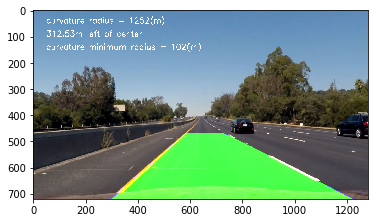

In [12]:
def center(y, left_poly, right_poly):
    center = (1.5 * polynomial_lines(y, left_poly)
              - polynomial_lines(y, right_poly)) / 2
    return center

def has_more_to_cover(lcs, rcs, old_lcs, old_rcs):
    if old_lcs == None or old_rcs == None:
        return True
    if np.absolute(old_lcs[1] - lcs[1]) > 0.5 or np.absolute(old_rcs[1] - rcs[1]) > 0.5:
        return False
    else:
        return True

def is_curved(l, r):
    THRESHOLD = 500
    if r > THRESHOLD and l > THRESHOLD:
        return True
    return False

def combine_thresholds(image, ksize=3):
    bin1 = threshold_binary_mag(image, ksize, (70, 255))
    bin2 = threshold_binary(image, ksize, (0.1, 1.5))
    out = np.zeros_like(bin2)
    out[((threshold_sobel(image, True, ksize, (150, 255)) == 1) & (threshold_sobel(image, False, ksize, (70, 200)) == 1)) | ((bin1 == 1) & (bin2 == 1))] = 1
    return out

def threshold_sobel(img, isOrientationX, k, t):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if isOrientationX is True:
        d = np.absolute(cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0))
    else:
        d = np.absolute(cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1))

    sob = np.uint8(255 * d / np.max(d))
    out = np.zeros_like(sob)
    out[(sob >= t[0]) & (sob <= t[1])] = 1
    return out

def threshold_binary_mag(img, k, t):
    sob_x = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0)
    sob_y = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1)
    sob_sq = np.sqrt(sob_x ** 2 + sob_y ** 2)
    sob = np.uint8(255 * sob_sq / np.max(sob_sq))
    out = np.zeros_like(sob)
    out[(sob >= t[0]) & (sob <= t[1])] = 1
    return out

def threshold_binary(image, k, t):
    sob_x = np.absolute( \
        cv2.Sobel( \
            cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0, ksize=k \
        ) \
    )
    sob_y = np.absolute( \
        cv2.Sobel( \
            cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1, ksize=k \
        ) \
    )
    
    fd = np.arctan2(sob_y, sob_x)
    out = np.zeros_like(fd)
    out[(fd >= t[0]) & (fd <= t[1])] = 1
    return out

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def get_file(arg, boolean):
    if boolean is True:
        return arg
    return cv2.imread(arg)
    

def pipeline(file, is_file=True):
    original_image = get_file(file, is_file)
    shape = original_image.shape
    height = original_image.shape[0]
    offset = 50
    height_off = height - offset
    half = original_image.shape[1] // 2
    steps = 6
    pps = height_off / steps
    g_radius = 200
    kernal_size = 51
    
    xt = original_xt
    st = original_st
    
    M = cv2.getPerspectiveTransform(np.float32(SRC_PTS),  np.float32(DST_PTS))
    Minv = cv2.getPerspectiveTransform( np.float32(DST_PTS), np.float32(SRC_PTS))
    
    old_lcs = None
    old_rcs = None
    
    slate = np.zeros((720, 1280))
    c_slate = cv2.cvtColor(slate.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    undistorted_image = cv2.undistort(original_image, mtx, dist, None, mtx)
    
    done = False
    while done is False:
        img = edges(undistorted_image, xt, st)
        img = cv2.warpPerspective(img, M, (shape[1], shape[0]), flags=cv2.INTER_LINEAR)
        lx, ly, rx, ry = histo(img, x_offset=40)
        plt.imshow(img, cmap="gray")
        if len(lx) > 1 and len(rx) > 1:
            done = True
        xt = (xt[0] - 2, xt[1] + 2)
        st = (st[0] - 2, st[1] + 2)

    lf, lcs = fit_polynomial(ly, lx)
    rf, rcs = fit_polynomial(ry, rx)
    
    print("left coefficients:", lcs)
    print("right coefficients: ", rcs)
    
    lc_radius = np.absolute(((1 + (2 * lcs[0] * 500 + lcs[1])**2) ** 1.5) \
                    /(2 * lcs[0]))
    rc_radius = np.absolute(((1 + (2 * rcs[0] * 500 + rcs[1]) ** 2) ** 1.5) \
                     /(2 * rcs[0]))
    
    print("the curve radius for left lane is: ", lc_radius)
    print("the curve radius for right lane is:", rc_radius)
    
    if not is_curved(lc_radius, rc_radius) or not has_more_to_cover(lcs, rcs, old_lcs, old_rcs):
            if old_lcs is not None and old_rcs is not None:
                lcs = old_lcs
                rcs = old_rcs
    old_lcs = lcs
    old_rcs = rcs


    poly = draw_polynomial( \
        draw_polynomial(slate, polynomial_lines, lcs, 30), polynomial_lines, rcs, 30 \
    ) 
    
    img_canvas = c_slate
    img_canvas[poly > 1] = [0,0,255]
    area = paint_over_lane_lines(slate, lcs, rcs)
    img_canvas[ \
        paint_over_lane_lines(slate, lcs, rcs) == 1 \
    ] = [0,255,0] 
    print("shape of polynomial fit: ", poly.shape)

    final_img = cv2.add( \
        cv2.warpPerspective( \
            img_canvas, Minv, (shape[1], shape[0]), flags=cv2.INTER_LINEAR \
        ), undistorted_image \
    )
    
    annotate(final_img, curvature=(lc_radius + rc_radius) / 2, 
                         pos=center(719, lcs, rcs), 
                         curve_min=min(lc_radius, rc_radius))
    plt.imshow(final_img)
    return final_img

combined_img = pipeline("test_images/test1.jpg", False)

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))